In [1]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

PyTorch version: 2.4.1+cu118
CUDA available: True
GPU: NVIDIA GeForce RTX 3090


In [2]:
!pip install ultralytics kagglehub opencv-python matplotlib torchvision --quiet

import os
import shutil
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import torchvision.ops as tvops

In [3]:
import kagglehub
BASE_PATH = kagglehub.dataset_download("hilongnguyn/human-crowd-dataset")
print("Dataset downloaded to:", BASE_PATH)
print("Splits:", os.listdir(BASE_PATH))

Dataset downloaded to: /home/user/.cache/kagglehub/datasets/hilongnguyn/human-crowd-dataset/versions/1
Splits: ['data.yaml', 'README.dataset.txt', 'train', 'README.roboflow.txt', 'valid']


In [4]:
WORKING_ROOT = "Datasets/human_crowd"

os.makedirs(WORKING_ROOT, exist_ok=True)

splits = ["train", "valid"]

for split in splits:
    src_images = os.path.join(BASE_PATH, split, "images")
    src_labels = os.path.join(BASE_PATH, split, "labels")

    dst_images = os.path.join(WORKING_ROOT, split, "images")
    dst_labels = os.path.join(WORKING_ROOT, split, "labels")

    os.makedirs(dst_images, exist_ok=True)
    os.makedirs(dst_labels, exist_ok=True)

    print(f"Copying {split} set...")
    img_count = 0
    lbl_count = 0

    for fname in os.listdir(src_images):
        shutil.copy(os.path.join(src_images, fname), os.path.join(dst_images, fname))
        img_count += 1

    for fname in os.listdir(src_labels):
        shutil.copy(os.path.join(src_labels, fname), os.path.join(dst_labels, fname))
        lbl_count += 1

    print(f"  {split} images copied: {img_count}")
    print(f"  {split} labels copied: {lbl_count}")

print("\nDONE COPYING TRAIN + VALID")
print("WORKING_ROOT:", WORKING_ROOT)
print("Train images:", len(os.listdir(os.path.join(WORKING_ROOT, 'train', 'images'))))
print("Valid images:", len(os.listdir(os.path.join(WORKING_ROOT, 'valid', 'images'))))

Copying train set...
  train images copied: 14431
  train labels copied: 14431
Copying valid set...
  valid images copied: 4810
  valid labels copied: 4810

DONE COPYING TRAIN + VALID
WORKING_ROOT: Datasets/human_crowd
Train images: 14431
Valid images: 4810


In [ ]:
import os
import shutil
from ultralytics import YOLO
import cv2
import glob
from tqdm import tqdm
import numpy as np

auto_label_model = YOLO("yolov8s.pt")

for split in ["train", "valid"]:
    images_root = os.path.join(WORKING_ROOT, split, "images")
    labels_root = os.path.join(WORKING_ROOT, split, "labels")

    print(f"\n=== Generating pseudo-labels for {split} ===")
    print("Images root:", images_root)
    print("Labels root (will be refreshed):", labels_root)

    if os.path.exists(labels_root):
        shutil.rmtree(labels_root)
    os.makedirs(labels_root, exist_ok=True)
    print("Labels root refreshed:", labels_root)

    image_paths = []
    for ext in ("*.jpg", "*.jpeg", "*.png"):
        image_paths.extend(glob.glob(os.path.join(images_root, ext)))

    for img_path in tqdm(image_paths):
        res = auto_label_model(img_path, conf=0.3, iou=0.5, classes=[0])[0]

        img = cv2.imread(img_path)
        if img is None:
            continue
        h, w, _ = img.shape

        labels = []
        if res.boxes is not None:
            for b in res.boxes:
                x1, y1, x2, y2 = b.xyxy[0].tolist()
                x1 = max(0, min(x1, w - 1))
                x2 = max(0, min(x2, w - 1))
                y1 = max(0, min(y1, h - 1))
                y2 = max(0, min(y2, h - 1))

                bw = x2 - x1
                bh = y2 - y1
                if bw <= 1 or bh <= 1:
                    continue

                xc = (x1 + x2) / 2.0 / w
                yc = (y1 + y2) / 2.0 / h
                nw = bw / w
                nh = bh / h

                labels.append(f"0 {xc:.6f} {yc:.6f} {nw:.6f} {nh:.6f}")

        base = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(labels_root, base + ".txt")
        with open(label_path, "w") as f:
            f.write("\n".join(labels))

    print(f"Pseudo-label {split} in:", labels_root)
    print("Labels File:", os.listdir(labels_root)[:5])


=== Generating pseudo-labels for train ===
Images root: Datasets/human_crowd/train/images
Labels root (will be refreshed): Datasets/human_crowd/train/labels
Labels root refreshed: Datasets/human_crowd/train/labels


  0%|                                                 | 0/14431 [00:00<?, ?it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-1a9a90008c2b82fa_jpg.rf.440cbfc452310a21afc8fddc2d511276.jpg: 640x640 3 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  0%|                                      | 1/14431 [00:02<11:21:45,  2.83s/it]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-886c800003f4a732_jpg.rf.10d25eee588c0d66399967dd7874767b.jpg: 640x640 5 persons, 6.4ms
Speed: 3.1ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-3c037000289443b8_jpg.rf.097a6af6028fc25ce048bc79303da4d0.jpg: 640x640 11 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-14f3200065b09624_jpg.rf.fa7771472e8cda7b4b5624f33446c92c.jpg: 640x640 6 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-b0eb1000f79d3b85_jpg.rf.3cc59b89deb147c3cc381d73fa48fdc6.jpg: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  0%|                                       | 8/14431 [00:02<1:05:27,  3.67it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-49743000fec691d0_jpg.rf.6c5f2e3cef498754b87e4ef2fd07161b.jpg: 640x640 3 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-171f7000bb2f219f_jpg.rf.2828bddd30c5cf074a14715437907481.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-9eedb000c088122e_jpg.rf.361c18a9c80fda7ebd0e4b1d3efcf41e.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-2318d00061d1863d_jpg.rf.039ed2390f395ec5116a6465303d2bcc.jpg: 640x640 14 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  0%|                                        | 16/14431 [00:03<28:22,  8.47it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6d1180000d2b2356_jpg.rf.7b483d0d7b600c9fbb26140de2cfb2bd.jpg: 640x640 7 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-79147000c45f27f0_jpg.rf.0c595e3cf70ffa09995450963e804aea.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-e7c1000e5e667a3_jpg.rf.b9c05dc04f3a2beabae135f6e412268a.jpg: 640x640 7 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-2ad8a000f4d075f6_jpg.rf.97798ffb124462acd815d237d335d6a0.jpg: 640x640 14 persons, 6.1ms
Speed: 1.2ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  0%|                                        | 24/14431 [00:03<16:48, 14.28it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-3fc3e0008c1c4020_jpg.rf.1dbd3b448b26a4e2ec00ca7dce64a2ed.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-eca15000f6d40fd6_jpg.rf.126ef9c431a4b4564b2b8dda022e9aba.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-142e7000d00b9c01_jpg.rf.a16723277124c1f2f3a78f48c24e2ef4.jpg: 640x640 8 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-108989000824c6112_jpg.rf.86d090eeaed60daf22c2f039adb98a37.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  0%|                                        | 31/14431 [00:03<11:55, 20.12it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1ebdd00038dd72c1_jpg.rf.614230a273b28a87b95b7163737be1c9.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-50200084cc770f_jpg.rf.3b73dff5de694272f41478042d2e5589.jpg: 640x640 6 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-d9fc00027a31c92_jpg.rf.ffc46aa3ca39bcc2df17082544223e7e.jpg: 640x640 19 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-24a66000826d2fb2_jpg.rf.1441bfdd52e50de2b13700e169a84bfb.jpg: 640x640 14 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  0%|                                        | 39/14431 [00:03<08:41, 27.59it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-17d19000316c2603_jpg.rf.276bc98f9b57a44f74e624017f265ee9.jpg: 640x640 13 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-3dde700043412110_jpg.rf.6b07445256307656f57642105b48a984.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-aa5de000c67832eb_jpg.rf.35e949e25d8048d02afd006cd6f2eec8.jpg: 640x640 10 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-127f93000d7f01c8a_jpg.rf.272ae5926bc8f2b51c782a523b40fe6c.jpg: 640x640 11 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

  0%|▏                                       | 47/14431 [00:03<06:53, 34.79it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-11a2e000e4c52586_jpg.rf.1147dbfc272473adfa1ab83f8e847514.jpg: 640x640 13 persons, 5.6ms
Speed: 1.8ms preprocess, 5.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-c9f6d00079ba10fe_jpg.rf.2691e245aab07e658d0f0c825d3ab1c2.jpg: 640x640 15 persons, 5.7ms
Speed: 1.8ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-f03880007e5b2551_jpg.rf.d26ab544924aada2a916f13ed41cb6d9.jpg: 640x640 9 persons, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-5f30e0008e03ce8d_jpg.rf.50ed3e1d6e6474ad07329b883c685da8.jpg: 640x640 19 persons, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  0%|▏                                       | 54/14431 [00:03<05:51, 40.85it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1421a20006a3687b5_jpg.rf.640b4d298029183c9e026e0ff994308d.jpg: 640x640 17 persons, 5.0ms
Speed: 0.9ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-4989000071513af7_jpg.rf.fc40a66259418d127ad31c3c623c6559.jpg: 640x640 11 persons, 5.2ms
Speed: 2.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-98a38000ba09d770_jpg.rf.02a3cab320f829f9a346cd85a833094c.jpg: 640x640 9 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-2ef96000e0c30515_jpg.rf.48cfe564989ea5b9ef6b442a630ba93b.jpg: 640x640 13 persons, 6.4ms
Speed: 1.4ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

  0%|▏                                       | 61/14431 [00:03<05:14, 45.73it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-1113e900093a19c11_jpg.rf.b93901cc1cca3eed0e3f02dbaab08f52.jpg: 640x640 4 persons, 5.6ms
Speed: 1.1ms preprocess, 5.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-41c98000fbebd89f_jpg.rf.a759b6c54e5d3ccb44d3ff3bc7aae48a.jpg: 640x640 14 persons, 6.9ms
Speed: 2.8ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-d02a00009343b915_jpg.rf.8e3b0789bfe4bc23fdf9e05b3725d901.jpg: 640x640 7 persons, 5.5ms
Speed: 1.9ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-46b05000208902cf_jpg.rf.e1f28f191c91c5e269bd3b52eefc09ea.jpg: 640x640 7 persons, 6.7ms
Speed: 1.2ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  0%|▏                                       | 68/14431 [00:03<04:51, 49.25it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-2b1f2000c1149077_jpg.rf.82be5aaaa86690fcc67acbb6e0b7e71e.jpg: 640x640 22 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-101813000cc57dcb4_jpg.rf.8f605899561e67a8169c3fe4de39363d.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-c01310005a429ce1_jpg.rf.d50169d15dad08f1daf0ec89c58f3948.jpg: 640x640 6 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-ca0a000c8363bb4_jpg.rf.d1a965216e464823caef586139d633bb.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  1%|▏                                       | 75/14431 [00:03<04:29, 53.28it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6c1f7000b5db2e1c_jpg.rf.d30d04b15c1028671bee709f611268eb.jpg: 640x640 12 persons, 5.1ms
Speed: 2.3ms preprocess, 5.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-108d460005a68f19a_jpg.rf.191d05f6e1063683d9c87998b08d6422.jpg: 640x640 14 persons, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-3bbc100032d52b25_jpg.rf.a94f228288acb393b87dbe31a190646f.jpg: 640x640 10 persons, 5.5ms
Speed: 2.1ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-d457000b20960f1_jpg.rf.4c2900bec6adb0b4e1e50df4dafbf5b3.jpg: 640x640 3 persons, 5.4ms
Speed: 2.2ms preprocess, 5.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  1%|▏                                       | 82/14431 [00:04<04:16, 55.89it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283081-973f0008dc1aa4e_jpg.rf.77fad431dc09312cb36fdfb7ab25c7eb.jpg: 640x640 3 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-24e46000ccd8149e_jpg.rf.534d0db03eafd5687855e68854087015.jpg: 640x640 16 persons, 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-10ff40005ed76d57_jpg.rf.a3f81b866adad3a8f3458213503de329.jpg: 640x640 12 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1ca4000c4a3d5dc_jpg.rf.5a314c5b33a69e0660d8240c2c44ba7f.jpg: 640x640 14 persons, 6.3ms
Speed: 1.3ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  1%|▏                                       | 89/14431 [00:04<04:08, 57.74it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-e477300026a0df84_jpg.rf.5d4b4b049fbf136d11f1a5adac62af9a.jpg: 640x640 5 persons, 9.5ms
Speed: 1.4ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-52130006e301bb0_jpg.rf.9440e65dd1ad5c24e2ab2a3a20b99966.jpg: 640x640 11 persons, 5.9ms
Speed: 1.3ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-549f50009811f8ca_jpg.rf.eb01de3d1c6bc34308c8243f0a1babe2.jpg: 640x640 11 persons, 6.3ms
Speed: 1.2ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6efde000ca483a76_jpg.rf.650bad6e55c01fbf20e9a70403f1658e.jpg: 640x640 14 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  1%|▎                                       | 96/14431 [00:04<04:05, 58.44it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-18f6400062f5ec3d_jpg.rf.bf31d3985fd4d841a3c76a93714604b4.jpg: 640x640 9 persons, 7.2ms
Speed: 5.1ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-147b8c00067e30d3e_jpg.rf.1a7c84f7367c59b4ee2e094b18d2fa3f.jpg: 640x640 3 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-643d0000b8c70e87_jpg.rf.65eeab9f34ad91af1b2bdc0d8ec001dc.jpg: 640x640 10 persons, 6.2ms
Speed: 3.9ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-c1f82000900d79fb_jpg.rf.cc32e3f04ebad1a3d71dcc0d4eb24384.jpg: 640x640 10 persons, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  1%|▎                                      | 103/14431 [00:04<04:03, 58.73it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-83ef4000bf51a77c_jpg.rf.7df5d1d9ea6ab85155ca8db4dede5d08.jpg: 640x640 3 persons, 11.2ms
Speed: 5.1ms preprocess, 11.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-197650002b8289d7_jpg.rf.9f5e358e108c2028c92bb61ff2b3b533.jpg: 640x640 9 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-d0d4000b19076ba_jpg.rf.f675fbf9cf2f332edd57e74cab3187cf.jpg: 640x640 12 persons, 9.7ms
Speed: 1.1ms preprocess, 9.7ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-20df0003eb2d362_jpg.rf.4b77a0ba51f774216fe45bac69396bd9.jpg: 640x640 11 persons, 6.9ms
Speed: 4.7ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  1%|▎                                      | 110/14431 [00:04<04:17, 55.62it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1b60300031d1c2ce_jpg.rf.cbf13819388ade953ecc42e412cdceec.jpg: 640x640 7 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-cb6d3000df54bbb0_jpg.rf.aafe5433a1e4eea13a84cabdd593cb01.jpg: 640x640 10 persons, 6.2ms
Speed: 1.0ms preprocess, 6.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-1e97800008a6fcb5_jpg.rf.a3ee7891bd26fe15f98cdaa597193fe1.jpg: 640x640 6 persons, 6.6ms
Speed: 1.1ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-55a70001d3a0ad6_jpg.rf.6360d6652fd9fe69ba38a949b73e416d.jpg: 640x640 5 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  1%|▎                                      | 117/14431 [00:04<04:05, 58.31it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-d6ec0001a5f830c_jpg.rf.0a8ff43b825480cda3f261d97dc9bf3e.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1973f0007c5bb6a0_jpg.rf.071fe2f12802bf74cb5703355fa770c0.jpg: 640x640 12 persons, 5.9ms
Speed: 1.3ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-27f09000803f6fe2_jpg.rf.e0a13455fc0c5d7404b55953bf8f7682.jpg: 640x640 6 persons, 7.7ms
Speed: 1.5ms preprocess, 7.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-163ff00067aa90c1_jpg.rf.d53fc8785dfeca3444e2441e4db3439e.jpg: 640x640 9 persons, 6.0ms
Speed: 1.1ms preprocess, 6.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  1%|▎                                      | 124/14431 [00:04<04:12, 56.74it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283991-10fda0001d005873_jpg.rf.cd226e53f3d9b9e065bc4378d0559453.jpg: 640x640 9 persons, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-d7a80009b8a9dc8_jpg.rf.0d9995face11178a9c6e71ad1cbd1531.jpg: 640x640 6 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-646700009d087a58_jpg.rf.28a93b56f4538032c96014c24c736a98.jpg: 640x640 1 person, 7.8ms
Speed: 1.1ms preprocess, 7.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-cf476000df670ed0_jpg.rf.1afa8e4a1d55c813feea4d9dbc85ec36.jpg: 640x640 12 persons, 6.2ms
Speed: 1.3ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

  1%|▎                                      | 130/14431 [00:04<04:08, 57.46it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-43a230005ac0ed64_jpg.rf.981af4e385718f358fa652df53f1dbc4.jpg: 640x640 15 persons, 5.4ms
Speed: 1.1ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-17df9000ec7ef20f_jpg.rf.72b061e6b91b32f13bb72bc062259116.jpg: 640x640 13 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-11f160001cd6b568_jpg.rf.9c6515d109f02be69e4db8b5916c071a.jpg: 640x640 6 persons, 5.9ms
Speed: 1.7ms preprocess, 5.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-12a45a0002de02212_jpg.rf.5ed7ae98552056c33bd17981439ae4ba.jpg: 640x640 19 persons, 4.9ms
Speed: 1.3ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

  1%|▎                                      | 137/14431 [00:04<04:00, 59.54it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-8f4a00001fa44441_jpg.rf.0847073b778555162ab119729a334418.jpg: 640x640 16 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-b27e00054be8684_jpg.rf.49b30640e481ac46a8cdf99ce3d45f98.jpg: 640x640 15 persons, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-aedd100033c71df7_jpg.rf.4f6c2b4d6bb7c4551fbe07673aa461ed.jpg: 640x640 6 persons, 7.3ms
Speed: 1.1ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-11c9070005494e369_jpg.rf.4121c24f1f5bb216794d15330a0d6871.jpg: 640x640 7 persons, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  1%|▍                                      | 144/14431 [00:05<04:03, 58.59it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-701d900091b96260_jpg.rf.4da770da2a9a461cfdbfe2ba532c0118.jpg: 640x640 6 persons, 5.0ms
Speed: 1.8ms preprocess, 5.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-300ac0000b06b3ad_jpg.rf.1c5e0f057ba2d906e41de9843843d439.jpg: 640x640 5 persons, 6.7ms
Speed: 1.3ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-9b1da0003897b905_jpg.rf.72b6ed95991d6e128bde9944d28a41bc.jpg: 640x640 15 persons, 8.8ms
Speed: 5.2ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-155b00078f54d81_jpg.rf.a4305a304c94f40d1048f2d5af62cb44.jpg: 640x640 13 persons, 5.3ms
Speed: 1.3ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  1%|▍                                      | 150/14431 [00:05<04:11, 56.67it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-9bf0000b459d62a_jpg.rf.2f31e129ce7e3f0d81e76f4662de3390.jpg: 640x640 13 persons, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-739d00071551457_jpg.rf.979b4f139b98ab898c061448df49fc66.jpg: 640x640 14 persons, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-d94d7000d3799081_jpg.rf.daee44e0b4a53f0682af9c5aafe8048d.jpg: 640x640 7 persons, 5.7ms
Speed: 2.3ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1340c1000fde5a37a_jpg.rf.c434265d312b6f4fc6b26b3b9ecfb90a.jpg: 640x640 11 persons, 10.0ms
Speed: 1.3ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1

  1%|▍                                      | 156/14431 [00:05<04:23, 54.23it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-92516000e3438af4_jpg.rf.5951e759a17c09fc78e621cc8ddafe6a.jpg: 640x640 5 persons, 6.6ms
Speed: 1.5ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-106220007be3af91_jpg.rf.eb85f6e31dbdddbdc1add60513219d57.jpg: 640x640 11 persons, 6.7ms
Speed: 1.3ms preprocess, 6.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-913d000bd1b3afa_jpg.rf.f5fe332a2146e94a7894034ac9d0914c.jpg: 640x640 3 persons, 6.1ms
Speed: 2.9ms preprocess, 6.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-120a38000b486d5ae_jpg.rf.8f1662a8ebc42aabb67f78cedabb8af2.jpg: 640x640 6 persons, 8.8ms
Speed: 1.2ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  1%|▍                                      | 162/14431 [00:05<04:21, 54.60it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-77dd20008df92cd6_jpg.rf.2dfe8a734f92ddaf5d5259bf60e40474.jpg: 640x640 14 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-80c23000ffd339c7_jpg.rf.a53885f2247f2c03ed25dfd361e09af6.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-f600e0002f70b5b5_jpg.rf.3bca821395a203d66c16d9df99ea5f3d.jpg: 640x640 1 person, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-aa5ab000148098da_jpg.rf.2120d002321bcfb2677e5eb509078629.jpg: 640x640 12 persons, 5.7ms
Speed: 1.1ms preprocess, 5.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  1%|▍                                      | 170/14431 [00:05<03:55, 60.57it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-748de000d5ddae8b_jpg.rf.e960d60ec081aa9d571876ee46659980.jpg: 640x640 10 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-a78b0002014d29a_jpg.rf.47cfc41a59c09df1b4831f966796e2c6.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-cf019000bb1a9706_jpg.rf.b5888a399a28ad5ede865748555b9c3b.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-37d7b000d269af38_jpg.rf.d83d44b68cd12cc093ff4671b6837bad.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  1%|▍                                      | 179/14431 [00:05<03:31, 67.23it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-6b10b000672fe091_jpg.rf.ac6dd9dbf09e8e2cfcff5163bd6b08df.jpg: 640x640 18 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-39633000c87a2a17_jpg.rf.a1cde906ed3e6d03d8659f852f1b9de4.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-98f230003ef10f9e_jpg.rf.2291a7d860618d9e56cac2a5a7771ca3.jpg: 640x640 4 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-63c190005901f8b5_jpg.rf.309c07ea57ff950f0a29f142e0240e94.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  1%|▌                                      | 188/14431 [00:05<03:21, 70.85it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-ea668000802bd07c_jpg.rf.4d8445b6c272d0c81bca75f77cb20eb9.jpg: 640x640 16 persons, 5.4ms
Speed: 1.6ms preprocess, 5.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-c7d2d00028ec24c8_jpg.rf.de07ceb04714c30b02ea316bebcc80a7.jpg: 640x640 1 person, 6.2ms
Speed: 1.1ms preprocess, 6.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-d9d0e000ff710a7f_jpg.rf.d2f5aee34cd05b4a07f9af390ed4108d.jpg: 640x640 7 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-27eb0000f60cc01b_jpg.rf.61522d0099498e35e0aedf4efa02e7fb.jpg: 640x640 15 persons, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  1%|▌                                      | 196/14431 [00:05<03:29, 68.09it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-dc30d000bcc6b5c4_jpg.rf.a8d23dbfd71e153d0566f677cb86ac1e.jpg: 640x640 15 persons, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-b48c9000d7b8a748_jpg.rf.e6faa9a662a19b037010c30e2cfec988.jpg: 640x640 4 persons, 5.1ms
Speed: 1.8ms preprocess, 5.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-f3a050007c7fe46e_jpg.rf.796c9e16c4f5856864f2b0adb146e17f.jpg: 640x640 8 persons, 6.8ms
Speed: 1.5ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-b6c80005e459d16_jpg.rf.dba1e2ab76a235ab26310ed34add48bc.jpg: 640x640 5 persons, 8.0ms
Speed: 1.2ms preprocess, 8.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  1%|▌                                      | 203/14431 [00:06<03:48, 62.35it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-d6a55000331ad898_jpg.rf.980d66c071636f1816933a5b97fce58c.jpg: 640x640 19 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-2b8940003b84ad0d_jpg.rf.fc1fc0ded782ea18b0ada6553321b8e0.jpg: 640x640 1 person, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-43b950000b752df8_jpg.rf.2417ec8f1c12998bb7de42a093d9fea4.jpg: 640x640 11 persons, 7.9ms
Speed: 3.8ms preprocess, 7.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-94823000257a0218_jpg.rf.d9f8be1c7750a83255dec0597ec23757.jpg: 640x640 10 persons, 6.3ms
Speed: 3.1ms preprocess, 6.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  1%|▌                                      | 210/14431 [00:06<04:05, 57.98it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-ce7be000c6866f26_jpg.rf.a1481fd48a8c7518d210c5f42eae0aa2.jpg: 640x640 14 persons, 5.0ms
Speed: 3.3ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-63430005990fb30_jpg.rf.67e6c5b5884bfdc66664b21c25216086.jpg: 640x640 9 persons, 5.3ms
Speed: 1.3ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-9e06e00052f4cc26_jpg.rf.b242bb0a4bdc54c4829a143187d49f49.jpg: 640x640 6 persons, 5.7ms
Speed: 2.2ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-15169000875a68e6_jpg.rf.9f4de9a19c275af58479571dc1037fb9.jpg: 640x640 6 persons, 6.9ms
Speed: 2.6ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  1%|▌                                      | 216/14431 [00:06<04:04, 58.24it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-9c39d00080a53567_jpg.rf.8fc4966a7d8e414966d0d6f829bc0dda.jpg: 640x640 11 persons, 6.0ms
Speed: 2.3ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-a64fc000077a1914_jpg.rf.b1480f8d9b75aa56796b17b628502a0e.jpg: 640x640 4 persons, 6.7ms
Speed: 1.5ms preprocess, 6.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-2ec460007040af5c_jpg.rf.db8376f5ef2fda80916a59fc1c743fc4.jpg: 640x640 15 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-17a01000ae1735ca_jpg.rf.8fe267b99fb7b2bbdc41ab47f944f07d.jpg: 640x640 17 persons, 5.9ms
Speed: 1.7ms preprocess, 5.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  2%|▌                                      | 222/14431 [00:06<04:04, 58.09it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-8bf300079a5d98d_jpg.rf.7593cced5347f88a83b8524a3eef5849.jpg: 640x640 12 persons, 5.8ms
Speed: 1.3ms preprocess, 5.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1f6e900083203f64_jpg.rf.ac5012f66bf55aae0bb17779d63b0ce6.jpg: 640x640 2 persons, 5.9ms
Speed: 2.3ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1daab0007febceec_jpg.rf.743123f9dcecdc403875eee97e614b6b.jpg: 640x640 15 persons, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-22e8c00090d0572d_jpg.rf.431db91e025c7e93b1ff7d698197841f.jpg: 640x640 8 persons, 5.3ms
Speed: 2.8ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  2%|▌                                      | 228/14431 [00:06<04:02, 58.45it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-72aac000c7c048cc_jpg.rf.772eb26213b32e7af9b24b0cbbef648c.jpg: 640x640 16 persons, 7.5ms
Speed: 4.0ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-36a85000d1aca484_jpg.rf.e150ed405bb12c6c3d52105dfcd0aa88.jpg: 640x640 10 persons, 4.9ms
Speed: 3.3ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-18db3000aafeed4e_jpg.rf.752e05bf3c6d0d1bb81d31b42f10541c.jpg: 640x640 18 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6b760000b8724fcc_jpg.rf.172f204d979292fdce71186337010fa4.jpg: 640x640 10 persons, 6.3ms
Speed: 1.0ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

  2%|▋                                      | 235/14431 [00:06<03:50, 61.61it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-7dea5000204fa91d_jpg.rf.df157650ab13efd95f91a1bfc5636b5e.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-11ca8e0001f5ac952_jpg.rf.1b4ad16971ab0468c82764eece1e55ab.jpg: 640x640 13 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-20de9000d19d2532_jpg.rf.90098f946dd6d86838934b13ffc3e45e.jpg: 640x640 5 persons, 5.2ms
Speed: 0.9ms preprocess, 5.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-233b6000008d62ea_jpg.rf.550ea407c532a9e833b01e3ae8d748ec.jpg: 640x640 16 persons, 7.4ms
Speed: 4.7ms preprocess, 7.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  2%|▋                                      | 242/14431 [00:06<03:51, 61.18it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-a2a91000595b22ce_jpg.rf.38728c1f38aba0f94f7519b708fdff51.jpg: 640x640 5 persons, 6.1ms
Speed: 3.9ms preprocess, 6.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-11874000de172418_jpg.rf.fbea02f0cbaa679f59d2e43048147c3b.jpg: 640x640 4 persons, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-db5a00084ca6550_jpg.rf.944f58b6d4b529ad811d5fed5e76f5ca.jpg: 640x640 8 persons, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-a1935000c3875d31_jpg.rf.a2fd943ed3f6be41eb9864c637fff6d7.jpg: 640x640 10 persons, 5.0ms
Speed: 1.5ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  2%|▋                                      | 249/14431 [00:06<03:53, 60.79it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-88fad000f79b5cf5_jpg.rf.cdf88218c88dec9417cea9efe9813a27.jpg: 640x640 8 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-13022b0007f9451e8_jpg.rf.abe6fdc71a53b9cdda4beb73a217b651.jpg: 640x640 6 persons, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-97909000f44f248b_jpg.rf.ba06795aeaf1ace4a7d6bdf32248558b.jpg: 640x640 1 person, 6.4ms
Speed: 1.2ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-289dc0009de81380_jpg.rf.5d78dcd834ad6bdc7892a645d4551c0f.jpg: 640x640 4 persons, 5.9ms
Speed: 1.3ms preprocess, 5.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  2%|▋                                      | 256/14431 [00:06<03:54, 60.50it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-d6e8f000e1e81526_jpg.rf.d71b56230dabb474bbe9e24d2d0ebd0a.jpg: 640x640 9 persons, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-4f442000fc46026d_jpg.rf.db3619765d46951eb2803469941ebc94.jpg: 640x640 17 persons, 6.9ms
Speed: 1.1ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-ed6e7000c701f067_jpg.rf.3fa6a62290385002cd3e8e99eb95f4ce.jpg: 640x640 13 persons, 6.3ms
Speed: 1.0ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-5c93000bed7cdea_jpg.rf.2b3b7915538374c24f5455039ff65ecd.jpg: 640x640 15 persons, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  2%|▋                                      | 263/14431 [00:07<03:58, 59.30it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-34d50002f5cb3ce_jpg.rf.7594d46ee5f00d24eefe504ca5405c50.jpg: 640x640 12 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-b408d0001115b7c7_jpg.rf.6d4dfc09eb0ec41362ceea269b78bf6a.jpg: 640x640 4 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-cc7600098e7f7d9_jpg.rf.9a528d64e530017f8827561d6ec3f100.jpg: 640x640 12 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-e8496000f69dd68f_jpg.rf.9f51a4cb660d1015b737358b3835c71f.jpg: 640x640 12 persons, 5.8ms
Speed: 1.0ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  2%|▋                                      | 270/14431 [00:07<03:52, 60.87it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-21319000ff5d04a7_jpg.rf.bf36a659fcb65cdf5b4e4b7bd7eb1f64.jpg: 640x640 5 persons, 6.2ms
Speed: 1.2ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-e23a00092a4743a_jpg.rf.46e45dd2dd18cfe77872ac63eac81fbc.jpg: 640x640 11 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-c3a8a000ad0b2438_jpg.rf.688f241b54b97c408114893d317d5115.jpg: 640x640 9 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-74298000322ab2d1_jpg.rf.e09e52e3cd93e359106d3817079741fc.jpg: 640x640 15 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  2%|▋                                      | 277/14431 [00:07<03:46, 62.60it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-9a97000dc7bea58_jpg.rf.8b79b12ae4e7f82e2d1d2b0ea0ac45d9.jpg: 640x640 11 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-19bcf000fc79faef_jpg.rf.34e700421c3a89d4828dc99c09fc9652.jpg: 640x640 7 persons, 6.4ms
Speed: 1.0ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1acd7000fa996227_jpg.rf.548cfb424468deb0b822ae36c0ec39a8.jpg: 640x640 11 persons, 6.8ms
Speed: 6.0ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-613fe0002b96d43b_jpg.rf.7acad1cd087fd4023b35e657da3a7c36.jpg: 640x640 8 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  2%|▊                                      | 284/14431 [00:07<03:49, 61.69it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-29658000373a775c_jpg.rf.915211e4fdba6580730b9c0847363636.jpg: 640x640 9 persons, 6.1ms
Speed: 2.6ms preprocess, 6.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-1c9be0009c1d4f9e_jpg.rf.705e5ce964919464b862e45fd86322e7.jpg: 640x640 16 persons, 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-9a7bd000f6fae40c_jpg.rf.47399eaf2c129023ee46a6bc8ea174b7.jpg: 640x640 7 persons, 6.4ms
Speed: 1.1ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-168330004975722b_jpg.rf.bfdbd8ff1e625eabb1a697451d37c606.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  2%|▊                                      | 291/14431 [00:07<03:51, 61.15it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-3f15c00044b430ff_jpg.rf.d9d17ab5e8ed9434af4b50aab31bf927.jpg: 640x640 14 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-6f9fc00027f3f324_jpg.rf.b97aa5e6fdaf05cb7943214cbf239c28.jpg: 640x640 9 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1e0470006d440a50_jpg.rf.dfdf8dd79179ad6321d0d42efea62248.jpg: 640x640 8 persons, 5.3ms
Speed: 0.9ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-d02e4000a7a67934_jpg.rf.7766aefb3c5057a2101e3e0d15f5f639.jpg: 640x640 12 persons, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  2%|▊                                      | 298/14431 [00:07<03:44, 62.89it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-1acb00092ad10cd_jpg.rf.6546d9e251fb51705998de40529aefd3.jpg: 640x640 10 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-43c3000081ef70db_jpg.rf.aca239e8d7c4ec1f4848d8a73030e425.jpg: 640x640 11 persons, 6.6ms
Speed: 1.0ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-177aa000cac19bc0_jpg.rf.bd268d0b394b21832eefb4456180764f.jpg: 640x640 12 persons, 6.3ms
Speed: 1.0ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-1b1fe000f37dc35f_jpg.rf.4065ae49d0acbd55b4ee671fcd0c1b09.jpg: 640x640 10 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  2%|▊                                      | 306/14431 [00:07<03:36, 65.25it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283991-76e000e01315d3_jpg.rf.077ce0d5c906ac2f9af33af0b69fcd1d.jpg: 640x640 14 persons, 5.3ms
Speed: 1.3ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6c3ec0009bb223bd_jpg.rf.48d5dd71e6b80b8e5d976c55d6cf1970.jpg: 640x640 9 persons, 5.4ms
Speed: 2.5ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-1288f000702c702f_jpg.rf.15006033e70d0eb7b121a5ff748dca52.jpg: 640x640 12 persons, 5.0ms
Speed: 1.9ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-50e28000fd310a0d_jpg.rf.c40829b30d71df0959b837579cde3efd.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  2%|▊                                      | 313/14431 [00:07<03:40, 63.89it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-e58f200015530ef9_jpg.rf.dceaa23383addc2b48b0d503b1fa1444.jpg: 640x640 3 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-ab66c0008202d0a9_jpg.rf.af625b409b3006b19afc63d8341a97b4.jpg: 640x640 9 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-6dbb00060de5cfe_jpg.rf.2476cb48e2a59daeda66b2b825ed82ea.jpg: 640x640 15 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1b90a000d4a5ba6e_jpg.rf.9fff3ed9d0e3cc0bfc3685ce985e3cbc.jpg: 640x640 (no detections), 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1

  2%|▊                                      | 320/14431 [00:07<03:37, 64.90it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283081-372f0008598b195_jpg.rf.96e464f51350c687f52ecfc3fa8640f2.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-eb3ef000d27967bd_jpg.rf.3742d53f091d2004ea872114cf1cd836.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-c3e4e000920526ef_jpg.rf.faf20557bf5a28d94fb12763190b5b04.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-da7140002857ee79_jpg.rf.28b983a9d0a56cca07df2009ec766d67.jpg: 640x640 12 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  2%|▉                                      | 327/14431 [00:08<03:35, 65.57it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1bdef00063ae5e62_jpg.rf.659aaa84a8110975bf0570710b12e246.jpg: 640x640 13 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-7176000cb8dc623_jpg.rf.89be0824ce856c3e414d3c3a8da3b3c7.jpg: 640x640 19 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-e8b41000c7768d8d_jpg.rf.834f8cc226fd91c1591fa40363cc9def.jpg: 640x640 9 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1336cc000ac5b8c3a_jpg.rf.53137c7f84a5d368cfe64ff7d0e5718b.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  2%|▉                                      | 334/14431 [00:08<03:33, 65.89it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-5677500096b5457c_jpg.rf.3fb271b8b138648fe3367f73c6cfaf7b.jpg: 640x640 17 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-e26dc000988c39d0_jpg.rf.92f102f795cf21c107e9edaa63aa6fb8.jpg: 640x640 1 person, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-fad3200036222a85_jpg.rf.3250ba651c52e80dcb0208f5d11b9d03.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-112b900036db0b4e_jpg.rf.ed6a0fe5cbd0ff0538d8ecc88ae36891.jpg: 640x640 15 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  2%|▉                                      | 341/14431 [00:08<03:32, 66.24it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-8e0e000b980c3c5_jpg.rf.f425786c1f3af4681f1bab6054f9ec44.jpg: 640x640 10 persons, 5.3ms
Speed: 1.3ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-53db2000accee481_jpg.rf.3e2941205a5ef44871b1e09646c3a42e.jpg: 640x640 (no detections), 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-802c8000432f05ac_jpg.rf.2fe051a12f9073d7383e9eb8bbd656f0.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-d66f9000d6303a51_jpg.rf.dda8cbfd45e79cfaab0de27d6e8ea48c.jpg: 640x640 15 persons, 5.8ms
Speed: 1.0ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/

  2%|▉                                      | 349/14431 [00:08<03:29, 67.24it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-190d80004e95cf42_jpg.rf.a4b0cd8c57133eb9c5b0c9dcbb469b93.jpg: 640x640 15 persons, 5.4ms
Speed: 1.5ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-d8ad60001f0f5194_jpg.rf.16226f16d58fa5c94a3b5376f43a40a4.jpg: 640x640 14 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-2c3a9000ed7b1def_jpg.rf.469cf89b7304109d859d52ce79eb2b5f.jpg: 640x640 7 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1e745000175707a9_jpg.rf.68c04df24a6484459d7052d3a28d8313.jpg: 640x640 12 persons, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  2%|▉                                      | 357/14431 [00:08<03:28, 67.45it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-2c8ec000e8b63289_jpg.rf.94d4ffd856b05da530de4c5230d25545.jpg: 640x640 11 persons, 5.3ms
Speed: 1.4ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-f48e000690aaad1_jpg.rf.ccbea488b7eae3339dc490ef0cf233e9.jpg: 640x640 16 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-127950005d59d51d_jpg.rf.d73d9958c0a6a9331d1400603aaa192c.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-1126f0001a6fcd1a_jpg.rf.2e835e4b60419d142a371d25bf223277.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  3%|▉                                      | 364/14431 [00:08<03:28, 67.60it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-d7ea3000594c6317_jpg.rf.989dd85713cb1a3a8ba86cb3daf608ce.jpg: 640x640 14 persons, 5.4ms
Speed: 1.8ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-4ed54000cf4d43eb_jpg.rf.62e9552232d33d1a0054ba19d5f9b199.jpg: 640x640 13 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-fbbd40003c037f6b_jpg.rf.0aadf56a8682d33ed6f10e12cdcdc1d3.jpg: 640x640 12 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-12d44000dacc3c91_jpg.rf.fbe75404cfd6c76b072421ad1a3537a5.jpg: 640x640 4 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  3%|█                                      | 371/14431 [00:08<03:28, 67.35it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-6f0d00029cd4f59_jpg.rf.9d0f7bb913cd6ab785b9d9539e6476c9.jpg: 640x640 13 persons, 7.7ms
Speed: 1.2ms preprocess, 7.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-6d0dd000ad40f369_jpg.rf.e90924b88c340787b2fa94399d015f76.jpg: 640x640 15 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-3a27c000f3808456_jpg.rf.e5edda743828109e4f4f72bc697d4217.jpg: 640x640 7 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-e94fa0003b23a2ad_jpg.rf.a020f3bb9dd1dbeefd3995bc3c0856f5.jpg: 640x640 17 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  3%|█                                      | 378/14431 [00:08<03:35, 65.34it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-43b58000863104dc_jpg.rf.a125a7989a571c03af75462a469f7ef5.jpg: 640x640 9 persons, 5.6ms
Speed: 2.7ms preprocess, 5.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1eb990009d64d362_jpg.rf.a23babf91df0780f0aaea0af327b23c8.jpg: 640x640 9 persons, 4.7ms
Speed: 2.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-111f110002ef38fb9_jpg.rf.79358c49ec0be06a93bea9d5c62102c0.jpg: 640x640 12 persons, 5.3ms
Speed: 1.3ms preprocess, 5.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-b2680000dfc23fe6_jpg.rf.b0988638e9fb0a6b67654b935c401582.jpg: 640x640 8 persons, 5.6ms
Speed: 2.4ms preprocess, 5.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  3%|█                                      | 385/14431 [00:08<03:41, 63.37it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-bb4d70002f67506f_jpg.rf.8118dfee97c9eb2945d5fa48ac0e765f.jpg: 640x640 4 persons, 5.0ms
Speed: 1.4ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6ccaf000e335fa4e_jpg.rf.4662b1445ae1b3a8a3d8dbbaa11494b1.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-11e6600046305e2d_jpg.rf.b08154d30d476235fa2f0e28f0b0f325.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-ceb8e00071a3a7dc_jpg.rf.1b7f68c8c4e82f19c0134cf6c4eae5c1.jpg: 640x640 9 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  3%|█                                      | 393/14431 [00:09<03:33, 65.70it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-e38b000165dec86_jpg.rf.404039f05fc7690981c935cb785f4950.jpg: 640x640 16 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-2062700067d859e7_jpg.rf.70b638deb51b89fd0bc37c0b5f25bcb0.jpg: 640x640 14 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-2301d000e3e5776c_jpg.rf.28b0b4f7ebb2187ca71f953a69997b4d.jpg: 640x640 9 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-f644e000d657f7c3_jpg.rf.31627d118f3390fc7c9c0b280eca2e6e.jpg: 640x640 6 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  3%|█                                      | 401/14431 [00:09<03:22, 69.30it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-a349d0003c3f76fb_jpg.rf.f7d5d405f28750fa0e594e98ddd1a343.jpg: 640x640 9 persons, 5.2ms
Speed: 2.5ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-945100033c01e9a_jpg.rf.41632e0405a70545655b9da8a9884425.jpg: 640x640 7 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-44c97000c9628f9c_jpg.rf.6e4844d2f4c2da78826e77cabed5db79.jpg: 640x640 15 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-91c1000cf733c63_jpg.rf.3579c376f172baa4696504a413202a34.jpg: 640x640 8 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

  3%|█                                      | 409/14431 [00:09<03:16, 71.24it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-2bdd2000740c809f_jpg.rf.3645b54a4922049e4798a4ee6c5ae472.jpg: 640x640 13 persons, 5.9ms
Speed: 1.2ms preprocess, 5.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-fa7bf00027e6a942_jpg.rf.989f46ad05b186d5fcbb4e85c0a19ce3.jpg: 640x640 9 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-15022000ce556a3f_jpg.rf.a19b623e2b6ce66b9d5716c57303d186.jpg: 640x640 4 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-d790a000b0875521_jpg.rf.182d8e53fbcd55f51a0c477df31b4ece.jpg: 640x640 8 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  3%|█▏                                     | 417/14431 [00:09<03:12, 72.66it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-6a71d00047ee09a4_jpg.rf.89745267f10cde95ee56bdb1cad7e8cf.jpg: 640x640 10 persons, 7.6ms
Speed: 3.5ms preprocess, 7.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-138a250000bef0e95_jpg.rf.15b860c5fe7e81d44f0f2ca8b5cda119.jpg: 640x640 9 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-19f070000e682baf_jpg.rf.82e16d1f319a4453b3a47cb0c53d420b.jpg: 640x640 7 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-225e5000909f6878_jpg.rf.82da0ca43afd1869447e271592e5c5e9.jpg: 640x640 13 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  3%|█▏                                     | 425/14431 [00:09<03:10, 73.33it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-12000e7e7d513_jpg.rf.a25fe61159ccc3d2be1aa6649e4de5eb.jpg: 640x640 20 persons, 5.8ms
Speed: 1.0ms preprocess, 5.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-13b4910005ba6edf7_jpg.rf.b6b7496fa35572c3f78e7a5b7481b4b6.jpg: 640x640 9 persons, 4.9ms
Speed: 2.4ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-78a24000e2756c3d_jpg.rf.0350eee3d7b5741140f90a572e638bd3.jpg: 640x640 11 persons, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-90d1d000295f8e67_jpg.rf.90903c405ba8a1305bb72bd88479c5c2.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  3%|█▏                                     | 433/14431 [00:09<03:09, 73.96it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-6af2400010a40b2e_jpg.rf.db58b0ef3ee7b38c4f96eac6f8d835f2.jpg: 640x640 9 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-afaf0002ab4ee78_jpg.rf.a56492e2a4e230ebb2145b2fe0635a74.jpg: 640x640 9 persons, 6.4ms
Speed: 1.0ms preprocess, 6.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-4a600008e3d5348_jpg.rf.7ea4de7b863f2ed3b648b510f4330c8e.jpg: 640x640 6 persons, 4.8ms
Speed: 2.4ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-1513a0003cded5b7_jpg.rf.8330f98aeb43a79831d3ee0a69bbbe95.jpg: 640x640 14 persons, 4.9ms
Speed: 1.3ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

  3%|█▏                                     | 441/14431 [00:09<03:08, 74.12it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-160310002d3731e6_jpg.rf.afe5507ccea6c335c3a9acbdae4318ab.jpg: 640x640 11 persons, 5.3ms
Speed: 2.3ms preprocess, 5.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-ce420000a5ae2f8f_jpg.rf.7224fc95179ac623600ef8e10b8b19de.jpg: 640x640 12 persons, 5.3ms
Speed: 2.3ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-1d42200053e831cf_jpg.rf.7bbb517a9c18e64e087462239592736d.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-238d7000ccea6dc1_jpg.rf.ec25b403cd10fe8ba80645486de02636.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  3%|█▏                                     | 449/14431 [00:09<03:08, 74.19it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-95b400061526b3a_jpg.rf.1067140e49169be53d9f90c528370e1e.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-8daf0005c6a3087_jpg.rf.382a5ade8ae16496e0b77458fde09228.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-9f264000b4d158c8_jpg.rf.ce0d1c6ac9885239f109917548da36f1.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-5247a000d667c8ea_jpg.rf.67cd904469122363e126a358648301a6.jpg: 640x640 5 persons, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  3%|█▏                                     | 457/14431 [00:09<03:09, 73.88it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283647-81a50003ba4f5cf_jpg.rf.4d60da82c0e4469da263159668d25855.jpg: 640x640 12 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-125ace000eb4bf90e_jpg.rf.9edd112889abf11fb3c7dfc96c31438b.jpg: 640x640 9 persons, 5.1ms
Speed: 0.9ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-49df000b72422a4_jpg.rf.a1d3315f28ae80b5ca2f5ec55503e7cc.jpg: 640x640 15 persons, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-12db2000f0d94fd1_jpg.rf.cf690241d7e6452218115cc6b46c709e.jpg: 640x640 7 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  3%|█▎                                     | 465/14431 [00:10<03:08, 74.15it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-501aa0007d50146c_jpg.rf.3a618f6a988e6e96731678651b7a5ea3.jpg: 640x640 2 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-1c1f00002375f106_jpg.rf.d8c9ea82d78b2194ccdd6c7b92329dbe.jpg: 640x640 15 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-36d3b0004a9e3680_jpg.rf.46cd7ebeadb63677fe2c09f5279b85e6.jpg: 640x640 13 persons, 5.3ms
Speed: 2.2ms preprocess, 5.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-5ac1f0008ef0929e_jpg.rf.753e4aa922ec0dab44727f94c4346587.jpg: 640x640 3 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  3%|█▎                                     | 473/14431 [00:10<03:09, 73.85it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-6767d000e35d8c23_jpg.rf.62b7996ead2fcd03b95bb64bff11d2bc.jpg: 640x640 7 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-2e9d7000e1994fc2_jpg.rf.899d809eac4d6722b527e90672c9d612.jpg: 640x640 12 persons, 5.2ms
Speed: 0.9ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-3860b000f8334caa_jpg.rf.21ee914bba042869d5c54193e9bb69aa.jpg: 640x640 11 persons, 7.9ms
Speed: 6.2ms preprocess, 7.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-1c582000699d50b1_jpg.rf.4be796cf07b36058966e0763a149ef5a.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  3%|█▎                                     | 481/14431 [00:10<03:10, 73.21it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-23306000af4e895d_jpg.rf.c222313b86cfa017e88c6ea42ebec8c7.jpg: 640x640 17 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-2ed6f000d608cd60_jpg.rf.5b1d95d7f2afc3e60a740bb1d7d41b51.jpg: 640x640 11 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-1d48600059163644_jpg.rf.38d653df0a17332c446dd0db706ef7b4.jpg: 640x640 6 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-7b665000a3a42d30_jpg.rf.7394f99a2c3044c85e6cdce2bf67a2b1.jpg: 640x640 9 persons, 5.4ms
Speed: 2.0ms preprocess, 5.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  3%|█▎                                     | 489/14431 [00:10<03:09, 73.45it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-a789000c80545f5_jpg.rf.395ba225b4d7c2a459ebfded2c52e2e9.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-c0c34000bd2551d1_jpg.rf.4a71d6e3ae8c23dabf8a3a72d1fbd926.jpg: 640x640 5 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-63874000423baf1a_jpg.rf.97e572d1c13ef4ec91a838b957d53827.jpg: 640x640 7 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-b63e40001113a381_jpg.rf.0d873334ab324b8c5eb6feab97fc1148.jpg: 640x640 13 persons, 8.6ms
Speed: 1.1ms preprocess, 8.6ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  3%|█▎                                     | 497/14431 [00:10<03:07, 74.23it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-492b000e9fbc333_jpg.rf.5aeb1a10a9b1c726a0e924207a6705d5.jpg: 640x640 8 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-13b1cd000865deca2_jpg.rf.4e54ebd3b0de8efd36f70abee23825fa.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-226a0000b24b4a6a_jpg.rf.65e02b55099a8412dd767d289e37afee.jpg: 640x640 7 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-11a65000038c82db_jpg.rf.ea6f0019eb431920004e8c671f3ae82b.jpg: 640x640 14 persons, 5.9ms
Speed: 3.0ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  3%|█▎                                     | 505/14431 [00:10<03:06, 74.56it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-119f2b000f410aac5_jpg.rf.b97af4146422ee06e2210a57cafba1c3.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-1098ac0006f7e1dd7_jpg.rf.c8595b7e24b1287bf98eb5f295546d11.jpg: 640x640 (no detections), 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-bf5e2000c22f1a9b_jpg.rf.5feee18c0a5b5e84222ae01608cf3a94.jpg: 640x640 10 persons, 4.7ms
Speed: 1.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6e980000895a22dc_jpg.rf.27e8475caa3f4656a536d001e3cf70c1.jpg: 640x640 7 persons, 5.6ms
Speed: 1.1ms preprocess, 5.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 

  4%|█▍                                     | 513/14431 [00:10<03:04, 75.24it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-5553b0008bcacb0d_jpg.rf.3deee1e5162ce1ee72038c892cbdab1c.jpg: 640x640 2 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-61a000da6b6d47_jpg.rf.7cfef4d9312ba5a0389b4aa7ff4c13b3.jpg: 640x640 16 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-140bd000ed99f2fe_jpg.rf.9b65c8fbd422ff7c236424d63c68039c.jpg: 640x640 14 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-d28640008ca340b4_jpg.rf.e4f6b5af56c67accbde729e49cf2950b.jpg: 640x640 4 persons, 5.6ms
Speed: 1.0ms preprocess, 5.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  4%|█▍                                     | 521/14431 [00:10<03:05, 75.18it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-75c5c000ef861a88_jpg.rf.1f65d48a9cfda7e8ac4f5dfdb04f0a47.jpg: 640x640 5 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-14d560007f44d2ad_jpg.rf.75af57415d07c2e3bdc1d4ff42df97ef.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-7a58000ab08a686_jpg.rf.a90538da013d4bf154b5981432a3ca3c.jpg: 640x640 9 persons, 5.8ms
Speed: 1.1ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-e6d4f000760606bd_jpg.rf.7c08a3d3556ac8f27c6919444e0d0c1f.jpg: 640x640 10 persons, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  4%|█▍                                     | 529/14431 [00:10<03:03, 75.91it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283081-1fa8e000d981e6f4_jpg.rf.0a626f46ab12552b12a3f2a712c451df.jpg: 640x640 15 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-9049500055dc484d_jpg.rf.f378f4e157fe87699e5b7436d15ddbb9.jpg: 640x640 7 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-282ca000d69ffb39_jpg.rf.ca4d33522d1e48824a1984e43d53563a.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-64c53000357df944_jpg.rf.13fb7eefbed6817aa7a9c49f1e912a50.jpg: 640x640 7 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  4%|█▍                                     | 537/14431 [00:10<03:03, 75.83it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-b3a6d000bd4bef19_jpg.rf.e687d03265281235fe9b6670115a68ef.jpg: 640x640 10 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-26f250004abc2e0d_jpg.rf.c48cb254147dc8f475d2bd89b36c1e97.jpg: 640x640 5 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-7c91700042e32fd1_jpg.rf.cdffffe167e28f244ccd0069f66d4fcd.jpg: 640x640 12 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-1caa90005c8a4da8_jpg.rf.3b743ff0a62d1a3b027032b58724e781.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  4%|█▍                                     | 545/14431 [00:11<03:02, 76.03it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-360e1000aa186a72_jpg.rf.0bbb062c485e255975cb30637a540a58.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-4df30009c9975d1_jpg.rf.55865f1763240799af6896b0a48a5524.jpg: 640x640 4 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1df8600078c71f00_jpg.rf.603d7fc5d2c574e6bdfa43f072e425f1.jpg: 640x640 16 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-acf0d000c0112981_jpg.rf.474a5471f42fcb4fcdb4fc1f7a8f000e.jpg: 640x640 (no detections), 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1

  4%|█▍                                     | 553/14431 [00:11<03:02, 76.09it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1d6590007cb4f08d_jpg.rf.c279cb82a539c8b2565da63e5cbe51d3.jpg: 640x640 5 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-43351000d17f648b_jpg.rf.5dccb0de61cc1000224501da063db793.jpg: 640x640 2 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-110f88000211d16e2_jpg.rf.8bdb063578ebeef4691d5fc8dc4af775.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-a3bd4000fda9195d_jpg.rf.70ac77e9c6d8a33fd7fd27009347fe3e.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  4%|█▌                                     | 561/14431 [00:11<03:00, 76.73it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-20c08000fef7575a_jpg.rf.697d427c310699714cbfe24214160758.jpg: 640x640 9 persons, 5.9ms
Speed: 2.0ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-a8020000fcb544f_jpg.rf.52ba41e91b077c8014e8a89802a3dea5.jpg: 640x640 15 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-12086e000f642d39c_jpg.rf.8159d607c2817e683fa8ff105cbb27f0.jpg: 640x640 12 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-65fc000058852e15_jpg.rf.87507a726c3b6c70cf699c54d63a67c6.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  4%|█▌                                     | 569/14431 [00:11<03:02, 76.03it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-2f740004af4dcee_jpg.rf.09207b54d90480079f55c50527ef918e.jpg: 640x640 12 persons, 5.7ms
Speed: 1.2ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-20f260008b81d222_jpg.rf.492c3653f06f5f2d93412919a013cde1.jpg: 640x640 10 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-b1a90006914a76d_jpg.rf.9bdaadf0d8d8a6b77905d5e79551f479.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-b2b30000b0464a2_jpg.rf.2df0f8a8994574d7996cbd491e72c954.jpg: 640x640 4 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  4%|█▌                                     | 577/14431 [00:11<03:02, 76.11it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283647-13f570006e3148be_jpg.rf.3f98ae8a4ce123f2bfbc932c564946cc.jpg: 640x640 10 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-14bebe0005ebcdecf_jpg.rf.c8191a460a3a23bec862c076ebb2e6df.jpg: 640x640 13 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-2801e0008928976f_jpg.rf.6d656828f4f4dff2165c94ffdf87b0fa.jpg: 640x640 4 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-8ee40009676a04d_jpg.rf.419206d30a8c58063bc275dabffe02b9.jpg: 640x640 17 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  4%|█▌                                     | 585/14431 [00:11<03:02, 75.92it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-b22ed0008408b13e_jpg.rf.37bc3e3d2607f7496006dc3ee0b00213.jpg: 640x640 5 persons, 5.4ms
Speed: 1.4ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-c3eb000a7fea3df_jpg.rf.c583503d903794cd2741f04ca23cd149.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-c57a9000244669db_jpg.rf.9a2eb160521fc175b1cd5c5b26a36cde.jpg: 640x640 6 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1b5400002a26ec4b_jpg.rf.b63bfa75bbcf124a183ef8e7c64df04f.jpg: 640x640 5 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  4%|█▌                                     | 593/14431 [00:11<03:00, 76.64it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1158100000c93cc28_jpg.rf.75baefe77976109439f9ed3a1193312a.jpg: 640x640 4 persons, 5.0ms
Speed: 2.2ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-65e1b000aec8696b_jpg.rf.bdbe80bfb4046bda6724708fa062508b.jpg: 640x640 12 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-c1a8000ad31eab9_jpg.rf.df2acc21b255dc25bf0ba025e62752ee.jpg: 640x640 13 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-3d89b000fdb498ec_jpg.rf.4fcddea878124d90abc6e352113d8d08.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  4%|█▌                                     | 601/14431 [00:11<02:59, 77.10it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-343550004bbe37b7_jpg.rf.0cd064a2b436baf39fd9b7f13abd0003.jpg: 640x640 6 persons, 4.9ms
Speed: 2.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-d8cfb000419f91ec_jpg.rf.c287fc98ed878d64a5e9a05618608d7e.jpg: 640x640 14 persons, 5.4ms
Speed: 2.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-10f0900067e5222a_jpg.rf.fe23d8eec70c44d848cdedbc4ea6deb5.jpg: 640x640 19 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-966790007fc6339c_jpg.rf.995f3c8f1a5b96d87dbf241b351e4c5f.jpg: 640x640 15 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  4%|█▋                                     | 609/14431 [00:11<03:00, 76.37it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-13302b000bd6a8f27_jpg.rf.2040be50bff210bff82ded67873c5899.jpg: 640x640 14 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-23d2a000889883fe_jpg.rf.5d45eec4b0ee5c032ef1087e274eac8b.jpg: 640x640 17 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-180e000074a5167c_jpg.rf.6f1f1107946a1b62312bb97b92ce4f2e.jpg: 640x640 8 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-235850003c441600_jpg.rf.a69a72b14394d8bc14137caa93ca10c1.jpg: 640x640 5 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  4%|█▋                                     | 617/14431 [00:12<03:02, 75.81it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-3c13000a4b232bc_jpg.rf.0b290c0395fb09f9bb5f2726b9c30cdf.jpg: 640x640 6 persons, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-92685000d909964f_jpg.rf.60f2ddb7ab869953190be59c92534af5.jpg: 640x640 19 persons, 6.5ms
Speed: 5.2ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-ffc6c000d9ba5f0b_jpg.rf.d6972514c0991c0f6435440f6ae13f4c.jpg: 640x640 7 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-78ab000fd4236f5_jpg.rf.9fb915403286cfb8b712d92f174b156e.jpg: 640x640 3 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

  4%|█▋                                     | 625/14431 [00:12<03:02, 75.49it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-ad7ef000afb831a4_jpg.rf.50c48f4b3e12c996137a1de6f2bea6f0.jpg: 640x640 17 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-fb96700019b9af6b_jpg.rf.0b0232133930a5e89deebdab0ac78930.jpg: 640x640 11 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-32ed4000b53b7ebe_jpg.rf.95c06e324d9098218a82f902bfc901fb.jpg: 640x640 5 persons, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-4ef8000e00ce662_jpg.rf.90ef6a91707981c1076b5605b0f935f0.jpg: 640x640 11 persons, 5.2ms
Speed: 2.4ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  4%|█▋                                     | 633/14431 [00:12<03:02, 75.73it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283647-978b000684c0e61_jpg.rf.058c771281304e65f7efdf92bbfce41a.jpg: 640x640 14 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-d1695000168c7452_jpg.rf.ba8d5c38e692ac08008f1126e077445c.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-461da000b83a94c8_jpg.rf.c694035441d6ab6cb74d87d2c906b95b.jpg: 640x640 2 persons, 5.8ms
Speed: 1.1ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-a33f00002285011_jpg.rf.e039857b97af109aeb4394db93ceed8e.jpg: 640x640 14 persons, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  4%|█▋                                     | 641/14431 [00:12<03:02, 75.54it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-af1400019f18a19_jpg.rf.a9497f02ab8432f4060d9e881812cbe9.jpg: 640x640 19 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-7bf7000fe0a701a_jpg.rf.1190bdb0cb3bcccece3a5ecfc102a60c.jpg: 640x640 5 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-9f0e000c9019a3c_jpg.rf.09ffc9fea36b4eb9ffff83e796d5803d.jpg: 640x640 15 persons, 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-c9db000d5146c15_jpg.rf.7b84cc1f2e8c75686b841fafcc2aab00.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/u

  4%|█▊                                     | 649/14431 [00:12<03:01, 75.83it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283991-18e97000e5c7c167_jpg.rf.350a241976de773ba4417eea6cc34da7.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-c87f0002ff913d9_jpg.rf.7270dc4ed694a7cd44a2ba5b4900382a.jpg: 640x640 12 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-f54260006e60aeaf_jpg.rf.d8d741d43d7f4f2bdb40b54d186e2d69.jpg: 640x640 3 persons, 5.2ms
Speed: 0.9ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-13e000abdfa6b5_jpg.rf.ade8a3cc5158495648a2d7279955a9aa.jpg: 640x640 9 persons, 7.0ms
Speed: 1.3ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

  5%|█▊                                     | 657/14431 [00:12<03:01, 75.78it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-163200033cc7372_jpg.rf.6252cdcf8a908af70d0fca73101c0c88.jpg: 640x640 4 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-103dff000bee8330b_jpg.rf.6e4f6c901d151555560089385cab9098.jpg: 640x640 6 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-2206200022c65aa8_jpg.rf.7e5ab273022e1c4507095dddae95755a.jpg: 640x640 16 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-b4c220002a825fb7_jpg.rf.22927208b6200e41121f339335be075a.jpg: 640x640 7 persons, 5.1ms
Speed: 2.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  5%|█▊                                     | 665/14431 [00:12<03:03, 75.13it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-f51c000f2c89893_jpg.rf.d0c9df951d275cefa2a4b3a1548875f3.jpg: 640x640 12 persons, 5.7ms
Speed: 1.0ms preprocess, 5.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-12d110007791a4d3_jpg.rf.5e01e6e7176d2e0a7ffb4e95fd939bd3.jpg: 640x640 8 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-489630006e26baa5_jpg.rf.ce736c6c344c07fba57ae91eaa71910f.jpg: 640x640 13 persons, 5.0ms
Speed: 1.6ms preprocess, 5.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-7154000041c6630c_jpg.rf.9c84e1392a209d0ee98e5819c07ec606.jpg: 640x640 10 persons, 6.1ms
Speed: 1.1ms preprocess, 6.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  5%|█▊                                     | 673/14431 [00:12<03:02, 75.28it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-e923800047f80068_jpg.rf.bd8f453ed25fc42d7a7903771ed497c6.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-4f242000817222f5_jpg.rf.c0bb06a28247cb1e53a7f9ddefd8bdb2.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-ff00066e19f7d_jpg.rf.ea93fc25d7c4834b1423490f885c99ce.jpg: 640x640 13 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-9d28a0002af5b790_jpg.rf.709d0972d79dc94d9137cae141d685f2.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

  5%|█▊                                     | 681/14431 [00:12<03:00, 76.03it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-c80e0007d256ef9_jpg.rf.73e167992eb7a81d0a4ba51f55634b96.jpg: 640x640 19 persons, 5.8ms
Speed: 1.0ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-19a8100060e5287f_jpg.rf.027d2b940c3f85b4fd65c65a390e26e1.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-3f3bb0005c2b748a_jpg.rf.2e7f86bf1b3c0d5eb47183a187af865f.jpg: 640x640 7 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-2f52400036a108a0_jpg.rf.12c6656b19b3ce280a4ab7b6f251f765.jpg: 640x640 (no detections), 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1

  5%|█▊                                     | 689/14431 [00:12<03:00, 75.95it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-8838100005b0cc95_jpg.rf.5aff3537c6725e7006e490940ce578c8.jpg: 640x640 21 persons, 5.3ms
Speed: 1.7ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-ed66000d19dc660_jpg.rf.bdda9ae4ad810fc27457be397583bade.jpg: 640x640 2 persons, 5.3ms
Speed: 2.0ms preprocess, 5.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-ea4570002122092a_jpg.rf.00b55dd54966a94466e794b3a0ae2c6f.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-5221000ef29eaa4_jpg.rf.bb221bb5dd32b91e357360e9bb37004b.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  5%|█▉                                     | 697/14431 [00:13<03:05, 74.06it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-11bd3a000ee290375_jpg.rf.c1cfb18c0635c493f3787d9c05ec8ec1.jpg: 640x640 12 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-491c0007fbc6507_jpg.rf.2c4694d5f8af9b5f5d87827ad1951e26.jpg: 640x640 4 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-221bb000c4cca188_jpg.rf.33fe79706de9355eb89c17710ed95576.jpg: 640x640 4 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-318a80009a9b8957_jpg.rf.f2ca2322c3bb3610ec46ca27a7384eba.jpg: 640x640 12 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  5%|█▉                                     | 705/14431 [00:13<03:05, 74.02it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1f37f000ecd86b93_jpg.rf.007b5fb9f5684dc8c0fcd3cce59d97af.jpg: 640x640 7 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-51d6a0005e492908_jpg.rf.fd10c5a3a0baa2d32722e54979729c21.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-ae26000e94e12a7_jpg.rf.94878442fba11225fec6babb4f256394.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-3bf49000dc0cb6aa_jpg.rf.3ca5000389c6934e7bdcd4a490f82a94.jpg: 640x640 11 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  5%|█▉                                     | 713/14431 [00:13<03:04, 74.48it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-be82c000a207685b_jpg.rf.67faaad522604019e159a994b885049a.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1a4720005a648edd_jpg.rf.64ab18ba5c951c75866fcc66b001a4c9.jpg: 640x640 9 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-2f8eb000570340e0_jpg.rf.56112e788f24ad002d664127d0454f50.jpg: 640x640 8 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-18031000385a8962_jpg.rf.174e6cb5d70902b4e3560d7c27e5122d.jpg: 640x640 12 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  5%|█▉                                     | 721/14431 [00:13<03:02, 75.23it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1199aa000330205e0_jpg.rf.d6e84f4b5b21e948bc171ffd4d07c23b.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-d28c1000fd34c021_jpg.rf.7cfe7ca7c7016533ea545c97f9d6c1b3.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-68507000e7bfaba8_jpg.rf.27f91a57ba8341410339c471f9b864fa.jpg: 640x640 12 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-9db6400005136c78_jpg.rf.bf105adf86f1854725414aed150e19d0.jpg: 640x640 6 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  5%|█▉                                     | 729/14431 [00:13<03:01, 75.34it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-db7e40005fcddeb6_jpg.rf.0b3f640cb6c745672671b71acef083f2.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-91c79000bce5ef41_jpg.rf.9afec670986dcb889edfbbde78d96115.jpg: 640x640 13 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-44e9d00036f75beb_jpg.rf.d43fad222be427bb5544c1ac4dd5774c.jpg: 640x640 7 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-11b8a000b99948e7_jpg.rf.e9d34d35945ddc85b1401e82ca63119d.jpg: 640x640 4 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  5%|█▉                                     | 737/14431 [00:13<02:59, 76.14it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-7565100067c5f20c_jpg.rf.3f3628f94c225c67e904c64aa569d3c0.jpg: 640x640 14 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-10760e00002f9a0e1_jpg.rf.4844936125a696ef59a6fcffef7842f1.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-eba5000e0178118_jpg.rf.2696cea76360ea73f2e847b1cf713a9f.jpg: 640x640 5 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-1e2d800014093240_jpg.rf.d7ee936949155c2dc5403a664983f2c3.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  5%|██                                     | 745/14431 [00:13<03:03, 74.52it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-292000f8e9eec1_jpg.rf.a6a65797dac44eee212646a8f22df841.jpg: 640x640 11 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-edbb60007ec591a1_jpg.rf.e7e23b15c846c8793c6ba95f9cda365f.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-4adb00001e7aff0_jpg.rf.b9a385d8ab2ad916a21553c797e7d0fd.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-9797b000aa613d58_jpg.rf.b275cb208e75a8cd65e168054aa87ed6.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

  5%|██                                     | 753/14431 [00:13<03:00, 75.93it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-e780600058b07860_jpg.rf.76276fdacf058557300114510380951f.jpg: 640x640 5 persons, 4.8ms
Speed: 2.2ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-15518000a4f653f8_jpg.rf.8ede68f152f63c2d1aa71fd9406ae95a.jpg: 640x640 9 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-108f93000cc7ce3ca_jpg.rf.8436d634983697fd2223bc3f80b53adb.jpg: 640x640 8 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-1e59400094ef5d82_jpg.rf.a9725f2802ad1695983b31ae15dac226.jpg: 640x640 9 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  5%|██                                     | 761/14431 [00:13<02:58, 76.37it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283991-19d5000a082b41e_jpg.rf.59e694cf05f99563b17252fb39b7875a.jpg: 640x640 18 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1422ab0001f8f9659_jpg.rf.d9caa864b1a6e8dc442ac4651b201d91.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-7823e000b453d977_jpg.rf.911b2ecf491722643af2793831a9fe11.jpg: 640x640 10 persons, 5.4ms
Speed: 1.2ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-80cc40008132bc33_jpg.rf.b106fe3846dd3895ba0de728af781b56.jpg: 640x640 8 persons, 5.3ms
Speed: 2.9ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  5%|██                                     | 769/14431 [00:14<03:02, 74.69it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283647-5ac20000a4db8a3_jpg.rf.1091e1dae142ecd35407c766e8ef254e.jpg: 640x640 11 persons, 5.2ms
Speed: 1.7ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1114a3000ce9b283f_jpg.rf.516b787b28e5ebd7171292d9ad96cb6b.jpg: 640x640 10 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-513c1000910ee926_jpg.rf.06baca5bbeb7076d3acaa7f75aa74d4d.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-63b6a000129d839f_jpg.rf.bce5f2bb886d47daf29fda4161b6b3b1.jpg: 640x640 16 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

  5%|██                                     | 777/14431 [00:14<03:00, 75.59it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-b818000610ad11d_jpg.rf.b5fea44360d954571115c6ab041b1db7.jpg: 640x640 13 persons, 6.2ms
Speed: 1.1ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-25735000041e753f_jpg.rf.ab4a49b3f837e5d5572ee712deab650c.jpg: 640x640 6 persons, 5.0ms
Speed: 1.7ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-111f660002bc993f6_jpg.rf.18cbc9219cc2e26cd02e4baa8e9aabbe.jpg: 640x640 3 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-8d7a50004ce154b8_jpg.rf.48b08a50b264733b7580d64d5ab09c2c.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  5%|██                                     | 785/14431 [00:14<03:02, 74.79it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-11063f00003a707df_jpg.rf.3d84a6deedb2f96f3235f9ec1907b570.jpg: 640x640 9 persons, 5.5ms
Speed: 2.1ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-106895000eb7b7132_jpg.rf.27d02e6e6506fffd65755d28b474c13c.jpg: 640x640 5 persons, 5.4ms
Speed: 1.5ms preprocess, 5.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-6f490004a5c369a_jpg.rf.bfbf0211218ec9a36b17cb2ef9beb092.jpg: 640x640 3 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-27e900001392d480_jpg.rf.cd0f3182f71da5c24dc5cfec26ecab0a.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  5%|██▏                                    | 793/14431 [00:14<03:00, 75.46it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-55764000e90078a5_jpg.rf.f02e625adc958167a7ec39e5791c3ee7.jpg: 640x640 3 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-9d15e000ff7fd3b9_jpg.rf.74cdd5a3d75531b4707fded45d7241a3.jpg: 640x640 10 persons, 5.2ms
Speed: 2.6ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-e3c1d0002a9ed354_jpg.rf.2a88b743c12a3e0b8d7aa9161ade3ec6.jpg: 640x640 16 persons, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-2bd82000989c24a7_jpg.rf.e4122d17c6fadb2146c566dc3b71bacd.jpg: 640x640 8 persons, 7.8ms
Speed: 1.4ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  6%|██▏                                    | 801/14431 [00:14<03:13, 70.60it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-7568a000b2421f17_jpg.rf.7e560bb4b165ef955befb2aded769cdf.jpg: 640x640 12 persons, 6.2ms
Speed: 2.7ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1df8a000d96e30c5_jpg.rf.e5df29ab9a910739eeb080b0afee7832.jpg: 640x640 9 persons, 5.2ms
Speed: 1.7ms preprocess, 5.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-2dfce000259ed88e_jpg.rf.ea5e52d14305fb9d5f9800a99577f37c.jpg: 640x640 12 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-9101d000bddb6a75_jpg.rf.3009077851ad842de8e7a7b8d27b81b1.jpg: 640x640 10 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  6%|██▏                                    | 809/14431 [00:14<03:09, 71.81it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-76d0e000dba39eae_jpg.rf.47298dae41b2413099cb514ffdb2eeeb.jpg: 640x640 10 persons, 6.0ms
Speed: 1.1ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-305ba0000b2108a2_jpg.rf.4547fd20e96ad9eb4ac68de4979f5265.jpg: 640x640 13 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-108c90000ef828061_jpg.rf.dc73037c32083c30819f96c523919d22.jpg: 640x640 16 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1094cf00099ee24da_jpg.rf.bbf67d57d457a7cf42a12ffb332aa7c7.jpg: 640x640 19 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1

  6%|██▏                                    | 817/14431 [00:14<03:07, 72.65it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-284c0004c42a99c_jpg.rf.f2cc1b476a68964dd762d5fadfefaf42.jpg: 640x640 12 persons, 6.4ms
Speed: 4.6ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-13b310006e2e932d_jpg.rf.88a3358fb8568202cde47732b78342cc.jpg: 640x640 9 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-525b2000fb0e1904_jpg.rf.e3f3c723757ee58acdcc9a3c4cfe6a67.jpg: 640x640 17 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-10eefa0001e0919a5_jpg.rf.13e41b4225e89b92f581e726cc22db9c.jpg: 640x640 14 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  6%|██▏                                    | 825/14431 [00:14<03:05, 73.37it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-31df2000d6a9c350_jpg.rf.b8a616d8d776cca40b0e27eaf6187b2f.jpg: 640x640 4 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-86efb00001587d14_jpg.rf.82a99779a81417df429f91e4a1d5bb7f.jpg: 640x640 15 persons, 4.9ms
Speed: 3.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-1080c9000f54821f9_jpg.rf.63ab33521f1c4a31fda7b452676a4ac2.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-2d433000f9156ad5_jpg.rf.01f2ed1ad9d9ad45b6674cbff867ee47.jpg: 640x640 16 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

  6%|██▎                                    | 833/14431 [00:14<03:06, 73.07it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1c2aa00056fbb476_jpg.rf.a8a26462d869db61cc7fce988d850947.jpg: 640x640 12 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-13949100006c5f782_jpg.rf.55525448507f020ed3bca9dc29df8635.jpg: 640x640 11 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-7e70d00078c18d91_jpg.rf.4d99da734dd0ae79baaba5f6b5828678.jpg: 640x640 3 persons, 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-238a6000849f0478_jpg.rf.b076e20a05121831518d60d2d4d994d5.jpg: 640x640 12 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

  6%|██▎                                    | 841/14431 [00:15<03:06, 72.85it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-2d84100078069c70_jpg.rf.0dfa39d40b427375fd8d8b63653d04c5.jpg: 640x640 10 persons, 10.2ms
Speed: 1.2ms preprocess, 10.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-2a10a000c689f4cb_jpg.rf.5de564f03bc11ad7c2f964a78bef3a3f.jpg: 640x640 6 persons, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-177c000929e7994_jpg.rf.0d4c9b5b4d0aa1f3a8db98711a86e9d5.jpg: 640x640 2 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-e461000aab4dc3d_jpg.rf.9191e19ebee490a98389e737c0a6a3e0.jpg: 640x640 11 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  6%|██▎                                    | 849/14431 [00:15<03:05, 73.36it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-135f7b0006a673bfd_jpg.rf.b5ff62a118c8253e96258858d8c6a990.jpg: 640x640 11 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-7c40007b54eaca_jpg.rf.3e7e830602cedc7515cab7901d72ad9d.jpg: 640x640 12 persons, 6.0ms
Speed: 2.1ms preprocess, 6.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-684790003a32af24_jpg.rf.5ede8ef26c2e9a1fbdde2a16d7c8b4dd.jpg: 640x640 14 persons, 5.7ms
Speed: 1.8ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-4f1e700044ce8af4_jpg.rf.8d63bdad56620664ba03490be09f69b2.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  6%|██▎                                    | 857/14431 [00:15<03:03, 73.84it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-704990007cc004ee_jpg.rf.78f21e49bfe74cfd26ce53e7bbc66e83.jpg: 640x640 21 persons, 5.8ms
Speed: 1.1ms preprocess, 5.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-249290002dd88361_jpg.rf.5138975fe043d1c059e5c7f411ef0b17.jpg: 640x640 6 persons, 5.2ms
Speed: 1.8ms preprocess, 5.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-1d343000edd9df7f_jpg.rf.82fb535e74813e3c3e4059a0a7b5b459.jpg: 640x640 13 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-11553000a0b5525e_jpg.rf.a7a99dd6a9df3d94a3a9d8dc30000189.jpg: 640x640 3 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  6%|██▎                                    | 865/14431 [00:15<03:01, 74.71it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-5ceea0003df6f36c_jpg.rf.1975bdfaca2e9fdab19bbf66d4609db9.jpg: 640x640 6 persons, 4.9ms
Speed: 1.3ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-11f159000194de645_jpg.rf.992c4e41a538d1bfd5379f62334674a5.jpg: 640x640 9 persons, 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-13e9c4000ee89f489_jpg.rf.6ed83139968863b0e17c85ec1edb83aa.jpg: 640x640 4 persons, 4.7ms
Speed: 2.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1344cf000a6edf22f_jpg.rf.83df350a2988e88d04a44b408b1be90d.jpg: 640x640 16 persons, 4.9ms
Speed: 1.3ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

  6%|██▎                                    | 873/14431 [00:15<03:00, 75.16it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-4630d000ce29caf4_jpg.rf.47de68fad35af9c0bfaa888408a4133b.jpg: 640x640 8 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-4299600097565aad_jpg.rf.5541ac2be001d4469cb238d5e88c3ae8.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-ced46000017568f0_jpg.rf.c9a5afb65ba13303ba60548b6ca7084b.jpg: 640x640 8 persons, 5.8ms
Speed: 1.0ms preprocess, 5.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-4b37a000acd006c1_jpg.rf.98e02758a377aa45507a63cbbcbfa2d6.jpg: 640x640 13 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  6%|██▍                                    | 881/14431 [00:15<03:00, 75.21it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-138dbc000ce7e812d_jpg.rf.873392d9f0179bb4a7ebb218166891bc.jpg: 640x640 11 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-158ec000adda51a3_jpg.rf.af487b770cfa65b8b96cb0f780842dcc.jpg: 640x640 8 persons, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-3f8a0000bb6ce9c_jpg.rf.f498b11a4e82f08d8ab82716dc48511a.jpg: 640x640 14 persons, 5.4ms
Speed: 2.6ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-ef0170009b9b14f7_jpg.rf.8874df6c67c933255270b40e626fc4b3.jpg: 640x640 8 persons, 5.3ms
Speed: 1.8ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  6%|██▍                                    | 889/14431 [00:15<03:01, 74.67it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-fc2980007182a97a_jpg.rf.c02ea18201f21aa1154b252a2f9d92b4.jpg: 640x640 13 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-e862c000a5f40497_jpg.rf.a1a135e0d01da6aca6281d59e8415fc7.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-25b2b000a82a8d1b_jpg.rf.99cbe9dc15af6b23ac81b83c053ab966.jpg: 640x640 6 persons, 8.1ms
Speed: 1.0ms preprocess, 8.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-8f7a800076d5a588_jpg.rf.20fb428cb628980d028d4cb20c771a71.jpg: 640x640 12 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  6%|██▍                                    | 897/14431 [00:15<03:01, 74.46it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-f0e890002938e478_jpg.rf.a34129893ad563ecba62f438345ca230.jpg: 640x640 6 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-733560005303e6ce_jpg.rf.3f90847a6cc67754bd6fdf6d22929beb.jpg: 640x640 10 persons, 4.9ms
Speed: 1.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-2fafb00027d82381_jpg.rf.fe4b5802fca242342568b2a0141d9d41.jpg: 640x640 16 persons, 5.8ms
Speed: 1.7ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-15c53000bb1d4a9b_jpg.rf.ff5b5eb322bd773a3b9621660bf0ae61.jpg: 640x640 11 persons, 5.2ms
Speed: 2.1ms preprocess, 5.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  6%|██▍                                    | 905/14431 [00:15<03:02, 74.25it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-da7760002a6920c0_jpg.rf.af45a7cd6c2473e845ac1c527d03d3a3.jpg: 640x640 12 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-2fde7000549007f4_jpg.rf.ade0df9b6980abc683e4822ca76381a0.jpg: 640x640 4 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-466d0000441915ef_jpg.rf.269fad525f79083bb45c3bc7a53f9dc5.jpg: 640x640 10 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-47520002692aa7f_jpg.rf.06ba5b5321bb242541d781c99b318d80.jpg: 640x640 7 persons, 5.0ms
Speed: 2.5ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  6%|██▍                                    | 913/14431 [00:15<03:00, 74.97it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-10de9e00000cb33a1_jpg.rf.876bfae9c2bdaf716c4f7606d6e2312c.jpg: 640x640 5 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-f753b000fcdb30ee_jpg.rf.9dac763c206caa77566696a6e6b11b79.jpg: 640x640 18 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-b3ad000cab7d504_jpg.rf.665233b237569a131e8f6b4da8132c7d.jpg: 640x640 6 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-c0ae0000aec25c12_jpg.rf.0c69f5ac0d27701d4e7ae391b2eff24c.jpg: 640x640 14 persons, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  6%|██▍                                    | 921/14431 [00:16<03:00, 74.83it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1e1ab0001dfb1308_jpg.rf.3ea0cdc8aaf9c381f0fe40586e09a567.jpg: 640x640 14 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-63845000428e151e_jpg.rf.56c4ee57f2135d034ad240f9a7ee8535.jpg: 640x640 6 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1d9ec000ca532b66_jpg.rf.1f5d20a719180efc0139d58def436828.jpg: 640x640 13 persons, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-11d5c20008b45c040_jpg.rf.06ed880da0ab39db03c31c1bf898c4d7.jpg: 640x640 5 persons, 5.1ms
Speed: 4.4ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  6%|██▌                                    | 929/14431 [00:16<03:02, 74.16it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283081-41a0000e14f8900_jpg.rf.cabceaf6993a55be2c864c045e377e92.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-3ff350001495c291_jpg.rf.a89c9a3c28ac25fe1fb5f64802df435e.jpg: 640x640 15 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-145480000fc20ec7f_jpg.rf.c56b412a38302679d67832c16a00c221.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-c2be00096fe0dce_jpg.rf.896c4e6cbc7cc99a6a37a5f73d078e4a.jpg: 640x640 13 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  6%|██▌                                    | 937/14431 [00:16<03:00, 74.60it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-12a321000b40ff13e_jpg.rf.f160f68f33c1c895e2477959a55e9dc5.jpg: 640x640 14 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-958220009fa77863_jpg.rf.e0b9602096f7ad89fa2dfa28b1644b18.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-12b9720005cb04b8f_jpg.rf.518eca693374648979d5bd24f052052a.jpg: 640x640 10 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-9bde000e23ee060_jpg.rf.f2d5472ce9a609f242a8fd8b119d98c3.jpg: 640x640 19 persons, 6.1ms
Speed: 3.5ms preprocess, 6.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

  7%|██▌                                    | 945/14431 [00:16<03:00, 74.89it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-baf4e0005de6a63c_jpg.rf.7d0d551ab681507d91cbe706a466f216.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-8051000c6607982_jpg.rf.4ea8552c5ea78686df4797158eb72a17.jpg: 640x640 5 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-130be20006c5bf9d2_jpg.rf.984bd43726f7ae8f2a9ecd230aaeef13.jpg: 640x640 12 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-137e5a00068346d0e_jpg.rf.28068a04f0260fa1568e924acc161999.jpg: 640x640 13 persons, 5.1ms
Speed: 2.4ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  7%|██▌                                    | 953/14431 [00:16<03:01, 74.37it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-77e320002544f8fa_jpg.rf.6bd4c71a42caf6c64b8fe9f0d2f4bb4d.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-972f00091ea952a_jpg.rf.0ec174d038d06916721140b358cf8338.jpg: 640x640 16 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-116bb7000cd516b77_jpg.rf.6cc1a817af53c5139b8d03ce840165af.jpg: 640x640 11 persons, 5.1ms
Speed: 2.6ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-2944000f069ba24_jpg.rf.db2a9b86a3e89d29cbddd6868d38c83e.jpg: 640x640 10 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  7%|██▌                                    | 961/14431 [00:16<03:01, 74.39it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-a76150005fb7decc_jpg.rf.4b5f95438f2ff32cfd501e5d5c380806.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-1ed81000290034fa_jpg.rf.7628d142b8c4f57cc2df6db97fb7893c.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-7b7f7000f2534e95_jpg.rf.0485b67b76274609945e44963fa17ff5.jpg: 640x640 17 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-7987000b186ed38_jpg.rf.12f0f4e0234e14a2ebffc4d3950d68d3.jpg: 640x640 9 persons, 4.7ms
Speed: 2.2ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  7%|██▌                                    | 969/14431 [00:16<03:01, 74.07it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-2c1580007c673ce5_jpg.rf.987dc7708bc05f054e256cadef9e5cf0.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-ec4400095ced7c0_jpg.rf.1246621ee302e15a891a8911ec68d8b7.jpg: 640x640 17 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-fb309000bb9bc840_jpg.rf.f47c4742e1a082162186c94803c0ed93.jpg: 640x640 14 persons, 5.6ms
Speed: 3.1ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-11f7d0000859171f_jpg.rf.48ce23757ab9c57cf6880630db6a004e.jpg: 640x640 9 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  7%|██▋                                    | 977/14431 [00:16<03:01, 74.08it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-aafda000c492d738_jpg.rf.6dfc4a12f2646908b35b2089388a1dcd.jpg: 640x640 4 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-abc82000786ef735_jpg.rf.35830c46a43d2dece7e91857c988ca24.jpg: 640x640 14 persons, 4.8ms
Speed: 2.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-e583000037067c8d_jpg.rf.12b837494d4f9666ba84158c36f558c7.jpg: 640x640 9 persons, 5.8ms
Speed: 1.0ms preprocess, 5.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-18174000a894416c_jpg.rf.fdf30621b815ba3633a8915c84ee629a.jpg: 640x640 3 persons, 4.8ms
Speed: 2.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  7%|██▋                                    | 985/14431 [00:16<03:00, 74.45it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-476510001b83931c_jpg.rf.f5a658eb5fac9098ff48ba55d766c5f5.jpg: 640x640 25 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-13214000fb8f8d19_jpg.rf.335a2fb4fe5520c82346a64082cd6c35.jpg: 640x640 8 persons, 5.4ms
Speed: 1.1ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-171e5000b7f7d997_jpg.rf.a7e0d12c4f170f5989b70ad733d39cc6.jpg: 640x640 17 persons, 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-7e60f000d817491d_jpg.rf.f6a01edd7dc23399fbe564f99d1d96b2.jpg: 640x640 12 persons, 4.8ms
Speed: 1.7ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  7%|██▋                                    | 993/14431 [00:17<03:00, 74.49it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-968eb000632ac23b_jpg.rf.1b44b362dbcd99fb39742b211cb4d4a8.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-fdd24000a25362fb_jpg.rf.5d597c5e59c2c95a7647c40f298fc1f4.jpg: 640x640 16 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-9f77200090d923b3_jpg.rf.ab65c5985fc09f7f047ac36a0f92f117.jpg: 640x640 15 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-a84da00076acc8f3_jpg.rf.68e6d82959b48967e6f7e26c71cd99a1.jpg: 640x640 5 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  7%|██▋                                   | 1001/14431 [00:17<03:01, 74.05it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-7287a0003ee2e013_jpg.rf.3558a7a46e71d51a90aad6e88eeaffa4.jpg: 640x640 14 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-21c3a0008c971854_jpg.rf.f3fbd91ecd5f2f74a3f6ecc3fc819fbe.jpg: 640x640 13 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-35c93000cb99463f_jpg.rf.472d55bfd0e83380ca1535bfb9f69744.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-131cb0009663ff5d_jpg.rf.db04d50e27c6ee337fadb21bad83b4b3.jpg: 640x640 15 persons, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  7%|██▋                                   | 1009/14431 [00:17<03:00, 74.30it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6244c000e527ea96_jpg.rf.1e922ab622ed4f61393f2506a6ee88cb.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-4f569000d853c063_jpg.rf.98e4603bbb06480c69252bdaeafdf0c6.jpg: 640x640 17 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-fd4de000ea5c338c_jpg.rf.307ae65865616c349d02471abeb5bf8d.jpg: 640x640 13 persons, 6.0ms
Speed: 1.1ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-15fba000d4810d4f_jpg.rf.fe963fec6d7d27813f98b0c44ac91507.jpg: 640x640 9 persons, 5.5ms
Speed: 3.3ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  7%|██▋                                   | 1017/14431 [00:17<03:01, 74.01it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-800e00020e0a237_jpg.rf.24dd430aeed51f1fba4861562b1a1fc2.jpg: 640x640 11 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-e3de00049164a5a_jpg.rf.c1862409c87208255781af96d18f59f2.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-580c7000a2f0c282_jpg.rf.05355371c482b704d596e1ea12fa5294.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-12c5e000e8d4d9fa_jpg.rf.6a211f0123d1c86fa0a550098f6bd105.jpg: 640x640 11 persons, 6.3ms
Speed: 1.2ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  7%|██▋                                   | 1025/14431 [00:17<03:00, 74.23it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-20a1e00007a46e37_jpg.rf.247215c88a301d4800f87c5852ec6cbb.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1f8d800044889778_jpg.rf.123d0898ed6348e293579a5aa2e60d7b.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-560f000d82dfd96_jpg.rf.8c0dacf8bc152b449cb5a45c96ee42b2.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-f1d1000423bad61_jpg.rf.db9c09030534faf541b61b53aae9c930.jpg: 640x640 18 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  7%|██▋                                   | 1033/14431 [00:17<02:59, 74.47it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-13215d000634ff993_jpg.rf.0d78566788131f672cad0ceeeba1f607.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-ba95200014b21b40_jpg.rf.b8e64b4f0584e58ff7568f76562fbe66.jpg: 640x640 6 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-1f3ca000086fb919_jpg.rf.3224d70e429a95399cd50cce00c52532.jpg: 640x640 10 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-f0f700066e693ec_jpg.rf.1bd88029a442dc8bcd4d99a8b9663c23.jpg: 640x640 15 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  7%|██▋                                   | 1041/14431 [00:17<02:58, 74.98it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-5d1c0000933f409b_jpg.rf.1857cc586900ef47fe301141096f8966.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-980f10007134029f_jpg.rf.6293d06a40ff32c8eda5a971bebb8ea1.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-275bd000ba4f2a04_jpg.rf.a6b66c87294fb22f649e8f69c9a2c7e9.jpg: 640x640 12 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1c990000f46a9b52_jpg.rf.716b0844ad491334874ed8ff665c2dee.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  7%|██▊                                   | 1049/14431 [00:17<02:57, 75.54it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-121d77000005f8ffa_jpg.rf.eae791757cc2eb597d236adde30b305a.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-e0333000f0745026_jpg.rf.cf2d16572a5c588f1a13659553e9c77c.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-52a6000fae38b85_jpg.rf.8b59724c0689633d373e175c43d25033.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-648c6000d6f17880_jpg.rf.374deef0a24b77166f2d454913d4aa7d.jpg: 640x640 6 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  7%|██▊                                   | 1057/14431 [00:17<03:00, 73.99it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1e4eb0007633dfc6_jpg.rf.5c5b53412fc5d9171cd8f19f29f9a61b.jpg: 640x640 8 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-b35c400011358f6d_jpg.rf.20259fb5593db34078537383478ef46b.jpg: 640x640 9 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-9b5f200094484ddd_jpg.rf.7c5e8679fb62450a727e08fb3e4743fa.jpg: 640x640 12 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-6d18b00060ac722a_jpg.rf.c063ac953c7eaa77389e5b43cfa3f51c.jpg: 640x640 9 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  7%|██▊                                   | 1065/14431 [00:18<03:03, 73.01it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-109a6b000dd8a3977_jpg.rf.df5e2e8249e281578da0f1c18f8234e0.jpg: 640x640 3 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-f9ad1000a4b79f04_jpg.rf.6e8bca6060ba6ca911192f73ae7a4263.jpg: 640x640 14 persons, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-68bdf000afe57cfe_jpg.rf.136b75f89f380c0f90f8ce24032ca7e7.jpg: 640x640 4 persons, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-88e78000cb5b07a0_jpg.rf.ee6ee06c08320a8756b6ca2f26f12eb6.jpg: 640x640 6 persons, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  7%|██▊                                   | 1073/14431 [00:18<03:05, 71.85it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-129e9b000c03db3ef_jpg.rf.e1657c906e9ade0abd062d9010d9312d.jpg: 640x640 3 persons, 5.0ms
Speed: 1.5ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-3697000ac545569_jpg.rf.3ac1dca353fda892d47e7f52a2ca454e.jpg: 640x640 12 persons, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1028c8000e8c388b9_jpg.rf.4f291f8548802a76a2b96bd5d946c50d.jpg: 640x640 13 persons, 6.3ms
Speed: 1.1ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-f70a400000888ea4_jpg.rf.a9da0fa8a772c63e70b048e166e72c20.jpg: 640x640 7 persons, 5.2ms
Speed: 4.6ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  7%|██▊                                   | 1081/14431 [00:18<03:10, 70.21it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-52300009dfa6395_jpg.rf.07ff8e8b9df8cf5ac788b263b7245c0b.jpg: 640x640 15 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-e4c080004e43d3e2_jpg.rf.bee72b96e1061df581e2b714b439e7ff.jpg: 640x640 4 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-129c9b000bad63506_jpg.rf.03675839515cb889cd04ef269fdfdefb.jpg: 640x640 15 persons, 4.9ms
Speed: 2.2ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-bfe10008dcc8a42_jpg.rf.7145fe8928ea14a216c79d79e2556c6b.jpg: 640x640 12 persons, 6.0ms
Speed: 1.2ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  8%|██▊                                   | 1089/14431 [00:18<03:14, 68.61it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-426bb00010b1b682_jpg.rf.f8d321c46f5797c8b4b8c20449a500ce.jpg: 640x640 7 persons, 5.4ms
Speed: 1.1ms preprocess, 5.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-bcf31000aee35e91_jpg.rf.aabbe635f451ce6731bbaf9ebb55c25e.jpg: 640x640 1 person, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-91b90003e5a5a85_jpg.rf.4ef2de481b9e03432aaa1b2d40ee0afc.jpg: 640x640 5 persons, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-fdc7200081b71a2a_jpg.rf.486de88e70a093b4908b83c3ec7a59a9.jpg: 640x640 11 persons, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

  8%|██▉                                   | 1096/14431 [00:18<03:18, 67.18it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-11ef70003b0f837b_jpg.rf.efabd35a0ad2a2635f5e2e2e805ee564.jpg: 640x640 6 persons, 6.4ms
Speed: 1.1ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-e5fdf0008dcbe8e1_jpg.rf.2fe85d809f17a4a10ab87e51641b3515.jpg: 640x640 7 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6eaee00028e1bfa0_jpg.rf.40e0d71bc2c164c804eed8d1d5b58c03.jpg: 640x640 10 persons, 5.0ms
Speed: 1.9ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1e5da00073e9dadc_jpg.rf.72b96e0f207a0869ffac01817fc2fc8a.jpg: 640x640 9 persons, 5.9ms
Speed: 1.3ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  8%|██▉                                   | 1103/14431 [00:18<03:20, 66.54it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-76c0b00099360dca_jpg.rf.635e6fafc45ae768a529e1c8730045cd.jpg: 640x640 7 persons, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-821f000eb549749_jpg.rf.11e05211d25b8414e403a8ab0fad58a1.jpg: 640x640 7 persons, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-29c02000cce7f877_jpg.rf.a1d93fc6555724f1eb08525a177d8a36.jpg: 640x640 22 persons, 5.5ms
Speed: 1.8ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-de37c000de9daba0_jpg.rf.f10835e21e440e24c3f1112b7a8d3500.jpg: 640x640 7 persons, 6.7ms
Speed: 1.1ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  8%|██▉                                   | 1110/14431 [00:18<03:22, 65.72it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-c2d0000d40862ba_jpg.rf.d7291f8e8a99204177f1f6b1c75c786c.jpg: 640x640 7 persons, 5.9ms
Speed: 1.0ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-cdfa000af4b3f79_jpg.rf.dc16790de54cf1f416ed17885d4a56c8.jpg: 640x640 6 persons, 4.6ms
Speed: 1.3ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-a1622000970cfdc9_jpg.rf.b67e8b5dc2389698f31313369ae6663e.jpg: 640x640 10 persons, 5.4ms
Speed: 1.7ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-3c04f000a300c8ea_jpg.rf.b93935048f4e4177d867e98593bd0664.jpg: 640x640 7 persons, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

  8%|██▉                                   | 1117/14431 [00:18<03:21, 66.04it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-36c3e0006b9a4b58_jpg.rf.5b812bc94f32037528b3f7dc3b13c731.jpg: 640x640 17 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1213ff00008761141_jpg.rf.1a1122a060b0725cecb6775ea74bec21.jpg: 640x640 7 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-f16a1000fdbdeff6_jpg.rf.def819b6ebe03da92256dd630d882c77.jpg: 640x640 10 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-3a459000aa20d472_jpg.rf.1e3e5d2dbd1fd28e2deb8c5c755eb83d.jpg: 640x640 9 persons, 5.1ms
Speed: 2.4ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  8%|██▉                                   | 1124/14431 [00:18<03:18, 66.93it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-f477a000862e8d60_jpg.rf.dc862a303cfe459365ed7ab541e69b16.jpg: 640x640 13 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-12cfaa00066c4734f_jpg.rf.9bf09240f6e939317f56f07147fa99d5.jpg: 640x640 11 persons, 6.2ms
Speed: 1.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-67c97000ed985bb3_jpg.rf.6811dbcd04458933e25aefa2ad883d78.jpg: 640x640 8 persons, 7.2ms
Speed: 1.1ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-bdf80008ff1607e_jpg.rf.2754ea75257e26dd5e0ee3c8acf492c4.jpg: 640x640 12 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  8%|██▉                                   | 1131/14431 [00:19<03:18, 66.85it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-9a12400080172b6f_jpg.rf.a6a2652a5f628a4c5fabd9618b3728cb.jpg: 640x640 2 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-6d5500089d27bc7_jpg.rf.56d33f85f4c175f60da2a181021d572a.jpg: 640x640 10 persons, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-3f50a000766e67ac_jpg.rf.116549122961d53b189ca94b76d88351.jpg: 640x640 12 persons, 6.0ms
Speed: 3.8ms preprocess, 6.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-75d9f00047642a87_jpg.rf.d480d298a6d1ad6379a3303244326861.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  8%|██▉                                   | 1138/14431 [00:19<03:18, 67.10it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-b9498000561df22d_jpg.rf.35914730d8aab370cd66462bbf56b6fc.jpg: 640x640 12 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-144e7000bf2c9e49_jpg.rf.bde120ccbb099fd8179bdab510beacb0.jpg: 640x640 12 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-720840003a49cf5b_jpg.rf.289998346a2557c7fecf28cfbff22b85.jpg: 640x640 9 persons, 5.4ms
Speed: 1.1ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-b0ff1000a31f54c6_jpg.rf.2eae53002fdf8cf96272026e798cf235.jpg: 640x640 5 persons, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  8%|███                                   | 1145/14431 [00:19<03:18, 67.05it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-10b8a800036a87acb_jpg.rf.f8d20468996a8b441622218124d04115.jpg: 640x640 17 persons, 4.7ms
Speed: 1.6ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-18919000c87f892a_jpg.rf.5fa84487fb8a7de2309a04df573f71cf.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1b37d000e567d94f_jpg.rf.0c4966f42ad44a392c5219dd030b3f85.jpg: 640x640 18 persons, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-9e18d000be768cfa_jpg.rf.d74329ea50be7ab01150f6242e0daa23.jpg: 640x640 11 persons, 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

  8%|███                                   | 1152/14431 [00:19<03:17, 67.09it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-11d6d1000ba5aa6bf_jpg.rf.80da66f46ceae42f6b23d7cb8f2eee63.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-ac78800035cb9adb_jpg.rf.2789c4a24b3ac90b21222a821d91e7f2.jpg: 640x640 7 persons, 5.4ms
Speed: 1.1ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-10021000e2ccd8d5_jpg.rf.0a8d5116c80bf8a8c1381875f675aeb0.jpg: 640x640 4 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-78aba00026135f99_jpg.rf.91a55c6db16e6ebb2779420743f69a9a.jpg: 640x640 3 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  8%|███                                   | 1159/14431 [00:19<03:16, 67.39it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-40118000ba2b35de_jpg.rf.a0c62a56f662c6b4dc8e8023ef6656c6.jpg: 640x640 6 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-ec22f000fb81d28d_jpg.rf.b7798f4b3aa46dbc50fccc52d9a75418.jpg: 640x640 6 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-e9565000019052fd_jpg.rf.81d79693fe99c1ce312d2ed34fec2bd5.jpg: 640x640 14 persons, 5.8ms
Speed: 1.0ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-7b5000063e1e725_jpg.rf.fe9730174dfe196ced6ef64257a66a87.jpg: 640x640 16 persons, 4.9ms
Speed: 1.7ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  8%|███                                   | 1166/14431 [00:19<03:18, 66.75it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-25b5b000b92d6020_jpg.rf.c68f55b67ff87e7bbae8f40104a64067.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-1282e000f05b74be_jpg.rf.af098a6748573c94a275f0fa945c3323.jpg: 640x640 14 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-4e99d000bb0ce316_jpg.rf.ab8efc2ea5789dba22683a56ccc2f607.jpg: 640x640 5 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-37b81000c11f23d3_jpg.rf.6b553fc379f0388af3170aac409a3fb8.jpg: 640x640 4 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  8%|███                                   | 1173/14431 [00:19<03:18, 66.73it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1319e20009e4c51c8_jpg.rf.0c1b4085ee915f5e6ef00eb8f7efa68b.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-2c46e0009a782e48_jpg.rf.a7aa0ed208fefa213f16b475b99d572b.jpg: 640x640 8 persons, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-e336f000a2293e75_jpg.rf.7b6babf513559aed79b151458e16e303.jpg: 640x640 12 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-99384000373037be_jpg.rf.4c46e71de7d291985684286d268128ea.jpg: 640x640 4 persons, 6.2ms
Speed: 1.1ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  8%|███                                   | 1180/14431 [00:19<03:17, 67.23it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-11a6b000f68eab36_jpg.rf.258dbf1b3339cb299a1d9421661f9efd.jpg: 640x640 6 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-10fa00005a880f8c_jpg.rf.85a32e7f407d57ae2fca192e8311392b.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-2bda40001438045f_jpg.rf.cb0e34e80782639a16feeea95a671c24.jpg: 640x640 17 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-e4276000d2726f62_jpg.rf.6f4504853a4001b047ee9f97ba4999f4.jpg: 640x640 13 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  8%|███▏                                  | 1187/14431 [00:19<03:16, 67.46it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-89be20008d40845d_jpg.rf.79b30cbf7a4ae61a32bc751198a0744f.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-99749000e2f53d0a_jpg.rf.d2ed1b18b005c1d62777ca68ae4cbfcb.jpg: 640x640 15 persons, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-cdfaf000d7afa067_jpg.rf.70d1938a042c6e33b5662a3925e91a08.jpg: 640x640 15 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-90ee500006a70187_jpg.rf.9dd02669072073565e37bc7f7c0dd8d8.jpg: 640x640 18 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  8%|███▏                                  | 1194/14431 [00:19<03:16, 67.25it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-26ec6000780d4286_jpg.rf.cf373b730e44c314b607e3d1cee97d00.jpg: 640x640 13 persons, 5.4ms
Speed: 1.2ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-7f69000a43e814b_jpg.rf.d8cc281ca70473b643f4a1b30e4f7ba3.jpg: 640x640 8 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-c5a0e0004fed3f7b_jpg.rf.da89806eb142f5a4dd4457d4029f7a9b.jpg: 640x640 13 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-9a37000f084de09_jpg.rf.fa475c59f634500d57289e8ff7c509ae.jpg: 640x640 13 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  8%|███▏                                  | 1202/14431 [00:20<03:08, 70.27it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1345af0003145d7ea_jpg.rf.597ae2f11e1a28c32fa72fb152216300.jpg: 640x640 16 persons, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-a38af00089077a54_jpg.rf.faba5506f542ebb56762cf2ea6b065c7.jpg: 640x640 8 persons, 8.9ms
Speed: 1.3ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1207780005c6a21a2_jpg.rf.2878f4903388fc5798bf1ec6e9a5642c.jpg: 640x640 17 persons, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-12e4ca000c2f7111c_jpg.rf.3acb5294190de25a909ab1bbbf7da1ac.jpg: 640x640 9 persons, 10.2ms
Speed: 1.2ms preprocess, 10.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/

  8%|███▏                                  | 1210/14431 [00:20<03:20, 66.06it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-26fc8000cb05b8e1_jpg.rf.181a75c344091b4918c9b3fb85a5a484.jpg: 640x640 9 persons, 6.4ms
Speed: 1.5ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-181b800090c14ddf_jpg.rf.0c63ee0672c1d68e8e9d0147dca367a6.jpg: 640x640 13 persons, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-8c36000330f6879_jpg.rf.d467e7001485055bddcb67787aeea00a.jpg: 640x640 13 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-8fc4000fa9ee802_jpg.rf.3e0a3b2e7b55bf6f19229cd3762f69ec.jpg: 640x640 6 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  8%|███▏                                  | 1217/14431 [00:20<03:17, 66.87it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-2f49f00028ffcc30_jpg.rf.093f746c10f6ad5f74779e882528cd68.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-1873200028fde735_jpg.rf.ca6f3d49c356ba81c443b260eafc3650.jpg: 640x640 11 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-138e00048a7dcb7_jpg.rf.b8d1f2e403bb54e9edbe505535c52922.jpg: 640x640 2 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-10f2e300081c20c9c_jpg.rf.5041e1809d0f5ba4816ec4953848bab7.jpg: 640x640 6 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  8%|███▏                                  | 1225/14431 [00:20<03:10, 69.26it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-4237000ae42b35c_jpg.rf.a0551e45fbd473449712d0ab73e2eadd.jpg: 640x640 6 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-a8afe00068443fab_jpg.rf.aed71ca7e952429ef03bf59db9514770.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-14fdc5000cc2ee154_jpg.rf.41cbb7afc4d93a8c21121c68b9ac2517.jpg: 640x640 12 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1387bb0001ee5a0ec_jpg.rf.01fe2823b194d2cb6d479330a8a602d0.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  9%|███▏                                  | 1233/14431 [00:20<03:06, 70.77it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-8386200014ae68b6_jpg.rf.e4a3444167316c4b2d50895ca293dbef.jpg: 640x640 4 persons, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-5251000589493bc_jpg.rf.ae6700eb3f92f39caa96e687271a241d.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-acde90009e0a1175_jpg.rf.c5e4cb7ee1d323399575c0a4520b9492.jpg: 640x640 7 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-116fa000169c1fe6_jpg.rf.302e2b32f1665eef3206a64b6708050b.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  9%|███▎                                  | 1241/14431 [00:20<03:02, 72.28it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-6592000bc49efd4_jpg.rf.1d94287b47d62efcecff23478fa0c3ca.jpg: 640x640 4 persons, 5.8ms
Speed: 1.2ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-b3f30000e7ac694_jpg.rf.479675060341ac5c3b8c593fa57e6955.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-e201a00093586282_jpg.rf.2fad0b7085da2345cd77293185561605.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-e5f7900079a330ba_jpg.rf.b2c6020bf27b86703c360560b989871d.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

  9%|███▎                                  | 1249/14431 [00:20<03:01, 72.70it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1c03e00087838c85_jpg.rf.bbdb982d56c5f1f68a0663d23d87169d.jpg: 640x640 9 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-8d33400007116119_jpg.rf.b9266dffcb59893d2fcaf7fbe5561111.jpg: 640x640 19 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-15092000dc87944c_jpg.rf.ff2d703c8e8ab2589d624b9dfe80fac7.jpg: 640x640 3 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-ee539000871b17a5_jpg.rf.d6522a7f5f610869b3402cf11153fd82.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  9%|███▎                                  | 1257/14431 [00:20<02:57, 74.24it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-fdca9000d4527ee7_jpg.rf.c46409b25c885815db296c6251843a4b.jpg: 640x640 4 persons, 5.4ms
Speed: 1.2ms preprocess, 5.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1ae8e000abeb97ec_jpg.rf.6a36db5359e6b1f42fe46ce94cd058bb.jpg: 640x640 9 persons, 6.3ms
Speed: 1.2ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-5185f000d513422e_jpg.rf.2cd1db3cd8cbb4b4ac60659e17e2bdf8.jpg: 640x640 5 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-a0ded000954dd0cd_jpg.rf.237bbc615be1a14c902f4408047a74e1.jpg: 640x640 15 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  9%|███▎                                  | 1265/14431 [00:20<02:58, 73.77it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-968500034acaf12_jpg.rf.f552575f88df6c59296aaf565059abc4.jpg: 640x640 17 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-152b8000d6200b79_jpg.rf.f1d55dbae96f566527955f65cf5237e7.jpg: 640x640 13 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-ce1c7000ff462676_jpg.rf.3f5c35b01c87f7e832f69c288ae17c3f.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-cd3cb00076c87fb5_jpg.rf.0494e51d33747253dc0d0d7f572e79e5.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  9%|███▎                                  | 1273/14431 [00:21<02:57, 74.31it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-4ab0b000eb44b623_jpg.rf.8485222fbffcd482baff1c48a0106941.jpg: 640x640 4 persons, 4.7ms
Speed: 1.5ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-19b270009c2e8034_jpg.rf.9b3d660ce17313aac06413cd3f707cfb.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-2ad3c000f20d77bc_jpg.rf.8d9a149fc8bc458ff65c2c46a43f3317.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1984e000f4c52e1b_jpg.rf.b1135bd527358aef97c26e2718c92550.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  9%|███▎                                  | 1281/14431 [00:21<03:05, 71.00it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-7b135000d16ecd18_jpg.rf.642863102284fe975ab4e960f7467e31.jpg: 640x640 12 persons, 9.2ms
Speed: 1.6ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1248d4000970271f7_jpg.rf.a4509b6058d290e82ea8c0f893f1fcaf.jpg: 640x640 10 persons, 6.6ms
Speed: 1.0ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-a4aef000d9c10933_jpg.rf.853d25c0b1bb62e764ea2b0f8015d46c.jpg: 640x640 20 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1d5e000f6368ac4_jpg.rf.75f0f775d4b96ab9313ed7853752075f.jpg: 640x640 17 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

  9%|███▍                                  | 1289/14431 [00:21<03:08, 69.68it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283991-9df30001090b536_jpg.rf.54ef1b0eff9abb07747ec3c5e2df489f.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-fbdbd000d8e4934c_jpg.rf.5565e1991dd5680cce639c627fa8b6e3.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-b48bd000e30974d4_jpg.rf.df164b751145ce079fec2c774f5e3a4e.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-9f5c100075a6ea51_jpg.rf.0adb66d4664153ea1e43c377ce938e11.jpg: 640x640 8 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  9%|███▍                                  | 1297/14431 [00:21<03:04, 71.27it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-f789000dad3a85f_jpg.rf.015ffd6d0278638dc774c4eff8ae4f29.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-27f6e000b1dd4e3b_jpg.rf.e60885b31c1d732005b052c050a9e623.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-10d78f0002b7f2be4_jpg.rf.afc6117a0c3ec13a1ed6dd28a289aa4c.jpg: 640x640 5 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-22b1f00095f0f081_jpg.rf.a537db40221d31f8a26443265a268896.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  9%|███▍                                  | 1305/14431 [00:21<03:02, 72.05it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-11e1c80001f3978c1_jpg.rf.eecd91fb2b979051e9cdc51cc8d4bbdc.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-10a7bf000cc146e59_jpg.rf.c00ea3887cfde438f681babf53ff91e2.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-73d54000ad28938b_jpg.rf.6d17756a6c2bfabfbd4f198be8c8094f.jpg: 640x640 8 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-b7360000127ecbb4_jpg.rf.52bba33e266edf13a0d02c27c09e00e1.jpg: 640x640 13 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

  9%|███▍                                  | 1313/14431 [00:21<03:00, 72.60it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-d614e000ba1037b5_jpg.rf.c2409aaced78ae076c11e6ded96a9448.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-1229cb00085f2dbea_jpg.rf.778b92e70c6b5638a7cd4fd2e16ed500.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-124d20003d70776e_jpg.rf.325466577cae9ad5e1522b9fb25f8f33.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-98110003b3b7e7b_jpg.rf.96e3a4d5e6d9492d5cd03d0af9d09440.jpg: 640x640 9 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  9%|███▍                                  | 1321/14431 [00:21<03:00, 72.68it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-98554000e7c0ba3e_jpg.rf.2013d59e013e34b12f6c042e07ccaba3.jpg: 640x640 9 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-42800051387f9f_jpg.rf.56992642393ea1ec2881eba41b313bca.jpg: 640x640 11 persons, 13.8ms
Speed: 2.1ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1e5cf0009c4829aa_jpg.rf.483d63567d9d9e74ccc73b4c48920ef4.jpg: 640x640 9 persons, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-81a0d000131632b3_jpg.rf.9545bc88f5f5ff9dc5aa8075e74de2d5.jpg: 640x640 10 persons, 6.3ms
Speed: 3.8ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  9%|███▍                                  | 1329/14431 [00:21<03:18, 65.87it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-11e45a0003a3c5f96_jpg.rf.5f43c730c1687b964d5bf7fe5839830e.jpg: 640x640 3 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-12084c000781ea4bb_jpg.rf.664edb47ceb9f63021478f73548b303c.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-c6fbf000ddba30fb_jpg.rf.8c632f35608abc9739d0d3549d421b55.jpg: 640x640 19 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-10b9e2000d526ed34_jpg.rf.79dc1aae17749bc61810adacfa3729e5.jpg: 640x640 9 persons, 4.8ms
Speed: 2.3ms preprocess, 4.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

  9%|███▌                                  | 1337/14431 [00:21<03:12, 68.14it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-28f1c0007661c51d_jpg.rf.450096c57419a3b778ae1f980127c429.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-a142000b58bf875_jpg.rf.ff9b410faac664ffb234e4dd30e19672.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-8e44100046bd23f0_jpg.rf.d1a00d30d5f043e319a3e6aac3ceebf3.jpg: 640x640 12 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-4772500026682130_jpg.rf.27f44df51a22b3d6cf685f25e8465427.jpg: 640x640 12 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  9%|███▌                                  | 1345/14431 [00:22<03:05, 70.44it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-428130001be35388_jpg.rf.4021f881aa330cc8881f24053bf49275.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1aa6b0004b23c2b1_jpg.rf.3c3fd3d09981a57866e3538e883623cd.jpg: 640x640 11 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-ffdfd000c41cc42c_jpg.rf.2e3f0a86144c96f7e847a2b5606e1db6.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-54960000d25f8ac2_jpg.rf.42f118e0f8c0c23251bc7355bfd6c094.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  9%|███▌                                  | 1353/14431 [00:22<03:01, 72.19it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6ed85000f33d4c90_jpg.rf.28706323f33a90030c2ea04fef61eb02.jpg: 640x640 5 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1dbbe000ade1c99a_jpg.rf.ac50076bae8d61be7604a9941407a142.jpg: 640x640 15 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-aca6000e932acf3_jpg.rf.04224d9335015932e8fd007ad234aaaa.jpg: 640x640 4 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-4b6d000798afe49_jpg.rf.b95df15dc0217405860c6c280a6813e1.jpg: 640x640 8 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

  9%|███▌                                  | 1361/14431 [00:22<02:56, 74.26it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-4fd8c000856be7d5_jpg.rf.7f7e065c5cab488b2f0094fdbf30c7ec.jpg: 640x640 6 persons, 5.3ms
Speed: 2.9ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-4d19d000c73ee2ed_jpg.rf.2d1759a249549069efba08e935f2271f.jpg: 640x640 2 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-c86560007ed3c043_jpg.rf.d2940c48254af9237dd608e5957f6d6f.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-732e000547e7231_jpg.rf.6c6e5ec2949fc55c25c0367e480759fe.jpg: 640x640 11 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  9%|███▌                                  | 1369/14431 [00:22<02:59, 72.60it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-f5cd4000aa2fedf3_jpg.rf.020fb03736cdc626f66be75dd318272d.jpg: 640x640 16 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-ba4d000d8e6b9dc_jpg.rf.4628d1892b14453619a85127749e0ea7.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-e970000e802ef7d_jpg.rf.7e0e42d33a673996f09dfbc600f0ecb6.jpg: 640x640 3 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-13ee6000f7ccffea_jpg.rf.273f453144c13f946bf7abc2f5f9e227.jpg: 640x640 11 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 10%|███▋                                  | 1377/14431 [00:22<02:57, 73.68it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-4d2e000db775926_jpg.rf.f9c85d026c15c93fbd28430538fca631.jpg: 640x640 8 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-32680000dd6f6471_jpg.rf.9ba09abf948b96253d5cfbb6ed181d67.jpg: 640x640 12 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-25d36000b7d2fa71_jpg.rf.74c1b68888bdbac7019ec4fc5332eace.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-50d5c000dd5c4c98_jpg.rf.6f0a4d814239a6fd5e4cadd6a15dd9e6.jpg: 640x640 6 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 10%|███▋                                  | 1385/14431 [00:22<02:54, 74.62it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-8080500003863754_jpg.rf.523baab87fbfdf81c6022766ad378f6d.jpg: 640x640 8 persons, 4.8ms
Speed: 1.4ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-4887f000b40f7a0a_jpg.rf.2fd4cef89fba7a0485463a5fb64d08f2.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-b3abf00007303f3b_jpg.rf.9f20fa92ccf141d7e650b792174e079b.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-16aeb0005111d1ca_jpg.rf.acd590bbf898b2bef026795e5c7f3b19.jpg: 640x640 14 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 10%|███▋                                  | 1393/14431 [00:22<02:52, 75.76it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283081-3f0a0003f32b69b_jpg.rf.5d19010730ad7e8e50bc2bcfcc883d52.jpg: 640x640 9 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1276f000361adc15_jpg.rf.cd308de7662682f3f9db02fb2bcd347a.jpg: 640x640 8 persons, 4.8ms
Speed: 2.2ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6b51e000938668ae_jpg.rf.687793ee79ce1371313ab769079046db.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-140860007676b497_jpg.rf.06a6615938bf8a02628ecb29fcc5bef9.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 10%|███▋                                  | 1401/14431 [00:22<02:53, 74.92it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-8c700000475cba9_jpg.rf.506518a8e45573d261814cfd8a700cee.jpg: 640x640 14 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-f790e0009b7e2c94_jpg.rf.35210f343b510562b4825678ed6b0650.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-dfe7d000ec0ef9a4_jpg.rf.c16aa03c414a54d1d9dd5219d20ddccb.jpg: 640x640 17 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-12b4fd0005cc1185e_jpg.rf.79f07c4ab6056535dd0c69041ead370c.jpg: 640x640 3 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 10%|███▋                                  | 1409/14431 [00:22<02:51, 75.76it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-2073a00058568555_jpg.rf.b3aaea652115acd55b631f52c4fdf72b.jpg: 640x640 10 persons, 4.9ms
Speed: 1.3ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-82b3a0008c82e1f7_jpg.rf.38972b1c222b986002aca012bd2459c1.jpg: 640x640 11 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-3f61000a92686db_jpg.rf.19b7dfc8c8f520e1b86fbf982de5d9ed.jpg: 640x640 13 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-1feb60007324c937_jpg.rf.9e4b9d31d16454eb508a1d44d77abab2.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 10%|███▋                                  | 1417/14431 [00:23<02:49, 76.58it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-fb67b00052c3355e_jpg.rf.d5c88ce9369dfc4423a57adf03fbf381.jpg: 640x640 13 persons, 6.4ms
Speed: 1.1ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-d01e7000e5add35e_jpg.rf.19ac3092f22e5b77f2ca39af399da479.jpg: 640x640 7 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-74024000fbe7e69b_jpg.rf.92de5b21c75f6e70c30a3daa4f3a6fa3.jpg: 640x640 10 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-f1c10000316a57f6_jpg.rf.5f116290e72a4998757136971282c28b.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 10%|███▊                                  | 1425/14431 [00:23<02:50, 76.07it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1f88600039349825_jpg.rf.c750e593fb5ab4eb1674faa3670c0517.jpg: 640x640 5 persons, 5.5ms
Speed: 2.7ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-12602000108b5767_jpg.rf.e4b1f219ddddef41d6df1e60ebefa359.jpg: 640x640 18 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-96ac700042899d3b_jpg.rf.4e8a530b1c10e284be4273afd8a36883.jpg: 640x640 5 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-25a390007a4513db_jpg.rf.57095f4cad543b2de98bb0ded009bf6a.jpg: 640x640 14 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 10%|███▊                                  | 1433/14431 [00:23<02:48, 76.92it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-e882e000bfdaeb61_jpg.rf.3f80c0dc3ea25e03375a2295cf6789b8.jpg: 640x640 14 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-2cd4d0007833968d_jpg.rf.bc06ef7704ae6223dc111a1177ec53a4.jpg: 640x640 12 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-12f989000762dafcb_jpg.rf.7e950cd3602b2aa0ae6622f9acf75592.jpg: 640x640 10 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-f0c8b0009b31d2a9_jpg.rf.7df9b2f353d25a30198eccd0f695b286.jpg: 640x640 4 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 10%|███▊                                  | 1441/14431 [00:23<02:50, 76.34it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-50a460009b314d97_jpg.rf.3fcafe80041967df8cd36d81ff37a72f.jpg: 640x640 10 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-fbbaf00051d98cd5_jpg.rf.3db29e591e590420060cb499ee10c432.jpg: 640x640 18 persons, 5.3ms
Speed: 1.7ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1788b000f8195b96_jpg.rf.d033fdc7506491e2951669c630873664.jpg: 640x640 7 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-142482000c5dc2efb_jpg.rf.9e6549b78048981ad51a380150e83e2e.jpg: 640x640 13 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 10%|███▊                                  | 1449/14431 [00:23<02:52, 75.38it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-ab35800027e0cf7f_jpg.rf.0a11f697a66597aeafb016f61b072840.jpg: 640x640 15 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-71da000f64e4e07_jpg.rf.71982924289b1c3d18d31ee1063b59c1.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-d46ac000119a8d9e_jpg.rf.61ed92c018610a364b6aeff2f945a7f4.jpg: 640x640 4 persons, 6.0ms
Speed: 1.1ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-19a3d000dbd86338_jpg.rf.3f1369640555664a3b5aacdca124e6e9.jpg: 640x640 13 persons, 4.9ms
Speed: 1.5ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 10%|███▊                                  | 1457/14431 [00:23<02:52, 75.07it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-d3a4900018d3fc6e_jpg.rf.b2e17844537fecac8de998caf5bfc25b.jpg: 640x640 12 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-17ab90002c15128c_jpg.rf.86c4378b2c692f11b9dd06425db4a601.jpg: 640x640 9 persons, 4.8ms
Speed: 1.6ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-bcc7f000a0643d6f_jpg.rf.3369c51c2119787aa75f866c1fafc07d.jpg: 640x640 6 persons, 5.3ms
Speed: 1.8ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-17812000a9b1032b_jpg.rf.10f86152169bb28de968e2bf9985be8d.jpg: 640x640 10 persons, 5.1ms
Speed: 1.9ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 10%|███▊                                  | 1465/14431 [00:23<02:52, 75.22it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-3523000078e3da0f_jpg.rf.beb76ed695aa54196d28ccc383fca98c.jpg: 640x640 13 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-12228f000169e9d98_jpg.rf.1c685f47695290261db447fbbd38c7c7.jpg: 640x640 11 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-10c275000f95d48e3_jpg.rf.b03e495a7cb6eb5c3b34fd8f472dbfbf.jpg: 640x640 16 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-204d90008c8b298d_jpg.rf.d1b1b01808969fa1d1e1e96691a4a835.jpg: 640x640 7 persons, 5.1ms
Speed: 2.6ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 10%|███▉                                  | 1473/14431 [00:23<02:52, 74.96it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-23b96000556f2c55_jpg.rf.899bd1b099a282ab67c2b513a87adc88.jpg: 640x640 16 persons, 5.4ms
Speed: 1.1ms preprocess, 5.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-d67190003be4d979_jpg.rf.41f63adf598cea6e0722e44e5f3b32c4.jpg: 640x640 11 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-83f37000a1593a89_jpg.rf.912a2cd1d8f936b87cc6b8995ed64c5b.jpg: 640x640 10 persons, 6.0ms
Speed: 1.3ms preprocess, 6.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-76ec200078b68e40_jpg.rf.b9e71cfbac60dcecbed312580f5c3d6a.jpg: 640x640 17 persons, 5.3ms
Speed: 2.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 10%|███▉                                  | 1481/14431 [00:23<02:52, 75.05it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283647-41180008782588c_jpg.rf.c25a66750ffcc8b1af538cc087f6fcdb.jpg: 640x640 8 persons, 5.2ms
Speed: 1.6ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-4e8f40006807f235_jpg.rf.1347c5905035f59deabbe83aa1f5e2c6.jpg: 640x640 6 persons, 6.3ms
Speed: 1.1ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1cf910002c0f47c4_jpg.rf.5f1da7efbab54ce5402ce1ac74b1faf1.jpg: 640x640 7 persons, 4.9ms
Speed: 1.8ms preprocess, 4.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-541ca000d9c7867b_jpg.rf.61c6a51a27525cd94c5162f01b4e7839.jpg: 640x640 4 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 10%|███▉                                  | 1489/14431 [00:23<02:52, 75.24it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-10b4610008d1867da_jpg.rf.21629d9763c933b10ffd3d0c4fd7b02f.jpg: 640x640 12 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-9b411000426583e5_jpg.rf.e544ab826b9766824364a973b5d08e4b.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-fc4330008769fc0d_jpg.rf.2d03d475fa302dab5b9cf1dbf49997ac.jpg: 640x640 4 persons, 9.0ms
Speed: 1.1ms preprocess, 9.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-59289000545e597b_jpg.rf.ecc980559b6dcd59db4afbef1c98726d.jpg: 640x640 5 persons, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 10%|███▉                                  | 1497/14431 [00:24<02:51, 75.32it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-111e9c000b40558cf_jpg.rf.deeae54bc786215b4bdccb5b37db8e0b.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-6ab670000ab1f043_jpg.rf.4bdd81a2b5e647298cb41ae3015836e9.jpg: 640x640 4 persons, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-30564000cfad4539_jpg.rf.6afb897688db9683b91ba3b0318ce9e9.jpg: 640x640 15 persons, 5.5ms
Speed: 2.8ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-a151d000e316b16b_jpg.rf.14b35656e1cd206c6ce8498b7c7943a3.jpg: 640x640 11 persons, 5.6ms
Speed: 1.9ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 10%|███▉                                  | 1505/14431 [00:24<02:52, 74.81it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-6dc26000798cb952_jpg.rf.78f36bae17008bc684a0a8a16f0dcf13.jpg: 640x640 11 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-3af0b0008890a8c7_jpg.rf.c25cc7d3052996e91af5356ff5fd575f.jpg: 640x640 2 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-64a8d000966ca2d0_jpg.rf.ac10717b52bed6ba44e74ead5a1c343b.jpg: 640x640 9 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1aeb7000dc999620_jpg.rf.de1701656afcf8da09d821d354a91cf1.jpg: 640x640 8 persons, 5.1ms
Speed: 2.6ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 10%|███▉                                  | 1513/14431 [00:24<02:58, 72.44it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-8684b000d56c7fad_jpg.rf.46afc84a04180182e313488b3ca33c4f.jpg: 640x640 10 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-cd893000cf04b088_jpg.rf.0ee1e3362ca59b08677faa2ad2b6465d.jpg: 640x640 8 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-28a690009ec4813e_jpg.rf.25d5687d07185ee11c869fbacd737ee0.jpg: 640x640 8 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6a0ce00076070250_jpg.rf.daa01c729f6a083a37eec263bcebf40d.jpg: 640x640 11 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 11%|████                                  | 1521/14431 [00:24<02:56, 73.21it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-112553000aeaa6f91_jpg.rf.b8210a22f6f123aec9901afb7262b50a.jpg: 640x640 14 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-973b4000b7ff686f_jpg.rf.fa3ef2b6ac74672a8d43f8614fd4be74.jpg: 640x640 5 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1bd480009de93634_jpg.rf.67dd91f1abf2a4bb87c6046a77664723.jpg: 640x640 8 persons, 6.1ms
Speed: 2.9ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1dc3700078959919_jpg.rf.5e21d8d6d41b4e6e79d24d27cd977e4e.jpg: 640x640 8 persons, 5.3ms
Speed: 1.3ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 11%|████                                  | 1529/14431 [00:24<02:55, 73.68it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-94865000170c0718_jpg.rf.4c70a625063bfbb29f7323f96bc333f6.jpg: 640x640 8 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-eceac00055211d28_jpg.rf.3055a2b2211838a5bb5a4b69c74e8e3d.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-13ce1d0002a68043b_jpg.rf.209b18893b8edcf2a845098f13198ed5.jpg: 640x640 1 person, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1c18f0005623b9ca_jpg.rf.e3e967900472ef4077e6cc0f41f43fe9.jpg: 640x640 3 persons, 5.3ms
Speed: 3.2ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 11%|████                                  | 1537/14431 [00:24<02:54, 73.74it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283647-96ee000cc0877cf_jpg.rf.65bf64a12581eae82f78c6a3b8d435dd.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-b51a0001b4c132d_jpg.rf.637cac41db1211a677ef260a84e68fec.jpg: 640x640 15 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-282ae00004335ddc_jpg.rf.2d349e7e084b15d2a568dc1434532864.jpg: 640x640 14 persons, 5.6ms
Speed: 4.5ms preprocess, 5.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-397cc000c1ecdb9b_jpg.rf.853ac7a4be6cf7136f65ed9ffcf09667.jpg: 640x640 12 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 11%|████                                  | 1545/14431 [00:24<02:54, 74.00it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-b29be000c607888a_jpg.rf.bfa92d41478347f652051a2ccacebc33.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-9039e0008d0b301d_jpg.rf.de5bf06283b4b3a267efd3992f34ee5b.jpg: 640x640 15 persons, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-2dd91000cfdf3bf2_jpg.rf.2c9ea8ded8ceb17c12412144d4b75fd2.jpg: 640x640 5 persons, 4.9ms
Speed: 2.5ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-aedf00088fcb94e_jpg.rf.3c228418a67abb4cc6bfb0cf1c50b57e.jpg: 640x640 11 persons, 5.6ms
Speed: 2.0ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 11%|████                                  | 1553/14431 [00:24<02:53, 74.22it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-1c4120003cc78227_jpg.rf.b6264da315033cce6b2c6ee961f225a8.jpg: 640x640 8 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-72800003e29dad6_jpg.rf.e62e38aa40d3f6ff9b9368d782c5cd6b.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6de77000dbb5eee2_jpg.rf.f2425cf01e810b45503d0a73d2dc4cab.jpg: 640x640 9 persons, 4.7ms
Speed: 1.6ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-e22520001a531014_jpg.rf.680282da2f9296987f426ac102d4ec05.jpg: 640x640 8 persons, 7.3ms
Speed: 1.1ms preprocess, 7.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 11%|████                                  | 1561/14431 [00:24<02:52, 74.42it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-4cb37000b042f8aa_jpg.rf.0d54a005acbb4baba7366112aaa6b53e.jpg: 640x640 11 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1110c700086950033_jpg.rf.2166d692e164c3db280a53f46ee096c8.jpg: 640x640 14 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-152ec0001600f63e_jpg.rf.f89db18bbd8ffdfba8cdbe851f1a93c6.jpg: 640x640 9 persons, 5.5ms
Speed: 1.6ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-b3ba000e5fd8a00_jpg.rf.1c4f6e140be62d3f06d689559ce89bd3.jpg: 640x640 7 persons, 5.8ms
Speed: 2.3ms preprocess, 5.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 11%|████▏                                 | 1569/14431 [00:25<02:51, 75.02it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283081-193b2000ba027264_jpg.rf.013a2eb11b1ca634346afcec61e1a3ee.jpg: 640x640 11 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-221e0009ff08498_jpg.rf.0919a2a2abb5f140b7b844c6482b1ba7.jpg: 640x640 6 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-df9000001d2f46f_jpg.rf.7265e1e47fd695d3bf55d3536e542a34.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-cf857000a0d9025b_jpg.rf.7b30e3b6970875b498eaf38f3058e787.jpg: 640x640 9 persons, 5.3ms
Speed: 0.9ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 11%|████▏                                 | 1577/14431 [00:25<02:51, 75.15it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283647-16f06000cd9e387c_jpg.rf.b20588ebb7a25a448bfd0c0a84a940de.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-115770005fca634b_jpg.rf.bb81eac7f60410800ca65fe2318e6259.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-2f1c70009b5253da_jpg.rf.8b90223cfa913f38ce9c03717e67ea2b.jpg: 640x640 14 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-106d5e00056340a4c_jpg.rf.6d78e0caf90c3be154050f9426358faf.jpg: 640x640 16 persons, 5.9ms
Speed: 1.1ms preprocess, 5.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 11%|████▏                                 | 1585/14431 [00:25<02:50, 75.21it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-1f7ef000aaeb7706_jpg.rf.0cedc9c7f94562c34162c9d46c08451f.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1217f1000a42b82b9_jpg.rf.fe1feb0f6f7c74a4f94e32db4cc55b7f.jpg: 640x640 17 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-e86ca000b4373e1e_jpg.rf.2e8ec4c05c35b5739e49a648dc895166.jpg: 640x640 18 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-19df40005a460df7_jpg.rf.04378e9e40488fad9e60effc2df4a9e4.jpg: 640x640 18 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 11%|████▏                                 | 1593/14431 [00:25<02:49, 75.72it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-59ac6000f8f4d4ae_jpg.rf.c42daeb51d5a39147dbc82ca752c391a.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-727b80005d412d96_jpg.rf.6f065762faf31b96fcf01b35e88e7350.jpg: 640x640 10 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-4d1000f86eefa5_jpg.rf.a82228f9241972c3961d4a623e764b58.jpg: 640x640 19 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-19583000cd820aa8_jpg.rf.aedd7788bad60235c21e4a294c32f433.jpg: 640x640 11 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 11%|████▏                                 | 1601/14431 [00:25<02:47, 76.44it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1d8a100043155a40_jpg.rf.fe86a1d67cc39550574b21d5bf3f6083.jpg: 640x640 9 persons, 5.6ms
Speed: 2.7ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-2f02d0005ced023e_jpg.rf.7fc9c88f940d1f08b24162043908c773.jpg: 640x640 23 persons, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1ba3500007b17099_jpg.rf.ad7ecfb5bb38c164fa0cef8e46aae1b2.jpg: 640x640 14 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-137f26000662c3579_jpg.rf.82bc5748f7a0c614e5928debe4c796c0.jpg: 640x640 13 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 11%|████▏                                 | 1609/14431 [00:25<02:52, 74.14it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-155e9000b271ca93_jpg.rf.eac6d903fc0d201b573408365ff04da0.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-d90100000ceafb2e_jpg.rf.a82860079c797cf61024e6570030e54c.jpg: 640x640 3 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-b7e4d000ff14229d_jpg.rf.93b882b35a6553538ec77b6af97a665a.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-da2730001c9b9944_jpg.rf.25d5c4b27bc2df8b3d692e48c94f06e3.jpg: 640x640 6 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 11%|████▎                                 | 1617/14431 [00:25<02:52, 74.33it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-c533800017ac274f_jpg.rf.c87bb39feae9be46f6dc62d6d1d76a4b.jpg: 640x640 19 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-6358e00086a79169_jpg.rf.8bcb27694a0346e3d5dcada0b3425819.jpg: 640x640 19 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-c27c000feea29a0_jpg.rf.6449314218839374887362cfcd34207f.jpg: 640x640 7 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-ec2b0007aac5856_jpg.rf.168b5812658863c697d2a846727b55cf.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 11%|████▎                                 | 1625/14431 [00:25<02:53, 73.98it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-1204a8000748f1934_jpg.rf.478b166bdccc99fef115634fd4bb50e3.jpg: 640x640 23 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-660c100032f11e50_jpg.rf.9307e2085bf4eb57233ea69149df58d4.jpg: 640x640 11 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-1ee7c000da44db34_jpg.rf.bbf3d232762a95f235bab908a6b75aa4.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-10b770005826b2cf_jpg.rf.ac7da66bb427732c885182a7e4061cdb.jpg: 640x640 6 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 11%|████▎                                 | 1633/14431 [00:25<02:52, 74.25it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-11a0fd0003bc8d693_jpg.rf.58bb82d2827415178cd5414404f46ef5.jpg: 640x640 12 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-784bc000f386c22d_jpg.rf.fbeb761a73552d5c635d519a2142561c.jpg: 640x640 10 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-2cbb00046bde66e_jpg.rf.4cd67b3927e61b7574f23e25195ac744.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-dc8690008c6a359c_jpg.rf.940bb80319debd72b85c9ab01fbc4064.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 11%|████▎                                 | 1641/14431 [00:26<02:50, 74.88it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-52f64000a836a9cc_jpg.rf.a49b3deb8826bf193559db3fff4088d3.jpg: 640x640 8 persons, 4.9ms
Speed: 1.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-90f28000ba3d3be8_jpg.rf.7e9d72e659e2747bd4c35de2eff63e08.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-163a10008fcaef50_jpg.rf.aa22638654dbbeb62d845a0f59f41aec.jpg: 640x640 13 persons, 5.1ms
Speed: 0.9ms preprocess, 5.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-13b1f2000684cf0d4_jpg.rf.083947b6b673ed19e2dac9392e8acb41.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 11%|████▎                                 | 1649/14431 [00:26<02:52, 74.19it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-11fb93000543821a7_jpg.rf.8cb51a59969e4e275d55f7763a38a8e4.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-49b6e000a8c4d84f_jpg.rf.42e36ae3f7fa1441a4923210d00b9a56.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-98e9c000df2f0b38_jpg.rf.b468aeb06bdf9b088e0d96bf978305c8.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-5085200050ab4c82_jpg.rf.a97c1dec9fb99f9c2bec5aac857f7088.jpg: 640x640 3 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 11%|████▎                                 | 1657/14431 [00:26<02:51, 74.30it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-943b90003ac90ee6_jpg.rf.842584a00ab05a8762c4d3ed2ed9e80b.jpg: 640x640 13 persons, 4.9ms
Speed: 1.7ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-82b330003ec1f2e5_jpg.rf.ab4e871d7a19bfb251d076a19b453624.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-65e86000b1132cf5_jpg.rf.0514cbdc64693c34ec57a60b1f39456b.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-69a25000ba365330_jpg.rf.8714b4adcc128145ce8be1271c8fe40f.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 12%|████▍                                 | 1665/14431 [00:26<02:49, 75.27it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-138156000b5c781a9_jpg.rf.0cc5e9778811f4cb6357a3c9c0ab815e.jpg: 640x640 16 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-f2ded000b79b87a4_jpg.rf.cf96d2f9a4d2ea420bd17a5917543958.jpg: 640x640 13 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-197f10002f2649d4_jpg.rf.1b2d58b3f990f50e46de8e2938bb6838.jpg: 640x640 9 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-c8fc100004c2184e_jpg.rf.bdd01f3938c53e62c9ae9c4a79b21790.jpg: 640x640 13 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 12%|████▍                                 | 1673/14431 [00:26<02:47, 75.94it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-580e3000700e39c6_jpg.rf.81e3b8ebd302ae95bb9646eca558f489.jpg: 640x640 12 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-e43ea00042a2b883_jpg.rf.83c3c6e644e07920dcd51c1121eaa09b.jpg: 640x640 11 persons, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-b9fa0004ba4b0ab_jpg.rf.9a8136d59830af3a177436d455f87ba9.jpg: 640x640 10 persons, 6.4ms
Speed: 1.5ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6cf4d000713a9acf_jpg.rf.1ee85d29d5da78355ad44d4694f3cef0.jpg: 640x640 5 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 12%|████▍                                 | 1681/14431 [00:26<02:52, 74.02it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-2359800083007c6d_jpg.rf.48fcae82b028ec3f91d0c4bb1f75d8a0.jpg: 640x640 15 persons, 5.7ms
Speed: 1.8ms preprocess, 5.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-2555f000dc6be361_jpg.rf.c8bdf0d8ded9004afc10a8ff4359010d.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-a73e4000271cfd9e_jpg.rf.6611f6d696d3d3f5956318fefc1db0a5.jpg: 640x640 7 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1467ec00032285153_jpg.rf.3ce29cd7d967a4a281d61bde90880a89.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 12%|████▍                                 | 1689/14431 [00:26<02:52, 73.85it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-6e9c000c07e7d98_jpg.rf.e41fc4c35885f8327ec127707b7d6550.jpg: 640x640 5 persons, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-1080920008c970318_jpg.rf.d3c0996ff0e9bebcc00cc148febb3dba.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-3a8e80007da6ff5b_jpg.rf.93043b98ace755f2be12991e0d36aa15.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-29afd000d2bf194d_jpg.rf.c05c6ff2412392306f389f5a43897759.jpg: 640x640 10 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 12%|████▍                                 | 1697/14431 [00:26<02:51, 74.34it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-c483300032f1ef9b_jpg.rf.c916841b21936e12ed078a9490c58b0e.jpg: 640x640 15 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-117e41000dbe0a25a_jpg.rf.f097b9e20cacee89fac0841c18ad6ca4.jpg: 640x640 13 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-c99410000b5b1da1_jpg.rf.14d1ac6313c3c2c09c0f761992b0f101.jpg: 640x640 17 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-ca405000acbd8203_jpg.rf.798bad054b25a12e74670ba5f751812e.jpg: 640x640 12 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 12%|████▍                                 | 1705/14431 [00:26<02:50, 74.50it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-d2ab400096f315cc_jpg.rf.ce895147927cb902036cca50b93476df.jpg: 640x640 8 persons, 4.9ms
Speed: 1.4ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-153fb000d45932de_jpg.rf.dd5362f83ce7371d522a9b5d29795051.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-87718000326d30fd_jpg.rf.c16ba82a053c10451fed8afb7fa041fa.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-eda6d000d0ff2067_jpg.rf.d251d3008d148516b21c9228d26214e1.jpg: 640x640 11 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 12%|████▌                                 | 1713/14431 [00:26<02:48, 75.62it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283991-101cf000608c234c_jpg.rf.50fd053c73172b55f1bad395d29309db.jpg: 640x640 12 persons, 5.0ms
Speed: 2.5ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-12258200053fa2e71_jpg.rf.7724f99a4a5d232671ffb4da8ec4f277.jpg: 640x640 9 persons, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-4e2e00087f801b5_jpg.rf.187340d231caab4c76873eaac871d901.jpg: 640x640 16 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-11ce6e0002a70d450_jpg.rf.4ff414244178b7b33e618e0cd562b151.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 12%|████▌                                 | 1721/14431 [00:27<02:49, 75.03it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-fc16e000468bac44_jpg.rf.198588843bcc1d7bfbb913a8c9715359.jpg: 640x640 10 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1390440005d890282_jpg.rf.5d0359d6e66a9205be840b3b81378ef2.jpg: 640x640 14 persons, 4.8ms
Speed: 1.8ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1349d0000402e6b16_jpg.rf.b18323fed8634209ca1572abb6e1cb9b.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-db750001abb8196_jpg.rf.6372e6eecaac6527fa55ee9e2831a612.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 12%|████▌                                 | 1729/14431 [00:27<02:51, 74.16it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-2110a000f105f8ff_jpg.rf.ec66ce8da28ebcc502877056bddf9ea5.jpg: 640x640 12 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-9a987000ae891362_jpg.rf.998da0562945f430869db195ae9cf89f.jpg: 640x640 14 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-3cbb0000abb6b7a8_jpg.rf.555d08bb587a76a6ed330702fceafc0d.jpg: 640x640 10 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-c2c4d0002b5e84c6_jpg.rf.add37b9dcfbaa729d0493f157ea72fdc.jpg: 640x640 5 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 12%|████▌                                 | 1737/14431 [00:27<02:47, 75.68it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-bdd2c0006306fe47_jpg.rf.7fc2417435861312c076f4c927982f8b.jpg: 640x640 11 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-22a6a00074e82de6_jpg.rf.ec2af774200d47cd127915694804fc23.jpg: 640x640 8 persons, 5.0ms
Speed: 1.4ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-7c357000dc874b9c_jpg.rf.9c4040b1cc185350b63d3388d3d33914.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-10e40f000fa0f28cc_jpg.rf.aceaea2e003f990c4b3b222f06277c8d.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 12%|████▌                                 | 1745/14431 [00:27<02:48, 75.25it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-4bdcb0007292884a_jpg.rf.bae22b19b42fc75efeec5f97232321db.jpg: 640x640 7 persons, 4.8ms
Speed: 1.6ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-c4f3b00089e829b2_jpg.rf.ad1bc60cf0273a7c2814983cc47ab1ee.jpg: 640x640 15 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-1702a000c83c3a53_jpg.rf.d75859abca9470a227b683c6c12c6532.jpg: 640x640 4 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-8279d000fed49d8a_jpg.rf.a11f63219c7153a00a21eaed79c17838.jpg: 640x640 16 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 12%|████▌                                 | 1754/14431 [00:27<02:43, 77.49it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-3fc210001a75bbed_jpg.rf.f30e048c858fab0d9a5d8f9cc3e8f40e.jpg: 640x640 11 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-986480002410d4cd_jpg.rf.681933fa1a4e50ecb4cf078390bdeaa4.jpg: 640x640 7 persons, 4.9ms
Speed: 2.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-78219000cb26cf9a_jpg.rf.d4c32bbe671cafd97172ac2532de0e21.jpg: 640x640 2 persons, 5.4ms
Speed: 2.2ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1cf6b000d6b1b732_jpg.rf.99148f1ddf89d2f16fefbbd64452789d.jpg: 640x640 6 persons, 5.1ms
Speed: 1.7ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 12%|████▋                                 | 1762/14431 [00:27<02:49, 74.89it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-409be00042964a9d_jpg.rf.de6e0e8a01be2763ed3cf531902ab22c.jpg: 640x640 7 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1d550000b0400d82_jpg.rf.ab463258d907610ec477d4864f3321a2.jpg: 640x640 5 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-94fe7000a819f648_jpg.rf.f1666a76f640e586fc197eed2b5e51af.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-2d8ee0007273fc38_jpg.rf.f45957cbb3afba10017b64d1ee72addd.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 12%|████▋                                 | 1770/14431 [00:27<02:46, 76.25it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1972b0005fbda005_jpg.rf.b13a11dde5df3be5e724e17f587fb8fc.jpg: 640x640 15 persons, 4.9ms
Speed: 1.7ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-11ec800032d8d20a_jpg.rf.b556daf28a668b1d40e1cce645eff848.jpg: 640x640 4 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-fa30000f02124b6_jpg.rf.ca43a94b71c8cef4fcad5df6acdb27e6.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-2cae80000271c96c_jpg.rf.2e91c0b420b4b26ac82f2db3a7131d39.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 12%|████▋                                 | 1778/14431 [00:27<02:48, 74.89it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-a4dba00020612aa5_jpg.rf.040a7264f3409f1ec1533a2dad1b718e.jpg: 640x640 13 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-80f7b00057c6031b_jpg.rf.433c58192a0e8a3e70412223d9a89441.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-2df8000dbfa6653_jpg.rf.362198cec5686f1ecc3d1ccbfbc15f37.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-218ed0005c28ae48_jpg.rf.3ca07288bfe67f388e742f6b22d58762.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 12%|████▋                                 | 1786/14431 [00:27<02:48, 75.20it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-163bf000190dc22e_jpg.rf.292d18f17a94adeba254c041095bb500.jpg: 640x640 6 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-460eb0006907be6e_jpg.rf.caa7a1138caa08122ec4709f79596f19.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-b572d0001087aac3_jpg.rf.55a6dc3756b2e8502fcfdf657605ddcd.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-f1bdb000fcbc1b3d_jpg.rf.5643cc6487ecf17189760e158ee06438.jpg: 640x640 8 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 12%|████▋                                 | 1794/14431 [00:28<02:47, 75.31it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-f06de000a0bb4a66_jpg.rf.d35d66e04b43b71d8d4fb9143869edc5.jpg: 640x640 7 persons, 4.9ms
Speed: 2.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-1014d7000cc2938d9_jpg.rf.671bac222765bbf0e0b75f51e9d4f9a6.jpg: 640x640 7 persons, 4.8ms
Speed: 1.6ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6d04d0006428c0bb_jpg.rf.da567fbc57b9c783f593d93e66c20636.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-cdb8c0005ee52b20_jpg.rf.2f5dc88bd21a0b4f85f9e33a44187362.jpg: 640x640 14 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 12%|████▋                                 | 1802/14431 [00:28<02:45, 76.49it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1244b1000debfbcd9_jpg.rf.74cd9b6bf4fef1f0ed45b3bd1fefdb37.jpg: 640x640 14 persons, 6.2ms
Speed: 3.1ms preprocess, 6.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-12e900000967cdcb_jpg.rf.efd36fe225c1869b1aaf1d7bcb9e6ed0.jpg: 640x640 17 persons, 5.6ms
Speed: 1.8ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-7a57000c6eac420_jpg.rf.5e5f5d02b27443282acdefef9529db90.jpg: 640x640 13 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-c74f1000f3673673_jpg.rf.bb5460270a9a921fff58e0372a2430dc.jpg: 640x640 11 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 13%|████▊                                 | 1810/14431 [00:28<02:50, 74.02it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-58760004e94ce0d_jpg.rf.65fbd4c1ea868c927e40edff3fb45103.jpg: 640x640 4 persons, 5.6ms
Speed: 1.9ms preprocess, 5.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-28e2d000951503e5_jpg.rf.18570fbc59ede0a6381c30d171b75cd5.jpg: 640x640 12 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-68490004c680b42_jpg.rf.8e4983951af3de9cc876adc5e6969679.jpg: 640x640 4 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-9e75d0007ad6e024_jpg.rf.6ec198e033605397075d740cffff276e.jpg: 640x640 14 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 13%|████▊                                 | 1818/14431 [00:28<02:48, 74.72it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-4eaf00086060ae1_jpg.rf.1af2eac213bd3167b687f106a071f1e1.jpg: 640x640 8 persons, 5.6ms
Speed: 4.9ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-6a77000768844c6_jpg.rf.0e7946ee51df3331d0cdedfd6d544f7e.jpg: 640x640 13 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-b4fd5000cd3cb9ac_jpg.rf.f4827da2c3e5e603137fb2516de24943.jpg: 640x640 6 persons, 5.0ms
Speed: 0.9ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-92b380005f7a9073_jpg.rf.7b9e5111ddeff16d4d735f924f1d4984.jpg: 640x640 13 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 13%|████▊                                 | 1826/14431 [00:28<02:51, 73.51it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-891600007a57df36_jpg.rf.ee7329cf17cc8f4f82955f759020d0eb.jpg: 640x640 17 persons, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-ecf9000c3bd7c0a_jpg.rf.f8cee3d2bf4dd165016ac0c82d6a6218.jpg: 640x640 8 persons, 8.7ms
Speed: 1.1ms preprocess, 8.7ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-e877c0001106a327_jpg.rf.be94ee11e4c40fcf8e4ac9e7c08f6b13.jpg: 640x640 12 persons, 8.2ms
Speed: 1.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-eb872000690fe1c8_jpg.rf.db73b594937f77778dd735eae82fa566.jpg: 640x640 5 persons, 10.1ms
Speed: 1.3ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 13%|████▊                                 | 1834/14431 [00:28<03:04, 68.29it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-c5b9000c7d7b393_jpg.rf.b53358c7c441623e19574371ae54a2f0.jpg: 640x640 11 persons, 5.5ms
Speed: 2.4ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-b409b000dad996e0_jpg.rf.01d283e274c55a1a72bff04a6653d0fa.jpg: 640x640 16 persons, 5.0ms
Speed: 2.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-7278b000ffb9e5b4_jpg.rf.41af77ae601a1bef812dd74ca86bc01f.jpg: 640x640 16 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-12275c0003b652d1d_jpg.rf.f7fd1d36d376c2601c4f210ded8703a9.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 13%|████▊                                 | 1842/14431 [00:28<03:02, 69.10it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-97f30008862637e_jpg.rf.f5e6908c10f5ffc569938a88cc32f2dd.jpg: 640x640 11 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-e7de40007412d271_jpg.rf.dfd3bb6e787cd03f07aa2cd1b8ddfa6c.jpg: 640x640 1 person, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-ebf7000cd6381b0_jpg.rf.077a577b08a1aa96923bf16b88576e94.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-d8e5000a77a491c_jpg.rf.6410ebfeb8cddb1b4b41fd098e8fd130.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 13%|████▊                                 | 1850/14431 [00:28<02:57, 70.69it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-24160002bf291a2_jpg.rf.0fb227fa71f5d0d3523b988bf48a6984.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-a39f600007429933_jpg.rf.2bd3a69981512247bd0c138151092f9d.jpg: 640x640 9 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-23c000d88e3f76_jpg.rf.b5709d44d5429e955929a8fd25ce4458.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-cddfc000b5e24438_jpg.rf.cfd422f1d1fa39509ba8db9278f6c9fb.jpg: 640x640 3 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/us

 13%|████▉                                 | 1858/14431 [00:28<02:53, 72.60it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-b2362000bc4a83d2_jpg.rf.ca9057f703c63b75974517176bea8e27.jpg: 640x640 4 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-9daf80008e479c57_jpg.rf.8630c599ad2e38a44a747aeb1c5a193c.jpg: 640x640 5 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-11e2af0000de6b570_jpg.rf.b3b8d0d944f154a6a9e1b6b9d9277d98.jpg: 640x640 6 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-14e9500050c941f0_jpg.rf.1e270ea936c5310a4037897b078ec7e5.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 13%|████▉                                 | 1866/14431 [00:29<02:51, 73.18it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-3fa000000803bd87_jpg.rf.771791a8872f930b3bf682053c317698.jpg: 640x640 13 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-11be8000099cdd1c_jpg.rf.a9cd8edf609fc4534929062c18057b84.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-b31d0007024e3ba_jpg.rf.705fcc8d0f621e076905dc33f4246720.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-6ce6000da016c46_jpg.rf.769823c465ddaf392dfec2accc9e67ec.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 13%|████▉                                 | 1874/14431 [00:29<02:49, 74.20it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-247b9000443f97b5_jpg.rf.47a66bd3359f4fdeecba8c90b391ea4e.jpg: 640x640 (no detections), 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-799d9000299c8910_jpg.rf.a0534510cf2a63f3ee7caf42a181af1b.jpg: 640x640 13 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-7a9db000f9553acd_jpg.rf.e8c991dae2d3fcea6379ecbd8f39a754.jpg: 640x640 11 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-23564000352ca69b_jpg.rf.561e02ff55b0d990782052821d299a1e.jpg: 640x640 17 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 

 13%|████▉                                 | 1882/14431 [00:29<02:50, 73.70it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-b2a82000dd18ec25_jpg.rf.9dcf4d57adbad47135d6cda8ed9db31a.jpg: 640x640 10 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-12451a000ee960cb3_jpg.rf.fdf49fc19759f59dfb048ad6c91ccd28.jpg: 640x640 5 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-219ee0000e19ac49_jpg.rf.38bb02839b358b6247c6b2552d635f42.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-ff45000d4bb48ea_jpg.rf.724afa72f74f353f0a53d5059f0073b3.jpg: 640x640 14 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 13%|████▉                                 | 1891/14431 [00:29<02:46, 75.09it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-7682a000d7752293_jpg.rf.359a14f3b5e215d3dcdb9ea2b436c94e.jpg: 640x640 10 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-4b6d2000ad46c93f_jpg.rf.298d9ea671818c7e58c080daf13a0179.jpg: 640x640 2 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-8c2600009d9f53ad_jpg.rf.5a46820343ec4481334cd08150241cf2.jpg: 640x640 3 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-1bcf6000b9a2c34e_jpg.rf.34f2a630e00d1d6f4eeb15a73fb0b334.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 13%|█████                                 | 1899/14431 [00:29<02:47, 74.91it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-cd2b60006180723f_jpg.rf.86873f04076c5d9cdbb00ba0023b0be5.jpg: 640x640 14 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-fc8ff0008761d362_jpg.rf.8ebc82ee1f94638eada8acb12dfa562f.jpg: 640x640 19 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-bbf810006c43fac8_jpg.rf.8e7cc40b7e29d19c98ad10cfaf4cde90.jpg: 640x640 3 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-89b76000b10df9e8_jpg.rf.95e4d528ba7b6fb84fa393acbdb3c121.jpg: 640x640 4 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 13%|█████                                 | 1907/14431 [00:29<02:46, 75.38it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-b28e40001b910a32_jpg.rf.d5b81f796b17bd489b2d6186ac526d8e.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-ee1e00007c3ca370_jpg.rf.527c9a086ca8ed43149720ef80180bd1.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-1579f000396b5a0c_jpg.rf.f3b28dbeb5c6fc50aae40b075a708230.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-19f25000cb7a74e9_jpg.rf.76544be923b951a92e3b3c5ad77964c5.jpg: 640x640 10 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 13%|█████                                 | 1916/14431 [00:29<02:41, 77.51it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283647-9c57000bbf32069_jpg.rf.ba52efcd8d5d84200648c364c0399c64.jpg: 640x640 15 persons, 5.4ms
Speed: 2.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-239e7000902605bd_jpg.rf.a2686a67d55b09ee9a6f75ccc6df2d56.jpg: 640x640 9 persons, 5.9ms
Speed: 4.0ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-bcbed0000bcb5375_jpg.rf.88e9c0a92e5bb13ce632f1c2ce29291a.jpg: 640x640 14 persons, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-12b510000a6b2144_jpg.rf.e5af267ce4d4e490b7ed5a9348c08d2d.jpg: 640x640 15 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 13%|█████                                 | 1924/14431 [00:29<02:47, 74.71it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-9bb8900074a25c87_jpg.rf.599e8898112614cd3368eadaa9806813.jpg: 640x640 6 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-a56f90007964b4f7_jpg.rf.af5b4775688e17acef86480a936f9837.jpg: 640x640 23 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-1bdd9000f9b0bfb7_jpg.rf.fb77181c6608c3906ac63cd23186cbe5.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-ec3b000c202810a_jpg.rf.0a6568d6e65f7bde9c6a97dbe41766ae.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 13%|█████                                 | 1932/14431 [00:29<02:46, 74.98it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-26f4b0005e821a0f_jpg.rf.eb8b4182ceddc23947a50105d1bdcf7d.jpg: 640x640 17 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-7c02000ee15805e_jpg.rf.cee8e255cd3beffd88c2474dca015806.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-d045000c85b68c2_jpg.rf.b257dc19dcf5d94830803b3033f0de33.jpg: 640x640 5 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-1cdd6000c2294be7_jpg.rf.b4bf25e4edad3cc3122d989b261eab16.jpg: 640x640 18 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 13%|█████                                 | 1940/14431 [00:30<02:46, 75.02it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-160c1000c3319b57_jpg.rf.a2430181c8be5c724cd608bb5ebca1f3.jpg: 640x640 19 persons, 4.8ms
Speed: 1.4ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-119810009cbd8457_jpg.rf.896b796c11861285a37608d33b896ee3.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-64f5000e6a651fe_jpg.rf.5117a65ba73d72d520bc44fb17d3c3b2.jpg: 640x640 10 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-c3e570006b03777c_jpg.rf.184dff1a723491683a44092229293ac8.jpg: 640x640 14 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 13%|█████▏                                | 1948/14431 [00:30<02:45, 75.54it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-4be6a0001c54e240_jpg.rf.3d04331c768cf3d7c23c5d55880e703d.jpg: 640x640 13 persons, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-ae1d000a8eb6b88_jpg.rf.45313d097f79fbe3b88745477b94ff19.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-ebf030008e743fd3_jpg.rf.c0d027135f41c3a3f5d499a0a0469276.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1822d000f7c7b019_jpg.rf.04e7dd94948044a7a46c0a0c3bf49b74.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 14%|█████▏                                | 1956/14431 [00:30<02:46, 74.87it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-69ae4000816f5201_jpg.rf.867133e66b81483e9b25a3eb454cce57.jpg: 640x640 13 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-7bbd3000be95b1a0_jpg.rf.7dc6b980c3df6deafcbdab4b53f5090c.jpg: 640x640 4 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-11d6b0004fa38483_jpg.rf.063eb9ac2ccc31c30a4c214e51bb0831.jpg: 640x640 10 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-4722a000a4e31db9_jpg.rf.7ecd633d8387997b592c5ea0ae3abc45.jpg: 640x640 4 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 14%|█████▏                                | 1964/14431 [00:30<02:44, 75.62it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-2bf2a000c49e2ef7_jpg.rf.a996bd68abb1bbbb37c6e0370afb0e9a.jpg: 640x640 10 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-b9dee0007ea26306_jpg.rf.9fcb33dd50768876cb52844aed3f70d8.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-9d05b0009e239e09_jpg.rf.a7b76fda1aa176f8d24d87e93bf8b36c.jpg: 640x640 12 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-103a6e0005595ca40_jpg.rf.73308b4de0050356e95e6b5417716de5.jpg: 640x640 7 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 14%|█████▏                                | 1972/14431 [00:30<02:43, 75.99it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-2ef82000f909bba5_jpg.rf.b699602042bc46cd828741ccb3422360.jpg: 640x640 5 persons, 5.5ms
Speed: 2.1ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-38d65000fe4c49c4_jpg.rf.59114e1d1f51db0fe1574964ce88ca3c.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-3d32b000106f1e47_jpg.rf.936433290faaec91d003a48fb6e2123f.jpg: 640x640 7 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-a3bdb000859159fd_jpg.rf.97c4b6952a624bfc17009db8df811c0e.jpg: 640x640 15 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 14%|█████▏                                | 1980/14431 [00:30<02:45, 75.35it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-23b180005441fe67_jpg.rf.f85264f06cab498bd377a91d8917d685.jpg: 640x640 20 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1100a0001e964fa7_jpg.rf.3931c04c9290662a83d24bdb1fb0fdab.jpg: 640x640 4 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-43b80003c7328d1_jpg.rf.3235f021325fcc06be9a32ae21f4887e.jpg: 640x640 9 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-a0f82000df187896_jpg.rf.1bb61e651e87eadfe9adab479799a5e3.jpg: 640x640 9 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 14%|█████▏                                | 1988/14431 [00:30<02:45, 75.14it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-65aa0005ad05e4d_jpg.rf.96128d56a5a7758409ba1b8ad3212158.jpg: 640x640 6 persons, 5.6ms
Speed: 1.0ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-122b8000504dd378_jpg.rf.34f53ec496004aee6053ab8b3db16ad2.jpg: 640x640 5 persons, 5.9ms
Speed: 1.0ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-13b970000d212c120_jpg.rf.8dd893d8f9352b540b4e11a29749794d.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-d8dd800038553c00_jpg.rf.2ff86439d478ed01ca52312fda85ab64.jpg: 640x640 5 persons, 5.8ms
Speed: 1.0ms preprocess, 5.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 14%|█████▎                                | 1996/14431 [00:30<02:44, 75.77it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-21ea6000a599e55d_jpg.rf.0d727624443b0ab611a7bca6fb737010.jpg: 640x640 5 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-201e0000859e0749_jpg.rf.a48fc914a20698d80266fbf4d7e0846e.jpg: 640x640 9 persons, 5.9ms
Speed: 1.2ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1311ed000676aaa61_jpg.rf.076df65dd94ae2e7b4b188d9e8d591a1.jpg: 640x640 6 persons, 4.9ms
Speed: 1.5ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-d8d30000625c919_jpg.rf.85f74d9d00b82e4b6ff7bfd01bf91ec4.jpg: 640x640 13 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 14%|█████▎                                | 2004/14431 [00:30<02:46, 74.48it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-4fd49000757a1f7b_jpg.rf.f0575a853939de88bde0ceb12bc174b2.jpg: 640x640 9 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-bd5a500004afae80_jpg.rf.1c1eca259d2d75e948830141c30ab176.jpg: 640x640 12 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-300490003baadbc7_jpg.rf.472848221c6c226344394b12761de2d6.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-a958700090438db6_jpg.rf.e4cdd05c653dcc3052f6f4079682b762.jpg: 640x640 2 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 14%|█████▎                                | 2012/14431 [00:31<02:43, 75.98it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-115285000af32c1e4_jpg.rf.9482ac36ddda8dc39363b93bb0e83613.jpg: 640x640 11 persons, 6.4ms
Speed: 2.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-b6cd40005dd76a32_jpg.rf.37b9b1238d9e0d40c0fb14b0fafbd153.jpg: 640x640 7 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-18d1e0006204894b_jpg.rf.e51bd6b1cddd9e81d3bdea641e8ceba2.jpg: 640x640 6 persons, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-115599000e77cda02_jpg.rf.9259745bf13103eeb93c36f2aac95fd4.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 14%|█████▎                                | 2020/14431 [00:31<02:42, 76.44it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-fe130005648d95e_jpg.rf.3a7c111b5be4dbd2615a1ae67e0b50ea.jpg: 640x640 14 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-18e7c000f5e57006_jpg.rf.91ab8910976b26930621ccfedc3fe65a.jpg: 640x640 6 persons, 7.0ms
Speed: 5.7ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-49a4d00054412ae2_jpg.rf.d97d2aca756c3289763d322ef95120cf.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-72d8900004968143_jpg.rf.0348bfd579bc6e1dff841c87d843d1f5.jpg: 640x640 2 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 14%|█████▎                                | 2028/14431 [00:31<02:43, 75.94it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-9bf68000a3c22939_jpg.rf.e815556e65093d93253c1323f18a5ad2.jpg: 640x640 7 persons, 5.4ms
Speed: 1.1ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-13a1c7000e142d1ca_jpg.rf.4af9b858a30d2d477816e4d1f3722502.jpg: 640x640 4 persons, 5.6ms
Speed: 1.0ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-61a130003c8db431_jpg.rf.f2d5f0dc1d638c59880a69552822dfa1.jpg: 640x640 13 persons, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-4e6e000660da37c_jpg.rf.aa2187cd6e870d85528d903c467695af.jpg: 640x640 13 persons, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 14%|█████▎                                | 2036/14431 [00:31<02:42, 76.11it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-eb57800096cac50d_jpg.rf.b88bad9a4dbe2bcf7fc954d3cc99640f.jpg: 640x640 14 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-c4fde000dd031c65_jpg.rf.50d83a14d4bec4f6cb6680e46cef4910.jpg: 640x640 11 persons, 7.4ms
Speed: 1.1ms preprocess, 7.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-f75c70008195117b_jpg.rf.f1ed57e8e68d9749e39c29e39a9b4f1a.jpg: 640x640 11 persons, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-8d3fe00012ff88fc_jpg.rf.96837aa092be6f5f798606080bc6b7d6.jpg: 640x640 11 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 14%|█████▍                                | 2044/14431 [00:31<02:43, 75.61it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-48a6b000cfc20bb3_jpg.rf.c54fa6c3f8bd422941e232e8d05a050b.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-cbd0a0001add2224_jpg.rf.5f1ab476b316d7f56cd6ab54c0bef718.jpg: 640x640 13 persons, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-3b9ee00004e09198_jpg.rf.1b0e203637bab3bce5f34640c6fe1cb1.jpg: 640x640 7 persons, 5.9ms
Speed: 1.1ms preprocess, 5.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-11866b00071de85e4_jpg.rf.c57c30a4770984cea5f48720272ef7aa.jpg: 640x640 13 persons, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 14%|█████▍                                | 2052/14431 [00:31<02:43, 75.86it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-16176000f1a68327_jpg.rf.3b68bdadccb0cc88cf24ac36ba9c7bc3.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-17ff90004dff527e_jpg.rf.0f03be77d747b15cb3edb50ff7503cf2.jpg: 640x640 6 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-8b99000861eec58_jpg.rf.2144314b87d5161caee1805d53037611.jpg: 640x640 5 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-eea160005543d1a8_jpg.rf.f5619d8df146e9f385755d74e3fcaaa2.jpg: 640x640 9 persons, 8.5ms
Speed: 1.1ms preprocess, 8.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 14%|█████▍                                | 2060/14431 [00:31<02:43, 75.80it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-2a806000a65b70dc_jpg.rf.0628cbfca01aa6fc4c21173d927b393d.jpg: 640x640 10 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-134b400015e0d579_jpg.rf.7e29d543aadb7a836279a3473b717d4d.jpg: 640x640 13 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-79ff000d043f7f0_jpg.rf.560fa3867c0bd67bb98d591c5cf0b132.jpg: 640x640 2 persons, 5.6ms
Speed: 1.0ms preprocess, 5.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-1b5540000f756710_jpg.rf.002f3c12e263463c9d3cb47e20f3e674.jpg: 640x640 9 persons, 5.8ms
Speed: 2.8ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 14%|█████▍                                | 2068/14431 [00:31<02:43, 75.67it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-20be10006bcf3cb1_jpg.rf.7c8591cddbf5650664ea2e88a6bbf44c.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-9ee05000afbe25a6_jpg.rf.1181622df0c07db1c33fa1d5cad2f579.jpg: 640x640 11 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-2a3670002f49d377_jpg.rf.ec2df74e86f17ecd65df6f9d12140b58.jpg: 640x640 9 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-3b6c20006be3df73_jpg.rf.c11d3e7645a34d0f9dff379f84a60703.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 14%|█████▍                                | 2076/14431 [00:31<02:57, 69.54it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1d162000f491946b_jpg.rf.6562e51c06679bbe128ddb031a186cae.jpg: 640x640 13 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-9e248000643feece_jpg.rf.1d3165bceba3ae1cec81cab86befd397.jpg: 640x640 15 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-10da20007009577c_jpg.rf.50114dbc813b32d5f5161b092df6712a.jpg: 640x640 13 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-e18ae0000f5e306e_jpg.rf.d0f6fcf5f3deaec8caea7d47a16689d4.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 14%|█████▍                                | 2084/14431 [00:31<02:54, 70.94it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283991-4a1800043bdef8f_jpg.rf.ffcdde5d6bded8008752debbe5b84847.jpg: 640x640 5 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-143c22000eee74387_jpg.rf.56734a8a70c6a6d2362be24beae8bc61.jpg: 640x640 5 persons, 5.8ms
Speed: 1.1ms preprocess, 5.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-ab0e6000f377e5ca_jpg.rf.42cf959a1f11e6c0f5bae4061fbf5a40.jpg: 640x640 15 persons, 4.8ms
Speed: 2.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-128bae000c530fdf8_jpg.rf.193b7557796eafabe1a63f94ce9ca616.jpg: 640x640 6 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 14%|█████▌                                | 2092/14431 [00:32<02:49, 72.76it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-96cd000300ad689_jpg.rf.de24474d535a15e7eae1b2b0956708ae.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-d59a3000470741c2_jpg.rf.76e012c0d66d81802db8516984df02fe.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-2255b000361e47e4_jpg.rf.e28be49e999a08fabd914c45b54b2481.jpg: 640x640 3 persons, 6.5ms
Speed: 1.1ms preprocess, 6.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-2864800001f9b540_jpg.rf.a0df1ee0ef84e452feeb1307eba30db0.jpg: 640x640 4 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 15%|█████▌                                | 2100/14431 [00:32<02:47, 73.76it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1979e0006e725ed3_jpg.rf.f1a0f70c5ce83ab9757e58331b073fe9.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-49040000ea2bbc3b_jpg.rf.52871cbe0a1595564a652bc52fbcb327.jpg: 640x640 13 persons, 5.6ms
Speed: 1.1ms preprocess, 5.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-10796a0009ac6c45b_jpg.rf.744c94615cd5ba8453a89a5bb0836357.jpg: 640x640 14 persons, 6.6ms
Speed: 1.1ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-101f45000edf6053b_jpg.rf.a30245fe5fe4e9abc99da516c13044ea.jpg: 640x640 11 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1

 15%|█████▌                                | 2108/14431 [00:32<02:45, 74.57it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-c39f000a080104d_jpg.rf.2c299d21809bf23fa80c57de59b57b29.jpg: 640x640 5 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1fd300089735f4f_jpg.rf.636fc3bfaf21cfbefd58e0846e305e29.jpg: 640x640 13 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-25def000d3429f5e_jpg.rf.02439059f6bd7ef922c63f219ed7bd0a.jpg: 640x640 1 person, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1eb9700003195689_jpg.rf.8ebffcf22e3e8c16aea37568a64a79ed.jpg: 640x640 14 persons, 6.0ms
Speed: 3.3ms preprocess, 6.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 15%|█████▌                                | 2116/14431 [00:32<02:44, 74.79it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-aa6100025c36397_jpg.rf.d7e49cb3cc97a4e3d42b6ece84a861da.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-add4a0009c3605ba_jpg.rf.4ba1143c87a40597632ba70584775b31.jpg: 640x640 9 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-ea811000eda38d2f_jpg.rf.77d418f09ed9870c34f66ac5da3ea86c.jpg: 640x640 10 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-7b6e000f2750ef2_jpg.rf.25e1cb0ac0c0100b4c22733a6f93e1d4.jpg: 640x640 12 persons, 5.2ms
Speed: 0.9ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 15%|█████▌                                | 2124/14431 [00:32<02:44, 74.80it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-64cb100023ebd7be_jpg.rf.2e95cc45a0085eb1b7733084667b4bd8.jpg: 640x640 18 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-cd100005b848852_jpg.rf.f8d964d5e4d00743723bccf16d9261b7.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-26110003a8d48b1_jpg.rf.65cd6e7f3d42a8acc2614d6c575cf35c.jpg: 640x640 13 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1212190007cfeb54b_jpg.rf.428fe6660bb7f351d568e7d35b292f08.jpg: 640x640 4 persons, 5.9ms
Speed: 1.1ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 15%|█████▌                                | 2132/14431 [00:32<02:43, 75.01it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1bf9e00020d93b06_jpg.rf.9bb0fffe2dc9bb3c9570ef05f38ea92e.jpg: 640x640 6 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6f439000268b2898_jpg.rf.2669d942b7b6f45dccfb5ebe3fa72dd2.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-adc50000acb728a8_jpg.rf.f3aade37798c342c2cabab84dad201e8.jpg: 640x640 17 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-e07b00007b56a98d_jpg.rf.7b4c986c014ae0e627f68b69c2dcff5d.jpg: 640x640 7 persons, 5.0ms
Speed: 1.4ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 15%|█████▋                                | 2140/14431 [00:32<02:43, 75.37it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-2b14a0000599dd81_jpg.rf.2caef3cc39e23a7acdba54cdf10aaaab.jpg: 640x640 4 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-9e18000ac0129e5_jpg.rf.88a471a74468b8609ee57e84a323e42e.jpg: 640x640 14 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-f466100039bfbc14_jpg.rf.2b56bf848061aaa09e18fb63fa1d227e.jpg: 640x640 4 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-25de70003d7056ac_jpg.rf.693743dc109a0384df008c5e2a3da742.jpg: 640x640 15 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 15%|█████▋                                | 2148/14431 [00:32<02:42, 75.44it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-274a8000e6bc3158_jpg.rf.4657c2a9877c4e44bc593e6148fee9e4.jpg: 640x640 9 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-7df0000acc4377e_jpg.rf.d542282ea9b2e51cbe366476af964cc8.jpg: 640x640 12 persons, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-815e1000c4db1500_jpg.rf.6813a3c9e6683530d9c3f3f1d48a1766.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-21f70002fddae82_jpg.rf.2bcddd134330418ed52369fd311961ca.jpg: 640x640 11 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 15%|█████▋                                | 2156/14431 [00:32<02:45, 74.36it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-ef719000e2c2b93b_jpg.rf.aba931afdd9e3996bd4a6321de16c149.jpg: 640x640 10 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-7727900050d89bb3_jpg.rf.c6d7f4a69686c57466110e9fc03d735b.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-c5e300074ca4b38_jpg.rf.02cbddba0ede26b415bd566b61be0ac0.jpg: 640x640 16 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-105e4000a1395a39_jpg.rf.50a1db089e02fd9d144d88309feed07d.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 15%|█████▋                                | 2164/14431 [00:33<02:45, 74.16it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-10ecc00002156e06b_jpg.rf.d347af033a17b052ef04a6cf8e99fbed.jpg: 640x640 5 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-2d02f000b4a45565_jpg.rf.a7393cd6073a99090e627cbea7723340.jpg: 640x640 9 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-ada7b0006b7454d3_jpg.rf.36fbc443da7f6249e2f03ed5f6d4af96.jpg: 640x640 9 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-e2b2d0006bfe5040_jpg.rf.82cbc3936bbdf3148580e5fef164b0d2.jpg: 640x640 18 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 15%|█████▋                                | 2172/14431 [00:33<02:43, 74.83it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-2c6f9000325cf07e_jpg.rf.5509836cd175b933ff8d1d041715886d.jpg: 640x640 3 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-de36e0004b2f2785_jpg.rf.e29b6739283796d351b119e6090531c3.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-3cae300070f135f3_jpg.rf.f98337acbe870266a2de7917745e6334.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-81fda000e33ef9ad_jpg.rf.faa21f5d26107508bc0a7b2cd66bd65f.jpg: 640x640 5 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 15%|█████▋                                | 2180/14431 [00:33<02:42, 75.44it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-3c8e700037b3a880_jpg.rf.270c1d4d5f2274cc632f5c61c57e2e54.jpg: 640x640 12 persons, 5.3ms
Speed: 1.4ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-7acaa00056617ce9_jpg.rf.73397d90b50ffc6b3bf627c4def3718b.jpg: 640x640 7 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-869e2000c2f505ab_jpg.rf.def12a447ed1aca71a30cb1468098eb0.jpg: 640x640 16 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-327e80009a5bb332_jpg.rf.0f69f9a1f19474094892580a2c82cd41.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 15%|█████▊                                | 2188/14431 [00:33<02:42, 75.40it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-646df000cfb6eb19_jpg.rf.7eb0ea09cdd4bd9fe8fc6108979c510b.jpg: 640x640 5 persons, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-77acc00068de57d0_jpg.rf.1dd94c810813d8faddfcf4072dd1aa0d.jpg: 640x640 11 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-e192600044d6fa2a_jpg.rf.7f820397d5fcfe89aaae68d15cf57d9b.jpg: 640x640 17 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-17db90002664cc5d_jpg.rf.5570ec8c9f887902f22cdc353ac7f58f.jpg: 640x640 11 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 15%|█████▊                                | 2196/14431 [00:33<02:42, 75.29it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-e2ffc00038c20e9e_jpg.rf.3147cc0ad0a3f90b4ad56e46db563cf6.jpg: 640x640 14 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-1836f000597b3dad_jpg.rf.f7d6a71b09bc62b39b59b22e013ce694.jpg: 640x640 17 persons, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-fe39f000b325a233_jpg.rf.11edd3c3c8e686411455b7763bf87432.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-162f60008d688764_jpg.rf.69a1711400140b669d56baa4582bd86d.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 15%|█████▊                                | 2204/14431 [00:33<02:39, 76.63it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-149e1d0003f48e315_jpg.rf.463b7d28b2ced03bec0eadaf78cd652f.jpg: 640x640 9 persons, 6.2ms
Speed: 2.5ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-360720006ff843d3_jpg.rf.1311a4db1c44b02df349bc73937fdd56.jpg: 640x640 11 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6a4e000c6fa9d2c_jpg.rf.7c67915cf749ab44eb478009a28f70da.jpg: 640x640 16 persons, 4.8ms
Speed: 1.7ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1109f90002d6ace65_jpg.rf.5d17848fe19f9b09639f0de753f18af3.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 15%|█████▊                                | 2212/14431 [00:33<02:43, 74.62it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-1f04a00057bae374_jpg.rf.cf6d2ac47360afdcade018adde847407.jpg: 640x640 11 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-6e5500006b58fdb_jpg.rf.99d2fca44f56513d1e3eee77d3db280d.jpg: 640x640 11 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-d4e03000299bb90a_jpg.rf.3b54452e6a0af77e5c07cea3f2cbd0a6.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-de2f700027a31bc9_jpg.rf.4355b982431be361389f397aba8344a2.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 15%|█████▊                                | 2221/14431 [00:33<02:40, 75.87it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-d4cd0008b62fc06_jpg.rf.5f1ac1ef23416804ab91127c9e9120a1.jpg: 640x640 8 persons, 4.8ms
Speed: 1.4ms preprocess, 4.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-e0a7100052b855ea_jpg.rf.60ab3092a1afc79eeaea943e1bbfb738.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-2e22000e733c8fd_jpg.rf.5e8cebedd96cf68cb5de7c21240a5ab2.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-7e6100024d957e6_jpg.rf.1c06ff22bfc9c26df5fd4d0afb739fd7.jpg: 640x640 23 persons, 6.8ms
Speed: 1.0ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 15%|█████▊                                | 2229/14431 [00:33<02:40, 76.12it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-7356000ac4cc3cd_jpg.rf.04ae7d74f17152867a2e8c0a18313502.jpg: 640x640 13 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-c10e000034827fb1_jpg.rf.bd773726dfebea8e9b780680b2e0e46b.jpg: 640x640 6 persons, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-7ffb0001785ccc1_jpg.rf.cfd1fca155fc077eb167addef0f367cd.jpg: 640x640 15 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-85de50004114bf3a_jpg.rf.5e6f7e6fb6cc5d4dfb710d30fec63238.jpg: 640x640 15 persons, 5.2ms
Speed: 2.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 16%|█████▉                                | 2237/14431 [00:34<02:45, 73.74it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-ae900093e43a88_jpg.rf.96e8d6fcf74ced7404c8dd7638bdf83e.jpg: 640x640 13 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-2605000054a40402_jpg.rf.75e952fa8e472e001f782d796bc20cfc.jpg: 640x640 4 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-cfab500071258472_jpg.rf.218f7be50bdca4881861647f3e4270d3.jpg: 640x640 11 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-fe8d10005575fc77_jpg.rf.086bd51b13aa094b8486f7a44d360a87.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 16%|█████▉                                | 2245/14431 [00:34<02:42, 74.84it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-e2d3e000ac673010_jpg.rf.bfd3287d3cbed6ec9ae56121d6116253.jpg: 640x640 7 persons, 5.7ms
Speed: 2.0ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-10e6d9000b9b5a8a8_jpg.rf.c099d2bc751fd7e50bd294e8cd0bd81e.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-15b0b000f57e9123_jpg.rf.5516b4ec2522e5814b25fb992b6a3691.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-e18dc0003f5891b9_jpg.rf.fa36098398866a1368c17c88312adf72.jpg: 640x640 9 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 16%|█████▉                                | 2253/14431 [00:34<02:41, 75.53it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-14c57000b97dd51f_jpg.rf.2e86726ca2349929f1ca3f2814293fa2.jpg: 640x640 14 persons, 5.5ms
Speed: 2.4ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-a1480000ba8f68cc_jpg.rf.6f747b4f20eaa23b6c147dd8bc4f93ac.jpg: 640x640 2 persons, 5.4ms
Speed: 2.1ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-4d5a000d1e5c74b_jpg.rf.53e77fb1bdc815346d0a0107ee2ffc54.jpg: 640x640 7 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-fcb2400067d396c5_jpg.rf.890e5b9f7cc0794a5c5637f873b85536.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 16%|█████▉                                | 2261/14431 [00:34<02:42, 75.10it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-2ccf90008679c379_jpg.rf.889e81d7419e136b13042c470ccbb331.jpg: 640x640 12 persons, 8.1ms
Speed: 1.1ms preprocess, 8.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-3ecda000766a5f67_jpg.rf.8fb640e2744744be593e40fb00b841f4.jpg: 640x640 3 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-16110000987855c9_jpg.rf.56f68f6c3f68722fd7f7f63a5467040b.jpg: 640x640 12 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-11edfd00010ac6abd_jpg.rf.fecb7761ccaab7ca1b0bc3eccd7217fd.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 16%|█████▉                                | 2269/14431 [00:34<02:41, 75.43it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-c4ce1000d8434adf_jpg.rf.3c37c82ea50c40ab9053890d4d1a0a19.jpg: 640x640 10 persons, 5.9ms
Speed: 1.8ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-126c8000f5f0fda2_jpg.rf.b631e0e59744dcd9ac042bba3c571425.jpg: 640x640 15 persons, 5.8ms
Speed: 1.9ms preprocess, 5.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-bcd24000e29e0f3e_jpg.rf.fcd5dc633281d24c3e9839157d148af6.jpg: 640x640 17 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1393960001f06892f_jpg.rf.823b0295b4814d0ca35ecabca6505ca9.jpg: 640x640 10 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 16%|█████▉                                | 2277/14431 [00:34<02:42, 74.65it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-d4f9d000387cecba_jpg.rf.1d5d340caf04030092f1dd795c86a496.jpg: 640x640 10 persons, 5.3ms
Speed: 2.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-f3bd00079ddaa32_jpg.rf.03eb3453aa9bea14b10670cc1fe9d1b8.jpg: 640x640 16 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-3841d000ff14f65e_jpg.rf.9cd0de96ec5d9406c941336114350984.jpg: 640x640 5 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-7285000b0e4c341_jpg.rf.0e23b90f6b4b96bb9ada55f0375ec546.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 16%|██████                                | 2285/14431 [00:34<02:39, 75.93it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-ebf76000d5b786ac_jpg.rf.ee8fb345008e3fde27301ac4dffb7ee1.jpg: 640x640 14 persons, 6.2ms
Speed: 1.0ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-8680a00082531f9d_jpg.rf.a9fab7f2733c5a3864a1821a4413d3e9.jpg: 640x640 16 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-e37a30002486401e_jpg.rf.a90102e2cddf578df92131a7d872f7b1.jpg: 640x640 6 persons, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-c79be000de4a6c3c_jpg.rf.d62f6be74a27911e5bfd9b77e02b00f5.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 16%|██████                                | 2293/14431 [00:34<02:40, 75.71it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283081-15d2b000e75538d2_jpg.rf.07743e11d3a8fbdafb8c8007d205eef8.jpg: 640x640 8 persons, 6.4ms
Speed: 1.5ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-16ffb0001f1d79a2_jpg.rf.bef0d190f4549b165f3f6a1100a6127a.jpg: 640x640 10 persons, 5.7ms
Speed: 1.7ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-92dd20009b84ecf3_jpg.rf.37963e2a8aaf9ff32d884a126c5796a9.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-dbaa000c0422a9a_jpg.rf.de77f13ce81a1fb02838f127739bdcd9.jpg: 640x640 5 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 16%|██████                                | 2301/14431 [00:34<02:39, 76.21it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-2aaf3000f69046b0_jpg.rf.41c17d6bd7d435bcedfbe2d9b05312b2.jpg: 640x640 14 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-205dd0006633e872_jpg.rf.db0d84b5e34b40dcfe85f97947dd469c.jpg: 640x640 11 persons, 6.0ms
Speed: 2.7ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-262d00007c31bf3_jpg.rf.01d81d5d81b41347c569364a392692b8.jpg: 640x640 8 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-18367000a1a80f33_jpg.rf.6f9df7987b525a88340f6bf81e0a2ed6.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 16%|██████                                | 2309/14431 [00:34<02:39, 76.09it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-bc5f9000857357d2_jpg.rf.29524510213139e13547fa974fed9dc1.jpg: 640x640 11 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-2eeea0001d991db7_jpg.rf.b1a04d253aadaad94acfac0f625b51d9.jpg: 640x640 7 persons, 7.7ms
Speed: 1.1ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-1106c0000e4ed06b_jpg.rf.323457277e7da6ba88975ca9e044f060.jpg: 640x640 19 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-59800080c2c647_jpg.rf.cad5b771b5105916fd366e0defb077d5.jpg: 640x640 15 persons, 5.8ms
Speed: 3.9ms preprocess, 5.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 16%|██████                                | 2317/14431 [00:35<02:41, 75.01it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-5f5340004ed16a8b_jpg.rf.afde679379f61a4ea6297655288bea92.jpg: 640x640 2 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-635340006a6aab66_jpg.rf.a94750043ae8d78270e4e49dddc66e90.jpg: 640x640 2 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-ad657000191f73fc_jpg.rf.1460d041a3bf2886013d01c534c6418e.jpg: 640x640 12 persons, 5.8ms
Speed: 1.1ms preprocess, 5.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-16a5a000e5588af5_jpg.rf.eca57031a2bc597bd4b5073aa6cdfa25.jpg: 640x640 8 persons, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 16%|██████                                | 2325/14431 [00:35<02:40, 75.47it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1241b30006afba60e_jpg.rf.e35cd04372120f562703999334cca921.jpg: 640x640 17 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-560060001465d504_jpg.rf.4901c91d8f937141c65d7137feb60d19.jpg: 640x640 12 persons, 5.8ms
Speed: 1.2ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-57f0000a5dc79e1_jpg.rf.63e75bbf0fb5833ad79c4c762ae6c729.jpg: 640x640 3 persons, 5.5ms
Speed: 2.6ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-b52a5000b3ce83f5_jpg.rf.7c139107e2dbd4b51bc5a8c5afceab42.jpg: 640x640 5 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 16%|██████▏                               | 2333/14431 [00:35<02:40, 75.61it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-b4782000f035aa97_jpg.rf.6ea395ce488c14d70c3954a8c65205af.jpg: 640x640 13 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-11b9ef000381c1a16_jpg.rf.3068464516c587fba0e2f44467071c8e.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-11a7300071c109a8_jpg.rf.871db7ed5803b88fad63b69de5b25f08.jpg: 640x640 8 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-9b25f000aad280e8_jpg.rf.0dd903dec4013843b96e14f40c48e970.jpg: 640x640 7 persons, 5.5ms
Speed: 3.4ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 16%|██████▏                               | 2341/14431 [00:35<02:40, 75.50it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-60eca00009879871_jpg.rf.54796ff50cd803709261e5aa4271298c.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-511300004a6fb7c0_jpg.rf.4d375cc86452716b515fe01fd696c474.jpg: 640x640 9 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-dc6000086c68ad0_jpg.rf.11839717cb1be302d8e3893941bee907.jpg: 640x640 16 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-28c6f0009bd5cdb1_jpg.rf.9e2c4e479bde0e4673401ccaccba7156.jpg: 640x640 5 persons, 5.2ms
Speed: 1.7ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 16%|██████▏                               | 2349/14431 [00:35<02:39, 75.58it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-80c69000ce3fba5b_jpg.rf.18e26328d6aae3e5f6a99d1115ce1d91.jpg: 640x640 12 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-1eb8c0000beccfd1_jpg.rf.3890874701e1c3b48826c113cfdad0d5.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-8af7d000878ec2e2_jpg.rf.d8fe9a041010c1a5f8b9a1d43e3345ac.jpg: 640x640 10 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-19030000f63e4200_jpg.rf.19c77305f25d1e99aaad9d7bfac1aa7d.jpg: 640x640 11 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 16%|██████▏                               | 2357/14431 [00:35<02:40, 75.40it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-c39df000b42dc026_jpg.rf.3d0efbbf47c38861350a81fb69d1de1c.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-18df9000aa5f67ce_jpg.rf.7d6f844c49d39494d748211095a80ea9.jpg: 640x640 1 person, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-2d4f9000ef0019f6_jpg.rf.0ecba9958b77b7cc377e0a8b01af58cd.jpg: 640x640 14 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-f8950000c9d47ed1_jpg.rf.2e596cfb9e1f53d29c3a3a1a31aca805.jpg: 640x640 14 persons, 5.9ms
Speed: 1.0ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 16%|██████▏                               | 2365/14431 [00:35<02:40, 75.21it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-2d803000c90cec0a_jpg.rf.3b444cd1edeaa5b17df782c71543cbfa.jpg: 640x640 9 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-3afdd000b77ce393_jpg.rf.5e6b59a59f2816f61e8ee5c3a7f28711.jpg: 640x640 4 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-40c3c000afe5f728_jpg.rf.0490acb8ad6183d2e5560a3de13faab2.jpg: 640x640 4 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-db6e00050e351f0_jpg.rf.b89e7eedad596f6d2c6bc403260c8f0e.jpg: 640x640 13 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 16%|██████▏                               | 2373/14431 [00:35<02:40, 75.06it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-12f860003814860a_jpg.rf.8a48a38082f207097cc7e6cf323b2bce.jpg: 640x640 9 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-b0bd20004506df07_jpg.rf.0a903f3e3685e091bcf3fc4a8f1b31d1.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-4c817000faffe824_jpg.rf.034e65807d2c905ebf046df651b1ccde.jpg: 640x640 12 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-ae80000d6b014b9_jpg.rf.bbab3445ea63b425b0ebba779b8b1852.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 16%|██████▎                               | 2381/14431 [00:35<02:39, 75.73it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-2d51a000e284bc95_jpg.rf.c43fb49303a2e4f4d22b80add35e5fe9.jpg: 640x640 10 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-ce4d00010383f7c_jpg.rf.23a92e344e58b2456604cdd035f43d45.jpg: 640x640 11 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-295d000fc4d0890_jpg.rf.ce5bd6b1b88cf8aa291775d003f96fcb.jpg: 640x640 9 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-7066100032916f92_jpg.rf.5a5f4e6d81d3dad80815f239b8eedb68.jpg: 640x640 11 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 17%|██████▎                               | 2389/14431 [00:36<02:38, 75.90it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-637e60000d25c566_jpg.rf.f326b3327cdd458a54979fa751fcfbdd.jpg: 640x640 11 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-10cd86000c2549b2a_jpg.rf.874cc5d21aec18561bf095043ded2b22.jpg: 640x640 21 persons, 5.3ms
Speed: 2.4ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-10522c000df66b655_jpg.rf.b792ccecc5515caec3ae14ed9e84afe5.jpg: 640x640 14 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-190a8000bc16cebb_jpg.rf.0f15bf963c8c08c54c80cf875a20f45b.jpg: 640x640 19 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1

 17%|██████▎                               | 2397/14431 [00:36<02:43, 73.60it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-42d49000d0f313fc_jpg.rf.81d4a5e89fb6f879ba8517ea303f286b.jpg: 640x640 16 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-3351000616defc9_jpg.rf.1df7804d8fbdb217daed131f39b9fa38.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-122a7e0001fda5e2a_jpg.rf.02ef1653e82335a5be3b48472b371bbf.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-28f77000eb128a71_jpg.rf.65368e83c71a2ffe93b2443508a2bc93.jpg: 640x640 11 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 17%|██████▎                               | 2405/14431 [00:36<02:41, 74.41it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-a0b8f0007ffc0515_jpg.rf.a82123dd9d8ced3f6675d01351bf9ccd.jpg: 640x640 16 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6bbd9000fba447b8_jpg.rf.c06939d2cdb97f79565da718537484b9.jpg: 640x640 11 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-122c42000964841c9_jpg.rf.3f9adff914629acb7cd6a07d51922756.jpg: 640x640 12 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-20d5a0001929673e_jpg.rf.7866ea796ad2bcc15521aaac85f7ea4c.jpg: 640x640 14 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 17%|██████▎                               | 2413/14431 [00:36<02:43, 73.54it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-13847100087e318be_jpg.rf.b82882d74fa1bd08244058a70dec2841.jpg: 640x640 6 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-2fbcb0008fb0d1bc_jpg.rf.148dc03a76f4cd45f8825b3ac964abc8.jpg: 640x640 13 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-54b70006192443f_jpg.rf.647930b752b296699dd3ac64a8ecfebc.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-c5802000b5378b63_jpg.rf.4bfe3906ca99a904a3dbe07e0f28a2f2.jpg: 640x640 12 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 17%|██████▍                               | 2421/14431 [00:36<02:41, 74.51it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-1867b00091cce138_jpg.rf.05220470f800b7735925012ade380630.jpg: 640x640 10 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-670b00007f872ef_jpg.rf.6776eb07bf477da44e0b2c33f8a16613.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-8e14d000044ea879_jpg.rf.db30acbeb6dcb515788a2810a5fa2a69.jpg: 640x640 6 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1b5d4000a7df986a_jpg.rf.5846265d9ea1f725066b2c3a0e7074e6.jpg: 640x640 9 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 17%|██████▍                               | 2429/14431 [00:36<02:40, 74.75it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-434ee000844004af_jpg.rf.650f1c53e0a86039225d5dfc0224a409.jpg: 640x640 12 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-11333d00098c5a474_jpg.rf.a0f9f3562905379786a87403b4c39771.jpg: 640x640 7 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-6398f000dc4fa731_jpg.rf.8ff3cfe11974367588616368860ba9b1.jpg: 640x640 14 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-13b9540007229a32f_jpg.rf.fed355543501c531312261277a1e4231.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 17%|██████▍                               | 2437/14431 [00:36<02:37, 76.08it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283081-a91f000dea98df6_jpg.rf.153a1a9e25e9dbbc036e7f7a13d1ee17.jpg: 640x640 16 persons, 5.8ms
Speed: 3.7ms preprocess, 5.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-9348a000e78cd4d2_jpg.rf.2d06728653be4456a5ac8c4c7c877e88.jpg: 640x640 9 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-aaa8d0008c43f55f_jpg.rf.32f5335515b513b3a92a0d980ce5fcc0.jpg: 640x640 12 persons, 5.0ms
Speed: 1.5ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-130aa50002ea99113_jpg.rf.106e3d811368cd7ff26c611c709edb8d.jpg: 640x640 10 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 17%|██████▍                               | 2445/14431 [00:36<02:39, 74.92it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-662f4000f7a15ff6_jpg.rf.fb21294b0fd2b916c0c7bd0074309459.jpg: 640x640 10 persons, 4.9ms
Speed: 2.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-70ea0005fdd8585_jpg.rf.3e2318ad74525563cfae38116ca06a74.jpg: 640x640 13 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-7901c00047b46fad_jpg.rf.aa130db3e323a56d5e222c76507b8690.jpg: 640x640 11 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-143945000c1baa260_jpg.rf.aa6468ab36cb2d24f885506089a8afbe.jpg: 640x640 3 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 17%|██████▍                               | 2453/14431 [00:36<02:39, 75.31it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-6cde1000377ed2f3_jpg.rf.c9dae9c8ba5f4e9005a3bbad1e254b5a.jpg: 640x640 14 persons, 9.5ms
Speed: 3.3ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1001f80003a256a47_jpg.rf.fd038c653fd02b3a152db256e211a421.jpg: 640x640 14 persons, 4.7ms
Speed: 1.5ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-e0ad3000e27d5f04_jpg.rf.037a81aed714f00e5aca1ef5dda5b068.jpg: 640x640 13 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-80430005e234c9a_jpg.rf.42701649150a561232f327f1e63d3c77.jpg: 640x640 12 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 17%|██████▍                               | 2461/14431 [00:36<02:39, 74.84it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-238c40004a591b44_jpg.rf.6e0efc953a4f6d68adc2c27fe4b77fc7.jpg: 640x640 4 persons, 5.6ms
Speed: 1.0ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-1519b00028f4e2c6_jpg.rf.28240da9b4b09c1f9d2de4f4e10f2577.jpg: 640x640 11 persons, 7.1ms
Speed: 2.5ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-9a5d000faf69335_jpg.rf.d31f6e04e817640ac6cf919cae1d62c8.jpg: 640x640 6 persons, 8.2ms
Speed: 1.2ms preprocess, 8.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-f7f9e000873f7b62_jpg.rf.c4318ffa77dd92e7ac7dbcdcf0460087.jpg: 640x640 2 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 17%|██████▌                               | 2469/14431 [00:37<02:42, 73.58it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-113ede00005466b2e_jpg.rf.64c7451f4c4acacc86fe4e78b71fd313.jpg: 640x640 3 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-88e94000c3c427a5_jpg.rf.40f8cc250a51e23f25fad3d47746bde5.jpg: 640x640 13 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-529ff00009bfeb85_jpg.rf.9dc5435e666b4cafecc95dfa2efbf393.jpg: 640x640 18 persons, 6.1ms
Speed: 1.1ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-136400067cbcc9c_jpg.rf.93dea0724d9623b9d0d94e0e853d9397.jpg: 640x640 9 persons, 4.9ms
Speed: 1.6ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 17%|██████▌                               | 2477/14431 [00:37<02:43, 73.30it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-b5969000b4e600f1_jpg.rf.ac1327aef098900962bef56b737797fb.jpg: 640x640 3 persons, 6.2ms
Speed: 1.2ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-76510000376e4d6_jpg.rf.5ee47cb523004dd8af3edaebf89e9093.jpg: 640x640 6 persons, 4.8ms
Speed: 1.6ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-1118270008b025ba4_jpg.rf.b7e1a4a8da37cfcdfbb6ae012ee6e0a9.jpg: 640x640 13 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-4409c00066740dac_jpg.rf.ed7986eac707ca3e7b6a9a23c72f1de3.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 17%|██████▌                               | 2485/14431 [00:37<02:40, 74.46it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1bd6e00090ab82ff_jpg.rf.e00b8cfd903aeab2bcc1972d08d9c032.jpg: 640x640 10 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-57a0f0009ba2a502_jpg.rf.0c5c5da45adb57313ea860bc26a33078.jpg: 640x640 4 persons, 6.1ms
Speed: 1.2ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-b9a300055cbc299_jpg.rf.b0b9129e02054ce534d0eb0c3cd9624e.jpg: 640x640 8 persons, 4.7ms
Speed: 1.5ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-110e070008123485f_jpg.rf.c039b502062351301d22bbafd496cfea.jpg: 640x640 9 persons, 4.9ms
Speed: 1.3ms preprocess, 4.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 17%|██████▌                               | 2493/14431 [00:37<02:38, 75.09it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-99ba8000d939bbf3_jpg.rf.c1c06ab061ab5e41e4f858f2b71ec866.jpg: 640x640 12 persons, 5.8ms
Speed: 1.1ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-111ba1000fed796ac_jpg.rf.46e5cdfb2264457d3bdfc4e9a4f8a2b0.jpg: 640x640 7 persons, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-22d8800006cb17cb_jpg.rf.79b4efd7c041cf95c9765386c8ede5dc.jpg: 640x640 (no detections), 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-6079b00042bca77b_jpg.rf.4b5f6b2a284cd2ae9a4402ba0de5d0e3.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1

 17%|██████▌                               | 2501/14431 [00:37<02:38, 75.39it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-9936900049845575_jpg.rf.cef19d1f653e7e5147d4b3cc21df72b7.jpg: 640x640 4 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-13feaf000af1e1ae2_jpg.rf.756fe15845cdd91cbe50e37723c5526c.jpg: 640x640 15 persons, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-28680005241b791_jpg.rf.86fabf832ce5d913d218a1f2fe5e159e.jpg: 640x640 14 persons, 5.8ms
Speed: 3.0ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-138e90000c381f6f1_jpg.rf.1cbd7630366c2f5a3fc9f2b07dce5ca3.jpg: 640x640 11 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 17%|██████▌                               | 2509/14431 [00:37<02:38, 75.45it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283647-ed69000d13717ef_jpg.rf.b721cccfb31872c1e0c5ba4a18b91b52.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-fe8ad00031d70064_jpg.rf.d7eb38b657be67ead17e16d89a859945.jpg: 640x640 8 persons, 5.6ms
Speed: 1.1ms preprocess, 5.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-2350d000a1d818eb_jpg.rf.0cd8f796e5b6a616ecf23f68331baaae.jpg: 640x640 7 persons, 4.9ms
Speed: 1.9ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-84a000dbe4a57f_jpg.rf.aada57a497ec5c10d704e6c4d3963b46.jpg: 640x640 13 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/u

 17%|██████▋                               | 2517/14431 [00:37<02:53, 68.76it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-1236d000ef5e36bb_jpg.rf.97dc9b0a46a6ef832e09c97764d30c4c.jpg: 640x640 12 persons, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-a306d000c2a842e6_jpg.rf.6fa34c170f4d9876b52498a57a007684.jpg: 640x640 6 persons, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-54fa3000a166cda7_jpg.rf.e2a0f9c3b6b4c5f550cd47d733063a76.jpg: 640x640 16 persons, 5.3ms
Speed: 0.9ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-22a0e000a95902d6_jpg.rf.8f0121bdcf8428b7a8156873d9b3a1be.jpg: 640x640 5 persons, 5.7ms
Speed: 2.8ms preprocess, 5.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 17%|██████▋                               | 2525/14431 [00:37<02:51, 69.58it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-64740005aeaa64e_jpg.rf.0b20542e51faf0a08c6d63fc3b5ea24d.jpg: 640x640 20 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-8db98000d417012a_jpg.rf.22d3c9dfe4b19a0826abe20609e8672f.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-35a77000ae52e106_jpg.rf.68d2c9d0ff978397357494ce72c1a2ab.jpg: 640x640 10 persons, 6.1ms
Speed: 1.2ms preprocess, 6.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-3a07f000247fec83_jpg.rf.c498099e1ed2dcf97983350aae51edb6.jpg: 640x640 11 persons, 5.4ms
Speed: 1.3ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 18%|██████▋                               | 2533/14431 [00:38<02:48, 70.69it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-5231e0004da0e262_jpg.rf.b293f57979b439397269c1a6657f483e.jpg: 640x640 7 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-47e2000887561df_jpg.rf.de85d98a0df30c628fd8f03ab3bb530e.jpg: 640x640 14 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-5a6c000daad636e_jpg.rf.4e4afb0fd35a28ddd167a0ec9e4a57cd.jpg: 640x640 10 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-9a5810002ace2e2b_jpg.rf.3b9364c398b16edbbab382e334da880b.jpg: 640x640 8 persons, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 18%|██████▋                               | 2541/14431 [00:38<02:51, 69.30it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-7148c00091d2359d_jpg.rf.0f97f45982580e5e4446388e54e26418.jpg: 640x640 6 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-cb1b00006393312b_jpg.rf.cf8b14186f997abf6736d2ad5aef8096.jpg: 640x640 4 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-47dd90008cbdc029_jpg.rf.2b513da3a6d8fc54a534419833686575.jpg: 640x640 (no detections), 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-13cfa0008847b39f_jpg.rf.6d85ca7c76211c18d203f95f2a556de3.jpg: 640x640 9 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1

 18%|██████▋                               | 2549/14431 [00:38<02:46, 71.16it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-c55a3000e6c82a48_jpg.rf.b3a2480463d955c77e490b20579d4670.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-102b30001263933a_jpg.rf.9f0b334d3df98bfc02d5273341bd40ae.jpg: 640x640 15 persons, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-ebca10008054134f_jpg.rf.d5f5744f7c469cdf6893207f894d6cac.jpg: 640x640 7 persons, 5.9ms
Speed: 1.2ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1b7b5000ae286964_jpg.rf.9af15a4ab671dace69f56f109933a352.jpg: 640x640 4 persons, 4.9ms
Speed: 1.8ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 18%|██████▋                               | 2557/14431 [00:38<02:44, 72.17it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-136968000de13bd39_jpg.rf.51f2cf581cc2c6aa435163c37c49e422.jpg: 640x640 15 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-2623e000f018b470_jpg.rf.f75dccf35ef6a5db397d5e84afa13843.jpg: 640x640 14 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1212c6000839d27b1_jpg.rf.802f783aef273b4952610dd69fff52a1.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-4fb680009c0a848b_jpg.rf.0711a34ebeb4fe1023f70349be73bf7a.jpg: 640x640 7 persons, 10.8ms
Speed: 1.6ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1

 18%|██████▊                               | 2565/14431 [00:38<02:43, 72.43it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-10660f0007c6b8526_jpg.rf.45b4a64689705c2b72fb50c4f314c0c2.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-27d100009b1062be_jpg.rf.8225edc85e92628e8db805792ae2fb3d.jpg: 640x640 11 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-801d20007d261a3f_jpg.rf.118b473aff48d37c6978b744a85280a0.jpg: 640x640 2 persons, 6.0ms
Speed: 1.1ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-4af71000b047eea0_jpg.rf.8d0217ca837aa9bbe094cc0bb25d80c8.jpg: 640x640 13 persons, 4.7ms
Speed: 1.5ms preprocess, 4.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 18%|██████▊                               | 2573/14431 [00:38<02:42, 73.17it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-3f65000c26cf076_jpg.rf.256465c37e2022286db53d3625f8d053.jpg: 640x640 4 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-2f95f000f1ab2890_jpg.rf.6cf1c0ce4487239f969ca2e590baa806.jpg: 640x640 17 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-2c7c3000877d9e93_jpg.rf.1b278ff5b357a09187a79a0d7f106282.jpg: 640x640 12 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-6c23200084c2b5ff_jpg.rf.7f46d7027602e03dfc90172c2bdb7f9f.jpg: 640x640 12 persons, 5.9ms
Speed: 1.1ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 18%|██████▊                               | 2581/14431 [00:38<02:39, 74.44it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-5cd00091704fd7_jpg.rf.c6dc88e8ddc8e8a5e28cef806a8c51c7.jpg: 640x640 14 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-121c3d000af0c201f_jpg.rf.286238714949e07544402323e538c132.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-3636500068d2967e_jpg.rf.d2c8bdcbd915485c094ce7054f22f53c.jpg: 640x640 2 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-f94e10009f899902_jpg.rf.66848759d3d68cdd8ffda2b812e68bb6.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 18%|██████▊                               | 2589/14431 [00:38<02:39, 74.46it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-2e364000b9b66f31_jpg.rf.0fe0fbe0182a9743c6705805127d67b9.jpg: 640x640 8 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-214d0009622ef25_jpg.rf.a027c50507104a65a11fadffb511d170.jpg: 640x640 5 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-29a0000cd7a76d2_jpg.rf.5f0c025a9435fc1a600d03956846b14d.jpg: 640x640 11 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-84b56000e507699b_jpg.rf.c12153aef0f9889ed05b7b578f6bd4c0.jpg: 640x640 14 persons, 5.6ms
Speed: 1.0ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 18%|██████▊                               | 2597/14431 [00:38<02:38, 74.77it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-567e000e6056790_jpg.rf.e2809338986cb570dcd56871a57e0fa7.jpg: 640x640 7 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-3946900023eb65ad_jpg.rf.a1c5228df34748f3a64520700a284012.jpg: 640x640 4 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-127f0000004457b6_jpg.rf.d3d571f4bda31dbadb12a1f8efbd95c3.jpg: 640x640 12 persons, 5.4ms
Speed: 1.1ms preprocess, 5.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-435df00008cf963b_jpg.rf.a72de809476aa855279cdf338ced0a6b.jpg: 640x640 10 persons, 6.1ms
Speed: 1.1ms preprocess, 6.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 18%|██████▊                               | 2605/14431 [00:38<02:38, 74.72it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1361a000ad290eee_jpg.rf.eaa386044a1b58e8460fb79bf37cb31e.jpg: 640x640 10 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-26d780001f057b5d_jpg.rf.51a35ac44e659b16929418d2a0f01798.jpg: 640x640 4 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-a06130004ec23311_jpg.rf.86430ff7d4db4078b337ac6b7f8ee7b0.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-235bf000632eaa86_jpg.rf.dac20f5b8eed5e0aa2dbe1de44d44179.jpg: 640x640 10 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 18%|██████▉                               | 2613/14431 [00:39<02:38, 74.44it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-1c8600007d164af3_jpg.rf.d423843e734dc4149c8fdaa27e64a76b.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-a523f00088f70aec_jpg.rf.d47f81f8ec5911afba14f59c833d9e06.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-d9df4000666e85cb_jpg.rf.38ca30762344a3bb363c09545730a308.jpg: 640x640 13 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-819d50002f143246_jpg.rf.db19ca438a4d571b307745e64b59d47d.jpg: 640x640 11 persons, 5.9ms
Speed: 1.1ms preprocess, 5.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 18%|██████▉                               | 2621/14431 [00:39<02:37, 74.95it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-142d49000b9100586_jpg.rf.84854c06d138302a5f090d03967c385e.jpg: 640x640 5 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-20d9a00017bd2bd3_jpg.rf.f77e9e005678ba31fadd9241f1e2784d.jpg: 640x640 9 persons, 6.2ms
Speed: 1.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-1483a0001556c410_jpg.rf.37b8f0f1bd4465c438adab84522d96e5.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1688f0008577cf40_jpg.rf.a9db01fb5580f6072c58f45f6a7bb94a.jpg: 640x640 12 persons, 5.0ms
Speed: 0.9ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 18%|██████▉                               | 2629/14431 [00:39<02:37, 74.82it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-bee00000068cf46_jpg.rf.cca1f0145741b995b4bc3e429d46bec4.jpg: 640x640 11 persons, 5.1ms
Speed: 2.3ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-ab1eb000d4087a43_jpg.rf.90e63e353af282798ecb8c5acbe0ccf7.jpg: 640x640 18 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-65309000f7ff0321_jpg.rf.e0b3757424f5352e063318879c2cc19c.jpg: 640x640 9 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-cc4e00000c432f5_jpg.rf.3962db98b3f24ffcc1eb4ab922d8a525.jpg: 640x640 10 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 18%|██████▉                               | 2637/14431 [00:39<02:37, 74.76it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-869bb000c04e2b3e_jpg.rf.b6124a9ff0633f408bdf6540dffaaace.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-142d24000bca5b86f_jpg.rf.93753c390b7b6d9c3bbbb60bb65c7113.jpg: 640x640 6 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-482f000348bfcbc_jpg.rf.b1a53b7e6d0bb1c2cb10f5ffbb1995e8.jpg: 640x640 4 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-43dbd000a23b277c_jpg.rf.deecced2d71edf5bd606012ccc408413.jpg: 640x640 16 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 18%|██████▉                               | 2645/14431 [00:39<02:38, 74.40it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-13fb2e0007d9db255_jpg.rf.e79103654d4772e08c85886fa211805c.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-10f4f5000eabf698b_jpg.rf.d7ba3bdb123fa7684ef4fb1a4637a258.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-1af8c0000c32f255_jpg.rf.bd38b5e36e2702eb99319015417cbbe1.jpg: 640x640 7 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-c6076000df7d1581_jpg.rf.d6a5e1cd96d36eee04e9f1bca826694e.jpg: 640x640 10 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 18%|██████▉                               | 2653/14431 [00:39<02:37, 74.63it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-13c1f3000bd2d0bbe_jpg.rf.42ec134d2f60f066ca1652e89533ddd5.jpg: 640x640 16 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-21f14000b2e4c3cd_jpg.rf.429d12b151b118b0faac02407e85c3ec.jpg: 640x640 7 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1476a60004172ecc3_jpg.rf.c9af5dd969b65e5283720cf529f6256e.jpg: 640x640 10 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-da7d0000a1690d53_jpg.rf.92972c867cc3938b4935e6873b45ed1f.jpg: 640x640 4 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 18%|███████                               | 2661/14431 [00:39<02:38, 74.16it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-274fa00014f0fe6f_jpg.rf.baf79d59140744f52b9d81a3d813e5ce.jpg: 640x640 6 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-14a550007a9f627c_jpg.rf.6ec0a38a83283f6edd0ceab2870c3dfc.jpg: 640x640 9 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-154ac0000acff663_jpg.rf.fa74de40fb577f9e7ccf0838d57feb0d.jpg: 640x640 7 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-54e40009a057f5a_jpg.rf.9e8441232f7785dd97d9338285d0bb5a.jpg: 640x640 8 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 18%|███████                               | 2669/14431 [00:39<02:36, 75.19it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283991-110730005e3f5785_jpg.rf.8a98538bddad6846c0e25787b3548c00.jpg: 640x640 13 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-17327000bb6e5df6_jpg.rf.75f9f112a95db7ed28915214c5093a36.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-419de00062d3e0ff_jpg.rf.f977701391100a465df5ab5bf9bd588e.jpg: 640x640 17 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-23cc4000ba0cae1b_jpg.rf.dc894bca5fca749bf82a750401c2337a.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 19%|███████                               | 2677/14431 [00:39<02:34, 76.18it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-118db600013845932_jpg.rf.71b5356d536e60addf00b6d664b27661.jpg: 640x640 6 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-d03570007a958067_jpg.rf.e54ddfd11042dae2e2c3ec31acd2c2ff.jpg: 640x640 10 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1352f4000f54f8e8f_jpg.rf.bd231449c420242786ae92d1290f64df.jpg: 640x640 5 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-540c8000a22e3275_jpg.rf.bb61f67981fe353fc88adf7206aefe73.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 19%|███████                               | 2685/14431 [00:40<02:33, 76.53it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-dac620006b3c2915_jpg.rf.b966600672295952f999e09e1c43ea35.jpg: 640x640 9 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-11e6300003ce423d1_jpg.rf.fd84d2a535d9409c19a8988251e809b8.jpg: 640x640 7 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-1cd100007a2c2858_jpg.rf.3c52874b3c179aef652ec9d0b4e59c61.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-5649000a89365fd_jpg.rf.c3c15bc1d729af0f29a70aaa593b707f.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 67%|█████████████████████████▍            | 9658/14431 [02:14<01:16, 62.74it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-da2de000f0022e33_jpg.rf.1c857f273ace73799d9748b972c4c7d1.jpg: 640x640 19 persons, 6.0ms
Speed: 2.5ms preprocess, 6.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1cc5e000cd25d9af_jpg.rf.498b057625957f8dcaf48a85fa3bea4e.jpg: 640x640 6 persons, 6.2ms
Speed: 2.1ms preprocess, 6.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-767ad000a51cdec2_jpg.rf.c5177465a367d100cfb93d73dd36bc1c.jpg: 640x640 5 persons, 5.4ms
Speed: 2.0ms preprocess, 5.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-4cefa000c671b19a_jpg.rf.50426ee8992276867b8dd3a1bd4844f5.jpg: 640x640 3 persons, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 67%|█████████████████████████▍            | 9665/14431 [02:14<01:16, 61.97it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-de32100024b33a90_jpg.rf.3511a06197ff177ff5c105a3b7e86ccc.jpg: 640x640 15 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-c451e000d5e7bf82_jpg.rf.aafdc7123c23adf80ff8d6070aa41917.jpg: 640x640 (no detections), 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-414c500001685443_jpg.rf.5cf85f8fabdd7955390a85fabcc30aa7.jpg: 640x640 9 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-3b73a0002b77fa98_jpg.rf.8867d44f23b82affd338e6a828536c1a.jpg: 640x640 4 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/

 67%|█████████████████████████▍            | 9673/14431 [02:15<01:13, 64.52it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1110a10004c9365d5_jpg.rf.2a773eaf9fd4089acd715985d8fe8fe5.jpg: 640x640 7 persons, 5.2ms
Speed: 1.6ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-127233000dfb83bad_jpg.rf.e6b1c3a51a88e154ff7524fadfe8c1f1.jpg: 640x640 8 persons, 6.2ms
Speed: 3.0ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-7ffed0008f61bf46_jpg.rf.fe55f8b71287916cd2b5c5f2344f22ae.jpg: 640x640 11 persons, 5.4ms
Speed: 3.1ms preprocess, 5.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-eb8ba00081f2b43d_jpg.rf.d9a3db1527456dbb6e8d3d25b9aaccd1.jpg: 640x640 4 persons, 5.1ms
Speed: 2.9ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 67%|█████████████████████████▍            | 9680/14431 [02:15<01:15, 62.56it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1d5fb0001c52bd7b_jpg.rf.81df9f02f101ce4aa382f6582355d490.jpg: 640x640 8 persons, 5.1ms
Speed: 2.9ms preprocess, 5.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-152a6000491c1695_jpg.rf.32a89452a3d16868b33bb4c2d51cfb9c.jpg: 640x640 (no detections), 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-18ee2000d7b52c7c_jpg.rf.3dc1bb1258258a5ea5828dc2f7dba516.jpg: 640x640 17 persons, 8.1ms
Speed: 1.2ms preprocess, 8.1ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-1404d00047d76feb_jpg.rf.535300270cdcb6025898af3b84f7a2cc.jpg: 640x640 13 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1

 67%|█████████████████████████▌            | 9687/14431 [02:15<01:17, 61.21it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-3d39e000b2578ed0_jpg.rf.8023ad12f3963ef297809b21803d60df.jpg: 640x640 12 persons, 5.0ms
Speed: 2.6ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-15ba8000e8f0b4c5_jpg.rf.29ab65c30ee6e18e66ebec9a71f4945f.jpg: 640x640 13 persons, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-100f8000d0a8ca8f_jpg.rf.affe3781149d48ef680ddfecc21a24ed.jpg: 640x640 9 persons, 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-148ec000da593d9f_jpg.rf.24f64dc413d0a6992ced40d37ae65c62.jpg: 640x640 17 persons, 6.5ms
Speed: 1.5ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 67%|█████████████████████████▌            | 9694/14431 [02:15<01:18, 60.53it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-49e5000b1ff83d3_jpg.rf.ad5a1c08671854ac370bd8c33add975f.jpg: 640x640 6 persons, 6.2ms
Speed: 1.2ms preprocess, 6.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-10f147000e1fad25c_jpg.rf.19d1cac1973a690216a030da5f81ed01.jpg: 640x640 15 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-873f3000cf688078_jpg.rf.2fbe972c213652707beec10be70f0d28.jpg: 640x640 7 persons, 7.3ms
Speed: 3.8ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-3c5550000e7c1e0a_jpg.rf.d08d005870035a18964f52d29d466491.jpg: 640x640 15 persons, 7.2ms
Speed: 1.3ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 67%|█████████████████████████▌            | 9701/14431 [02:15<01:20, 58.50it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-3956c000e2177c78_jpg.rf.fbd63c22443161aa23a5736aa9fa3011.jpg: 640x640 10 persons, 7.7ms
Speed: 1.1ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-44c0600095c8aea0_jpg.rf.f723d59a715be968415c844b56ff08ed.jpg: 640x640 11 persons, 8.2ms
Speed: 1.1ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-395a7000bd18805e_jpg.rf.582ee2ba5b23b8e715d1c95172ff4c3a.jpg: 640x640 11 persons, 6.0ms
Speed: 1.2ms preprocess, 6.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-1851d00048ad0934_jpg.rf.1ef1bc20f6742800117cd1de4179fa16.jpg: 640x640 15 persons, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 67%|█████████████████████████▌            | 9707/14431 [02:15<01:20, 58.57it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-76990008dd65b78_jpg.rf.9ffa02bad9233c247322b28ff90bb071.jpg: 640x640 11 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-13be81000fafb69ed_jpg.rf.6f54bf386f89d968eef710e2d952aad5.jpg: 640x640 15 persons, 7.2ms
Speed: 1.7ms preprocess, 7.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-4062300094604536_jpg.rf.a797402116c84e1f10192bdfb06fd904.jpg: 640x640 9 persons, 4.9ms
Speed: 1.6ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-213170000a5f09b3_jpg.rf.42c562b022d667542aadcb9de99f16f6.jpg: 640x640 6 persons, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 67%|█████████████████████████▌            | 9713/14431 [02:15<01:21, 57.88it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283647-248f000b4955589_jpg.rf.c445d2920496dd882f0987b60890e1ce.jpg: 640x640 13 persons, 5.2ms
Speed: 2.3ms preprocess, 5.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-e0376000d7a98d8e_jpg.rf.7c8e256f1c72b30ee5abd31635aae746.jpg: 640x640 13 persons, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-95a2a00042825ec1_jpg.rf.d3d2a1e93597d0cd63d4eea841d6016b.jpg: 640x640 5 persons, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-ed3d00046c09816_jpg.rf.8f5dbae2177cd47259b96f184eaad40b.jpg: 640x640 16 persons, 5.3ms
Speed: 3.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 67%|█████████████████████████▌            | 9719/14431 [02:15<01:21, 57.49it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6bdf4000948aed90_jpg.rf.cfdc4f50612b187cc54f8155dd79afb5.jpg: 640x640 14 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-3c4490000721c7e9_jpg.rf.d76b192656aaa32c4489dfbeb1cb62bc.jpg: 640x640 10 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1978f0000ffca8e4_jpg.rf.987eef2f9c482ec1345c864607d2e3a9.jpg: 640x640 11 persons, 5.6ms
Speed: 2.4ms preprocess, 5.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-395c800062e6159e_jpg.rf.2fb9a5ab9e3ab9edac65fe2c29417a39.jpg: 640x640 5 persons, 5.6ms
Speed: 2.3ms preprocess, 5.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 67%|█████████████████████████▌            | 9725/14431 [02:15<01:21, 57.91it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-c277b00034250d5c_jpg.rf.3877e07ec9ebc86b88f7ed2109f00560.jpg: 640x640 9 persons, 14.3ms
Speed: 2.0ms preprocess, 14.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-fa8ca00036a1b959_jpg.rf.f8813fc3996742c42169681ff1181644.jpg: 640x640 14 persons, 7.1ms
Speed: 1.3ms preprocess, 7.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-13ea73000360ec334_jpg.rf.91b00b9f31dbea3f6ba9e5a1fb5ab137.jpg: 640x640 17 persons, 7.3ms
Speed: 1.5ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-aa0300007974743a_jpg.rf.0414d1287c747ee86e72eafba814bd4c.jpg: 640x640 4 persons, 6.7ms
Speed: 6.2ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 67%|█████████████████████████▌            | 9731/14431 [02:16<01:27, 53.57it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-1c8b00092920614_jpg.rf.4beae0c4e0b5f016ab969cd0442a3894.jpg: 640x640 11 persons, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1043be000493df846_jpg.rf.6ba0e2ca220c6b9118829879898358de.jpg: 640x640 7 persons, 6.9ms
Speed: 1.3ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-8064900090534f3e_jpg.rf.daa56010cb7920cee6155907833b63e0.jpg: 640x640 8 persons, 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-600850002bd156e6_jpg.rf.364080af27259d289fc0f635cce65cd5.jpg: 640x640 12 persons, 4.8ms
Speed: 1.9ms preprocess, 4.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 67%|█████████████████████████▋            | 9737/14431 [02:16<01:24, 55.25it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-7d700066ec1862_jpg.rf.cfaf0d6b6e2b942ab3d93f95f55d1571.jpg: 640x640 3 persons, 8.4ms
Speed: 1.6ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-10bb660004953ba37_jpg.rf.2f3332042c1a4a85a4e901325358c508.jpg: 640x640 15 persons, 8.5ms
Speed: 1.4ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-18467000f89f31cf_jpg.rf.3d7d151e2ca4e659b618dcf2ab4c4aa7.jpg: 640x640 4 persons, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-150b000043e42a56_jpg.rf.8acdad607e6f654d98f4a32de0dd2896.jpg: 640x640 16 persons, 5.7ms
Speed: 1.2ms preprocess, 5.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 68%|█████████████████████████▋            | 9743/14431 [02:16<01:25, 54.76it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-12a918000da44282d_jpg.rf.4c89681bc2cd451d60f64afed60c301c.jpg: 640x640 9 persons, 13.2ms
Speed: 1.4ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6b9bd000d04e77ed_jpg.rf.7a5f5517e6dd411ceeee492a04bf2026.jpg: 640x640 4 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-118cbe0004a74c98a_jpg.rf.96622363e4195b68f700fb16f290b655.jpg: 640x640 8 persons, 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-c7a6c00052aaee0c_jpg.rf.437a12c8e5c67cb2b10ab5e0b0560902.jpg: 640x640 15 persons, 9.4ms
Speed: 1.7ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 68%|█████████████████████████▋            | 9749/14431 [02:16<01:26, 54.42it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283991-175500000d5cdc65_jpg.rf.d384fd260e98b065168158b70756399f.jpg: 640x640 14 persons, 5.6ms
Speed: 1.8ms preprocess, 5.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-af2a0002f9a92ee_jpg.rf.4a019a194cfaf2057bde07fd41a687be.jpg: 640x640 7 persons, 5.6ms
Speed: 1.1ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-801b6000b28efd6f_jpg.rf.761358dcaf9a8703752126db74835b25.jpg: 640x640 9 persons, 6.1ms
Speed: 2.0ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-11a1a100014ad97fd_jpg.rf.08befdb44bdfe97aa601a2628f3c8a39.jpg: 640x640 14 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 68%|█████████████████████████▋            | 9756/14431 [02:16<01:22, 56.66it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-4f6e4000a4a0ef9e_jpg.rf.b9a538bf5804debdd003ce437e6ef204.jpg: 640x640 13 persons, 5.3ms
Speed: 1.3ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1109200003a02e410_jpg.rf.73553e50162a6254add4196f47fc5d3e.jpg: 640x640 12 persons, 6.6ms
Speed: 1.1ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-2ee41000ecce42be_jpg.rf.e284e6813803909dc8d82f7dc250479a.jpg: 640x640 13 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-697000545e9bf4_jpg.rf.86c95aca17634ff88a01c99f25897dbb.jpg: 640x640 16 persons, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 68%|█████████████████████████▋            | 9764/14431 [02:16<01:15, 62.16it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283081-106e1000e4ee19ec_jpg.rf.71fa0a1825a1bc4e7d1c319d087d0459.jpg: 640x640 7 persons, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-13556000d9720b48_jpg.rf.37d8ac54c14266776708861b0fb03aaf.jpg: 640x640 8 persons, 5.8ms
Speed: 5.3ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-a79fe000fa06bea7_jpg.rf.56bc36c7ed5386cc99d1be08136ae44c.jpg: 640x640 13 persons, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-97ed3000297daa87_jpg.rf.6197b67c9eda818024d34882dd1cb9db.jpg: 640x640 7 persons, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 68%|█████████████████████████▋            | 9771/14431 [02:16<01:16, 60.69it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-552fe00080011091_jpg.rf.e655989a258a7430fe5ec04f554bf1b4.jpg: 640x640 11 persons, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-dccf3000cca7e3e4_jpg.rf.6cc3c7551a2387b4fd8a5fac78443c07.jpg: 640x640 15 persons, 9.2ms
Speed: 1.9ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1225d8000687f9fa8_jpg.rf.926dad8db5de93faa56a28aa711e755e.jpg: 640x640 13 persons, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-88e37000768efb15_jpg.rf.253c40f5d144184015ff563c3002d8e5.jpg: 640x640 7 persons, 6.4ms
Speed: 1.2ms preprocess, 6.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 68%|█████████████████████████▋            | 9778/14431 [02:16<01:20, 57.84it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-353740009e9d80e8_jpg.rf.168555696829b01a28edc0ae4b5282a7.jpg: 640x640 6 persons, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1052f90006777ed6e_jpg.rf.5d7f8d245f78b9c1b7ca0086cf8d2d92.jpg: 640x640 14 persons, 6.2ms
Speed: 1.3ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-35c4600017c07dd5_jpg.rf.e870ebf856a89db8b0595b3f17b462e1.jpg: 640x640 4 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-cf740000d8830b6e_jpg.rf.55be89d54ffb5a333c71734ff78ec724.jpg: 640x640 9 persons, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 68%|█████████████████████████▊            | 9784/14431 [02:16<01:20, 57.46it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-120f60002e5b68d0_jpg.rf.ae641469ea9ec7dbf64ae9b8e48ca480.jpg: 640x640 10 persons, 6.2ms
Speed: 1.3ms preprocess, 6.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-b17050002dafc477_jpg.rf.4b2560d0c3770b4789fa2828973f0698.jpg: 640x640 14 persons, 4.9ms
Speed: 1.6ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-101429000c5383698_jpg.rf.9db2a12e3c09502cc0d4076cafd524be.jpg: 640x640 7 persons, 6.3ms
Speed: 3.8ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-467bf0000e97fa30_jpg.rf.4d56790126dfe0b728e22409a44c76de.jpg: 640x640 21 persons, 6.1ms
Speed: 1.3ms preprocess, 6.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 68%|█████████████████████████▊            | 9791/14431 [02:17<01:19, 58.55it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-13c71600077ff7b5e_jpg.rf.c742022b6d37508929c091c7f4a6ec0b.jpg: 640x640 13 persons, 5.4ms
Speed: 1.2ms preprocess, 5.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-f05c00047e4123a_jpg.rf.fbf27fab7b696a5e795dc38b56536277.jpg: 640x640 7 persons, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-bbcd00019aaf6fe_jpg.rf.62b006d06a855dc02ce0250b3001d390.jpg: 640x640 6 persons, 5.3ms
Speed: 1.7ms preprocess, 5.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-176e0006fa0da46_jpg.rf.42b9c7fc045a2198e2a90baad53a5135.jpg: 640x640 9 persons, 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 68%|█████████████████████████▊            | 9798/14431 [02:17<01:18, 58.85it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-cd9980009d4db3ed_jpg.rf.19eb384726920297aaa14e50d1ac63fc.jpg: 640x640 4 persons, 6.9ms
Speed: 3.1ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1839200063ca30e9_jpg.rf.80f1dbb80b65e815fc5c9dcbd0120096.jpg: 640x640 12 persons, 7.2ms
Speed: 1.3ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-e2e4d0006efe7d63_jpg.rf.919bfef6a449c24deaf309faa15ca19d.jpg: 640x640 13 persons, 7.8ms
Speed: 1.2ms preprocess, 7.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-14bee000c4f2fec5_jpg.rf.118ea7e7cde029afd46e290df09c2f82.jpg: 640x640 3 persons, 5.9ms
Speed: 1.2ms preprocess, 5.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 68%|█████████████████████████▊            | 9804/14431 [02:17<01:19, 57.93it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-17a2000368dda87_jpg.rf.82dd225fc220eb30d427ea14c040693d.jpg: 640x640 4 persons, 6.4ms
Speed: 2.2ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-ac3c4000308d9858_jpg.rf.5b2e6049c013cf12324966bad4bb3385.jpg: 640x640 16 persons, 5.0ms
Speed: 1.7ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-22951000f1144d2a_jpg.rf.cbfa51babafca8833ee51dfb118cea57.jpg: 640x640 13 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-190fa0000ed917ed_jpg.rf.d4ff70abe67a744f8eac96ee284c86e3.jpg: 640x640 5 persons, 6.0ms
Speed: 1.1ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 68%|█████████████████████████▊            | 9810/14431 [02:17<01:19, 57.90it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283647-97e2000590a4e31_jpg.rf.ae1f432c6353bcfb983557132c37f398.jpg: 640x640 11 persons, 5.2ms
Speed: 2.3ms preprocess, 5.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-f55ba000cc5509af_jpg.rf.df0e67d74afe6772971a3f63dada9580.jpg: 640x640 5 persons, 6.1ms
Speed: 1.2ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6ebc7000aad264fa_jpg.rf.88a5b76e44fdd3f9d78a6677696bf522.jpg: 640x640 6 persons, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-30a1500096705a53_jpg.rf.9ebe6a97e31c9a7d8750fe9da9940e5f.jpg: 640x640 9 persons, 5.2ms
Speed: 2.2ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 68%|█████████████████████████▊            | 9816/14431 [02:17<01:19, 58.10it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283647-14d2d000ce5bfb9d_jpg.rf.644120a352debea798bde63188bdd6ec.jpg: 640x640 13 persons, 5.0ms
Speed: 1.7ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-37ae5000be6d5977_jpg.rf.73de7e4310945000cf5e260104ea86b8.jpg: 640x640 5 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-7c1e4000252d6a20_jpg.rf.4aa66b16b55a7fd9b4c2c359ff2c1fca.jpg: 640x640 3 persons, 5.7ms
Speed: 1.0ms preprocess, 5.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-5728000b3d702a1_jpg.rf.27bf978fb63afc603856e91b5cc7a971.jpg: 640x640 17 persons, 5.0ms
Speed: 1.9ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 68%|█████████████████████████▊            | 9824/14431 [02:17<01:12, 63.69it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-16bac00085bdfa0f_jpg.rf.060556c207c707d8d0b7b00c4688d05f.jpg: 640x640 5 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-1e80000a5fd6698_jpg.rf.a785239a4a4759ecc21e5c7e011fa3dd.jpg: 640x640 13 persons, 9.3ms
Speed: 4.3ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-13b3bd000a73b7661_jpg.rf.f5c115ffc17f7d19d77aaedaab2d2d0a.jpg: 640x640 5 persons, 7.2ms
Speed: 3.4ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-df22000445c76cb_jpg.rf.54549e66f4b2607b5a733333891107d3.jpg: 640x640 18 persons, 6.3ms
Speed: 2.7ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 68%|█████████████████████████▉            | 9831/14431 [02:17<01:15, 60.72it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-777a20002a253f35_jpg.rf.b8a7bd65db30dd7a15ad4eaeb9c2cbcd.jpg: 640x640 21 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-67d800080a65655_jpg.rf.b86d8c7bca3fe9e11fa2488378c96094.jpg: 640x640 6 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-14a0c1000a12123f6_jpg.rf.d553e4e2ec78d244b48401853fc93b29.jpg: 640x640 19 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-b5660002f73e04a_jpg.rf.f77f277176fe43685271a58bf82cb3dc.jpg: 640x640 4 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 68%|█████████████████████████▉            | 9839/14431 [02:17<01:11, 64.27it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-9d86d0001756bde9_jpg.rf.a8d024fa275a31994a354c730bc301d9.jpg: 640x640 6 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-eb71000b6c471f1_jpg.rf.a580eecac55cf77705ac0d19b4b4a52d.jpg: 640x640 13 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-3813e000313be5c1_jpg.rf.5aadd93efd4c4237a18fc30b92bda1fa.jpg: 640x640 10 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-ee1e10007d95e065_jpg.rf.172fc8da61292c5627fc23c611c429b6.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 68%|█████████████████████████▉            | 9847/14431 [02:17<01:08, 67.30it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-103b98000a6c0c7da_jpg.rf.dcb6aff01eac1fee99dfc53e494c84eb.jpg: 640x640 4 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-72d01000b686a72f_jpg.rf.05d3203b9dca8e30874d51b8e9ebf85a.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-64c8e000d4b8aee2_jpg.rf.fb8c5c511b95b2ba9ae56bdc94a5658d.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-f97e40002046379e_jpg.rf.f363f74ca1654e7ed817e3a2a4ea2284.jpg: 640x640 18 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 68%|█████████████████████████▉            | 9855/14431 [02:18<01:06, 68.87it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283647-d2dd0003fd6eaea_jpg.rf.cc3a888edb10f65087f9be0aec5c1662.jpg: 640x640 17 persons, 5.9ms
Speed: 2.1ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-3f66000bbd4dc2a_jpg.rf.40a5fefa258ab6e4eeee8954a036955f.jpg: 640x640 9 persons, 5.0ms
Speed: 1.4ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-ce8110009a020743_jpg.rf.0ea97c2dbb9b682cc3608cea34944d2a.jpg: 640x640 12 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-96ea000ec7f4727_jpg.rf.2321304d5e474d1429d0a8509af26bb7.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 68%|█████████████████████████▉            | 9863/14431 [02:18<01:05, 69.64it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-22811000c3d96bc7_jpg.rf.d1e830af20c97e053e71cdea01c52372.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1261b00005aa13c7a_jpg.rf.095833e93a8bca07fcc44b9657b85f0b.jpg: 640x640 15 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-34d1f000b4dbaf82_jpg.rf.08e4cf102af1ce7061ab1ff05df30ac3.jpg: 640x640 7 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-fbd2300037906373_jpg.rf.3a1f9f10edbed3da80c3eef734d8b3a5.jpg: 640x640 12 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 68%|█████████████████████████▉            | 9871/14431 [02:18<01:04, 70.78it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-279050009fa381c6_jpg.rf.b82181666a56786556cbf5017aa20298.jpg: 640x640 13 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-abcde0007ac29a42_jpg.rf.4c7340702c54ed829bbe29ff7d1d097b.jpg: 640x640 12 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-11e7c00006b2f4db1_jpg.rf.37e9f97dfa31ebff59b708df326d4f33.jpg: 640x640 10 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-20664000eab270b3_jpg.rf.a31419495f78ef16c53a5acc33fae441.jpg: 640x640 12 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 68%|██████████████████████████            | 9879/14431 [02:18<01:02, 72.67it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-90e88000e03e198d_jpg.rf.965ce75d4b313ef63d59ad79ecffbb33.jpg: 640x640 5 persons, 4.7ms
Speed: 1.6ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-f4bc000b28f6554_jpg.rf.3b362744d6598d7571abca913a83c923.jpg: 640x640 5 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-e3e90000b6c1b9ff_jpg.rf.260e6521a150a176a2dbf6fbba7672ea.jpg: 640x640 17 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1f7fa000d46a00e0_jpg.rf.84ba25ba058f9d8c24f63702e45c9309.jpg: 640x640 10 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 69%|██████████████████████████            | 9887/14431 [02:18<01:01, 73.99it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-32cdd00075c7dce9_jpg.rf.5a75fef33cedd3ed5463ce5a527e0a70.jpg: 640x640 11 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-27ccf0002706f1f5_jpg.rf.a928349820e944713f862f87d0d2c5a0.jpg: 640x640 12 persons, 4.7ms
Speed: 1.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-f17b00032e18420_jpg.rf.a835bfd0636ef07461e8273ed71cb71f.jpg: 640x640 11 persons, 4.6ms
Speed: 1.2ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-2a8280003e1262e3_jpg.rf.7074f2da5a1235f290fc8b28173eebab.jpg: 640x640 7 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 69%|██████████████████████████            | 9896/14431 [02:18<00:59, 76.52it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-7bf77000a7af74f0_jpg.rf.c3fcc5e119a4823095fafab37ffd3798.jpg: 640x640 13 persons, 5.8ms
Speed: 1.2ms preprocess, 5.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-244230004cfb8d9c_jpg.rf.8beb819a4adf7a985c8ee2e93f177c22.jpg: 640x640 12 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-be51d000744f6089_jpg.rf.6bc812dbbaf0f0c724924a10deda6671.jpg: 640x640 22 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-a7ef0008c905424_jpg.rf.536d4c95d74c8fa2c9715d2d83a3f2bc.jpg: 640x640 9 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 69%|██████████████████████████            | 9904/14431 [02:18<00:59, 76.12it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-d7c1300078bdaad4_jpg.rf.780988453e9354501e136c81e020f0b3.jpg: 640x640 15 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-4d861000b3a15799_jpg.rf.791910b7250ff2969ff14c7cfa81028d.jpg: 640x640 11 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-38be0004ed290aa_jpg.rf.af70b67774c9d3c909803b177d69ba22.jpg: 640x640 10 persons, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-c98d7000f01900a4_jpg.rf.a8d57b6b404ab42d8133a9f266e162d8.jpg: 640x640 16 persons, 5.3ms
Speed: 1.4ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 69%|██████████████████████████            | 9912/14431 [02:18<00:59, 75.67it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-7f8b0008c225e45_jpg.rf.3ba3f157e56328b2b7f0f26268ae0859.jpg: 640x640 11 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-6d1500005935d2e2_jpg.rf.0504317b38604dcb6016c9190ae79db7.jpg: 640x640 14 persons, 5.6ms
Speed: 2.0ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-b512a000bf0a9479_jpg.rf.75aaa6f7d443ee98ff2f8fe0b22238d0.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-d0a1e00008e705bb_jpg.rf.1848d44f8c2bb5b5c9e1902f398312e9.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 69%|██████████████████████████            | 9920/14431 [02:18<00:59, 75.85it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-18d060006e40a249_jpg.rf.4c182580fccfd8f2536ceedfbdaf69c1.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-9787000b74d67e4_jpg.rf.decb07ccd9ef4729e0c6a49290a6db04.jpg: 640x640 10 persons, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-12f98000200850c4_jpg.rf.e7640b728aba2307162db28b487fc3d4.jpg: 640x640 13 persons, 5.0ms
Speed: 2.9ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-9de92000638e30a1_jpg.rf.cb0222fb33d81131aeff91688c9c3055.jpg: 640x640 17 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 69%|██████████████████████████▏           | 9928/14431 [02:19<00:59, 75.82it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-8f6d0000a4a30291_jpg.rf.268557ab143a15d0a0f53aae2a3c2157.jpg: 640x640 14 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-f412800078cc10ff_jpg.rf.4ce841e4eee675457814aa7696baf0a8.jpg: 640x640 13 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-cc260001acff8c9_jpg.rf.9a1f8b1731e7f6af012fbb72747df858.jpg: 640x640 5 persons, 5.7ms
Speed: 1.7ms preprocess, 5.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-c9a300005923592_jpg.rf.d49ba2d944c22f26d72bde5b63828174.jpg: 640x640 9 persons, 5.2ms
Speed: 1.7ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 69%|██████████████████████████▏           | 9936/14431 [02:19<00:59, 75.63it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-cab5f000fa1b0885_jpg.rf.64b7506a3cc21c97766b41dcf1f93d68.jpg: 640x640 9 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-2a5b000021457813_jpg.rf.15aebaab720ca547087067f0176d038d.jpg: 640x640 13 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-5d1700086e8f0bc_jpg.rf.16a703e83818db56c74a3f815c3de21c.jpg: 640x640 3 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-ee8c50005617c3a1_jpg.rf.87ffde7ef95437c89455296373e0f74d.jpg: 640x640 10 persons, 8.7ms
Speed: 1.3ms preprocess, 8.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 69%|██████████████████████████▏           | 9944/14431 [02:19<00:59, 75.79it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-89c02000ca1c5713_jpg.rf.956fb1eb65fb68e595544ee1d669ddbd.jpg: 640x640 10 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-10a90009c1df786_jpg.rf.e713c48d493556f3b0643e5a55827a3e.jpg: 640x640 11 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-92bde0005b166c93_jpg.rf.32206d4472f798d2d9057a539d5f9213.jpg: 640x640 13 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-c5cdd000885197e0_jpg.rf.c1fa51b91b3c408aafcbe3de5cc25073.jpg: 640x640 13 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 69%|██████████████████████████▏           | 9952/14431 [02:19<00:59, 75.31it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-7133000ef7fcdb1_jpg.rf.bcad9a24da9d215e5e44b79bd263ac44.jpg: 640x640 6 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-4bfb6000a7b9f23e_jpg.rf.06de122ff69897e0f03a1cbd87ceb038.jpg: 640x640 4 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-ce19000d68989ee_jpg.rf.614ff5f867e6444981edfeb4f43ed2b0.jpg: 640x640 8 persons, 6.2ms
Speed: 1.0ms preprocess, 6.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-1742a00062a5fc11_jpg.rf.ef937b8d14b2b7e562c38cf4ad8249d1.jpg: 640x640 13 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 69%|██████████████████████████▏           | 9960/14431 [02:19<01:01, 72.78it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-9aa990003af84088_jpg.rf.783273825105b7d6dca44c5c41f883c5.jpg: 640x640 23 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-105485000b98d05ce_jpg.rf.e3798d26b63de86a6275d338f6f9c43d.jpg: 640x640 10 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-d82c600042fa52c6_jpg.rf.1ed38378086b81b1c192ec5ad1626b0d.jpg: 640x640 9 persons, 5.9ms
Speed: 1.0ms preprocess, 5.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-450900094de3727_jpg.rf.1de7d1bb1f8ee9a49be702ac34b01761.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 69%|██████████████████████████▏           | 9968/14431 [02:19<01:01, 72.28it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-97258000f4577d03_jpg.rf.d7fffbd9a5f4a4e153bce7d00f1c3e12.jpg: 640x640 16 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-38400052eaffac_jpg.rf.7533343d6afa55c0b16c4067f7e08ef6.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-2dc960004c260b68_jpg.rf.1352f670168395c9ec015e8afeaf3eb4.jpg: 640x640 14 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-65f9c0001b6a33b6_jpg.rf.16a745502d36fc74d06f9e2e68d7f32a.jpg: 640x640 6 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 69%|██████████████████████████▎           | 9976/14431 [02:19<01:00, 74.06it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-bae4000d89c735d_jpg.rf.5914c2fdee2913a005d5368384d29dc1.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-1430d000623d7303_jpg.rf.5a07fa68788a67adf8c8e184b4fdcb06.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-660290006bd6a01f_jpg.rf.adb540a854829aed041fae94285052a2.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1185ae00052a191d1_jpg.rf.09f19dcb6b42d5820352e97c00e9ee45.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 69%|██████████████████████████▎           | 9985/14431 [02:19<00:58, 76.15it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-6ed860007f7ecc0b_jpg.rf.84da9ea26b113803989c04f3a08ffa8d.jpg: 640x640 15 persons, 6.8ms
Speed: 1.4ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-ea75000a737343c_jpg.rf.8724ec9c9f30baf8dd321922ef283d44.jpg: 640x640 4 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-ce6160006cfd864f_jpg.rf.d7cfe8910ab088cd18b6e2cdf3bdf2bb.jpg: 640x640 9 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-bbe360003ebfc57a_jpg.rf.617a67a705d69feefb1a7fb84530d1e6.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 69%|██████████████████████████▎           | 9993/14431 [02:19<00:59, 74.31it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-a54c00057578536_jpg.rf.5f1057a981d1248769be28fd050341a7.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-fe4000ab6f052e_jpg.rf.266f6ef55b13f23c74fdce07db76a8fc.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-244b0000a89eff08_jpg.rf.41523fc6d7cc5096f80297b2b806f45b.jpg: 640x640 15 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-70efd0005e6ee5c7_jpg.rf.140024c830ff864967792e25b6b4685e.jpg: 640x640 15 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 69%|█████████████████████████▋           | 10001/14431 [02:19<00:59, 74.61it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1e1e50003557bbf2_jpg.rf.4e6f1b150f71b3a0bec8adb5e4ffdead.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-6f21000ab6f02e2_jpg.rf.4cafbe14f0f6c64c09c381a02922acd8.jpg: 640x640 10 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-feb79000bdbf547a_jpg.rf.214acc33d144940082d95baaf234a876.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-2b42d00086d8d3d1_jpg.rf.f0052f4531c03519baf1df95ec129bf4.jpg: 640x640 11 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 69%|█████████████████████████▋           | 10009/14431 [02:20<00:59, 74.61it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-12590e000c96e40d3_jpg.rf.7d49a87718e94495c2e73f86bf5fe1a4.jpg: 640x640 3 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-13ff51000fa0db26a_jpg.rf.156a4e7c610d41bcf41c32b95401c0ee.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-c6024000f4f4e5b1_jpg.rf.0b06dc4bf3454efcd6c1790977f2cebc.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-e0939000e86bcaea_jpg.rf.e55f38925ed827f119aef167cc4e8850.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 69%|█████████████████████████▋           | 10017/14431 [02:20<00:58, 75.98it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-12b92a0004e19604a_jpg.rf.02360711200e8e2ff8d2888a63f21657.jpg: 640x640 7 persons, 4.8ms
Speed: 1.7ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-1189b0003c8d852b_jpg.rf.3ce4ce3a8da669ccd85f07689c1bf151.jpg: 640x640 10 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-37db10005e6b8654_jpg.rf.4f0b2ca53d0c12c31c6b626ee10b709a.jpg: 640x640 10 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-700af000b6200628_jpg.rf.b8a467e5ef5f7fe73a59d5e1a6c8dc99.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 69%|█████████████████████████▋           | 10025/14431 [02:20<00:57, 76.93it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-7004e00013097bf1_jpg.rf.9ae1170718a938d4b130630bf1b561cd.jpg: 640x640 17 persons, 6.0ms
Speed: 1.3ms preprocess, 6.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-7ff5200096df0db9_jpg.rf.25622a0c5e2f1b48dec896b8a9c19082.jpg: 640x640 6 persons, 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-14117000e617f127_jpg.rf.21b0e1f3b7f7e9dc17cbb1e0c4c120ab.jpg: 640x640 11 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-e29a7000d736548b_jpg.rf.40e3d43c340331f0d5635fb030718177.jpg: 640x640 17 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 70%|█████████████████████████▋           | 10033/14431 [02:20<00:57, 76.23it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1dee0000024495f2_jpg.rf.71581771b7eb33b3f79fa977a9151471.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-126ff00014a3c700_jpg.rf.e5d76dfb9bc65b8872267f899b8d2172.jpg: 640x640 6 persons, 5.7ms
Speed: 3.7ms preprocess, 5.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-deb38000c2888a34_jpg.rf.0ee90de4e4e61455e9884f394b76d8dc.jpg: 640x640 10 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-4829000ef61ce73_jpg.rf.1aff0f2818bf555cf2c06930c5e6ce3f.jpg: 640x640 9 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 70%|█████████████████████████▋           | 10041/14431 [02:20<00:57, 75.82it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-e07dd000092e9ab7_jpg.rf.8d93ec0fc66dcdf7b3ac1885251b1874.jpg: 640x640 6 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-28ff8000f4c55814_jpg.rf.6dd8809e89254ae5ab7023f7b15a50a0.jpg: 640x640 8 persons, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-10459300057c9c8d1_jpg.rf.bc02ed79447af10e323387de2e73628b.jpg: 640x640 10 persons, 5.5ms
Speed: 5.3ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1148b000040e3a337_jpg.rf.01cc25193fef6a15f3be1bb6105e4bd8.jpg: 640x640 11 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 70%|█████████████████████████▊           | 10049/14431 [02:20<00:58, 74.64it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-2838e000c37beef4_jpg.rf.4a0c1ba8f5d97e3b5c2434066009a29b.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-2f4f40004dabb3a8_jpg.rf.8761693c879cae08223a9285493f367c.jpg: 640x640 13 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-8331c00071426b9e_jpg.rf.5c8289c1214dc46703905d3e777d99b4.jpg: 640x640 10 persons, 6.7ms
Speed: 1.3ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1739300049794c47_jpg.rf.3d59eac60638d1374d658e3298fff9cc.jpg: 640x640 10 persons, 5.0ms
Speed: 0.9ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 70%|█████████████████████████▊           | 10057/14431 [02:20<00:59, 73.70it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-1261a0009930d51b_jpg.rf.f4ef98d5afde438d4d70cbc6dd626d31.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-458440009f7285a6_jpg.rf.2b548616d4ec6f3c8c90e2433e8f873b.jpg: 640x640 17 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-5c89d000512d59ee_jpg.rf.62f584bcbaa9603dcf23dfbd72597a18.jpg: 640x640 6 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6d0df0006098ada1_jpg.rf.7a43c545a8cbd4401c99e417a544b537.jpg: 640x640 10 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 70%|█████████████████████████▊           | 10065/14431 [02:20<00:59, 73.57it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-f649c00093821cb2_jpg.rf.962756c4c420cdb373a70928f06b70fd.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1ddcb000a1d7cbca_jpg.rf.459b6148f41bbfac31768618a685bd17.jpg: 640x640 16 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-128806000345c1e58_jpg.rf.d938668d5cafdfb2b9f9bde3f06043a6.jpg: 640x640 17 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-c5cda000abcfb50b_jpg.rf.0641cd4741b8fe95d4b32c1155d950b7.jpg: 640x640 15 persons, 6.0ms
Speed: 1.3ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 70%|█████████████████████████▊           | 10073/14431 [02:20<00:58, 74.47it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-1c9f0005857db13_jpg.rf.cfb68577c45cd520fc5805cf93bcf944.jpg: 640x640 11 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-5d545000766d41d1_jpg.rf.37ebaa90e4c02eaf22ffc739e4e472bb.jpg: 640x640 4 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-275bb000b597e75c_jpg.rf.fdb1096f7f3ef2deef5117692238638e.jpg: 640x640 7 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-17791000d03014ec_jpg.rf.9bab34054e28dd4c682f9053f64ea0e3.jpg: 640x640 14 persons, 9.0ms
Speed: 1.1ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 70%|█████████████████████████▊           | 10081/14431 [02:21<00:57, 75.30it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-1d37d000e98a7fd0_jpg.rf.dc22a554bd26699772bd9f552b313bc4.jpg: 640x640 14 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-c290d00047c98c39_jpg.rf.d8f68d415191c9dd30d3f8999fdd24ba.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-8624800059a278b1_jpg.rf.d2cf32398718f23e5087d15e1c75c39d.jpg: 640x640 8 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-10676000ed960bfd_jpg.rf.77b73f0eb285ebb505142ebf222cbbea.jpg: 640x640 11 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 70%|█████████████████████████▊           | 10089/14431 [02:21<00:57, 75.86it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-d15030002aef9ce2_jpg.rf.24669ce80b2253a516948766864163dc.jpg: 640x640 5 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-11cf93000a44ea9a8_jpg.rf.0e8cbc0eb6a3e803d0acf5f26ee5b952.jpg: 640x640 13 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-cedb500052b0e2cc_jpg.rf.e5c7dbe8e288dbe83704ee2c3ca7f41c.jpg: 640x640 3 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-113b4a000121ab8b5_jpg.rf.9d97eb673643e56093d8fc63d537dceb.jpg: 640x640 5 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 70%|█████████████████████████▉           | 10097/14431 [02:21<00:57, 76.03it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-aff2f0001d78a094_jpg.rf.8dfdc2b7a16845b8ba7e7161baffad82.jpg: 640x640 20 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-5f110003de7f037_jpg.rf.44c6112d5a11a1c81414e8ba1512795b.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-bdd1000491f8a38_jpg.rf.ea9e7a009532f5d2ce5ec582f10c3d41.jpg: 640x640 13 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-2f11d000b2496dd0_jpg.rf.a863e82d7d85f4714c0308269e7bb2bf.jpg: 640x640 19 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 70%|█████████████████████████▉           | 10105/14431 [02:21<00:56, 76.37it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-119ff000f055fb71_jpg.rf.4d6e6345ed33d0a3c438334be3aadd17.jpg: 640x640 15 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-2ce3e000909fa93d_jpg.rf.3aa4913f4afb967771a3b6542bbe3d17.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-31f450004fb19f1e_jpg.rf.ac01a2abe178d42587b30a356c3f7bf6.jpg: 640x640 16 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-796440004380ced0_jpg.rf.21692b31fa6905cc444d1e8e9373d5bb.jpg: 640x640 5 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 70%|█████████████████████████▉           | 10113/14431 [02:21<00:56, 77.05it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-aeabe000f747186b_jpg.rf.5665f3641c6f1be17d5b6b776c38877b.jpg: 640x640 2 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1c310002d754963_jpg.rf.2b87b5e2981400416f61bac524f9bcce.jpg: 640x640 6 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-151dd0006148a940_jpg.rf.74b9ed68b837e72d7a855b76f936cc99.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-9c8d700000fa8fc7_jpg.rf.fe52475ac296e3c235fb42df35e31fee.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 70%|█████████████████████████▉           | 10121/14431 [02:21<00:55, 77.70it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-a15b4000b3a70c1c_jpg.rf.2b2cac8a9e34e5d256ad8ed119b58c7a.jpg: 640x640 14 persons, 7.8ms
Speed: 1.1ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-213de000cda52694_jpg.rf.4711ebaee7ff43c59adf49cc1de4eddc.jpg: 640x640 5 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-110ad000b3eca38f_jpg.rf.c2c7203069b133189586d190088d9897.jpg: 640x640 6 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-2a2ab0006d3be762_jpg.rf.9bbedda143b5ab738b0bbbf6860a5ac1.jpg: 640x640 11 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 70%|█████████████████████████▉           | 10129/14431 [02:21<00:55, 77.23it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-a9ed30002c02fef2_jpg.rf.6861d640492a8675f440c90485c2d416.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-c5fd1000be3745f6_jpg.rf.d69822abbdc69a6e55fdcb30dc35a644.jpg: 640x640 10 persons, 6.3ms
Speed: 1.2ms preprocess, 6.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-17e70000026b29ae_jpg.rf.aa6feb6b5a288fe4c496338ea167b010.jpg: 640x640 10 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-212320002f300b6b_jpg.rf.e64b56ddd62f920a94fda955d0fbf896.jpg: 640x640 (no detections), 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1

 70%|█████████████████████████▉           | 10137/14431 [02:21<00:55, 77.52it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-6778c000681622a3_jpg.rf.1aaa137f6c372da819d7e3b3929dd119.jpg: 640x640 16 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-b1b000d5ab782f_jpg.rf.5d91ed50ddadc4f0794dfc096ea09645.jpg: 640x640 10 persons, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-75e23000b5d318e9_jpg.rf.640fef972eae4b2f0103746c7c87a30c.jpg: 640x640 5 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-442f700005474edf_jpg.rf.0a00a3f30213ae85567b281592f02f8a.jpg: 640x640 18 persons, 5.4ms
Speed: 0.9ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 70%|██████████████████████████           | 10145/14431 [02:21<00:55, 76.76it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-dcda500047b542ec_jpg.rf.562ea0ad378c78462985b56e13464ee2.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1d432000f260778e_jpg.rf.6f2b5e72cc1a1cb400f3eb1bd32afee1.jpg: 640x640 17 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-c5897000822c0e3f_jpg.rf.dabbb0c8d1586a3ceb2a5ac001f93182.jpg: 640x640 15 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-13ad22000c855173e_jpg.rf.07723b56229820158b9921b676027f49.jpg: 640x640 3 persons, 6.1ms
Speed: 2.7ms preprocess, 6.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 70%|██████████████████████████           | 10153/14431 [02:21<00:55, 76.66it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-b6fd90004c23822b_jpg.rf.eeceea16f0ec077475e974158c72e4c7.jpg: 640x640 8 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-165de00094b07504_jpg.rf.8c1b7de152a57087c2411352190c6615.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-2500f000dcc6d906_jpg.rf.2e8e1b3f5bdd81298672cceccacb4713.jpg: 640x640 7 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-9fe5000482e92af_jpg.rf.a6befeef1d999dee2e1297d42aec3ad5.jpg: 640x640 9 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 70%|██████████████████████████           | 10161/14431 [02:22<00:55, 76.62it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-d09ac00044f1bac5_jpg.rf.c807d6174e9b6b486d2e8029ec22f070.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-14a81000c22e8333_jpg.rf.f277d9edb07e8a70cf861dd52eb35ee0.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-13a30d000aaea218b_jpg.rf.8de3de3ec965654d09f77546b5f6949c.jpg: 640x640 12 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-fa0e000fee2cfe4_jpg.rf.4ea2b2c64970f75712d740ae12375c58.jpg: 640x640 11 persons, 5.4ms
Speed: 1.1ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 70%|██████████████████████████           | 10169/14431 [02:22<00:55, 76.21it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-636f5000ac310e0c_jpg.rf.ae5f171e1c20afdd0d3fc5a94096856d.jpg: 640x640 12 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-6094c0001f1af65a_jpg.rf.46a06c905152cfbcf1ac5a10af4d4875.jpg: 640x640 19 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-14550400081b04583_jpg.rf.15baa9068062ed338b4fac9c9932b7d6.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-f2830007b46f018_jpg.rf.2789bb04c66978fdc3a59362d32e4b9e.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 71%|██████████████████████████           | 10177/14431 [02:22<00:56, 75.79it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-12e000007a09d555_jpg.rf.af0cff8dc33d1bbb59895fbd7a4210b8.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-76cc0007819fa7b_jpg.rf.dfa372109d99cd3f460554e4978c8b0c.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-642d20002e8c8fc5_jpg.rf.fa81bb731373a2775f990ebca8916358.jpg: 640x640 11 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-5389000a09de574_jpg.rf.c30287c65a628708ef800ab6ddb9f9f9.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 71%|██████████████████████████           | 10185/14431 [02:22<00:56, 75.45it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283647-9f1500009dd1d38_jpg.rf.7facc2c26bba43c765238b9d4191231a.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-6bb4a00059d20fcd_jpg.rf.1278c4a9463e060fc9fa3985b515caf4.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-8d4e0000d9bc348c_jpg.rf.2050c33ea8280906f758f429c58bd139.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-89a73000afe5081f_jpg.rf.c84c36870a633a9e0c34581444639c05.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 71%|██████████████████████████▏          | 10193/14431 [02:22<00:56, 75.20it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-30dc900073138c85_jpg.rf.9b4293e032b8629158105efc2186ec0f.jpg: 640x640 15 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-2a05c000219426d4_jpg.rf.c673c409a70a1bda6278ac3406c9529d.jpg: 640x640 3 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-11422a00035525b2a_jpg.rf.d64475cb4e40b2de02d8e7701f010c0f.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-c04030008299b7eb_jpg.rf.6f7a04ac6091a9f72997abaf26d73b04.jpg: 640x640 9 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 71%|██████████████████████████▏          | 10201/14431 [02:22<00:55, 76.38it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-c542c000fab25ea1_jpg.rf.a9614e92156a9fddbe399e92420e7981.jpg: 640x640 8 persons, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-72dc3000982a2c8f_jpg.rf.2204c0526bbe1cc3b9c5bb3eb447943a.jpg: 640x640 17 persons, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-553c000e688f611_jpg.rf.8ef41b09472c5858ea0dd02c5286bd12.jpg: 640x640 12 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-105cc0008aa81131_jpg.rf.733e38a98e89dedeff8acbb84b75a5df.jpg: 640x640 5 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 71%|██████████████████████████▏          | 10209/14431 [02:22<00:56, 74.95it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-a1a5b000d8f6cd26_jpg.rf.13182b01898069613669412ea47d3a83.jpg: 640x640 4 persons, 4.8ms
Speed: 1.6ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-b278a000596b6ec9_jpg.rf.e6298136c5405229c200aa1963daf39a.jpg: 640x640 7 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-32ea400002d4c9d8_jpg.rf.9024912f099c0880305968ae43e528b7.jpg: 640x640 6 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-ee24000d0b0b3cb_jpg.rf.2cb94c8d5da744094e70f3f4e1459c88.jpg: 640x640 13 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 71%|██████████████████████████▏          | 10217/14431 [02:22<00:55, 76.07it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-eb71c00099adede6_jpg.rf.73ba43683e3a565867f7ca81a5a9faa9.jpg: 640x640 7 persons, 5.4ms
Speed: 1.5ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-b8e300086c62054_jpg.rf.5f923c8294e0f8680656b1f0f189fcfe.jpg: 640x640 10 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-c8d85000a161dd8c_jpg.rf.defe5db82ab0180ae8fe84aa91b2f87b.jpg: 640x640 18 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-115229000649fccdc_jpg.rf.bf1387c0dde1d17a1207375ed4e7e6e9.jpg: 640x640 13 persons, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 71%|██████████████████████████▏          | 10225/14431 [02:22<00:56, 74.75it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-2fc0e0003aa48e3a_jpg.rf.a1ae8fa67f4ac68a49b114215c69676c.jpg: 640x640 12 persons, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-7fb43000ccf0e94d_jpg.rf.6e9ac38f91aa4072c8ad086bd4128e16.jpg: 640x640 13 persons, 5.8ms
Speed: 2.1ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-eb5420002fc0ec43_jpg.rf.99f6a2b6a8f5c2b952b4f165fda85d17.jpg: 640x640 5 persons, 5.1ms
Speed: 2.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-63a2e0002fa259b7_jpg.rf.8b3efe04b90fe5abebb245cf9d123f7f.jpg: 640x640 2 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 71%|██████████████████████████▏          | 10233/14431 [02:23<00:56, 74.62it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-4b91f0000aed518c_jpg.rf.268b81b415158f108b34e75e4a398f85.jpg: 640x640 9 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-1a08c0007ee1cce4_jpg.rf.2bcede2f3bd0882dde0288266d17ec74.jpg: 640x640 16 persons, 5.8ms
Speed: 1.1ms preprocess, 5.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-71aa00006939713d_jpg.rf.9057be5fd13232451261ce471c40adb8.jpg: 640x640 12 persons, 5.2ms
Speed: 2.3ms preprocess, 5.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-8c854000a2bbc61c_jpg.rf.67405a41dde7d06f184b10b80a0738e3.jpg: 640x640 12 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 71%|██████████████████████████▎          | 10241/14431 [02:23<00:56, 74.14it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-5cb2e00018b53745_jpg.rf.1e6785ea4b0aa2a9189349922b5073f9.jpg: 640x640 (no detections), 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-29b1a000d3c1631b_jpg.rf.99c9c173e8bd1acbd78c22eede1ca9b7.jpg: 640x640 8 persons, 4.8ms
Speed: 1.8ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-b83e2000cb42f729_jpg.rf.99f2b414d3001c85dc69569b75b7a6b0.jpg: 640x640 10 persons, 5.8ms
Speed: 3.4ms preprocess, 5.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-b2543000b89b040e_jpg.rf.ed5d56caf8ff198076b69d16a19dc5ef.jpg: 640x640 6 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/

 71%|██████████████████████████▎          | 10249/14431 [02:23<00:56, 73.58it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-355950005a92e1af_jpg.rf.b3be3bd59f181710557bb0b06f178838.jpg: 640x640 16 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-1618800080307daa_jpg.rf.12b1bde86cf423e97f4f43a5e04360c0.jpg: 640x640 7 persons, 6.8ms
Speed: 1.2ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-8d36000ec394f05_jpg.rf.5494a8d02392131c9f4953f1436be353.jpg: 640x640 13 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-ba9350002bc0c146_jpg.rf.e1be988b0efea6b14e4a2ff688eeb135.jpg: 640x640 16 persons, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 71%|██████████████████████████▎          | 10257/14431 [02:23<00:56, 74.21it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-105f20000ea9cda49_jpg.rf.e0b77e1279fd1f9f7ff588fb0fc01ed3.jpg: 640x640 5 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-54ca0001fe46388_jpg.rf.c6b2336b48d72c94fb6dd5be2f73a715.jpg: 640x640 13 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1d63e0007def0135_jpg.rf.04f6c4d51773f1c29a7751b55b5ad66f.jpg: 640x640 12 persons, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-100852000c44782f0_jpg.rf.dbfb13b50f4c9090c50c4aad6bdca146.jpg: 640x640 11 persons, 4.8ms
Speed: 1.8ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 71%|██████████████████████████▎          | 10265/14431 [02:23<00:56, 73.50it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-5edc0007a8f2cd0_jpg.rf.57ee3a181f45839d54fd77f60d78693d.jpg: 640x640 5 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1f9f9000a8d7bce4_jpg.rf.50e65ea2e37b867eda99771a1e20c594.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-b4e0f00058e824f0_jpg.rf.923519a14788ea218f6d4eca4ca884f9.jpg: 640x640 3 persons, 5.8ms
Speed: 2.2ms preprocess, 5.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-c74760004731f440_jpg.rf.7db903468fdb8cd3e44d2769fd06f394.jpg: 640x640 7 persons, 5.6ms
Speed: 3.5ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 71%|██████████████████████████▎          | 10273/14431 [02:23<00:56, 73.68it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-17fcb0002c593771_jpg.rf.396860a6b8f634cbff7e5b47b7fac3f8.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-6d94700027af52f4_jpg.rf.85d78606c19ae6253c7d4a8ea08f7603.jpg: 640x640 9 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-f75520000afed6f3_jpg.rf.3e06b8ce3c30dd6c211de6be04846e80.jpg: 640x640 15 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-11327a000059c9a9c_jpg.rf.ebbfefd86b6e20701827c9d9b64816f5.jpg: 640x640 7 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 71%|██████████████████████████▎          | 10281/14431 [02:23<00:56, 73.22it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1057400002404e58c_jpg.rf.4c7cc947e1ff48e1b9c5c5ebf03c063f.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1efe00061fd989a_jpg.rf.f2f5f4cf852d9a1e387ccd7e16cdfa57.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-11024000fef02adc_jpg.rf.4357c18c214de0608d834916d14baeae.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-ce278000a863c4b8_jpg.rf.3a4a0151d14515ff97c2265fe4e5d454.jpg: 640x640 18 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 71%|██████████████████████████▍          | 10289/14431 [02:23<00:56, 73.82it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-710c000e4e88504_jpg.rf.4b955f7f12294ada02eda32b6f8b298f.jpg: 640x640 15 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-171340005638f73d_jpg.rf.bd8e6f6488190cea72280abcc9bc878d.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-10d0000772ef32_jpg.rf.fd84495021e65c2ba622e57f3a9827da.jpg: 640x640 14 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-137b82000bce8b840_jpg.rf.3b70db037ef5c090640882fa06b85771.jpg: 640x640 6 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 71%|██████████████████████████▍          | 10297/14431 [02:23<00:55, 74.44it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-11071600003fb5400_jpg.rf.85ab51877adf6ebe91a53b9232a68f85.jpg: 640x640 3 persons, 6.4ms
Speed: 1.2ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-16e4b0001d0fb86d_jpg.rf.159c0047fc472118b31e415500e04cf8.jpg: 640x640 15 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-12604c000addfe637_jpg.rf.47ca257dbe463da627425cc6be91dda3.jpg: 640x640 10 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-ee870002b789c25_jpg.rf.07d3ff23e56a4b3fee8ea566ab2d070b.jpg: 640x640 4 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 71%|██████████████████████████▍          | 10305/14431 [02:24<00:56, 72.84it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283647-ce34000dcf91ab9_jpg.rf.8ef66024eca1e540892fbdda33cc7d91.jpg: 640x640 11 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-7595c000fa55d9d7_jpg.rf.61041c701cf86b72ebff466a67a4ef31.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-90df50002bf08fa5_jpg.rf.0d1b8c75de56b8055cc7214a9fe03db9.jpg: 640x640 6 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-f788c000d1a4909e_jpg.rf.461734ec10ba37993878cbf2a6bed048.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 71%|██████████████████████████▍          | 10314/14431 [02:24<00:54, 74.90it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-152cf00044bd2b43_jpg.rf.1004145dce1ef0890d6570f71308a920.jpg: 640x640 22 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-d5889000817dbee3_jpg.rf.4d7769d703f19f112b6bc8e5743e013c.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-7530b0002ba8b154_jpg.rf.55f6b3a22946f0b3f3d54aafaf48b9be.jpg: 640x640 9 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-47273000587b4297_jpg.rf.10de7932a494f3a0685da3fc0dfd9621.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 72%|██████████████████████████▍          | 10322/14431 [02:24<00:54, 75.51it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-150b50007a514041_jpg.rf.7bd4bccc41ead0604ea4cdebaeb75ff9.jpg: 640x640 4 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-f4d5a000894951f2_jpg.rf.61ffe668c79765af397239b1bfac320f.jpg: 640x640 8 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-27c99000f707aff8_jpg.rf.b380fcd335e443929eaa29f3015a72ce.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-1193810008201f6e6_jpg.rf.924848632d36cb8f260603b24ebf27a4.jpg: 640x640 3 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 72%|██████████████████████████▍          | 10330/14431 [02:24<00:53, 76.65it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-8e81000976609f6_jpg.rf.b75e12285097f3c41c445f90265333fc.jpg: 640x640 6 persons, 6.8ms
Speed: 1.2ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1143e0002c3d0ed1_jpg.rf.7ed4abe293e866b43a19b3e22cd480f2.jpg: 640x640 5 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1e9260007f5e6887_jpg.rf.eea44eabd1df486b35a18f1c8269003e.jpg: 640x640 10 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-da7fc0009e36453d_jpg.rf.545ad0bfe29ebe9b5b660093b1738e61.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 72%|██████████████████████████▌          | 10338/14431 [02:24<00:53, 76.46it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-20a50003ad73f1b_jpg.rf.13e9d26adf467944fab75340dce49e32.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-d938000d9f74d78_jpg.rf.3ee55045c6bb06633c49335a31746f3a.jpg: 640x640 10 persons, 5.3ms
Speed: 5.4ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-9f91c0002f31435e_jpg.rf.d131110487e5c9b3b21f71a3e6c8c136.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1257ee0002709c2c0_jpg.rf.38cd0d271c4a16e80645b0495c4d98c1.jpg: 640x640 11 persons, 4.9ms
Speed: 1.5ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 72%|██████████████████████████▌          | 10346/14431 [02:24<00:53, 75.69it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-895510007753ab1d_jpg.rf.63a9c0443cd082e40dba3715f8aedd91.jpg: 640x640 3 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-2b14500064fb09c8_jpg.rf.fa92cb94fe2963b2fd9816258d25c71b.jpg: 640x640 21 persons, 5.4ms
Speed: 0.9ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-cac7b00007d414cc_jpg.rf.c08224d24b077de04e42f1661f068561.jpg: 640x640 10 persons, 5.7ms
Speed: 2.3ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283647-b8c000d2dffd9b_jpg.rf.a131bc8e10ef43be3ca2f516e1e8e5d5.jpg: 640x640 11 persons, 4.9ms
Speed: 1.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 72%|██████████████████████████▌          | 10354/14431 [02:24<00:53, 75.85it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-a56f60005295a32d_jpg.rf.db3a7ba1d50ecf6e198802e26bd0ac59.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-172380008f008a7e_jpg.rf.b4acb77b63247700757720b8571d27a0.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-20f23000b7c8d4f7_jpg.rf.41e6b40f5f9c8b520a90a9be7bc0c68c.jpg: 640x640 6 persons, 9.2ms
Speed: 1.6ms preprocess, 9.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-8eb12000ce90e9d4_jpg.rf.cdf3993bfc2b3693845d66a50821b5a2.jpg: 640x640 16 persons, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 72%|██████████████████████████▌          | 10362/14431 [02:24<01:00, 67.20it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283991-63e00006ef5dc1a_jpg.rf.3fa3b0dd60f6ef3525e9bddda7b13187.jpg: 640x640 8 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-3810000574a92a4_jpg.rf.49f9c80c6caf48cd51bcdbdd34a87870.jpg: 640x640 8 persons, 6.7ms
Speed: 1.5ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-3675a000477eca57_jpg.rf.282d8df226c836faca1bfc1662db9034.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-526ad000d293afd8_jpg.rf.34546867413c9702f0272b9a7a5c0974.jpg: 640x640 13 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 72%|██████████████████████████▌          | 10370/14431 [02:24<00:58, 69.49it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-136a8e0009a8ef52f_jpg.rf.1d23972f01d6d6c98ff48d4f3b63b0f5.jpg: 640x640 5 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-cb09d000185f9325_jpg.rf.72490659399920af6b6e925f64f9ddcd.jpg: 640x640 9 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1412cd0000070a441_jpg.rf.b6cdf3273e2efa28bd4f3b978dbf3965.jpg: 640x640 15 persons, 5.4ms
Speed: 1.2ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-bef7d0004514571d_jpg.rf.b63247615b1009d735c3b5cd82d216c2.jpg: 640x640 6 persons, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 72%|██████████████████████████▌          | 10378/14431 [02:25<00:57, 70.01it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-13e3000067cb0dee_jpg.rf.b816b4c2c3057cb1b69342fea50d678a.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-1af3b0006037d1ea_jpg.rf.4d1d09870e1309bb8374d9489b586a71.jpg: 640x640 10 persons, 4.8ms
Speed: 2.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-1a8e60002ca807c1_jpg.rf.5ddbd167cb903fad5f16aa1611af45d0.jpg: 640x640 13 persons, 6.4ms
Speed: 1.2ms preprocess, 6.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-1177ed000af70d7bf_jpg.rf.47a72d58b8cea74f68c697a6c73cd695.jpg: 640x640 10 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 72%|██████████████████████████▋          | 10386/14431 [02:25<00:57, 70.56it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273271-2631a000f1a44944_jpg.rf.7e0394495044760e414eb3d10880a949.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-8313e0001c23c7a4_jpg.rf.3bf6bfc7ddbb904bbee71490cda2e021.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6ca3000c9caf825_jpg.rf.60151fb3f162ace47792da0bd9eccf13.jpg: 640x640 9 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-454d0007405563f_jpg.rf.b59591115ca8f4b6752de360faddbc5b.jpg: 640x640 14 persons, 6.5ms
Speed: 1.4ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 72%|██████████████████████████▋          | 10394/14431 [02:25<00:56, 71.53it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-3b7120000569ac75_jpg.rf.96993ab4c726cc9b03d4867e481ecead.jpg: 640x640 7 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-120083000fb7a3eb0_jpg.rf.bc99e1e3a7c48e6b787c05c34274a597.jpg: 640x640 10 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-6cabd00005c6a857_jpg.rf.702b4de0e6d01d2c1a6ba1f3e616b98d.jpg: 640x640 12 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-2665f000aa4a4d33_jpg.rf.2f3ab993201f3b570e39a89e247c93e9.jpg: 640x640 7 persons, 5.4ms
Speed: 0.9ms preprocess, 5.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 72%|██████████████████████████▋          | 10402/14431 [02:25<00:55, 72.32it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-6ddc0008c231326_jpg.rf.ac6857ba19d0438ba18c3892f5add189.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-2876400059f5f7d3_jpg.rf.71a742a6e60fc034af8ea363fe6eb096.jpg: 640x640 3 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-5f94000988d0dee_jpg.rf.73ba0924435e8637e7bcb54fd0c1556f.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-f6c42000c09b6960_jpg.rf.87658212eb8969eaaa6560b11a6dc760.jpg: 640x640 16 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 72%|██████████████████████████▋          | 10410/14431 [02:25<00:54, 73.12it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-3146000021d4292d_jpg.rf.afabd29ac1fcb63480ec2980806e7432.jpg: 640x640 3 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-160f5000cd2ba022_jpg.rf.d3df57dfb819ae8eef156367c57d441a.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1db6e000b64f7483_jpg.rf.0e06587a06ced359f337e3b85017401a.jpg: 640x640 11 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-81091000227dfbf1_jpg.rf.59c8f3948939b3cad6be78718cf17684.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 72%|██████████████████████████▋          | 10418/14431 [02:25<00:54, 74.10it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-fc4530000b185735_jpg.rf.68ce1b21a05d27447d36c08d5d1a5087.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1e793000405080d6_jpg.rf.6d04c4fb45761bb6de39c4d834c09c7b.jpg: 640x640 13 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-4cc6a000aeddfddf_jpg.rf.2aaa329a8459f7cabed1e22dd0220895.jpg: 640x640 6 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-6d106000d515c9eb_jpg.rf.6d45cd76c34009b1e28c8eb88153f005.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 72%|██████████████████████████▋          | 10426/14431 [02:25<00:53, 74.98it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283647-142e8000f0a9a364_jpg.rf.686f5fc173927fe6795ecc23d6c0934c.jpg: 640x640 5 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-b5168000ce66da44_jpg.rf.de90e9bc1c372a0c2efbd0d397469f7e.jpg: 640x640 8 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-ee8830008136fbdb_jpg.rf.76059059f8c5b8e5cfee532cabb14b13.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-78fe0000830f6715_jpg.rf.19d3124ee54151fb7679933446b54101.jpg: 640x640 18 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 72%|██████████████████████████▊          | 10434/14431 [02:25<00:53, 74.42it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-993210006f92c405_jpg.rf.d01f81bfc6dba578c81c7afd46ec3148.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-2c51f000e6e6cbf7_jpg.rf.e9b1c8b49d986859faff7f904ad8fc07.jpg: 640x640 10 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-ef48c000b440e67a_jpg.rf.6ebfc46f1fe0658d92f0f48fbe5d3846.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-26abf0009136c795_jpg.rf.eae0623dcc0810e46e8e4e067f8df09f.jpg: 640x640 8 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 72%|██████████████████████████▊          | 10442/14431 [02:25<00:52, 75.74it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-585dd000fe0d7455_jpg.rf.d6fa98a8f80a782a5e12d0f94139e329.jpg: 640x640 17 persons, 5.5ms
Speed: 2.1ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-8404f000e741cbf0_jpg.rf.6d3b679b9638c5e17b0699d90746e5fb.jpg: 640x640 10 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-fb9f000ab758b38_jpg.rf.117e5d0cde38acdb6a51fd48e7d9e6c1.jpg: 640x640 12 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-56af300038b9c8f1_jpg.rf.3b8ffef3e07fa64963a7678719f089c4.jpg: 640x640 12 persons, 6.5ms
Speed: 1.1ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 72%|██████████████████████████▊          | 10450/14431 [02:25<00:52, 76.13it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-40260000c8e28dc_jpg.rf.4d56e2a50e49c3abdcaaf274ad56c70b.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-2af570004fba438b_jpg.rf.e629b915cf24aeefbc514e55266dcd75.jpg: 640x640 8 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-d5e00001159df11_jpg.rf.f4cab1188f2f8d0d0d329b60cb9ae143.jpg: 640x640 12 persons, 5.2ms
Speed: 1.7ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-c7b00000b456916f_jpg.rf.bc71cd4774f3f832a57dc3741808ba62.jpg: 640x640 11 persons, 6.3ms
Speed: 1.2ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 72%|██████████████████████████▊          | 10458/14431 [02:26<00:52, 75.41it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283081-1e923000a3077727_jpg.rf.38ce3e7b79de10fa00494e8231c197f2.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-bca86000ee6d1532_jpg.rf.755af84794afc959bdc5017530e49020.jpg: 640x640 7 persons, 5.9ms
Speed: 1.1ms preprocess, 5.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-1415ce000c9354884_jpg.rf.759784b1ad964e875db439709bef3ec0.jpg: 640x640 10 persons, 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-fc3e6000bf3ffe97_jpg.rf.a20d0c7d5aca6ab87ed2da0008a2201d.jpg: 640x640 13 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 73%|██████████████████████████▊          | 10466/14431 [02:26<00:52, 74.95it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283647-102a4000704b10e6_jpg.rf.293cf5cde66cee2d88520bc8ca9fb9dc.jpg: 640x640 13 persons, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-8d2c8000b0cacbb7_jpg.rf.b13404c4f2cfb85448b69592c475a2ec.jpg: 640x640 8 persons, 5.3ms
Speed: 3.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-e9278000fa48d87e_jpg.rf.0aa379232b313e791f6d5d2033cf9e80.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-a661000b79ac9af_jpg.rf.2ecf0b198faacf5eafb90ab30593f7be.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 73%|██████████████████████████▊          | 10474/14431 [02:26<00:52, 74.79it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-68170000a311a0cd_jpg.rf.5e2015966f5b5b4d5bb7609c78172e78.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-4f6ab000b2700d09_jpg.rf.f2972d518b5c064072ff6e32e91cd09d.jpg: 640x640 8 persons, 5.8ms
Speed: 1.1ms preprocess, 5.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-4cb800095043e6f_jpg.rf.89555ecb92db32085c207e28dba47bca.jpg: 640x640 7 persons, 4.9ms
Speed: 1.5ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1779d000b1649e5f_jpg.rf.a4705b071274db465e93e8dfe541da2c.jpg: 640x640 3 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 73%|██████████████████████████▉          | 10482/14431 [02:26<00:52, 75.21it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-bbe50000b9dfbd99_jpg.rf.1452a2fbaed48a71899f1d8a47efa481.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283081-2af3000f9d07770_jpg.rf.2242ff86ad3b44222a52c678f821e646.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-ccf9800093467cbd_jpg.rf.a9468a85165dbd3ef6599ce546726cab.jpg: 640x640 10 persons, 6.0ms
Speed: 1.1ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-49a4e000d44469c6_jpg.rf.dc1537df06afad130cefe511528dc91a.jpg: 640x640 11 persons, 5.2ms
Speed: 1.8ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 73%|██████████████████████████▉          | 10490/14431 [02:26<00:52, 74.90it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283554-3d27c000139797eb_jpg.rf.f520f8ef54e4117c71d00ac55b935bbd.jpg: 640x640 3 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-843e10002fac0e70_jpg.rf.484c1588c0161c59976de3aa6581560a.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-128d5000f54f234f_jpg.rf.3b6ea4631568956a8f09e1ee96ee6a4e.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-f9666000ed7d047c_jpg.rf.58acf18206bc51e4fa3d6289ed50bfbf.jpg: 640x640 10 persons, 6.2ms
Speed: 2.6ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 73%|██████████████████████████▉          | 10498/14431 [02:26<00:52, 75.17it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-113b6c0006a55b9a5_jpg.rf.83725d5f3908523716463af1b825c329.jpg: 640x640 14 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-20c260008043e030_jpg.rf.669a70ca6660343950a2407366498eae.jpg: 640x640 4 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-da7b000bc0e26b2_jpg.rf.9ab3ac7794c3a4aceff30b62f388cc9f.jpg: 640x640 19 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-838a000a6c32064_jpg.rf.fdfb4a86f865ff0a1083f395443858ab.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 73%|██████████████████████████▉          | 10506/14431 [02:26<00:52, 75.26it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-dd4070002861ad7c_jpg.rf.a89adedf16e70bc518591b7635722544.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-3db180001e045c22_jpg.rf.379b58c60bd9eacde8df5727d412b06f.jpg: 640x640 11 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-9704000c0b77677_jpg.rf.6a3dabd0569da28d4e8a45bd73866986.jpg: 640x640 15 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-bd59000bc222df0_jpg.rf.0c778748009cd0e4e624e53d6ece0523.jpg: 640x640 4 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 73%|██████████████████████████▉          | 10514/14431 [02:26<00:52, 75.30it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-a0dc200070bad529_jpg.rf.1fd36f14d4f5510b3111d3bcb157ebd9.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6b352000e8f6e16b_jpg.rf.ae5928028e4109df11ab42650962d9dc.jpg: 640x640 11 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-11730000647ea20f_jpg.rf.6b15be265bc834c1676b6c8f6f8dc09a.jpg: 640x640 17 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-9e521000fa472eb0_jpg.rf.473ff78022dd257c8261588ff02d352f.jpg: 640x640 11 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 73%|██████████████████████████▉          | 10522/14431 [02:26<00:51, 75.89it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-9b8e1000b59f36e1_jpg.rf.57ac8b54619b2acd559692456b3bf41c.jpg: 640x640 10 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-b372c000f38cc341_jpg.rf.e4c1c6f565d15a349d7c891e36d60d80.jpg: 640x640 9 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-f5c5a000f8373703_jpg.rf.3fde76df489fd1c379802e57b1f9a8a6.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-fcb000d1e764f0_jpg.rf.865450cc929211e918b3feae8451b290.jpg: 640x640 10 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 73%|███████████████████████████          | 10531/14431 [02:27<00:50, 77.12it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-39b82000c82b4e35_jpg.rf.424eb4cb55a91c5b5586a48afc41b827.jpg: 640x640 5 persons, 5.4ms
Speed: 1.8ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-497640006826045c_jpg.rf.590f6d13628b1aea6dbe188dda75699b.jpg: 640x640 2 persons, 5.3ms
Speed: 2.3ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-a02c7000ebadcdcd_jpg.rf.4b2b394159f2abda65ac5497a90f793b.jpg: 640x640 14 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-e2d1a000ce788f80_jpg.rf.df3314be38d2b087204390a4e36deab2.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 73%|███████████████████████████          | 10539/14431 [02:27<00:51, 76.19it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-14a4400098dfe1e7_jpg.rf.91f6bd013d90a52b2133d332101d7a9f.jpg: 640x640 6 persons, 5.3ms
Speed: 2.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-ef9b00062fb2187_jpg.rf.21dc7d68ce7e6c77527c18c382081161.jpg: 640x640 12 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-28b4f00000455307_jpg.rf.49078cd89b89dd2da6881278d3f6327f.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-c9f280006365f8e4_jpg.rf.f2b2f457e6297727c4805886f7f5369d.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 73%|███████████████████████████          | 10548/14431 [02:27<00:50, 76.22it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-f78d6000dd050288_jpg.rf.e474b4ccb73225dd6e33c2a11e7bc88c.jpg: 640x640 3 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-1d66b0001516c0c5_jpg.rf.b3c6431282c56c3c49810019b1610a79.jpg: 640x640 15 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-3125e0002b62982f_jpg.rf.09cf4b558049a3355937fff094d75835.jpg: 640x640 13 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-1111340003a21cfaf_jpg.rf.f342646db3349e7c34871fdcc11c05ab.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 73%|███████████████████████████          | 10557/14431 [02:27<00:50, 77.30it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/284193-17ee0000be3881d_jpg.rf.756915060914614ecdf2c4670ad52719.jpg: 640x640 15 persons, 5.2ms
Speed: 1.6ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-11963100011ed249d_jpg.rf.55f15be7afdb6ff9b902aa8cd057fa49.jpg: 640x640 6 persons, 4.7ms
Speed: 2.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-cd840006cfa990e_jpg.rf.066b1e882227ff3987ad78ee47ad9200.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-2ec58000dbf86d9d_jpg.rf.0eaf4a08441af95b6004878ce8758f14.jpg: 640x640 8 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 73%|███████████████████████████          | 10566/14431 [02:27<00:50, 76.53it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/283992-c8ff0004cc0ba5b_jpg.rf.683b84ce3fd8583748eaf4e899951aac.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-30040001d5b1244_jpg.rf.c9e4a185e52461c8c053591553d54117.jpg: 640x640 9 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-1180c1000120baa7e_jpg.rf.c09545f6cbf72450759db18e1b468e15.jpg: 640x640 13 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-b6bd40009708742e_jpg.rf.80726c19d6c663dc8f8391ca15014307.jpg: 640x640 6 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 73%|███████████████████████████          | 10575/14431 [02:27<00:50, 76.80it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273278-6cb9600002f9ccdc_jpg.rf.76755e5739105e8f97a8644b4af9e9d3.jpg: 640x640 11 persons, 4.8ms
Speed: 2.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-12b312000af0fef36_jpg.rf.e0b6eda0235e4d70f617a819df63339d.jpg: 640x640 11 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-e05c1000fb63d14e_jpg.rf.806ae20cba42a38ecf0fab8dbe4f4bd3.jpg: 640x640 14 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-1b1450009edc5cba_jpg.rf.a414f7aafe9c5e00fec9257c6b839ec1.jpg: 640x640 17 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 73%|███████████████████████████▏         | 10583/14431 [02:27<00:50, 76.42it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-6de32000e3b5b4b3_jpg.rf.fb347facc52ffc006df7fbbd0db72771.jpg: 640x640 9 persons, 4.9ms
Speed: 1.9ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283992-17fc100025f31c0e_jpg.rf.0ac494f7b4b7cf28f9b1756cd268cc82.jpg: 640x640 11 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/284193-273bc00094a17502_jpg.rf.045595b5b8f782a67c13d66404e9d153.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-69aa800044d062b6_jpg.rf.85fb05e96a82f515a305d431e8f4496c.jpg: 640x640 6 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 73%|███████████████████████████▏         | 10591/14431 [02:27<00:50, 76.65it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-b9ac000058408879_jpg.rf.31c07c1b4723d390444dbc0c9b10ff6c.jpg: 640x640 14 persons, 6.4ms
Speed: 1.1ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-4ab85000c27f1e16_jpg.rf.e08f1baddec3d8d9ec79d72bd0e49b11.jpg: 640x640 9 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/282555-3fbcd000dcdd8286_jpg.rf.f28f7f9f64a145e06503afcaa8650a6b.jpg: 640x640 4 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-116bd00007dd6174_jpg.rf.735bfe072dda76a13241c01852641544.jpg: 640x640 16 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 73%|███████████████████████████▏         | 10599/14431 [02:27<00:49, 76.77it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/282555-c4237000be55e992_jpg.rf.8896ab7689b2743eeb0adc6c895085e8.jpg: 640x640 9 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-649970006380e0a4_jpg.rf.38d04645b9664248f83749f76dd5dcaf.jpg: 640x640 9 persons, 6.4ms
Speed: 1.3ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283991-a61e0008174e4db_jpg.rf.6960580c45ed2e06e06715b73e22dca0.jpg: 640x640 2 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/283554-1c696000c2a85643_jpg.rf.bf7974942172f6e06c9f7e2f935a69aa.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 74%|███████████████████████████▏         | 10607/14431 [02:28<00:49, 77.37it/s]


image 1/1 /home/user/Datasets/human_crowd/train/images/273275-118ddc000865636de_jpg.rf.e59652ed2e1db8fe4ade141194ecb6ae.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273275-6ca6400015a68ac4_jpg.rf.ae5b7aaf107e98a0af298c3920729a65.jpg: 640x640 16 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273271-298400052fb6019_jpg.rf.1b6b5bc5e35eed53b339be0072ae9051.jpg: 640x640 14 persons, 4.6ms
Speed: 1.4ms preprocess, 4.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/train/images/273278-323ad000c3d74446_jpg.rf.b1480081302721a28a075884ae679f62.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 74%|███████████████████████████▏         | 10615/14431 [02:28<00:50, 76.01it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  1%|▎                                        | 40/4810 [00:00<01:04, 73.51it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-1d8860007403c88e_jpg.rf.decc527fb979a18df7842ef0b024a0e9.jpg: 640x640 6 persons, 5.7ms
Speed: 1.0ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-fe04000b446cebe_jpg.rf.87b0b3a8dcfd61c4a4c69c13e699b610.jpg: 640x640 11 persons, 6.7ms
Speed: 1.0ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-114db7000e6138bf6_jpg.rf.20dd9509ba41edeeb2dc5e820f49d468.jpg: 640x640 12 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f26e00002bc92603_jpg.rf.1c1f5c063638c082873652f8ae0bb468.jpg: 640x640 3 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  1%|▍                                        | 48/4810 [00:00<01:04, 73.85it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-c02bb000f48f8a62_jpg.rf.335029cefa2fa55f7a7fbaf44bb2b12e.jpg: 640x640 5 persons, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-a467b000ff52d9d9_jpg.rf.04216f7bba3ff3d508ce5d83da058975.jpg: 640x640 8 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-9185b000bd39e2b4_jpg.rf.3293b9cc6e2a8edf20b926857133d935.jpg: 640x640 6 persons, 6.4ms
Speed: 3.7ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1a96200070fa1a4c_jpg.rf.9bf0578becf2c220f890c3e5255adc95.jpg: 640x640 9 persons, 6.0ms
Speed: 1.4ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  1%|▍                                        | 56/4810 [00:00<01:07, 70.77it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-4c470000bc263672_jpg.rf.20dc2aabab766309c6dd565ffa462ce0.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-f0e0000db4a5569_jpg.rf.e91f45f57fa6c59a5f02687c4b1e96cf.jpg: 640x640 16 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-9f364000732cd005_jpg.rf.3f6d4bce598a9eb5e8b67c4c89c8f506.jpg: 640x640 17 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f1e4f00087c50849_jpg.rf.08cf1fdcb1d6c0356a483a0c997fbf63.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  1%|▌                                        | 64/4810 [00:00<01:06, 71.45it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-1c3a7000ee250436_jpg.rf.1697c8a0ca0db8208e8287a481a023c1.jpg: 640x640 6 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-13b0530009b62df2b_jpg.rf.b8b97f518eda10f96043dde98d86254d.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-f13f00076e58548_jpg.rf.94345fbc5d0d3b79ed390bd1dde57f36.jpg: 640x640 3 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-2ebc00072265209_jpg.rf.ad537feba871e2d947c12c161ff02f0f.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  1%|▌                                        | 72/4810 [00:00<01:05, 71.85it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-eb5a2000c5c166d9_jpg.rf.a09480736944044c73b6862c187c6c97.jpg: 640x640 3 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-11de26000c3cfe1f2_jpg.rf.cc7b4b12b58586a1a3d684914c07d6a0.jpg: 640x640 11 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-8eb2e0008420e3f4_jpg.rf.031fb80374a383a7feb0be7429e73d94.jpg: 640x640 15 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-cb922000f5f999d0_jpg.rf.097dd82dbf345724862c3af21dff8332.jpg: 640x640 14 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

  2%|▋                                        | 80/4810 [00:01<01:05, 72.43it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-132acb000c30e6dc2_jpg.rf.7b4d222b8a47498ff704e7c2c30098f6.jpg: 640x640 12 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-b890000cf9974a3_jpg.rf.b825dae12cc859010383197d6dfc18fe.jpg: 640x640 4 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-3c100073c78e31_jpg.rf.9a2f157bef3c8b786d1b43ee5e7c96c5.jpg: 640x640 12 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-55bc100055d7ab3e_jpg.rf.044f1177285a43c9f6b360c6989eb0a5.jpg: 640x640 6 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  2%|▊                                        | 88/4810 [00:01<01:04, 73.26it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-34507000c11291a7_jpg.rf.d6d9f7b5ffaec573fe86967b11ee44c4.jpg: 640x640 13 persons, 4.9ms
Speed: 2.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-51f2c0007f805ec3_jpg.rf.5986fe615c40bd9487bd4439c34cdde1.jpg: 640x640 3 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-60070009aeb1253_jpg.rf.ab5ed4769efc124d86f12a08ad699b0c.jpg: 640x640 14 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-1196f000c7871696_jpg.rf.79887a746ebdcad103eba8a63a9a4627.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  2%|▊                                        | 96/4810 [00:01<01:02, 75.15it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-93ed60001a457292_jpg.rf.c8f09c07e1427ca6f3b48f6e5ea60a5e.jpg: 640x640 5 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-78e20002e1cdf74_jpg.rf.42a6224e7397dc68c6fad986d10994c5.jpg: 640x640 1 person, 10.7ms
Speed: 1.1ms preprocess, 10.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-29049000af251de2_jpg.rf.a7bc1bc075771f8b7b5356c86fe41559.jpg: 640x640 3 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-91938000b5f71788_jpg.rf.59702fed81d1c1c0146f1a93c2ba2332.jpg: 640x640 11 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  2%|▊                                       | 104/4810 [00:01<01:02, 74.98it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c0775000d47c0fd8_jpg.rf.84cb949133ff2f591514b8d40ba0aac5.jpg: 640x640 6 persons, 5.6ms
Speed: 2.1ms preprocess, 5.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-d984700015958247_jpg.rf.0011d57ae31d47abdf2c5d773c0d0cd3.jpg: 640x640 17 persons, 5.3ms
Speed: 2.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1d64a0008b650045_jpg.rf.7d41a631a8e458ed01a92549d3f1646f.jpg: 640x640 10 persons, 4.9ms
Speed: 1.4ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1ba8000081d25f19_jpg.rf.476420177b0c215c38627b06f04a0f1a.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  2%|▉                                       | 112/4810 [00:01<01:03, 74.49it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1d2e0004f85be54_jpg.rf.a6759849c1c70910f2eafafb3f44341f.jpg: 640x640 12 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-1a023000f45686fc_jpg.rf.d919b5cc12fa35ec5ee6e570ad2f6ea2.jpg: 640x640 14 persons, 5.9ms
Speed: 2.7ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-da95f000f42b2490_jpg.rf.508c7c26d580294298e0088a7cbbcfa6.jpg: 640x640 13 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1d59600052cdaa4a_jpg.rf.3f22c073e9c427d27ffc01747d89f676.jpg: 640x640 6 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  2%|▉                                       | 120/4810 [00:01<01:02, 74.82it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-bcade000fba2e9ad_jpg.rf.a24f168864dc3c9271368f6b326d781d.jpg: 640x640 11 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-466c50004f65954b_jpg.rf.8dadef4aee4b998c9353426cd3b0d127.jpg: 640x640 7 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-782e500074b85967_jpg.rf.1993be487babe02b879918b16ac79538.jpg: 640x640 12 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-1a8fc00030d6b6f1_jpg.rf.b2055a70acaff82fa777604f812c15bf.jpg: 640x640 8 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  3%|█                                       | 128/4810 [00:01<01:02, 74.51it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-2290700005b7d575_jpg.rf.f4fb0783d7eb5fea9c4b30be29c1446d.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-142caa000c4746744_jpg.rf.4f2e918d49b17f3afc99c81d7e2b614d.jpg: 640x640 5 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-6ecbd0006cab4645_jpg.rf.09ef3b2d401e3af730b7a0cfd5d955b0.jpg: 640x640 9 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c2e7a00053657fcb_jpg.rf.6972282e9b6392469efe13d0f96832d5.jpg: 640x640 12 persons, 5.5ms
Speed: 5.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  3%|█▏                                      | 136/4810 [00:01<01:02, 74.23it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-e489b000c1990396_jpg.rf.5f7d204f32e1a29c9c7a1481ba218599.jpg: 640x640 9 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-4ac2900088cb681d_jpg.rf.193de50f35b627aee615f09200bcc865.jpg: 640x640 14 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1ad0700056b1c9eb_jpg.rf.3e3649e1e5e0142f56d22fb8bfa1eb01.jpg: 640x640 7 persons, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-104f7b00092813a13_jpg.rf.0e6d379b439058aa6c47c84910e89ffb.jpg: 640x640 15 persons, 5.7ms
Speed: 1.1ms preprocess, 5.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  3%|█▏                                      | 144/4810 [00:01<01:02, 74.63it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-db1cd000c16d4c9f_jpg.rf.8ef34a27d5f07821812c67760096e35f.jpg: 640x640 8 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-11d081000330aa11c_jpg.rf.342eefe2d72ea788c21301c22d59d525.jpg: 640x640 1 person, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-20a82000b12171e1_jpg.rf.725a592939a3df1f194f345d9bc2c265.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-28e44000bd20174e_jpg.rf.8034eb47061efca8b45596cd19892344.jpg: 640x640 14 persons, 6.3ms
Speed: 3.0ms preprocess, 6.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  3%|█▎                                      | 152/4810 [00:02<01:02, 75.02it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-747ad000ac0f9867_jpg.rf.868cca6dbea9b0ffa49c33d2b3ad6a38.jpg: 640x640 13 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-524e000a9d6b89c_jpg.rf.a8d29c950ab3119d87bd0ca354a849cf.jpg: 640x640 10 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-16ec500034a33e9c_jpg.rf.04b0396adf576f4d5c7623aacc71e830.jpg: 640x640 10 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-e12af00023e2f786_jpg.rf.573c2be255029bde5dab91bd1bd89eab.jpg: 640x640 14 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  3%|█▎                                      | 160/4810 [00:02<01:01, 75.52it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-10bcef0003fbca597_jpg.rf.5a5e048ad22da9a5b04b4a4e55cbe280.jpg: 640x640 6 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ba22b000538a0f46_jpg.rf.09b4c8eed6196528515ec8e02e9ce805.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a18b7000ab43d129_jpg.rf.3d5aa3c6bef4a9796be04e50aba2e992.jpg: 640x640 10 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-150d5000504dd86b_jpg.rf.1932925a3954aa39b6aa8ed12ca5a9e3.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  3%|█▍                                      | 168/4810 [00:02<01:01, 75.37it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-14ad560000245e805_jpg.rf.a3e2167ba99d7ee2c2ea436414f07d7e.jpg: 640x640 9 persons, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-79b800052bb33b4_jpg.rf.e648bbce2443364f6c8bc9f5cfc7156d.jpg: 640x640 15 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-7f8d60002c3249b9_jpg.rf.13d32f896a14b173ef6bcbc01bf691f2.jpg: 640x640 11 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-6866f000083eb7c5_jpg.rf.37d7750dadec0a05f7a02e1ca110b17a.jpg: 640x640 6 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  4%|█▍                                      | 176/4810 [00:02<01:01, 75.01it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-5783000652074f4_jpg.rf.a76deffa6097348209e6cf7794355444.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-ce33000f09209bb_jpg.rf.88240ccecd7bc04c37bec50cce11987d.jpg: 640x640 5 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-a5120004aecac2f_jpg.rf.6a69adb5aa737a45a0adde3c6b622550.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-1260000a352827d_jpg.rf.4da322e0dfe80a6fb84976257d3fe328.jpg: 640x640 18 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/u

  4%|█▌                                      | 184/4810 [00:02<01:01, 75.07it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-167d5000e1962552_jpg.rf.667b0da9544f00d520740964bc8c00b3.jpg: 640x640 4 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-e757b000c4fb13f1_jpg.rf.8e813002e857ec8c75703002ae299a95.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ab60800071b63f25_jpg.rf.5e53e0d2cc15f928f31f4eb248501369.jpg: 640x640 7 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-1cd260008759594d_jpg.rf.5f1c327b00d6ee9ba2f63c618c859425.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  4%|█▌                                      | 193/4810 [00:02<00:59, 77.06it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1408e70003caa0060_jpg.rf.9a70c54abd00386a9878bf6d2ad754f8.jpg: 640x640 6 persons, 5.7ms
Speed: 2.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-7b99f00078afbfd7_jpg.rf.b9f7c119da2312bcd05131d96651fa02.jpg: 640x640 4 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-36259000ba9b89c0_jpg.rf.dac09c97aaebe3c16fdb965fd18f24a1.jpg: 640x640 14 persons, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-77c8e0004ef98c35_jpg.rf.e37a50a4d46768a05e56a785ee07f7bb.jpg: 640x640 9 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  4%|█▋                                      | 201/4810 [00:02<01:00, 76.51it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-d5dc0004eba49c2_jpg.rf.95acd6e358e6e2a526723c180fd304a4.jpg: 640x640 9 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-4cbd00030d6c928_jpg.rf.b7b885734d65a9f82690cc87d0bb2254.jpg: 640x640 7 persons, 6.1ms
Speed: 1.7ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-3972000f4769de2_jpg.rf.9ded8e014f3c252697e1e8dffd91c25d.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ec862000d0659a45_jpg.rf.91b10759272894b91c426bb7dfc367c7.jpg: 640x640 5 persons, 5.6ms
Speed: 2.3ms preprocess, 5.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/us

  4%|█▋                                      | 209/4810 [00:02<01:01, 74.69it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-2202c000f52a625e_jpg.rf.d97c6aedeaff9716c1f9ffbcf21e52a5.jpg: 640x640 10 persons, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c9f0400019a36250_jpg.rf.7125f9b7f7682eb46ed33e1a2bd114f5.jpg: 640x640 9 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-6cbf6000c7def4d3_jpg.rf.322c1bfa7d29eb12b32e569d92d96b5d.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-af43c00052ec89ac_jpg.rf.0ce2f9531fdc3892660811a5936db90a.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  5%|█▊                                      | 217/4810 [00:02<01:01, 75.15it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-513c60009493721c_jpg.rf.0743f93bdab5e147c062a55156a87abd.jpg: 640x640 9 persons, 6.3ms
Speed: 3.2ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-af4b8000c743ac4f_jpg.rf.9a843c8b306d637032ab00469c2b57e5.jpg: 640x640 3 persons, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1a36e00074f481a1_jpg.rf.4f30366731a715181f95cc207b00d45f.jpg: 640x640 5 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-280070007ac1df4d_jpg.rf.755bd716ed6e6f82fafff1cd960d0602.jpg: 640x640 13 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  5%|█▊                                      | 225/4810 [00:03<01:01, 74.69it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-c6e3700071ea6a92_jpg.rf.b6468128e4e529c8898aeaab397f99b4.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-75d9d0004c78a0e8_jpg.rf.f32b4691482ffad51a796e3706b82d41.jpg: 640x640 7 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-d270600008d0d9ce_jpg.rf.febcd0b7e9b0a1db767e759853cd0b2a.jpg: 640x640 5 persons, 6.4ms
Speed: 1.3ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-30d70000b610e632_jpg.rf.2259a8e89e657be212b967d824372123.jpg: 640x640 11 persons, 5.5ms
Speed: 1.8ms preprocess, 5.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  5%|█▉                                      | 233/4810 [00:03<01:01, 74.08it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3da74000d3c54e28_jpg.rf.23846b069c18a77af44c707aea580dc4.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1a9e0000d0c4294c_jpg.rf.3b5b80a7542c907577b5cc68522874fc.jpg: 640x640 12 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-4f70f000cbadf363_jpg.rf.c684b17c7459c1fe35993ef970ed5b79.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-2c9850002c0b44cd_jpg.rf.ac1174d9b12254de265e2a5789f63bff.jpg: 640x640 10 persons, 6.2ms
Speed: 1.5ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  5%|██                                      | 241/4810 [00:03<01:01, 73.94it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-154ef0009073b9bc_jpg.rf.bea05f36c09f10bb79ac00d08d47b1af.jpg: 640x640 9 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-7a180006d9553a1_jpg.rf.b8fb5d3ec8b603dbcffe64895fa1937f.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-16962000cee9e8d4_jpg.rf.1b429ecb6600b001993db4d4524e72a8.jpg: 640x640 3 persons, 7.8ms
Speed: 1.2ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1150b00091cf1740_jpg.rf.db18395dd6b247ef5538f58461cfe73c.jpg: 640x640 9 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

  5%|██                                      | 249/4810 [00:03<01:01, 74.28it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-13913900013e61293_jpg.rf.f07aa568623305f5e01d236bca3d0a17.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-a3f4d000251fae92_jpg.rf.b2d6f60d0d468d23e7f1aca5ec2fabc8.jpg: 640x640 6 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-13b9fb0000fbf35bf_jpg.rf.3175d90492458aa061142b1237833ebe.jpg: 640x640 3 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f3db300001e8d35c_jpg.rf.97edcb38e096bd63252e06e54f45e170.jpg: 640x640 8 persons, 4.8ms
Speed: 1.4ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  5%|██▏                                     | 257/4810 [00:03<01:01, 74.14it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-5547b00028f0a161_jpg.rf.7e38c7d9b9522e0300f704ca3c83b56b.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-6f0890001f1ec827_jpg.rf.59f12fd217e67a1a11856a3f9bd7da67.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-11580000369b39cf_jpg.rf.c315af8798231c18b120b46fa541ea1f.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-aec49000d28c9019_jpg.rf.1bec3c8136bff2372c28672f34f6549a.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  6%|██▏                                     | 265/4810 [00:03<01:00, 74.81it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-9f2f40002ac7c654_jpg.rf.01ae2979bffb574b6585bfbeaa32f00b.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-ff3d5000b74e4fdd_jpg.rf.6a5d253effa8efff80b805c26d9a5b6e.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-a2e6f000f0427231_jpg.rf.df96decbaae9a81b79d2e5a45cd93262.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1147e0000c037e664_jpg.rf.350310cbaa187ede8bd2a2319083c42f.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

  6%|██▎                                     | 273/4810 [00:03<01:00, 75.33it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-201e40006c2e1da0_jpg.rf.27e9eef8e238c392c157adb111ff81cd.jpg: 640x640 17 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ca4450006f36392a_jpg.rf.7beb5e8da22f6cfb3c6450a9670bf7e8.jpg: 640x640 5 persons, 5.6ms
Speed: 1.1ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-fdd6b000d80b1782_jpg.rf.3ad204ce354e6732eb9212b6f65b3198.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-20f5a000464e9912_jpg.rf.d5e00057b3855999f48014e42007f872.jpg: 640x640 12 persons, 6.8ms
Speed: 1.0ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  6%|██▎                                     | 281/4810 [00:03<00:59, 75.70it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-2c1400089fc2fd8_jpg.rf.80df1c1acbe27d9bfa639adc97c6a329.jpg: 640x640 9 persons, 5.6ms
Speed: 1.8ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1e7a600057578be3_jpg.rf.ee2cf28fe5c5e2839b6919754e63d9b9.jpg: 640x640 6 persons, 6.1ms
Speed: 1.2ms preprocess, 6.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-d76e400014c0296d_jpg.rf.345892b2fe4507e67f2a5fe98747d8ed.jpg: 640x640 15 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1215a4000c1093680_jpg.rf.6f595ffe586df9833cce9fd788f6ae5f.jpg: 640x640 16 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  6%|██▍                                     | 289/4810 [00:03<01:00, 75.06it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c7b0c000a2160aea_jpg.rf.15cd589e67f4d1a5644ee7325d4ac9d4.jpg: 640x640 9 persons, 5.0ms
Speed: 2.9ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1f741000359cbfbf_jpg.rf.678ecedf419ed4400e871b8e6512dc60.jpg: 640x640 7 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-83f8c0006f5ee729_jpg.rf.8daed3e54ad431f4f4223e6de1d5e8f7.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-a9af0005190c306_jpg.rf.991759b09e6232a248ebae35c4910fb3.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  6%|██▍                                     | 297/4810 [00:03<00:59, 76.06it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-bdb620003960339d_jpg.rf.06f3b0325be3d6f28715907806b74fc1.jpg: 640x640 5 persons, 6.1ms
Speed: 1.2ms preprocess, 6.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-7a46000bee37f3a_jpg.rf.50fdbf07994659acecdbd425fc4cd68a.jpg: 640x640 9 persons, 5.3ms
Speed: 2.1ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-11e02b0009a0d5b27_jpg.rf.3bbad5a43f103f76825f6d5e69c2fff2.jpg: 640x640 15 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-17b56000624ac692_jpg.rf.21dd180bf36112144b493286cbc81da6.jpg: 640x640 14 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  6%|██▌                                     | 305/4810 [00:04<00:59, 75.45it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a64bd000f51e539d_jpg.rf.66ca7a5d338a023663450220e057a113.jpg: 640x640 7 persons, 6.9ms
Speed: 1.4ms preprocess, 6.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c58e80007f3e92b0_jpg.rf.ac8964729ca9e10bb0721febd82a48a5.jpg: 640x640 6 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-d6f2e000e93e4e7f_jpg.rf.69c6bf25b22dc00ae0bf8cc7d5321418.jpg: 640x640 8 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-7fb12000cfc4a02d_jpg.rf.7d9c5d4e309d4a53102127ba945e50ea.jpg: 640x640 18 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  7%|██▌                                     | 313/4810 [00:04<00:59, 75.98it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-89d00000cde96363_jpg.rf.fa9846d3ef0db44fd280a6388ac57475.jpg: 640x640 15 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-59b2e000dce8f506_jpg.rf.e48285e294fa182320f520e090bd50b0.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c7a6c0005f0c30c7_jpg.rf.1bdd2c88430de1e2c6605cbccda6cc0e.jpg: 640x640 17 persons, 7.3ms
Speed: 1.3ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-380690001de2f940_jpg.rf.30b0a386a76457863d559ce98cd687b1.jpg: 640x640 10 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

  7%|██▋                                     | 321/4810 [00:04<00:59, 75.93it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f5c11000fe059ce4_jpg.rf.dff49277f0e539721804ee7bff227613.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-17800000b2fefa28_jpg.rf.2c5ddd1a02a02bdd96a30359bd875eae.jpg: 640x640 7 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-8cd40008639dfa7_jpg.rf.0d59d8144428ce1fe0b95143cf92f381.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-10623000efa7007d_jpg.rf.f2b673dddd7a24c97262af2963f9f289.jpg: 640x640 14 persons, 7.6ms
Speed: 6.0ms preprocess, 7.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  7%|██▋                                     | 329/4810 [00:04<00:59, 75.22it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-75a6b000a8505405_jpg.rf.4bfa6626980d30f5420e3bcdc607ad37.jpg: 640x640 5 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-6e95e000e0c1c1e5_jpg.rf.e19c416123791314395677312754a070.jpg: 640x640 19 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-6f2020000be76102_jpg.rf.345fb36a04d6bf7606436b2633eb7a3e.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-2870000b5ccbe9_jpg.rf.c51ddcb2ff63fe8420941e8026c8f766.jpg: 640x640 5 persons, 5.8ms
Speed: 1.1ms preprocess, 5.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

  7%|██▊                                     | 337/4810 [00:04<00:59, 75.20it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-dfafb000b09dae53_jpg.rf.f582e401e229357ef0646b46924ba9e9.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-21e090001a1cf4f7_jpg.rf.588dfd82e0ac3f1894950c2f40466bae.jpg: 640x640 21 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-14ce9a00094519636_jpg.rf.6b116a88c09a296fecd0a005fe9450c9.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-22bfb0002feff9c8_jpg.rf.bafd682302bf1a551b99d5a8837b0513.jpg: 640x640 11 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

  7%|██▊                                     | 345/4810 [00:04<00:59, 75.03it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-2f91100026a5884d_jpg.rf.19894327abde6d21986580f1c8d45eb3.jpg: 640x640 11 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-106367000ce8b1665_jpg.rf.daeeaadccd4597889fe2e69a6ba562e4.jpg: 640x640 15 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-15ed10009d6db026_jpg.rf.a9c81f80829589a330b61e4535e2250f.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-13c4550005db1fc7c_jpg.rf.32842e92b2bd3b8de88f7e054c371c0a.jpg: 640x640 11 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1

  7%|██▉                                     | 353/4810 [00:04<00:58, 75.91it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-161a100057329dc5_jpg.rf.f67310beecb9490073982f3fe2890c95.jpg: 640x640 17 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-3a7f20005c6790cc_jpg.rf.5a0df68e5f550869250a5d470aa38eef.jpg: 640x640 11 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c3ba500055dc1e02_jpg.rf.2b05ba4ca98536694012389e3e1f0362.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-7ecb6000af133e83_jpg.rf.6638a69ab650ad14fa5623ca09c5b8b1.jpg: 640x640 1 person, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  8%|███                                     | 362/4810 [00:04<00:57, 77.18it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-11bfc0004dd932eb_jpg.rf.b34bef6628724e00dcea97a0969b3cba.jpg: 640x640 5 persons, 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-93c930007964c455_jpg.rf.4cffdf0ee22b0699fcdbfcc61f67412f.jpg: 640x640 3 persons, 5.0ms
Speed: 1.7ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-d5070003e81a5c4_jpg.rf.dfa5d1d212f389e8e1cf17e5b325acca.jpg: 640x640 17 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-2712c000fa44dc6d_jpg.rf.5d87564e77e468a6396dce9522a378eb.jpg: 640x640 7 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  8%|███                                     | 370/4810 [00:04<00:59, 74.66it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1206150006f1d9805_jpg.rf.fdf4fe83de2a69be0a66dd6c4aa2843d.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-d984b00094ab4a34_jpg.rf.79d9bce094cbec429f36ab371f2e2186.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-130e9000839c7400_jpg.rf.49344a0bd38ea8a05fb34ccd9f182a24.jpg: 640x640 16 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-6ffc10003224ae06_jpg.rf.a14171a34eec538eccbf8f961d720ae1.jpg: 640x640 8 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  8%|███▏                                    | 378/4810 [00:05<00:59, 74.96it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-447c00003aad0398_jpg.rf.d8a5269fd057267f7e36ae261dcdb3bb.jpg: 640x640 14 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-8c2b0000ea768d99_jpg.rf.d1d65cf1e0b3d98300ff24f34e3176c7.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-1a0c00002683ab21_jpg.rf.6a78869a4a21d367c4c74c343b9677bd.jpg: 640x640 6 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-13050000eb80c9aa_jpg.rf.0a8563bde90eef6982632979814d3e70.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  8%|███▏                                    | 386/4810 [00:05<00:58, 75.94it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-bf95c000ece401e9_jpg.rf.b5c6699b89695705ade6bd6b840815a6.jpg: 640x640 3 persons, 5.0ms
Speed: 2.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-137bd20007e7df35f_jpg.rf.a8844f2b03ed0b8a63da368d46b57bed.jpg: 640x640 12 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3c026000b6752918_jpg.rf.4478430416ed5ac397c4092c32e7416f.jpg: 640x640 12 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-69d44000f09fdce9_jpg.rf.8487aca4c7d3970a25b019e225796a0d.jpg: 640x640 8 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

  8%|███▎                                    | 394/4810 [00:05<00:57, 76.58it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-11d62000f904bc0d_jpg.rf.b6579fb3af36ae421b8720b01354f867.jpg: 640x640 9 persons, 5.2ms
Speed: 4.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-d1920008081ce55_jpg.rf.31f2bcaecbf80f3a4de7160e02e24736.jpg: 640x640 4 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1967a000dee79394_jpg.rf.3fe77b66b34f0dda3d52d8099e63d71d.jpg: 640x640 6 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-8bc000a9226467_jpg.rf.b6919fd3825f50052c3bde1467123a15.jpg: 640x640 16 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/u

  8%|███▎                                    | 402/4810 [00:05<00:57, 77.09it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-735400083995ba0_jpg.rf.1ad91d8357e3da3bd2b03fa15a355487.jpg: 640x640 6 persons, 5.0ms
Speed: 1.4ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-c0d1000c3350a1b_jpg.rf.3d2037a9c55aef407ba053c9b77aa201.jpg: 640x640 11 persons, 5.5ms
Speed: 0.9ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-93f020001e3d3832_jpg.rf.6a0675f5d1193e4c625cfe02fbc9a92e.jpg: 640x640 9 persons, 5.6ms
Speed: 2.4ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-109afb0004af8e32e_jpg.rf.a09e07359656a48e29864280a5edda8f.jpg: 640x640 6 persons, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

  9%|███▍                                    | 410/4810 [00:05<00:57, 76.71it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-dcc0e00003f138a6_jpg.rf.9bcec4ea8d2f2a832f9046f71b62b493.jpg: 640x640 11 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-d7c82000cbca4cc4_jpg.rf.a64e8ea5d5edbde62d6fac74fcdacb5d.jpg: 640x640 3 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c5fd20007faf5f84_jpg.rf.5957a1216367808ceae82440093f3f40.jpg: 640x640 11 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-fffb2000223031f4_jpg.rf.95cb4f1dfb2b73a4d8b9dd64dd9f314c.jpg: 640x640 5 persons, 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  9%|███▍                                    | 418/4810 [00:05<00:57, 76.46it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-751e0001327de4c_jpg.rf.993e496cd09d55592d6247f21db92f1f.jpg: 640x640 7 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3ad04000dc056b3a_jpg.rf.9143ca22b9557b8c7e34f50182ad7c78.jpg: 640x640 20 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-6defb000f689a702_jpg.rf.2f76723905a0714a607ee60932a10198.jpg: 640x640 11 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1e2a4000c4d5c3ea_jpg.rf.a0bd9301bda80bad4905f5594a207e21.jpg: 640x640 15 persons, 5.5ms
Speed: 0.9ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

  9%|███▌                                    | 426/4810 [00:05<00:57, 76.13it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-8bc500032bcf70b_jpg.rf.f3734d95811e63e55572faec88153fa9.jpg: 640x640 13 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-6b3a8000129d639a_jpg.rf.804058f1f4ef17a4cd230a430cb64bf5.jpg: 640x640 13 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-c2580005624ce94_jpg.rf.e2bd67dcc536a6aba0503df731081422.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-447e5000829df7e6_jpg.rf.93bdc425a4710aa88440e4b1c99676ad.jpg: 640x640 9 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  9%|███▌                                    | 434/4810 [00:05<00:57, 76.59it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-1890f000cbf72d01_jpg.rf.3709ad0c93ce79471aafc7595eec062b.jpg: 640x640 13 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-136ca000ae52abad_jpg.rf.7ce7e36471c4a524756b317214ed9d18.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-2a0d4000facd3f2c_jpg.rf.aaffe12e06128427ce1f4402361e8021.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-17200092575b29_jpg.rf.6282430e6047a16d087cea2c352bf75b.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  9%|███▋                                    | 443/4810 [00:05<00:55, 78.45it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-ee59000031547f4_jpg.rf.03c65dac06d7a365ce865916f5390307.jpg: 640x640 11 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1068b5000d6103800_jpg.rf.827178ed877b6314af95509c3d8b297f.jpg: 640x640 6 persons, 5.9ms
Speed: 2.2ms preprocess, 5.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-4cace000533aebc9_jpg.rf.1ec077acd55a75f85582a72433f8a274.jpg: 640x640 3 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-169af000e7567770_jpg.rf.d58375e237f7bf966dd3fb4d3f40e652.jpg: 640x640 6 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

  9%|███▊                                    | 451/4810 [00:06<00:57, 76.14it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-cfa500014b8eff4_jpg.rf.23938361400bf0835ce2287d576617df.jpg: 640x640 20 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-1a3b00003e53f9c6_jpg.rf.8f4d80baf4e3b0d3c46c39c383a6f471.jpg: 640x640 16 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-b28b8000550e9ea6_jpg.rf.13a9c55c1ab351d54af7299f2c3f5d6b.jpg: 640x640 11 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-f1384000b3a117ca_jpg.rf.d10515ab64a3a3995fc87c7a6fb3e876.jpg: 640x640 5 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 10%|███▊                                    | 459/4810 [00:06<00:57, 75.96it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1ca00024e30093_jpg.rf.a97f78b438b6a5c94f56c116c93a088d.jpg: 640x640 8 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-244f000455614dc_jpg.rf.fb5031d272b9e31b0f5fca976b001ea6.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-db0d700079fffa29_jpg.rf.e912e676e86b4942e68eccb7fe1006f8.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-270970007827c6b9_jpg.rf.f197ada567dce6c4d0eb66c6eaafa012.jpg: 640x640 9 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/us

 10%|███▉                                    | 467/4810 [00:06<00:56, 76.39it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-4e1ae0009b33eb15_jpg.rf.d1ad92bd94cc1d6bc76525d110f6b7fc.jpg: 640x640 17 persons, 4.7ms
Speed: 2.2ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c9a500003132657b_jpg.rf.1e7edb2a3c5423922a7b34c78235e06a.jpg: 640x640 13 persons, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-52f65000a00a56db_jpg.rf.8664b31467d392bebb8e4b9c8c207502.jpg: 640x640 15 persons, 5.1ms
Speed: 2.8ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c13400003f2e1a49_jpg.rf.83a67c20d299b93b3ba4b50ff82be95a.jpg: 640x640 6 persons, 5.3ms
Speed: 2.6ms preprocess, 5.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 10%|███▉                                    | 475/4810 [00:06<01:01, 70.33it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-8580000bf321a5d_jpg.rf.6f6f322c4df070cf3bee6d19e3b35b31.jpg: 640x640 15 persons, 5.3ms
Speed: 1.4ms preprocess, 5.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-f576000ffed5740_jpg.rf.3bded8e76bad13c176af8bd01204aaef.jpg: 640x640 13 persons, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-8fa9000005093e6_jpg.rf.31ea1aab0aa9f1b98824d10a177b4a95.jpg: 640x640 10 persons, 5.4ms
Speed: 1.4ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-6894e00036e29df5_jpg.rf.ac59d81d23e1f8fd6392ed928f3d9545.jpg: 640x640 20 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 10%|████                                    | 483/4810 [00:06<01:05, 65.75it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-32375000010e3086_jpg.rf.8f56399047a0868ef773bc34511d2f6f.jpg: 640x640 9 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-9e5f00006dafaaa_jpg.rf.0dbdd74cc01d8bd8d30c3c19927c0b4c.jpg: 640x640 7 persons, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-34f0d00032a31cd5_jpg.rf.928c36594639f570c1d4eac695c1c319.jpg: 640x640 17 persons, 5.1ms
Speed: 1.6ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-754290002128db33_jpg.rf.b89845600bdfc67059914b3f2edf1c29.jpg: 640x640 6 persons, 8.8ms
Speed: 6.2ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 10%|████                                    | 490/4810 [00:06<01:07, 64.19it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-e8f01000f9599ed7_jpg.rf.2127f6c16d52d2f948242f45b0ed14f5.jpg: 640x640 7 persons, 4.9ms
Speed: 1.5ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3de0500057884f5d_jpg.rf.4a67c92483a2f4c792d3fe2e7d7c1f40.jpg: 640x640 3 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-64cbb0003ace94b4_jpg.rf.32fec45025bc2729254363d3d3087d3c.jpg: 640x640 20 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-4f7b40006bebc3c6_jpg.rf.dccd606e06241c8ebe47a8c3b3c5a19a.jpg: 640x640 6 persons, 5.6ms
Speed: 1.0ms preprocess, 5.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 10%|████▏                                   | 497/4810 [00:06<01:06, 65.07it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-b7cee000cd7678d8_jpg.rf.504cda8e7ea48e79deccc62bd878435f.jpg: 640x640 17 persons, 6.8ms
Speed: 4.1ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-7fd01000b67c70ce_jpg.rf.97fd5a030cdcb3e5d44826f376476a12.jpg: 640x640 2 persons, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-21e1100074b5e6b7_jpg.rf.b3ad9f01ffacfa3d7d3e1f85956e5fe9.jpg: 640x640 9 persons, 6.1ms
Speed: 2.0ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-669f7000f86ead51_jpg.rf.c483af9de80b788e0f76b99e63e2b2ed.jpg: 640x640 5 persons, 6.0ms
Speed: 2.3ms preprocess, 6.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 10%|████▏                                   | 504/4810 [00:06<01:07, 63.45it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-64c670008e956294_jpg.rf.702e271dc1f703f5b48d05c395b0b62a.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-159840000ab60c4c_jpg.rf.9e70a8e7597909046063835027763dff.jpg: 640x640 11 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-6f69a00061464d2b_jpg.rf.36a0a8c1779f1f6817469dd0f2086ab2.jpg: 640x640 10 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-116d5d000cf18fce6_jpg.rf.215892742b5c149d922632195885b48f.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 11%|████▎                                   | 512/4810 [00:06<01:05, 65.13it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-14693f000fc4c766d_jpg.rf.fc354e264168b3325af94d3f7d78c039.jpg: 640x640 6 persons, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-ecaca000a250f433_jpg.rf.d2b9a409928395b96aaea6cd222b67b1.jpg: 640x640 4 persons, 10.6ms
Speed: 1.2ms preprocess, 10.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-171be000fac08a54_jpg.rf.664b627cc314f3e9fc0f066474596c63.jpg: 640x640 14 persons, 5.4ms
Speed: 1.1ms preprocess, 5.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-14077000af364cdf_jpg.rf.5d1ed5bd87a1cfcc687aab8a443aeb6c.jpg: 640x640 3 persons, 5.4ms
Speed: 2.1ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 11%|████▎                                   | 519/4810 [00:07<01:08, 62.79it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-78f2400076b3e4ab_jpg.rf.629a2b8bd8916848b4056c719ce8eaba.jpg: 640x640 10 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-7efd000d3a57d56_jpg.rf.1d6798599a4bdfa7e61a9b2d4e0ce684.jpg: 640x640 15 persons, 5.1ms
Speed: 0.9ms preprocess, 5.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f6cff000cc9fe109_jpg.rf.8d85b0c061ec9d487c395fff207e67e6.jpg: 640x640 6 persons, 5.7ms
Speed: 1.2ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-d64380008d54e712_jpg.rf.5f72eeade528bba54b2c5b7385e6f518.jpg: 640x640 5 persons, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 11%|████▎                                   | 526/4810 [00:07<01:11, 60.00it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-6eb60005b34597b_jpg.rf.acee94662e251d07ef83c62942ac333f.jpg: 640x640 7 persons, 5.8ms
Speed: 1.1ms preprocess, 5.8ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-2ea0d00084a0862b_jpg.rf.9c6ae26f61236970fe3a502845f65e05.jpg: 640x640 7 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-134919000495d181b_jpg.rf.2e612b652c10f2bb98fd3892ae3def1a.jpg: 640x640 15 persons, 7.9ms
Speed: 7.0ms preprocess, 7.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-10293c000926e95b3_jpg.rf.e2bbb02d0d161efca69820495eec3ba0.jpg: 640x640 12 persons, 6.4ms
Speed: 1.2ms preprocess, 6.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 11%|████▍                                   | 533/4810 [00:07<01:17, 55.26it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-20c07000bdaf5e77_jpg.rf.87bdce8169d6bd875d869d7ef9829b88.jpg: 640x640 6 persons, 6.0ms
Speed: 2.6ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-e1d80000d2d89c5f_jpg.rf.9273e3c92c8f99cab96d65c77d617f90.jpg: 640x640 22 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-285c00006ff1839a_jpg.rf.2201b0fc0567d66fd31bf02d1f916b3f.jpg: 640x640 15 persons, 5.0ms
Speed: 3.2ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-47170003ade9405_jpg.rf.f2d01082d9ab791f13a74f579e0e2ac3.jpg: 640x640 7 persons, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 11%|████▍                                   | 540/4810 [00:07<01:15, 56.62it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-118b0000734c47f8_jpg.rf.cbe717a0aff494122bdaa20bce3813e1.jpg: 640x640 16 persons, 5.4ms
Speed: 1.7ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-91a120003aab3f7f_jpg.rf.0b428a47a86bd88410277d049c295f7f.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-d6e6000d910edc4_jpg.rf.59233b18af09c683bde8305daac0582c.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-50e99000193b4c53_jpg.rf.4936e4ae21ae2ae86202ff90db38943c.jpg: 640x640 10 persons, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 11%|████▌                                   | 547/4810 [00:07<01:13, 58.37it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-11915e000ca2e2728_jpg.rf.536eb771a68fe32936e48e865e8105d1.jpg: 640x640 14 persons, 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-e6eec000b0b6ace1_jpg.rf.ae81bdd14acee600b60ca9fc2aaccada.jpg: 640x640 3 persons, 6.4ms
Speed: 2.5ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-c02200036665707_jpg.rf.7cd8d8639c387fc26c611fc8c9f9874b.jpg: 640x640 13 persons, 6.1ms
Speed: 2.4ms preprocess, 6.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-21864000f8886c1b_jpg.rf.a8245c4620a9f7c3d0c3d4d10518d0b0.jpg: 640x640 12 persons, 5.4ms
Speed: 2.7ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 11%|████▌                                   | 553/4810 [00:07<01:16, 55.81it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-6b80d0009592a79a_jpg.rf.277e8c56c0a7903089bcc0404d3f1d25.jpg: 640x640 12 persons, 5.4ms
Speed: 2.7ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-128400057b5d1d6_jpg.rf.f2cf228549c8efdbcef3eb393d6ef25d.jpg: 640x640 8 persons, 5.5ms
Speed: 2.2ms preprocess, 5.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3f5870008905967c_jpg.rf.0b7423eb06dfa77891277c2867b0b50f.jpg: 640x640 5 persons, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-ab13a000edbb5c92_jpg.rf.43f76cd5dec7305ac094a09fe4d1de95.jpg: 640x640 12 persons, 8.0ms
Speed: 1.2ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 12%|████▋                                   | 559/4810 [00:07<01:16, 55.60it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-978eb0008782d364_jpg.rf.68fc44bd4bb0a9f62866f8d31ff9e242.jpg: 640x640 13 persons, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c6cb5000dd097864_jpg.rf.6007d8b590a8564b1c0a1c7abb6f8660.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-b3594000bc421ad3_jpg.rf.b89f0776db94871a4f5e498e9c389cba.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-d982e00012ef15bc_jpg.rf.9b169d5abf736430b317d202496b6e08.jpg: 640x640 10 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 12%|████▋                                   | 567/4810 [00:07<01:08, 61.96it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-3bfc500096b43a24_jpg.rf.7ad5cffdf6879977dfabe10ed6f5f344.jpg: 640x640 3 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1fa0007d4ea148_jpg.rf.144607e0af493ff3630d72c7a8d41af1.jpg: 640x640 16 persons, 5.9ms
Speed: 3.6ms preprocess, 5.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-adc500032f25750_jpg.rf.f636a829c0ab3ad30267a11675d301c8.jpg: 640x640 9 persons, 5.2ms
Speed: 2.7ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-841f8000048b2bf4_jpg.rf.8aa70486ed8cf789a74c96b3afdde9e8.jpg: 640x640 12 persons, 6.1ms
Speed: 1.6ms preprocess, 6.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 12%|████▊                                   | 574/4810 [00:08<01:09, 61.24it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-d23d90000078fde0_jpg.rf.b40af6c8212e814cbecaea69c87f849a.jpg: 640x640 3 persons, 5.4ms
Speed: 1.3ms preprocess, 5.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-b2ffd0001785a433_jpg.rf.1b7234ae5af5419d661fec96b44c9caf.jpg: 640x640 13 persons, 6.8ms
Speed: 1.2ms preprocess, 6.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1e3a90002026ea0c_jpg.rf.b3aecbadfc00a9a4cb8bc877aaf58fda.jpg: 640x640 9 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-de83e000a0ae987c_jpg.rf.8b802ca136b9fad4509a6147cc89ba9a.jpg: 640x640 4 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 12%|████▊                                   | 582/4810 [00:08<01:07, 62.98it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1bc6800005e6dc52_jpg.rf.425816d9c1b11fad6f28f85b5083e55a.jpg: 640x640 8 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-2334e0006eab96a4_jpg.rf.6f97a90b54120c4ec5a579033830291b.jpg: 640x640 13 persons, 5.6ms
Speed: 1.9ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-fc6ab0007c71683b_jpg.rf.783f6e44d2d9f9f0de346256155ed0ed.jpg: 640x640 13 persons, 8.9ms
Speed: 1.4ms preprocess, 8.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-d6318000b565d8b3_jpg.rf.a1c3be5f2167fdc6083b77bd83c086a9.jpg: 640x640 3 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 12%|████▉                                   | 589/4810 [00:08<01:06, 63.33it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1dd2a0002283afbb_jpg.rf.062bb6ae87b2017d12d441dce862071a.jpg: 640x640 8 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-197fe0008549d9d2_jpg.rf.bb869fdb8829b394158226fca70c9289.jpg: 640x640 19 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1291d60003624bf8e_jpg.rf.afeedc0668323f39c3ad0a6e3da6929a.jpg: 640x640 11 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-e07140006e7e0852_jpg.rf.0a4f207a743927a044c9fa87071c1e4c.jpg: 640x640 9 persons, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 12%|████▉                                   | 596/4810 [00:08<01:04, 64.88it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-29b36000b0d47f57_jpg.rf.af7cfb45c383c58c42acbf53a323072a.jpg: 640x640 3 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-103399000fed76bd2_jpg.rf.e5fcc5476de2f2db947d3f5015cf17f9.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f51f50002c9d2999_jpg.rf.0fb3d37f65c8a804cb2ea60b51630aa8.jpg: 640x640 19 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-f43170005e1ccfcb_jpg.rf.46d0d9523954905084087b58da5e28a2.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 13%|█████                                   | 604/4810 [00:08<01:02, 67.64it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-795f200007aec66a_jpg.rf.e15bb915d03b376750ff8277c9d77894.jpg: 640x640 10 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1f6050005600cd76_jpg.rf.fb0728164b41321b84eb164ef2a6fb8f.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-336960008a39a6b7_jpg.rf.304ce031a71c68b44846717f14813b34.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-6dc710007642ab9d_jpg.rf.a3d652efbf132b4dbc57366f068b4d2c.jpg: 640x640 4 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 13%|█████                                   | 612/4810 [00:08<01:00, 69.28it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-ee400006241f5b7_jpg.rf.1f585e6a3d7b865860fb0d8001d87eff.jpg: 640x640 13 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-489270009aec7286_jpg.rf.5694fd94b4554ac32e97212e3213335c.jpg: 640x640 8 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-d45bb000793f2bcf_jpg.rf.47dfa9c0562a907b67a6fa12b8a3e99a.jpg: 640x640 12 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-32d84000bd0843a7_jpg.rf.35cc372ca319cbfb2a05fcb94af90aeb.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 13%|█████▏                                  | 620/4810 [00:08<00:58, 71.71it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-77209000c1b53e4c_jpg.rf.5f0f597e7433a80d5ab78abee3ff6a10.jpg: 640x640 15 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-effbb000fef76ecd_jpg.rf.be454b61525e864db767176345f1a6b0.jpg: 640x640 10 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-2c4ea0007d89108e_jpg.rf.d367d238bcd4993843c3134698d2308d.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1df80007fab8222_jpg.rf.fb895e9711f62972c15c87689a9d9265.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 13%|█████▏                                  | 628/4810 [00:08<00:56, 73.71it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-98ef4000bd0854be_jpg.rf.9924015d804a231358ee08e4c8709fd4.jpg: 640x640 6 persons, 9.2ms
Speed: 2.5ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-132d3000d557933e_jpg.rf.dcc6944a892252b192986d378f1db73e.jpg: 640x640 14 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-30ce0000a622ef1b_jpg.rf.9fb8a96c9b846d97c86ef6e6c72da935.jpg: 640x640 14 persons, 4.7ms
Speed: 1.5ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-f28bd000b8e6a2d7_jpg.rf.96517a56061e257b5d74ed205f76e1fa.jpg: 640x640 21 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 13%|█████▎                                  | 636/4810 [00:08<00:57, 72.82it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-82e51000a722eed0_jpg.rf.3105ab6ddcaf73483e44618ee54be178.jpg: 640x640 10 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-2ab37000ba7c98ff_jpg.rf.7558c86917694bbee9ae13b956783b8e.jpg: 640x640 10 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-76de0008f376771_jpg.rf.abe6c73361e1e2ed7cf3a640ab6d5bf6.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-e3000cd530832_jpg.rf.6a2f81338603195598ec9c12fdf5f4dc.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 13%|█████▎                                  | 645/4810 [00:08<00:54, 75.73it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-7240003cef2796_jpg.rf.68f9e0b48877e96306cae4dcf7d05154.jpg: 640x640 4 persons, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-6c6fd000d1e07a97_jpg.rf.7ec8d236518d32c735536db0f3a1c7b9.jpg: 640x640 14 persons, 5.0ms
Speed: 1.8ms preprocess, 5.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-119597000e86d5b63_jpg.rf.7f0518c2a8ee7b1e0e1bbbd3a536bb4a.jpg: 640x640 5 persons, 6.7ms
Speed: 2.7ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c8a7f0003ac273d5_jpg.rf.13f08ed80346a2d00e334d9d1a4f7cda.jpg: 640x640 14 persons, 4.7ms
Speed: 1.7ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 14%|█████▍                                  | 653/4810 [00:09<00:56, 73.13it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-b167300025c91d19_jpg.rf.6b875a407657c113b6273bfe87563824.jpg: 640x640 6 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-80c240005fa21937_jpg.rf.f9b4533368c20545203b0717a24a54eb.jpg: 640x640 8 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-f9a8800015ccf2e3_jpg.rf.320e5783cf5c9f8df3785101a0382da2.jpg: 640x640 9 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-db4d000ba4aa7dc_jpg.rf.acd2de420f1494821478e54dbfc783ea.jpg: 640x640 3 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 14%|█████▍                                  | 661/4810 [00:09<00:55, 74.57it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-8c31c0004ec1affc_jpg.rf.271365afb453ef64545fcbf203211f4f.jpg: 640x640 14 persons, 4.8ms
Speed: 1.4ms preprocess, 4.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1909d0008ef053fe_jpg.rf.f6699f5ef185f63dce5beb12f35fd1fa.jpg: 640x640 11 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1018c5000d9221939_jpg.rf.0de809cd4f3ec0971e2b39a787c4c275.jpg: 640x640 6 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c665b000be1c2580_jpg.rf.317f19de29ae86f45ee2e1bc25f6cc70.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 14%|█████▌                                  | 669/4810 [00:09<00:54, 75.66it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-19a0a000f5216687_jpg.rf.03701c706492080441667b0786a666ef.jpg: 640x640 3 persons, 6.5ms
Speed: 1.4ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-7a9b700013e6c33b_jpg.rf.17e12f3ce650fe6a783b7a9cde501299.jpg: 640x640 10 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-2e8510006f42a59a_jpg.rf.d8c50f973ff54c2ed66fa5cc979ed043.jpg: 640x640 10 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-6f0a000194aea08_jpg.rf.c4700c579fbd60181e7066caf82a1626.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 14%|█████▋                                  | 677/4810 [00:09<00:54, 75.85it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-138573000d62b3e0a_jpg.rf.7619258600c207a02a78c5a3af04ecc7.jpg: 640x640 16 persons, 4.8ms
Speed: 1.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-12cfdf000c7bbcf36_jpg.rf.47ef4df9d132eaca401bc0979c4f1430.jpg: 640x640 8 persons, 5.8ms
Speed: 3.9ms preprocess, 5.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-24da2000c8841576_jpg.rf.c6c96fe3d30f1e76ca0963f4e482daff.jpg: 640x640 10 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-5f5050003ea4e230_jpg.rf.520f27e740567c9e88b4d26a4f42405b.jpg: 640x640 7 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 14%|█████▋                                  | 685/4810 [00:09<00:54, 75.78it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-378f0007a1c30c8_jpg.rf.136a8b6d18167c113897b25245353aed.jpg: 640x640 12 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-13b9430003d342fc5_jpg.rf.1b92461b590f7b4e9edc9a1d06f6a063.jpg: 640x640 15 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-f1b2d00009489ba4_jpg.rf.b73e417d38d2de1805f1b32279f78f0f.jpg: 640x640 7 persons, 7.0ms
Speed: 1.6ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-4db64000dbe0c5d3_jpg.rf.2e732747e43633fbb38fb98487983924.jpg: 640x640 (no detections), 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1

 14%|█████▊                                  | 693/4810 [00:09<00:54, 76.15it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1972a000479a36d0_jpg.rf.794038e05259d983419a7d46861f97d4.jpg: 640x640 (no detections), 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-bf3d0008949711b_jpg.rf.69b4096baad242c1672776fedb68f89d.jpg: 640x640 8 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-dcc2b000c32f8d14_jpg.rf.ce4b70af42958a1b0c4d9e20479d1c93.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-9e8200051bcf1b1_jpg.rf.55ea34c37ecb2f746a0b3b30307837e9.jpg: 640x640 14 persons, 5.8ms
Speed: 1.3ms preprocess, 5.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 15%|█████▊                                  | 701/4810 [00:09<00:55, 74.53it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-8e4000e31166bf_jpg.rf.e12ac772d0b10cde7f94b7d63d6accb2.jpg: 640x640 12 persons, 5.9ms
Speed: 2.9ms preprocess, 5.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-18d09000131cdf43_jpg.rf.34e83e488b0de8f0309e4ce31f149224.jpg: 640x640 11 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-e3a5b000e77764ab_jpg.rf.a98371829a1fc1035c2ef5d7e5d5319a.jpg: 640x640 7 persons, 5.7ms
Speed: 1.2ms preprocess, 5.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-7972f0000d18fe2f_jpg.rf.d8a017c54a53374d5fc4d0cad12758dd.jpg: 640x640 13 persons, 5.4ms
Speed: 1.9ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 15%|█████▉                                  | 709/4810 [00:09<00:56, 72.73it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-686d90005babdea0_jpg.rf.1dac61e9b6c152da688fa28b2ec3b378.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ee1da000a9147f66_jpg.rf.4f9c645ddf35f13ceaca35fc704f07c8.jpg: 640x640 15 persons, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-9663000f406dfe8_jpg.rf.38efeb4385d6db57f596b8f305f326f5.jpg: 640x640 14 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-13845000ea19801c_jpg.rf.33bd8823efcf6c6f197236018f713d67.jpg: 640x640 12 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 15%|█████▉                                  | 717/4810 [00:09<00:56, 72.23it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-2f8cb0009c6a3d20_jpg.rf.98715cd52bc82fc01048bf8779cd3fad.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-947cd000d6af3675_jpg.rf.42df4a9aa151080bdab08b8835186f76.jpg: 640x640 7 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-a0d300098b5cd7c_jpg.rf.d68f682c2b7697cecdabc82d9ab92157.jpg: 640x640 7 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-112fcf00004fbd4d3_jpg.rf.2537a0d6f54d2c9d545ef8ebc9d5f848.jpg: 640x640 6 persons, 4.9ms
Speed: 1.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 15%|██████                                  | 725/4810 [00:10<00:56, 72.22it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-788800014b03ff2_jpg.rf.2e030a57f8778075fed91573d0ce12ba.jpg: 640x640 14 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-e268f0005284ceae_jpg.rf.b5c4c72672f885b6bb736bdbf24f9eda.jpg: 640x640 9 persons, 5.5ms
Speed: 2.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1214ce000419793c1_jpg.rf.ecae765a725c54a83532ad55fea9b06d.jpg: 640x640 11 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-10b49d0002da228f7_jpg.rf.a8ce61f45f107528fb51d9580f0c0c34.jpg: 640x640 10 persons, 6.2ms
Speed: 2.7ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 15%|██████                                  | 733/4810 [00:10<00:57, 70.57it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-77b54000bb82a943_jpg.rf.36512909b3735ad5907675ba7b2cd005.jpg: 640x640 19 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-4967000b83e03da_jpg.rf.877b6206db98432c05b8936fcb03545e.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-25e1e0002fbd91fe_jpg.rf.a16c7cddeef6923336debf0be775c02c.jpg: 640x640 12 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-9a0ea00032d2a1b3_jpg.rf.82e3c9645c763d99d49b9606314779b4.jpg: 640x640 14 persons, 4.9ms
Speed: 1.8ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 15%|██████▏                                 | 741/4810 [00:10<00:58, 69.89it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-ab503000136eb380_jpg.rf.4fdb7da5a2df386f80b8e6129f8c1b9f.jpg: 640x640 10 persons, 11.1ms
Speed: 2.2ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-fc18c000108074fb_jpg.rf.25a1d18ed9891f3b8cd9d5d69f0d36b5.jpg: 640x640 12 persons, 5.5ms
Speed: 1.8ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-3faf9000049f8c2b_jpg.rf.be564652fa1ac0903bf0e1ce1dceb64d.jpg: 640x640 18 persons, 6.0ms
Speed: 4.2ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-447560005b6ea6da_jpg.rf.921f2383e702a15e9f8d1123cc526463.jpg: 640x640 9 persons, 6.0ms
Speed: 1.3ms preprocess, 6.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 16%|██████▏                                 | 749/4810 [00:10<01:00, 67.20it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c3bb00058c5d7d3_jpg.rf.4d29c224ee1d5805d7b4ababa632bd58.jpg: 640x640 8 persons, 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-6dcfd0008762b1ff_jpg.rf.0e38140103fa0608133d416ec0268cf4.jpg: 640x640 11 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-d00e000e20511ba_jpg.rf.2761cdcb01285aaef2c7a99c79371d61.jpg: 640x640 12 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-bb26c000e09b7e8a_jpg.rf.b5e6a14ecbdac9d991357f7f9fcaabb0.jpg: 640x640 9 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 16%|██████▎                                 | 756/4810 [00:10<01:00, 67.01it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-19fad000f691e342_jpg.rf.6e42b7cfe1c3c27973dfd1331db0dc1d.jpg: 640x640 11 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-64bdb000a3a490d0_jpg.rf.5a4fcfd331d9422f6d7f70d482636211.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-cb0060005f01849c_jpg.rf.b6c46a0bb895d31ff6a952e07469ecf4.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-e8e1900038101cbb_jpg.rf.660768e401ded66abccfdf8d9c67f114.jpg: 640x640 17 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 16%|██████▎                                 | 764/4810 [00:10<00:58, 69.36it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-cd93000f4923ff5_jpg.rf.6aed129ff7e94e30152c9b71af5b3be0.jpg: 640x640 9 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-bef60004f13aebc_jpg.rf.9c36ba2742c99d8c36392848ba689026.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-709b2000d2d95bc6_jpg.rf.9d96c52d2a1a9c952b88c9da0b1c9a1f.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-10627d000bf194fea_jpg.rf.931590e8b2b0d84f7d526f77d9c377f8.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 16%|██████▍                                 | 772/4810 [00:10<00:56, 71.23it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-da605000bf32ebee_jpg.rf.2e2db05c6730db0e6468b8875de7580d.jpg: 640x640 14 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-68560006358f997_jpg.rf.4f4ef9b24a80fbdb514133b81e896993.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-8d1f000370cd27b_jpg.rf.16f4bbf936ac79cd75b77cfb117c8cbb.jpg: 640x640 19 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-9aee9000833e957d_jpg.rf.5154309191966e11866c67f081041298.jpg: 640x640 7 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 16%|██████▍                                 | 780/4810 [00:10<00:55, 72.38it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-223ee000966433f9_jpg.rf.5dced48df417ca7d3fe6ca4bff57c804.jpg: 640x640 5 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-b1b90002b68c4fd_jpg.rf.21e569f877370a1930b4b7b4aa509f4d.jpg: 640x640 9 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-2696f000dd6c3e44_jpg.rf.80488f5b61ff284888aaa748bdf795f1.jpg: 640x640 12 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f5e4d000a9fbd7f2_jpg.rf.034c259640c149f184311b8c3afa345c.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 16%|██████▌                                 | 789/4810 [00:10<00:54, 74.07it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-eb5c1000089e3428_jpg.rf.6cd4fdc41409ce8ec6c45eca8cd09675.jpg: 640x640 16 persons, 4.7ms
Speed: 1.7ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-fba72000ef394de0_jpg.rf.675ed5720f84fecfa56ca2b449b0f8ef.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-c87c000130dd614_jpg.rf.eb395ceaafb3ff7edf2e1f98fcca85af.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-5eda000384ae107_jpg.rf.73ca957856c6224e1aa69083ceaf3a81.jpg: 640x640 17 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 17%|██████▋                                 | 797/4810 [00:11<00:53, 75.40it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-7489f000f72d11f0_jpg.rf.4e06cba0946c8dde8ad504b71dc2cae8.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1205ee0001645be78_jpg.rf.9dad20c0a71dcab50d53ef4b7ce5e0e8.jpg: 640x640 3 persons, 5.4ms
Speed: 1.5ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-8d2f000000303504_jpg.rf.ba4ddac0b21c779137361f46d083b3a9.jpg: 640x640 12 persons, 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c20d10000536b70e_jpg.rf.4c6cc5753e9f392b27fbfd3a95d0a64e.jpg: 640x640 15 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 17%|██████▋                                 | 805/4810 [00:11<00:53, 74.84it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-4cdf700062bcfa6b_jpg.rf.6f0145844263c5e70b429f43845e1714.jpg: 640x640 13 persons, 5.9ms
Speed: 1.3ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-8c2a900049b5a526_jpg.rf.a3520e5a6af45bb5b8b3e4af05e64d15.jpg: 640x640 9 persons, 5.3ms
Speed: 1.8ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c0f43000aeb97f62_jpg.rf.799db050f11d6bd06451d66abfc65f07.jpg: 640x640 12 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-7367000e15baf14_jpg.rf.e0699f8c462891835e37512d6d1e2394.jpg: 640x640 7 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 17%|██████▊                                 | 813/4810 [00:11<00:53, 75.04it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-8b401000e339bbdd_jpg.rf.5bac0deb84050dfb4eb595690773fd10.jpg: 640x640 13 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-103441000327c0473_jpg.rf.46fc795318248c64786cab26f4060350.jpg: 640x640 21 persons, 6.7ms
Speed: 1.1ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-210600070b92be0_jpg.rf.98436dadca4bfa9c273e6c25e63874f9.jpg: 640x640 5 persons, 5.0ms
Speed: 1.5ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-b01f00044692bc6_jpg.rf.a48473bea363be9ef86aeaacaea529af.jpg: 640x640 6 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 17%|██████▊                                 | 821/4810 [00:11<00:52, 75.28it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-ee176000c7eabf33_jpg.rf.92e1f1e777a848c20b66b4ebbf83ff46.jpg: 640x640 15 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-153bc00043c0e526_jpg.rf.490ba9ab5e6f02566e59346142a598a6.jpg: 640x640 10 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-f905a0009d4e8449_jpg.rf.2c13ff66858a0a775a3ed0c08a014970.jpg: 640x640 14 persons, 5.8ms
Speed: 2.4ms preprocess, 5.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-11609000e9f64f94_jpg.rf.e2df2ff95fd9fb6cbbcbb1493d7546d7.jpg: 640x640 16 persons, 5.4ms
Speed: 1.7ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 17%|██████▉                                 | 829/4810 [00:11<00:55, 72.30it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-6bbe00000a7ab10a_jpg.rf.0de7f55da288bda521260b03dac38353.jpg: 640x640 14 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-2549600071dd3e0e_jpg.rf.18b2e9459650ac06be9768f5426a099f.jpg: 640x640 4 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-102e6d000a3b5ed8e_jpg.rf.17695c57dca37b4b700156e70f0980f6.jpg: 640x640 10 persons, 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-64b7d000f92db3b6_jpg.rf.82a876174e996506b9d7853224b760e1.jpg: 640x640 13 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 17%|██████▉                                 | 837/4810 [00:11<00:54, 72.79it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-eba170002af13705_jpg.rf.dd348d7f52f0f7a4a9dda73e3b8bd495.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-88ce0009c14d6f9_jpg.rf.c705f9076522c301d5479826a51eaba0.jpg: 640x640 8 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-1a8cd000ef0a398f_jpg.rf.20bb3b2a51b6392888b9e553afa3462d.jpg: 640x640 8 persons, 6.1ms
Speed: 2.2ms preprocess, 6.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-eb99000edd998dc_jpg.rf.3614cf2382f22800f7ed5953534aa212.jpg: 640x640 8 persons, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 18%|███████                                 | 845/4810 [00:11<00:54, 73.30it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-ce6e000788bec7f_jpg.rf.44a590f14e03d63e525f58db58e765bb.jpg: 640x640 17 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-120a59000a8080f3b_jpg.rf.94cf1cbc665ac84934845ad5b8e3b452.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-e4c37000afb39a22_jpg.rf.c268d3efedceaec7122c6399562ed4c1.jpg: 640x640 5 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-53c500043fb8ee4_jpg.rf.35737df4d2e089d681c904b7d3b13ecf.jpg: 640x640 14 persons, 6.3ms
Speed: 1.2ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 18%|███████                                 | 853/4810 [00:11<00:53, 73.86it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-9d1c00088027f5b_jpg.rf.9c7d36a50bea5f535591e76a885ccdfd.jpg: 640x640 17 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-aa063000d96c15de_jpg.rf.bd0296b65fdf518635f7830cdb0f2fd1.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-1f79d000d5f1a68f_jpg.rf.b5efbf062a26e4214dfdfbd2d74a28d0.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-99fd000fb43e179_jpg.rf.d7cde2390f71dd2c379e9db27c8553c4.jpg: 640x640 5 persons, 5.0ms
Speed: 0.9ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 18%|███████▏                                | 861/4810 [00:11<00:52, 74.55it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-29d530002b26eea4_jpg.rf.28ce68954d592d8f0e428e7c7ba8bfc2.jpg: 640x640 13 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-94094000bbc83b69_jpg.rf.6882998b68f1c9bf0610d854cc950ffd.jpg: 640x640 9 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-8a6650005a2d2583_jpg.rf.28925c08ff03b4c298fa2da74bf027df.jpg: 640x640 11 persons, 5.4ms
Speed: 1.2ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-a6b9f0005214a5d8_jpg.rf.93d9f2e0632dd9c5248b98fcc8332707.jpg: 640x640 4 persons, 6.3ms
Speed: 1.0ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 18%|███████▏                                | 869/4810 [00:12<00:52, 75.11it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-d067000fac6b260_jpg.rf.85006a803904a5ca441be01615e1fac5.jpg: 640x640 4 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-13746f00086ca13b1_jpg.rf.2514ba22abe01ac2b506062dcebb2a21.jpg: 640x640 10 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-bee2000d22a2d6a_jpg.rf.5073b56bb501f0c96379a39cc89bc96a.jpg: 640x640 11 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1ae52000322e6b8d_jpg.rf.5e9b0b668b54d038ef62ee94a4c487f1.jpg: 640x640 11 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 18%|███████▎                                | 877/4810 [00:12<00:53, 73.70it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-737200048e06566_jpg.rf.74cfd6fb1a0012c5d8339130d27a6e8e.jpg: 640x640 12 persons, 8.2ms
Speed: 1.3ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-9fdee0007278354e_jpg.rf.566757fc649e397542da9b29b5466300.jpg: 640x640 13 persons, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-1187e000d3ab581a_jpg.rf.01daa03a568554bec7c79b55d3bd3dac.jpg: 640x640 17 persons, 6.2ms
Speed: 1.7ms preprocess, 6.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-10bd3000eac1b6cd_jpg.rf.5047b0ac7f466c39a93ec03978609b10.jpg: 640x640 12 persons, 6.4ms
Speed: 1.1ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 18%|███████▎                                | 885/4810 [00:12<00:59, 65.97it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-34dfc00090520457_jpg.rf.b1a01fd30fdcc4d95446929b65b26047.jpg: 640x640 15 persons, 5.3ms
Speed: 1.9ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c0465000d3cf7191_jpg.rf.5729bf6c5b9c75e0220078debbf417f0.jpg: 640x640 7 persons, 13.6ms
Speed: 1.6ms preprocess, 13.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1de670002929d04b_jpg.rf.f20e04ce13dcd046929cb5d52d4e938a.jpg: 640x640 7 persons, 5.5ms
Speed: 2.9ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-89a1000038889b9d_jpg.rf.e58826db6a600e96d62668e8f41cc071.jpg: 640x640 13 persons, 6.5ms
Speed: 2.5ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 19%|███████▍                                | 892/4810 [00:12<01:02, 62.29it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1268fb000dfc815b9_jpg.rf.f2a284534b43851c708f252bde4fb75f.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c8c600001f5b370c_jpg.rf.1837a45c7f5e5b4b2bdccb75b67e09f2.jpg: 640x640 19 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-185bf000ad6cbb4f_jpg.rf.3bc980ec00b168f87c4c9249df53f982.jpg: 640x640 5 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-51e820000fd6e722_jpg.rf.1e55c2cb099c581e23b6430430916d33.jpg: 640x640 15 persons, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 19%|███████▍                                | 899/4810 [00:12<01:02, 62.99it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-c8bce000e5ad026b_jpg.rf.84aac8e2c8bc38afa6160f70677361cf.jpg: 640x640 5 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-4fb6000411cc3a9_jpg.rf.a92aa7d24cbc6f17fe35c64a8253f139.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-10966a0006f92ef49_jpg.rf.45bcbe0a34474f39c1863ae34ad01f9a.jpg: 640x640 14 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-40a04000cb4cbc58_jpg.rf.e00b97f7d8dbcef88fac8847c49c41de.jpg: 640x640 8 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 19%|███████▌                                | 907/4810 [00:12<00:59, 65.86it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-7850e000c97d2ea1_jpg.rf.46ca5a407de6d1508f240fb34cd77d77.jpg: 640x640 8 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-5596c0009b2010d0_jpg.rf.d843584cc471fbe069f7090dc6f9d5c3.jpg: 640x640 11 persons, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-b400d0007131029e_jpg.rf.bde505b509b76634d80682c7ae0c3706.jpg: 640x640 14 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-82aad000320f17fa_jpg.rf.87fceb10cdf188b309220540012adb00.jpg: 640x640 14 persons, 5.8ms
Speed: 1.1ms preprocess, 5.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 19%|███████▌                                | 914/4810 [00:12<00:59, 65.65it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1d6880007281b59e_jpg.rf.df75802416a689c15c24e1db5dd61172.jpg: 640x640 3 persons, 5.7ms
Speed: 1.1ms preprocess, 5.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-cdfd90007bc11f2e_jpg.rf.1edd2db9c381e8602422283f5c4fc9a8.jpg: 640x640 5 persons, 5.2ms
Speed: 1.7ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3ea09000adb61f42_jpg.rf.c92ff4a423b47bab7f4858b998426ce6.jpg: 640x640 8 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-238e90007a58a2dc_jpg.rf.074a83deb2f2904cd7ec8d4afb4860e4.jpg: 640x640 21 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 19%|███████▋                                | 922/4810 [00:12<00:57, 67.15it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-2f33a0008f3ec63f_jpg.rf.cb6d07d7bef52860e70863747ccc1824.jpg: 640x640 6 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-104fb400080b28c59_jpg.rf.1ead8b495475d32b87d27aa11f80f815.jpg: 640x640 10 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-711d0000d82df46f_jpg.rf.b83909a49b7f9319be568784b5940e51.jpg: 640x640 10 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1405ba000231dd386_jpg.rf.b044a08760cd05b84e4d2aad89af5ffd.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 19%|███████▋                                | 929/4810 [00:13<00:57, 67.48it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-2fb52000b8957210_jpg.rf.61da8abd6285559a6b12cfb9058c9a68.jpg: 640x640 5 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-2ae4b000cf2d320c_jpg.rf.554d312e9f90586a202614c5d43bd46d.jpg: 640x640 12 persons, 9.4ms
Speed: 2.6ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-121ca000f017a9fc_jpg.rf.78849d2109a535e6f7641acd1abd6887.jpg: 640x640 10 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-90125000ed329159_jpg.rf.2045162e0cdd3dfeffe3cfcb9440d76b.jpg: 640x640 12 persons, 7.1ms
Speed: 1.1ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 19%|███████▊                                | 936/4810 [00:13<00:58, 66.23it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-3ae77000521eb951_jpg.rf.5d35c1755b2e49660454266f21b3b125.jpg: 640x640 6 persons, 4.5ms
Speed: 0.9ms preprocess, 4.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-344b7000ca673f8e_jpg.rf.f8e5c98303574418d45f6ba030c4838e.jpg: 640x640 3 persons, 4.4ms
Speed: 0.8ms preprocess, 4.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-460b4000d848c147_jpg.rf.270ec5f3c5d3aa9c11200c81801b49f6.jpg: 640x640 13 persons, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-94f6f00079cb698e_jpg.rf.6e8c08368fc80f1e78ed0925e6b114f4.jpg: 640x640 11 persons, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 20%|███████▊                                | 943/4810 [00:13<01:02, 62.25it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-717b00065d6f791_jpg.rf.caf627d0ee9832b63f258202a2a352fa.jpg: 640x640 15 persons, 5.6ms
Speed: 1.9ms preprocess, 5.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-32dad0008757cf07_jpg.rf.d8cb0a592d7f8487070db3872058f0a5.jpg: 640x640 13 persons, 10.2ms
Speed: 1.5ms preprocess, 10.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-ba6f000c2b8c666_jpg.rf.73f4e455c35678daad914a504c894d3c.jpg: 640x640 13 persons, 6.0ms
Speed: 1.3ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-20c0006c05582e_jpg.rf.805bde9acfef48e5e8bededaf650b736.jpg: 640x640 11 persons, 6.1ms
Speed: 3.0ms preprocess, 6.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 20%|███████▉                                | 950/4810 [00:13<01:05, 59.07it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1090390004ccdac37_jpg.rf.b9dbc826782d7717ab30c12d9f42e786.jpg: 640x640 18 persons, 6.0ms
Speed: 1.2ms preprocess, 6.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-90edf000d716c3ea_jpg.rf.805b88f8f243db38653cd5db27c62b2a.jpg: 640x640 10 persons, 5.7ms
Speed: 6.1ms preprocess, 5.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-8eb01000defb72b7_jpg.rf.54828b6918019255a8ff84989ff7c863.jpg: 640x640 13 persons, 5.8ms
Speed: 3.7ms preprocess, 5.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-190700007f350736_jpg.rf.bc0ff98a24a9663ac9fe0aabc2c0f730.jpg: 640x640 9 persons, 8.5ms
Speed: 1.1ms preprocess, 8.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 20%|███████▉                                | 956/4810 [00:13<01:09, 55.33it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-53d0000c384f68e_jpg.rf.8f1182480bedbc8f96bf22e115473802.jpg: 640x640 9 persons, 6.3ms
Speed: 2.2ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-928110008a31dd4b_jpg.rf.f7dbf4f181c70b3b4a55f05c05bc7288.jpg: 640x640 3 persons, 10.0ms
Speed: 1.2ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-a3eae000a9660e41_jpg.rf.5dcdf5c91751af51a277b4ea2d011a6e.jpg: 640x640 14 persons, 5.7ms
Speed: 3.0ms preprocess, 5.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-13a32d000387f3e8f_jpg.rf.13cb5ac9153761a03f3082118d48c51e.jpg: 640x640 5 persons, 7.4ms
Speed: 4.4ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 20%|████████                                | 962/4810 [00:13<01:11, 54.17it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c64d1000b0583baa_jpg.rf.09d55726b7df02c4f56964e1bbcbde5f.jpg: 640x640 14 persons, 5.5ms
Speed: 2.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-cc845000de40d522_jpg.rf.da65c4d3d6186a70af7a3c8c4b5bcd0d.jpg: 640x640 12 persons, 7.6ms
Speed: 2.1ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-8699000043342a35_jpg.rf.21569aa35be7550fed7ad5cc80529605.jpg: 640x640 5 persons, 5.4ms
Speed: 2.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-bc1720009f98c98e_jpg.rf.3949a7d1129ac9348cc549b359bd9ab5.jpg: 640x640 9 persons, 5.3ms
Speed: 1.8ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 20%|████████                                | 969/4810 [00:13<01:08, 55.76it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-8904900017c46fc1_jpg.rf.532efab7504cc863bd1fa35c52b701bb.jpg: 640x640 11 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-10819f00031764877_jpg.rf.b682dde0608543b56c266885a7388237.jpg: 640x640 1 person, 5.6ms
Speed: 2.4ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-763100054a96ea0_jpg.rf.55a037254de2a19fd03dc4d563618ff6.jpg: 640x640 8 persons, 6.3ms
Speed: 5.3ms preprocess, 6.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-9f287000515fde18_jpg.rf.70b95c7b29f47a3d56225295452defeb.jpg: 640x640 9 persons, 5.0ms
Speed: 1.7ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 20%|████████                                | 975/4810 [00:13<01:11, 53.96it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-97e17000f0ddc4d9_jpg.rf.49aed6ecba7e1d3e4960bedeb6d3fc2d.jpg: 640x640 16 persons, 9.3ms
Speed: 5.5ms preprocess, 9.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c7b5d00067142bd9_jpg.rf.cad21e0f0300dbfe6a991717df6b89d3.jpg: 640x640 6 persons, 11.0ms
Speed: 3.4ms preprocess, 11.0ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-95f10003a482d0b_jpg.rf.bdd6fd5ae7956f6a960cc02c42a15640.jpg: 640x640 13 persons, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-b771000bf51691f_jpg.rf.61ada1e26f35fa675659fe43ec0598a7.jpg: 640x640 8 persons, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 20%|████████▏                               | 981/4810 [00:13<01:13, 51.86it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-a881800003a22d5c_jpg.rf.9761db7baa6f05004436e952af1de548.jpg: 640x640 6 persons, 7.0ms
Speed: 2.4ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-240e40008b4fb63a_jpg.rf.afbe51c5223b5e8202427125b99454e9.jpg: 640x640 7 persons, 5.5ms
Speed: 1.9ms preprocess, 5.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-bd960004543d7b5_jpg.rf.5242c7c3d880308f1e8dee4a67c2167c.jpg: 640x640 13 persons, 6.2ms
Speed: 1.6ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1cec40007d9072bc_jpg.rf.5d7a4673afa1e820219b460be1f3025f.jpg: 640x640 5 persons, 5.0ms
Speed: 1.8ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 21%|████████▏                               | 988/4810 [00:14<01:08, 55.86it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-10e84c0005af06cf1_jpg.rf.d049063fb5ce70a1ecb1acb2229ce658.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ce46d00096c86c0b_jpg.rf.8c72ffb980d2439ed70bd8aaae38912b.jpg: 640x640 7 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-14224b0001adc5a1d_jpg.rf.879f08d9f3969aef12958a11d1912396.jpg: 640x640 12 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-a4fb000a8a22291_jpg.rf.77ecfc7f306ffa1a8139c9cb56b76a7e.jpg: 640x640 15 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 21%|████████▎                               | 996/4810 [00:14<01:03, 60.21it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-4fe20003787cf27_jpg.rf.70bdd4602494ec5f4906127b47c4b8a2.jpg: 640x640 10 persons, 8.4ms
Speed: 1.3ms preprocess, 8.4ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-21f6500099ec26ed_jpg.rf.341422d7a0b40c88122b21f896eefc72.jpg: 640x640 4 persons, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c5e4e000174d389e_jpg.rf.6d8764c52b284badef310f28bd7d7766.jpg: 640x640 8 persons, 6.9ms
Speed: 1.3ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-4e915000643a951b_jpg.rf.86535d0d9cb2cc0165f66591e572abf0.jpg: 640x640 15 persons, 5.5ms
Speed: 2.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 21%|████████▏                              | 1003/4810 [00:14<01:07, 56.06it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-134b5f000dd6f9493_jpg.rf.7a226c6cdbe5ab6b63d9e5c612569dd6.jpg: 640x640 12 persons, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-b2b9200019b22409_jpg.rf.907b227f0f0366282d2111d02a30329b.jpg: 640x640 6 persons, 5.4ms
Speed: 1.1ms preprocess, 5.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-70df80007c6e6319_jpg.rf.4fcd8c6e139ead3575197bb19d81350e.jpg: 640x640 9 persons, 6.4ms
Speed: 3.6ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c46090003e1f690c_jpg.rf.f58e40b66dbfa28901fc34c5e18abceb.jpg: 640x640 9 persons, 5.4ms
Speed: 1.7ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 21%|████████▏                              | 1010/4810 [00:14<01:05, 58.42it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-82969000a94fa729_jpg.rf.e2280f2dea982ecc8c1ffe98d6d05e39.jpg: 640x640 6 persons, 6.6ms
Speed: 1.0ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-154f50000ba6b92f_jpg.rf.c07d480a5267010a4a7f09c9dc075aba.jpg: 640x640 2 persons, 6.2ms
Speed: 1.2ms preprocess, 6.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-8e8df00091be5f05_jpg.rf.6ba68e2311852de2a06211d9c3b9d7ca.jpg: 640x640 10 persons, 5.0ms
Speed: 2.3ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-ef5740002d4d078f_jpg.rf.91f6a82bc08ce8e09ce619b22b834463.jpg: 640x640 6 persons, 5.2ms
Speed: 2.8ms preprocess, 5.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 21%|████████▏                              | 1016/4810 [00:14<01:05, 57.96it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-7d45000023e3375a_jpg.rf.3c04ea357ba71b3cdfb6d8f66554bc1a.jpg: 640x640 9 persons, 6.1ms
Speed: 3.0ms preprocess, 6.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-61eba0002d637d5c_jpg.rf.14966f8588e5c843afa628aa0509cd33.jpg: 640x640 10 persons, 5.1ms
Speed: 1.6ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-5d65000ac91aa74_jpg.rf.693db89a12b694052895abd5ae25d6b5.jpg: 640x640 13 persons, 5.4ms
Speed: 1.8ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-aebd6000dd529ff4_jpg.rf.ae0fd70c6eb1ae30f2dee16978350af1.jpg: 640x640 5 persons, 7.1ms
Speed: 1.5ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 21%|████████▎                              | 1022/4810 [00:14<01:06, 56.71it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-4d53e0003c7c2a9b_jpg.rf.1aa362e9700393e09ca1ad40c088805b.jpg: 640x640 15 persons, 6.0ms
Speed: 3.2ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1099b0000d5efa602_jpg.rf.929d1cc354a1d174b1d315888b2a42bf.jpg: 640x640 9 persons, 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3e37c000882ec219_jpg.rf.b58c1ccea29b26d36687b41f32252cf7.jpg: 640x640 8 persons, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-d0d95000b0e223e5_jpg.rf.a4111a4b5b69845d81c2e3a29b8ae414.jpg: 640x640 6 persons, 5.7ms
Speed: 2.5ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 21%|████████▎                              | 1028/4810 [00:14<01:07, 55.69it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-8ffca00027ef4c14_jpg.rf.599de1a09e47d527bf1171eb2b3ddb0e.jpg: 640x640 7 persons, 7.3ms
Speed: 1.3ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-bc2e00037e88b52_jpg.rf.5a351c8969847f31248cdcd68d6e9a5d.jpg: 640x640 4 persons, 5.5ms
Speed: 1.8ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-9ccb00056800124_jpg.rf.850a74733e2ea1f9f15328324729bcfc.jpg: 640x640 14 persons, 5.6ms
Speed: 2.1ms preprocess, 5.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-a975b000ac090d03_jpg.rf.9b3a657485afecdb5cc29bbe26309f4b.jpg: 640x640 5 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 22%|████████▍                              | 1035/4810 [00:14<01:04, 58.58it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-cd8d0000e3efca9_jpg.rf.9ebb382f30947e83097ee87a2df9167f.jpg: 640x640 7 persons, 5.0ms
Speed: 1.4ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-e4c40007fdc75a6_jpg.rf.99611056519f38ad50b71ccfcdc58a90.jpg: 640x640 12 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-59920009a8509da_jpg.rf.a54320ba66abb87e50c95d0f67b2fe59.jpg: 640x640 5 persons, 5.8ms
Speed: 1.7ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-3aedf0009c8bd7c5_jpg.rf.b4c4b3164394625f5d44a078f95a49b4.jpg: 640x640 8 persons, 5.8ms
Speed: 2.5ms preprocess, 5.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/u

 22%|████████▍                              | 1042/4810 [00:15<01:02, 59.87it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-10f60008df2e958_jpg.rf.06387449f46a3b88f5ee83946fdca215.jpg: 640x640 6 persons, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-6af9200059534c94_jpg.rf.cdce9545d3035ecb9f3ad80df0acedc3.jpg: 640x640 6 persons, 9.1ms
Speed: 4.0ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-376420007489ad3d_jpg.rf.c55567006b1e5640872cbe521255d007.jpg: 640x640 8 persons, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-141df200000788ea1_jpg.rf.9cffcb7d6cd1ac30b60c92dbf928812a.jpg: 640x640 9 persons, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 22%|████████▌                              | 1049/4810 [00:15<01:03, 59.62it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-10d32a00091371575_jpg.rf.18db4b17eb07136e450fd39a1e149d68.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1523b00095ec76fe_jpg.rf.9820402e660631260c897b8e66093dc1.jpg: 640x640 12 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-10e079000dcbab9dc_jpg.rf.6f37c2079dc607a05eccb2c178109db4.jpg: 640x640 9 persons, 4.6ms
Speed: 0.8ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-2838a00003b72cd6_jpg.rf.1d6a23621bd3065062737596e0ad81f7.jpg: 640x640 12 persons, 4.5ms
Speed: 0.8ms preprocess, 4.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 22%|████████▌                              | 1057/4810 [00:15<00:59, 63.55it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-a753000396c56bd_jpg.rf.67f80712c3a49a8f06ea6ae562223d62.jpg: 640x640 11 persons, 7.0ms
Speed: 1.6ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-12f7fa000e023b5dd_jpg.rf.3eb96d1b1b570c1516ea9a2eec7189f4.jpg: 640x640 13 persons, 7.1ms
Speed: 2.5ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-9794f000d73070c2_jpg.rf.50362300f6ecb063c28cf9f797c4f1af.jpg: 640x640 5 persons, 5.2ms
Speed: 1.9ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-2342c00020f492db_jpg.rf.ec0b9c74b0aa199a5c6e1e2397e70c73.jpg: 640x640 12 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 22%|████████▋                              | 1064/4810 [00:15<00:58, 63.53it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-2f6aa000599fa58d_jpg.rf.70327b9bfa4e5f16872b73e4eda6fe10.jpg: 640x640 18 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-b4bf600082684675_jpg.rf.b9624f23ef073c47b0e30205ba86d424.jpg: 640x640 7 persons, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-7275e000afee8df3_jpg.rf.ef7e4dbf01f424624ab8cd95a440727b.jpg: 640x640 5 persons, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-bc1f000e1b2d5d1_jpg.rf.321e36b0194f90b77f760d355fe69182.jpg: 640x640 3 persons, 6.0ms
Speed: 5.6ms preprocess, 6.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 22%|████████▋                              | 1071/4810 [00:15<01:03, 58.55it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-71439000c7824433_jpg.rf.46761151bcb5d79089e22873a2141b7a.jpg: 640x640 7 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-66512000a7c30a53_jpg.rf.7a0f1cda54ec1bbc15b987cc3b8b4f36.jpg: 640x640 10 persons, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-b234300013e2a2ba_jpg.rf.d4633a8a889414231db62a32357148a2.jpg: 640x640 15 persons, 5.5ms
Speed: 2.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-e28bd0009b599063_jpg.rf.5c85957607ba751327abedfe99493a0a.jpg: 640x640 11 persons, 5.7ms
Speed: 1.9ms preprocess, 5.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 22%|████████▋                              | 1078/4810 [00:15<01:02, 59.41it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-9ef58000433d7e7c_jpg.rf.2e66ce51c661df2a30aff98b9ed3b477.jpg: 640x640 10 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-bd8d1000e205c1a2_jpg.rf.66b944f127c39b31ccc954d271fe3fcc.jpg: 640x640 12 persons, 5.7ms
Speed: 2.0ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1cbf90009eb05d00_jpg.rf.8c1846cee2a01ca59dc871215dba9272.jpg: 640x640 5 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-231890004c8ae729_jpg.rf.12e7c23d45d4dd9542b4bd8cc772f5b1.jpg: 640x640 12 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 23%|████████▊                              | 1085/4810 [00:15<01:01, 60.67it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1eec1000aba15c97_jpg.rf.dd58a6c9b32b743c3e2f0be79628effe.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-eae69000d3615ccb_jpg.rf.b2c33d98c4df2570d5805810ff8c54f5.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-48dd000ebb279ac_jpg.rf.f1b09d0af2794f33e619a964799a505f.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-fbea1000a7c84807_jpg.rf.978b7bf8a03c26f3cf62b94985449123.jpg: 640x640 7 persons, 6.9ms
Speed: 1.3ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 23%|████████▊                              | 1093/4810 [00:15<00:57, 64.57it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-33cd000bb38266d_jpg.rf.c02087c57c4711a8439d52fdabf59f51.jpg: 640x640 7 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-d9400002362fe0f_jpg.rf.112b320b1a607f9afc34e04ca434ce8f.jpg: 640x640 4 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-11fbf8000f7c6d59a_jpg.rf.5c13bb8471db8e79360d03407d889137.jpg: 640x640 7 persons, 5.2ms
Speed: 2.7ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-10de4c0008edc0f86_jpg.rf.eff7947c3416aa6828652ca69470674d.jpg: 640x640 3 persons, 6.0ms
Speed: 0.9ms preprocess, 6.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 23%|████████▉                              | 1101/4810 [00:15<00:56, 65.85it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-1395000071c7e68f_jpg.rf.83dc1cb99a76567c591bfecfe6009f7f.jpg: 640x640 7 persons, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-fe2b700004254454_jpg.rf.c175c3058c26cddabd357a89674e62f7.jpg: 640x640 12 persons, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-c96d500044dff583_jpg.rf.b4601ffea02250a66c91ee45bf575cb2.jpg: 640x640 7 persons, 8.8ms
Speed: 1.6ms preprocess, 8.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-90409000071f3c5b_jpg.rf.064226a5bf945164aff4b3b2a556bbcf.jpg: 640x640 14 persons, 5.9ms
Speed: 2.7ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 23%|████████▉                              | 1108/4810 [00:16<01:01, 60.52it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-35d0c000a058c3c2_jpg.rf.38dc924d030db70a9114526cc9783e58.jpg: 640x640 9 persons, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-55cd1000ee7feb7a_jpg.rf.8f732e9d7488dd0049d5efb9ee585aa2.jpg: 640x640 10 persons, 6.3ms
Speed: 1.2ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-210520005ce71b18_jpg.rf.e869f6e6f7d4df9c2e497568a505002c.jpg: 640x640 20 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-be2b50008c7f6035_jpg.rf.60a68682723bcf00c8e19135346def1f.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 23%|█████████                              | 1116/4810 [00:16<00:57, 64.43it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-36d4a0004a47a551_jpg.rf.30f2d17fb401bad61dd2d46a2985ae4e.jpg: 640x640 11 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-d63f7000f235b508_jpg.rf.7fe2b91813d58403ffa878c3c03d3e2c.jpg: 640x640 9 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3adf10006485a378_jpg.rf.0dfd65da84c35dc9a766b78edb9b57cc.jpg: 640x640 10 persons, 9.2ms
Speed: 1.2ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-117629000a9cb5fd3_jpg.rf.7aeaa3b93f6913079f72d6f19afc4c22.jpg: 640x640 10 persons, 5.3ms
Speed: 1.7ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 23%|█████████                              | 1123/4810 [00:16<00:59, 62.18it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-2574a0007e589d4c_jpg.rf.7bc4001fdd80b14fb512ff69c6e64f7f.jpg: 640x640 9 persons, 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-756c0000b1404133_jpg.rf.5ad10bb6ccb08ea8e0ae25d676f1323f.jpg: 640x640 3 persons, 6.3ms
Speed: 1.1ms preprocess, 6.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-3a4300078ab6528_jpg.rf.b2daee5b869284eb9f252e61393cf772.jpg: 640x640 7 persons, 5.4ms
Speed: 2.8ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-156db0008c6f3e26_jpg.rf.763887e456f7e7d5a05505cb0b70b205.jpg: 640x640 12 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 23%|█████████▏                             | 1130/4810 [00:16<01:00, 61.00it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c2629000fb2676a9_jpg.rf.ad90b08065c130080328d6cbcc3354a8.jpg: 640x640 8 persons, 5.6ms
Speed: 2.5ms preprocess, 5.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-bbf9700096274bb9_jpg.rf.dd5684e9f8f1f7167aa9985a3c2e8518.jpg: 640x640 3 persons, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-a20a000423a4340_jpg.rf.dca8ae7fe3565a788ee93035ed4f174f.jpg: 640x640 12 persons, 6.0ms
Speed: 1.6ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-7a396000ba822686_jpg.rf.3ce5baf393945da360f0a0ba01492c48.jpg: 640x640 14 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 24%|█████████▏                             | 1137/4810 [00:16<01:02, 58.77it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-286cc0007806e7bb_jpg.rf.c75970adc869082342024835699b6e83.jpg: 640x640 12 persons, 4.8ms
Speed: 2.7ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-95ee0000cd5e9292_jpg.rf.015ac11ee62ac0adb8eb57e03cdf32c4.jpg: 640x640 6 persons, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-102d0006fcd03bd_jpg.rf.ba7a533d5e7fcf31be19d0de84e1494e.jpg: 640x640 15 persons, 4.7ms
Speed: 2.4ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c40fc000b86782fd_jpg.rf.5cf565401ceedc26e0fbb3d14afa49a6.jpg: 640x640 13 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 24%|█████████▎                             | 1143/4810 [00:16<01:02, 58.70it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-178a0000344d630e_jpg.rf.24deb269bebdd7169009d88f653bea33.jpg: 640x640 9 persons, 5.2ms
Speed: 2.3ms preprocess, 5.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-14de000aeb61dfb_jpg.rf.b87503563540dc29bd0d3c7f0a0515a8.jpg: 640x640 20 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-5d8f000f474a21f_jpg.rf.2d29904f7164f61739aefab5338caa6c.jpg: 640x640 12 persons, 6.3ms
Speed: 1.2ms preprocess, 6.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-1df20005baf8961_jpg.rf.110fefdbc199fa2d4e0cf1cf714ff7b4.jpg: 640x640 9 persons, 4.8ms
Speed: 2.5ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 24%|█████████▎                             | 1149/4810 [00:16<01:03, 57.99it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-c5b3c000111d0ffc_jpg.rf.3e67b3ae3895085c354eb867debe4ec1.jpg: 640x640 5 persons, 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-12aad50007c35e0b8_jpg.rf.f6e99acebbdc3c8b3818870d5fa61b5a.jpg: 640x640 8 persons, 6.8ms
Speed: 5.2ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-14fa490004248e84d_jpg.rf.38fcd4f284c347cc7c66213d9c24bfbd.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1159b2000ff719964_jpg.rf.b9361f16e26c6e0702b0d3acea5240be.jpg: 640x640 9 persons, 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 24%|█████████▎                             | 1155/4810 [00:16<01:03, 58.01it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-59e5000fdf96a8c_jpg.rf.7b0c44b742ab6a82f92f28866764f6ba.jpg: 640x640 15 persons, 5.0ms
Speed: 2.4ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ce4050001ead6c1c_jpg.rf.3547f468a6cef68ba1dbc33243fa2b1f.jpg: 640x640 16 persons, 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ce4ff0006a6d3065_jpg.rf.f8fa37fd0afea3a92905bc53823d7298.jpg: 640x640 12 persons, 6.2ms
Speed: 1.5ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-a61000259643f6_jpg.rf.46ead2b8c574458a359b6cf4aa85cf4c.jpg: 640x640 5 persons, 5.7ms
Speed: 3.7ms preprocess, 5.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 24%|█████████▍                             | 1161/4810 [00:16<01:02, 58.16it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-d6eda0002fc02b89_jpg.rf.5ac222d7bf8f6b5e07ef26b9c5505932.jpg: 640x640 10 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-510dc000d0467239_jpg.rf.8af205529ebb6e4822878f0589caeccf.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-aaf200099eb5cd8_jpg.rf.ccf3b9f19ccd11593fe5325fb0532ba0.jpg: 640x640 12 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-126bb000e7e5e03f_jpg.rf.de8facc100e2f3c6618761a0e8bc6df3.jpg: 640x640 11 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 24%|█████████▍                             | 1169/4810 [00:17<00:58, 62.40it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-b340100014318860_jpg.rf.9e53978539616131dac27f83475de92d.jpg: 640x640 8 persons, 8.5ms
Speed: 4.2ms preprocess, 8.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f1ed7000b0a92d0c_jpg.rf.dcb095093814c4f25832ddf931ee3ad4.jpg: 640x640 17 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-160ec000e870d802_jpg.rf.af020b3c7594ec4b89a99b71a1ff4b33.jpg: 640x640 11 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-13bf01000c5445b46_jpg.rf.d710a3f192b707467dcf982c98aa2830.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 24%|█████████▌                             | 1176/4810 [00:17<00:56, 64.32it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-45105000f3b1c9e6_jpg.rf.4bbe06b0b618044880761a2837741196.jpg: 640x640 11 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-d14bf00067f1846a_jpg.rf.5ee6570d9762bd78ee114f14a1009008.jpg: 640x640 3 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-fc585000b8a5929d_jpg.rf.b99f356a97dcca80a2f082a4d31726e9.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-128db000e203ec64_jpg.rf.db568fab8a259da7948734ee136e437f.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 25%|█████████▌                             | 1185/4810 [00:17<00:51, 70.14it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-7df5900013955767_jpg.rf.7637d3d04575d6eebafbebf2174d4b54.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-7b980003a38b0f5_jpg.rf.23682425cff44e2120159d2a1be4f0f0.jpg: 640x640 17 persons, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-9be500032829b43_jpg.rf.daf15c906c5a9111025b17099b4d25d8.jpg: 640x640 12 persons, 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-2f24b000f628ab5a_jpg.rf.e0a915fd62b0183b8bac675e90485fb3.jpg: 640x640 3 persons, 4.8ms
Speed: 1.4ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 25%|█████████▋                             | 1193/4810 [00:17<00:53, 67.97it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-10e872000a4546ab0_jpg.rf.da83331f64068c581466d8de48b064f3.jpg: 640x640 12 persons, 5.4ms
Speed: 1.1ms preprocess, 5.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-13f67f0005f7fa256_jpg.rf.50fe8f903d00b97b95c6dd12c313ed83.jpg: 640x640 11 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-b83590003c5a7aab_jpg.rf.63b04b7e326b37e78096db7e3b0834e9.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-ab3900005e59514_jpg.rf.86197179488f3b67f1ae64c4dcc08718.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 25%|█████████▋                             | 1201/4810 [00:17<00:50, 71.03it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-25d8e00096e416e7_jpg.rf.75d371f56222748d9d349b446ede5eb7.jpg: 640x640 8 persons, 6.5ms
Speed: 5.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-257f2000dda274de_jpg.rf.b960e20dac5365641655ca4d058109b9.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-99c780002fe0d75e_jpg.rf.0589ca0649eab348d6b3dbe85e174994.jpg: 640x640 11 persons, 4.8ms
Speed: 1.5ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-e358a000ef6c7a20_jpg.rf.929e7eb423c938c7fca60a2ec6df1a2d.jpg: 640x640 7 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 25%|█████████▊                             | 1209/4810 [00:17<00:49, 72.30it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-18839000cb73c85e_jpg.rf.0bdebee6c7fa105d2cd829e47386ac76.jpg: 640x640 13 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-dfe1a000d3c82464_jpg.rf.538a0da97b1fa143f5768ec8b9afef1f.jpg: 640x640 15 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-24f1400099db691d_jpg.rf.680960c20b4017482b766e2a36c023b4.jpg: 640x640 8 persons, 5.5ms
Speed: 2.8ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-c4f1000e45e82a6_jpg.rf.334d1be09c87f16f128994f7dd486edb.jpg: 640x640 6 persons, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 25%|█████████▊                             | 1217/4810 [00:17<00:49, 73.23it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1218b00004dc2138f_jpg.rf.64f24bed104baa49a8266a6989499f1f.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c12d4000c1576653_jpg.rf.d70158467c08cb2ba369356093a1af93.jpg: 640x640 16 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-16ede0000c2c60c5_jpg.rf.8547a2ce1346fbd1824679bb50b3882c.jpg: 640x640 11 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-171570006ba85c42_jpg.rf.a2c5c7f1e5e3e11fd8ed711a0d949c43.jpg: 640x640 8 persons, 5.2ms
Speed: 5.4ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 25%|█████████▉                             | 1225/4810 [00:17<00:50, 71.20it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1c28300045bfaf78_jpg.rf.890a3c54d68453d9c52f49d1ddfa9a44.jpg: 640x640 16 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-10b78d0006d7d7b9c_jpg.rf.5e1b0c647055eacc9858d96003419e4e.jpg: 640x640 15 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-b64940002963dc41_jpg.rf.6c77f311f116b5ae5ea7dac01aff9849.jpg: 640x640 15 persons, 6.2ms
Speed: 1.4ms preprocess, 6.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-2333f000aa2eb56c_jpg.rf.b5697cda6440122479aa383dc3844469.jpg: 640x640 10 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 26%|█████████▉                             | 1233/4810 [00:17<00:53, 67.35it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-179b400077aca466_jpg.rf.7b44b8d14b5536e6ce54524a0f5be252.jpg: 640x640 18 persons, 6.7ms
Speed: 1.4ms preprocess, 6.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-f968d0005c243f60_jpg.rf.b7f1960422ed0248d9605c6c9ddddd9b.jpg: 640x640 4 persons, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-5c246000622d2795_jpg.rf.12bb5bb6fa9147d34bfaa34806420077.jpg: 640x640 9 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-6bdc5000fded2e10_jpg.rf.6b7aabbe7e7fd991f20355653d22f0cf.jpg: 640x640 14 persons, 7.3ms
Speed: 1.4ms preprocess, 7.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 26%|██████████                             | 1240/4810 [00:18<00:54, 65.12it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-16e90000205c9b5c_jpg.rf.2109eb249e40ac1e73196608caae27f6.jpg: 640x640 11 persons, 6.1ms
Speed: 1.3ms preprocess, 6.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-842e0004b7d98b5_jpg.rf.d749bbee4645fd7370bb60042e34e0ec.jpg: 640x640 2 persons, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-23780002e3aa603_jpg.rf.13c776e0a3a9a84a8327fbea625524fa.jpg: 640x640 12 persons, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-197c300070b1ba7b_jpg.rf.66ed8d7e06e78a3fe5c4ad794500e5ea.jpg: 640x640 11 persons, 5.5ms
Speed: 2.5ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 26%|██████████                             | 1247/4810 [00:18<00:58, 60.79it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f5986000cb0da454_jpg.rf.f49b70beac38d6e7802c499e630b1b5b.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1cfce00065cc7e13_jpg.rf.a1fcf699f66b279f596fda6dd9fe3cee.jpg: 640x640 16 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-138e79000c22dc9ac_jpg.rf.5a1c8ce3bde7d1787498cdccdc2a2106.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-bc9510005015a123_jpg.rf.a409a141194ea89fb772b3db70646b2b.jpg: 640x640 8 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 26%|██████████▏                            | 1255/4810 [00:18<00:54, 65.47it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-de0060006a827479_jpg.rf.0969aa601944dd00662311b7de041dae.jpg: 640x640 16 persons, 6.2ms
Speed: 2.7ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-12e14000e44331c5_jpg.rf.50f783ace5046448483b9c84c14a9b8e.jpg: 640x640 10 persons, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-2203e00024226fa0_jpg.rf.b3b459dbdc703f39dd7db4bfb172ed45.jpg: 640x640 11 persons, 6.5ms
Speed: 3.9ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-c02df00023b11677_jpg.rf.fa0832f6217d990d2aaddb923021a5ac.jpg: 640x640 15 persons, 5.9ms
Speed: 1.0ms preprocess, 5.9ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 26%|██████████▏                            | 1262/4810 [00:18<00:57, 61.39it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-1272d000e2effa34_jpg.rf.cf9f75d854205a17ee6a82bea9503cc2.jpg: 640x640 12 persons, 6.8ms
Speed: 5.4ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-11af75000ce29d016_jpg.rf.c084253e77baa45676f1d9d1424d0609.jpg: 640x640 10 persons, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-25cd8000f3200193_jpg.rf.e0f8ba802f839dce408035d22e6e857f.jpg: 640x640 13 persons, 5.3ms
Speed: 3.3ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-18de00026758729_jpg.rf.44859ab2be58be036809f87d948c97a5.jpg: 640x640 1 person, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 26%|██████████▎                            | 1269/4810 [00:18<00:59, 60.00it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a27530007444d758_jpg.rf.2c12aad44b47f6a3cf1dddf2a1a0f0c2.jpg: 640x640 12 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-725a00046d985e9_jpg.rf.3c324c788c3e89d6b02a776b58cc5d7b.jpg: 640x640 8 persons, 5.5ms
Speed: 1.7ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-fe350000abb486e_jpg.rf.8b19c326a91f66bebbd31833095b47cd.jpg: 640x640 5 persons, 5.8ms
Speed: 2.1ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1c98400090d28725_jpg.rf.1519439f300022762a03f5f675ea6348.jpg: 640x640 12 persons, 5.5ms
Speed: 2.3ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 27%|██████████▎                            | 1276/4810 [00:18<00:57, 61.26it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-13e42000ff0653ac_jpg.rf.e6d685b842773bdf73966aaccea00524.jpg: 640x640 11 persons, 4.9ms
Speed: 2.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-105b40008a7b8b1f_jpg.rf.1b3dca2f4630187ca3b095893211ac5c.jpg: 640x640 5 persons, 8.0ms
Speed: 5.8ms preprocess, 8.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-505fa000ae5a2c84_jpg.rf.af258135db9c8c975dc32dc693076197.jpg: 640x640 5 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-69f8e0002acc2afc_jpg.rf.0a23ff5c339df2458ffe12e15ef646b0.jpg: 640x640 6 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 27%|██████████▍                            | 1283/4810 [00:18<00:56, 62.61it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-875e900055839f9d_jpg.rf.cfdae72af639cdc3754fe59242d63353.jpg: 640x640 9 persons, 5.8ms
Speed: 1.3ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-10875a000b5c33ed0_jpg.rf.68b188c248a0f730a82ffab7b1eb8c0d.jpg: 640x640 10 persons, 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-1fc8f00076bce197_jpg.rf.b58d394ffce5a355d4e7aaa9bd150079.jpg: 640x640 5 persons, 10.2ms
Speed: 1.3ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-6f1a4000590821cf_jpg.rf.099978b13ab7b99a5fd62b9920d1bef8.jpg: 640x640 8 persons, 5.3ms
Speed: 3.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 27%|██████████▍                            | 1290/4810 [00:18<01:01, 57.31it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1062d000bc5ad536_jpg.rf.e6094981d9c135451d6e7ee088157e27.jpg: 640x640 6 persons, 5.0ms
Speed: 3.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-19c43000252be749_jpg.rf.51bed61586b193713c9387ed7d965773.jpg: 640x640 15 persons, 7.6ms
Speed: 5.8ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-11e9360003dc2fed5_jpg.rf.d41156d5dcdea7308411ed4f8b3d7041.jpg: 640x640 4 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-105e71000a083e6df_jpg.rf.37cb4e0cdb0ffcb139b2cbac9c679b7f.jpg: 640x640 14 persons, 5.6ms
Speed: 2.5ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 27%|██████████▌                            | 1296/4810 [00:19<01:01, 57.22it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1304120007675d1a1_jpg.rf.3f478a17fe5e15e9ee0d8db00f16af2a.jpg: 640x640 7 persons, 5.4ms
Speed: 1.7ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-cac87000d30f8f1e_jpg.rf.e5e35f667f3a6a25899e7228b2a3ae4d.jpg: 640x640 13 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1448a900006f6c39a_jpg.rf.6af92b0929f936127657eae4db0e1c07.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-29eb10006914625d_jpg.rf.d9c6634f32fd55a84a8fa577c8e4d2e1.jpg: 640x640 2 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 27%|██████████▌                            | 1303/4810 [00:19<00:59, 59.27it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-96ac00070ba3782_jpg.rf.a64cc068ce988047340c7964222d02c6.jpg: 640x640 3 persons, 10.5ms
Speed: 1.1ms preprocess, 10.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-dff09000fd0d66f1_jpg.rf.93dc264f42cec48e2bf76c39ac00fe80.jpg: 640x640 11 persons, 5.8ms
Speed: 3.9ms preprocess, 5.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-9dc1000861f16a8_jpg.rf.36302ec9c501578d67ed91ed20e71e21.jpg: 640x640 13 persons, 5.7ms
Speed: 3.1ms preprocess, 5.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-650a400006e226ce_jpg.rf.f1201cb52a5cc795563a82c0d7b97ef4.jpg: 640x640 5 persons, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 27%|██████████▌                            | 1309/4810 [00:19<01:00, 58.04it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-124380007ffb7fd3_jpg.rf.4181a719dfe84cc7aa288ba6c7aff17a.jpg: 640x640 11 persons, 5.6ms
Speed: 1.1ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-6eca8000ab97a9f9_jpg.rf.d43aabc08d286c5069a2c356a81bbc19.jpg: 640x640 1 person, 9.2ms
Speed: 1.5ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-22b0007df4a1c4_jpg.rf.943c71d8c530b346e87dcd2c451e381b.jpg: 640x640 9 persons, 7.4ms
Speed: 1.0ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a6fc900065626170_jpg.rf.d3c64465f4236350f951c903ea59cca3.jpg: 640x640 15 persons, 7.3ms
Speed: 0.9ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 27%|██████████▋                            | 1316/4810 [00:19<01:00, 58.15it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-455820005ad7b6e7_jpg.rf.2ced25c0627c7c487362c9a72f1d5211.jpg: 640x640 11 persons, 5.1ms
Speed: 2.3ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1c08e0004430b9d4_jpg.rf.a6fed37b722350b602258bed8f45e479.jpg: 640x640 9 persons, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-eaa800032752c9b_jpg.rf.22c49b921952755eef4dfb239bd50b69.jpg: 640x640 15 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-7956e0000b6bb646_jpg.rf.4a8dd4b24ca1109aa71cd2ac940768a6.jpg: 640x640 14 persons, 5.0ms
Speed: 1.8ms preprocess, 5.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 27%|██████████▋                            | 1322/4810 [00:19<01:00, 57.66it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ab2ec00022a471bd_jpg.rf.fb4b112fdeae349b7488d6b4e91d855e.jpg: 640x640 8 persons, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-117190002aca14a1_jpg.rf.215968e2ec244633719f288691cf65d3.jpg: 640x640 15 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1de510006852d49a_jpg.rf.c3cfd6f72b4bcb098b79692435dd2d56.jpg: 640x640 7 persons, 5.1ms
Speed: 2.6ms preprocess, 5.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-13c814000414e5e11_jpg.rf.082c44ff91e229a1ed129f363bc7cc5a.jpg: 640x640 9 persons, 7.0ms
Speed: 6.5ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 28%|██████████▊                            | 1328/4810 [00:19<01:03, 55.05it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-a67b3000f9099417_jpg.rf.3717036e7c7c83413fc344479c437f0a.jpg: 640x640 16 persons, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-2d55900003b27ddc_jpg.rf.66fbc15277dff33038b221e2d9d448c8.jpg: 640x640 13 persons, 9.0ms
Speed: 2.2ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-d9d05000f37e21a1_jpg.rf.6a6f8b5d203714dcd021c7e1161a4de9.jpg: 640x640 8 persons, 5.2ms
Speed: 2.5ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-4c52b00089639325_jpg.rf.a7f611af92692acc73d2adf76dd65559.jpg: 640x640 2 persons, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 28%|██████████▊                            | 1334/4810 [00:19<01:04, 53.69it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-fc7a50007b4124cd_jpg.rf.e5340f18711abdf1c0f0f8b0fe0e619e.jpg: 640x640 7 persons, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-9e544000accbadcd_jpg.rf.774e0694a5482cddb040de150d54e49a.jpg: 640x640 14 persons, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-d666b000c9c1ff2e_jpg.rf.d664919d08e17a68a4a6a99c979706b4.jpg: 640x640 3 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-b8d670000509fb15_jpg.rf.2a1e3e964030e838df3cff26f1457600.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 28%|██████████▊                            | 1341/4810 [00:19<01:01, 56.38it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-ade60006f53597f_jpg.rf.7f84b9b2328c8b77b1f0b31d9f22234a.jpg: 640x640 10 persons, 5.4ms
Speed: 2.8ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-6f39b000ab9f5229_jpg.rf.b3deb00a09f95d8b26427fda2673e3da.jpg: 640x640 14 persons, 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-8f684000aab329ce_jpg.rf.940f02ee290d1e018d464fa8086db26b.jpg: 640x640 6 persons, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-539050002b0c7790_jpg.rf.73814bdc7a4b91a5a199b14b3ca87724.jpg: 640x640 7 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 28%|██████████▉                            | 1347/4810 [00:19<01:03, 54.69it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-2c5c30007f48ee8b_jpg.rf.916612a16e04ad48d9c88c8abc3b6d5d.jpg: 640x640 9 persons, 5.4ms
Speed: 2.3ms preprocess, 5.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-14ebf0006859c0fb_jpg.rf.ef140889347c2f7e50987c8deb8dc46d.jpg: 640x640 7 persons, 6.1ms
Speed: 3.8ms preprocess, 6.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-26e0d0004918d0aa_jpg.rf.ac45209d97768ece4b903513fefc6fe5.jpg: 640x640 15 persons, 7.5ms
Speed: 1.1ms preprocess, 7.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-1f06800094579ff3_jpg.rf.24a51654c66e36f2ae71fea007ce11a0.jpg: 640x640 17 persons, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 28%|██████████▉                            | 1353/4810 [00:20<01:04, 53.97it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-3ed9b000b18354a3_jpg.rf.4a226cad777aa1ffa378dbc47660b46b.jpg: 640x640 14 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-e0d46000ed09f2aa_jpg.rf.faf4606c154190e16ac78af8bd605fb1.jpg: 640x640 13 persons, 5.3ms
Speed: 2.9ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-15ec0005dad2494_jpg.rf.8cf80bf724b6103aab83d153accd7585.jpg: 640x640 12 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-9452f0002c0ab515_jpg.rf.af444cacb8e02306f32f7ad5d7dacb4f.jpg: 640x640 13 persons, 10.6ms
Speed: 1.2ms preprocess, 10.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 28%|███████████                            | 1360/4810 [00:20<01:00, 56.88it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1025a000e0c2b025_jpg.rf.62a16e697d45df296b4ade1059001b2d.jpg: 640x640 14 persons, 6.6ms
Speed: 3.2ms preprocess, 6.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-14b164000f09ed171_jpg.rf.016fe35528ce839a274026ad59b371b9.jpg: 640x640 6 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-259860001b63d927_jpg.rf.da9debfb3fa3bb455fafca5208efb045.jpg: 640x640 5 persons, 6.5ms
Speed: 1.7ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-277d000cee7c50c_jpg.rf.9f900a8f93491e166160ad7a3e5479b7.jpg: 640x640 11 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 28%|███████████                            | 1367/4810 [00:20<00:56, 60.44it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-9a38e0009aca580e_jpg.rf.86edff8353c65bd632adb11701c92da9.jpg: 640x640 12 persons, 6.8ms
Speed: 1.0ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-142d50000a142887_jpg.rf.4e72e6f8cdb4222be70c4a54ca58d041.jpg: 640x640 3 persons, 6.8ms
Speed: 1.0ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-dfd2000852cfd41_jpg.rf.3262f5b11ec60f3bad8bcd4cd40539aa.jpg: 640x640 14 persons, 5.6ms
Speed: 1.0ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3a7a30008522b515_jpg.rf.6c4502f5784863eb3187e296810e6dc8.jpg: 640x640 12 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 29%|███████████▏                           | 1374/4810 [00:20<00:56, 60.44it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1f4f200055fe7628_jpg.rf.76cc5fe3b6c7724e83c5b632d7d4df75.jpg: 640x640 19 persons, 6.4ms
Speed: 4.2ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-d2c700026850444_jpg.rf.855083e714f3af3ee8e2fea69874912f.jpg: 640x640 8 persons, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-1000a9911d4c_jpg.rf.14148f5ea8a6dff670ca1268b39a146d.jpg: 640x640 7 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-368d3000b62be932_jpg.rf.3016896cb332e5dd4d5c7f47b74980d2.jpg: 640x640 9 persons, 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/use

 29%|███████████▏                           | 1381/4810 [00:20<01:02, 55.26it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-7c3f1000e14b9378_jpg.rf.fbc52bc9ff307dff61f7eaceb5a9dfc0.jpg: 640x640 28 persons, 9.1ms
Speed: 2.5ms preprocess, 9.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-94f4b000d61fa187_jpg.rf.dc72b2bfa63dafb62573fb0991fd59c8.jpg: 640x640 3 persons, 4.8ms
Speed: 2.5ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-6dc610007d2f70e0_jpg.rf.00660533c019af2b7ffd581c050f04a6.jpg: 640x640 4 persons, 5.3ms
Speed: 1.7ms preprocess, 5.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-fa63f0006226b8c8_jpg.rf.5209c2194e1873f0e6798d279cef8618.jpg: 640x640 13 persons, 6.7ms
Speed: 1.5ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 29%|███████████▏                           | 1387/4810 [00:20<01:04, 53.32it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-e6772000c18497dd_jpg.rf.b344e1ff71b579b2250d568d707c5951.jpg: 640x640 8 persons, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-ceb4f000a2ed992f_jpg.rf.4eaf8cbd8fe012a3dd7abe932e368d74.jpg: 640x640 13 persons, 6.5ms
Speed: 1.3ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-e715000723c49b4_jpg.rf.75327a0ac87c85d2c8383cf710273284.jpg: 640x640 14 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c9f4b00099de9641_jpg.rf.ba7be786ea6ea46c3729c9aac5849750.jpg: 640x640 10 persons, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 29%|███████████▎                           | 1393/4810 [00:20<01:03, 53.54it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-a0da300064202242_jpg.rf.6cd5ca361ffd4ebd0175b019de86b4d7.jpg: 640x640 16 persons, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-9d3f000747fee8c_jpg.rf.9dc127753a8f9b2c9a2df603a5b221d6.jpg: 640x640 8 persons, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-127f700001d578c1b_jpg.rf.c1463cceecef86d755035718a753e598.jpg: 640x640 6 persons, 5.1ms
Speed: 1.7ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-19b2000071c405ef_jpg.rf.af48feff2672c534b43aff6e2f72ce20.jpg: 640x640 10 persons, 5.7ms
Speed: 1.7ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 29%|███████████▎                           | 1399/4810 [00:20<01:03, 53.73it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-2ca6c000b326b819_jpg.rf.d859e3a2a21beac1fe6e76b07dae4779.jpg: 640x640 10 persons, 5.7ms
Speed: 3.1ms preprocess, 5.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1ad400009d987ed3_jpg.rf.4745799f30944316d19058a6d4a2006c.jpg: 640x640 11 persons, 5.8ms
Speed: 3.6ms preprocess, 5.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-4c720008d6d8e41_jpg.rf.90404a13092af7331901712305fcc3b6.jpg: 640x640 9 persons, 5.6ms
Speed: 2.6ms preprocess, 5.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-16a32000dc6e0a78_jpg.rf.409a82bd1bdb3698d46d071387a50ce8.jpg: 640x640 13 persons, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 29%|███████████▍                           | 1405/4810 [00:21<01:03, 53.44it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-352c90004de0a667_jpg.rf.df280846f2f89579ac3c29e7e9b48728.jpg: 640x640 8 persons, 5.9ms
Speed: 2.8ms preprocess, 5.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1412a000004562edc_jpg.rf.c5390112ec03e997c37bd02dce1e7acb.jpg: 640x640 15 persons, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-53766000634abead_jpg.rf.3b71eb43967fe99e5f348f17950ec5e6.jpg: 640x640 6 persons, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-2ee64000e886098a_jpg.rf.6c2be13ac0300d7a4ea6638c7e0bac1c.jpg: 640x640 9 persons, 10.6ms
Speed: 1.2ms preprocess, 10.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 29%|███████████▍                           | 1411/4810 [00:21<01:04, 52.45it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-add8000afd10942_jpg.rf.d5c3acbe42def9916f8c4e76688e8e4a.jpg: 640x640 15 persons, 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-43cb00009f6efb07_jpg.rf.2627604c0021e70129c9ab50cff3278f.jpg: 640x640 9 persons, 5.8ms
Speed: 1.7ms preprocess, 5.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1af460003a5fb8ac_jpg.rf.2f309688b41e2cdc993a1d1a603eee93.jpg: 640x640 6 persons, 8.9ms
Speed: 1.1ms preprocess, 8.9ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-623100062727d33_jpg.rf.a4bdad658062b6c4c3ec6053ae8c581d.jpg: 640x640 6 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 29%|███████████▍                           | 1418/4810 [00:21<01:00, 56.09it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-1b43c000cf5a683d_jpg.rf.9097d02c453940a3c189cb78cf3040f5.jpg: 640x640 6 persons, 4.8ms
Speed: 2.3ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1e7540007abeec61_jpg.rf.528e2c0c64b7dcda0be65aeda2215547.jpg: 640x640 13 persons, 6.3ms
Speed: 1.6ms preprocess, 6.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-101ffe000a8c8717f_jpg.rf.5f5d75b5ba9d80d5d6d82d24e70bb19a.jpg: 640x640 12 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-6d9f200073d6c869_jpg.rf.d17322d6e28ae00fb9d8f0541bae9485.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 30%|███████████▌                           | 1426/4810 [00:21<00:55, 61.20it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-93f5e000a416ea57_jpg.rf.0c37a950a35db3fd600201b31e8bc36a.jpg: 640x640 12 persons, 4.4ms
Speed: 0.8ms preprocess, 4.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-8147000c36d602e_jpg.rf.2c3905634e36468a8f28ab9d135d476f.jpg: 640x640 10 persons, 4.4ms
Speed: 0.8ms preprocess, 4.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-d37b500038386e31_jpg.rf.ee0888e64adc3659b23dbf69cf807bcb.jpg: 640x640 11 persons, 4.3ms
Speed: 0.8ms preprocess, 4.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-287790002ff0e083_jpg.rf.c023643895cf3d57953943db4558e7f0.jpg: 640x640 13 persons, 4.4ms
Speed: 0.8ms preprocess, 4.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 30%|███████████▋                           | 1434/4810 [00:21<00:52, 63.95it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3211b0007ee50c04_jpg.rf.46ca5007420e16268f78a0713b84a8c5.jpg: 640x640 5 persons, 6.5ms
Speed: 1.4ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-b61730000393fea0_jpg.rf.2c91892ecd1e0592957a58c84b02c867.jpg: 640x640 4 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-8e2830006cf1729d_jpg.rf.3c8a47d0dbd86a43f1b07f01584f0fb7.jpg: 640x640 14 persons, 6.9ms
Speed: 2.8ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-13b78000758ab07d_jpg.rf.c9ffc01fedcf65f2ae5312a0f7483427.jpg: 640x640 9 persons, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 30%|███████████▋                           | 1441/4810 [00:21<00:53, 62.86it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-5c6c6000b23d02d2_jpg.rf.8df0634397c622bc39399d0c831e84bb.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-131cc4000c4194f14_jpg.rf.fdcdf05f009b6f47a0bc39cf2d1a04d3.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-8a7d90000c252553_jpg.rf.e7257d4739c5da366969e9fa2fd0afc8.jpg: 640x640 2 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-badc0003cafa242_jpg.rf.d436824995a006507b166969da7cd768.jpg: 640x640 5 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 30%|███████████▋                           | 1449/4810 [00:21<00:50, 66.49it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1bbc40005070b05e_jpg.rf.1543db5ee61d3342536bb2a30e5e5d9f.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-a335d0007f8b61bc_jpg.rf.3221bc064fbec808db4ab6301982c6b0.jpg: 640x640 4 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-115a87000800206a0_jpg.rf.d71c0d0b05c51fa806b18722dd4f1758.jpg: 640x640 11 persons, 5.0ms
Speed: 0.9ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-b6698000d03b97d4_jpg.rf.7ce8907abf5cdb3b3004f2a56c7e6894.jpg: 640x640 9 persons, 6.3ms
Speed: 1.2ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 30%|███████████▊                           | 1456/4810 [00:21<00:50, 67.06it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-551a000004f88f2_jpg.rf.a884cb711d78dd30387a0d275ab9235e.jpg: 640x640 12 persons, 5.6ms
Speed: 1.8ms preprocess, 5.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-c5cd50002416a350_jpg.rf.cadf198393ea13da07973d0f2f603f89.jpg: 640x640 5 persons, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1327ee000de066202_jpg.rf.2e72ae063bd0976a64493b2ae34465eb.jpg: 640x640 12 persons, 5.5ms
Speed: 2.0ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-60a7f0008f02d06a_jpg.rf.49902b16c9af42263aacd1c83ab9c14b.jpg: 640x640 8 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 30%|███████████▊                           | 1463/4810 [00:21<00:51, 65.17it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-3677f000650613e4_jpg.rf.3d007c9c5a84b65ceaa4473c820a20c1.jpg: 640x640 7 persons, 5.1ms
Speed: 2.1ms preprocess, 5.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-cced300054d12fda_jpg.rf.5914d241dd656e8984cbed44b3dc9f02.jpg: 640x640 7 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-d62b3000d4b3d217_jpg.rf.4087522f24fc0a7b7498d793e9d3ef85.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-c28800084432ff7_jpg.rf.ab4562b017cfff086b7091171f0626da.jpg: 640x640 5 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 31%|███████████▉                           | 1471/4810 [00:22<00:49, 67.79it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-bc29000491b2640_jpg.rf.5083d9f5e4f9af59977c34344d895780.jpg: 640x640 10 persons, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3a04d000464900f5_jpg.rf.72b7fefd7cca2b0b3e9e33101fac57fd.jpg: 640x640 16 persons, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-13c14b0000b016bc3_jpg.rf.0ef470b143a89afb4dfbe804dea6978b.jpg: 640x640 14 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-11342200069556331_jpg.rf.56d903652978b6cc51051dbfab7830e1.jpg: 640x640 16 persons, 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/

 31%|███████████▉                           | 1478/4810 [00:22<00:50, 65.38it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-7a3360008969d9d2_jpg.rf.ff8d26f3ccab7c9a9910d86e6e502b07.jpg: 640x640 7 persons, 5.5ms
Speed: 1.9ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-5e4e000d19df250_jpg.rf.73034108723dc44e0acc25d6099a268f.jpg: 640x640 10 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-26869000e7e0f34f_jpg.rf.554a1cc7c3351c775c8b1da235a52f34.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-19c240007ae5a411_jpg.rf.5decf1601b3dcdbd40d723da31bdb050.jpg: 640x640 11 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 31%|████████████                           | 1485/4810 [00:22<00:50, 66.12it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-cff7c0000d5f8bab_jpg.rf.5ddbb731cadb3e9be7fc20e99714233c.jpg: 640x640 14 persons, 5.3ms
Speed: 5.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-11e9ca00028ad5bcf_jpg.rf.38d614fdd2a3fc4f4d6ec45abf26587e.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-15bd900092a12599_jpg.rf.b25da35ded10b5f2475c192ef28652ed.jpg: 640x640 6 persons, 8.9ms
Speed: 5.3ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1b8f9000a5e1b96c_jpg.rf.de6a37037960c8c1973299927cb705ec.jpg: 640x640 16 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 31%|████████████                           | 1492/4810 [00:22<00:50, 65.50it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-12db39000262a2db5_jpg.rf.14477922842b6e3a5e90e21e9e9b986d.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-4d242000bb48f0e6_jpg.rf.65c436bd3213d8f04b5e950efc2cc059.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a73bc000713d76c5_jpg.rf.18b5fb94b2ea78a43acb67985285e935.jpg: 640x640 16 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-eec29000f89a28ec_jpg.rf.7106f24ad6ffb52a10429d3f0da62431.jpg: 640x640 6 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 31%|████████████▏                          | 1501/4810 [00:22<00:47, 70.10it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-ac1c300008dcec15_jpg.rf.17fdfa446a04955678ec640dfedd0abd.jpg: 640x640 10 persons, 6.2ms
Speed: 0.9ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-47770005a73ef7c_jpg.rf.1bd302e286284c8006bf32aa6bad489d.jpg: 640x640 17 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1daa000d3fc4171_jpg.rf.980a33faf15133785e7e9bdbe8a83746.jpg: 640x640 7 persons, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-2792d000d6a8a978_jpg.rf.d689696deed4edc8fa9de2f8e56039d9.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 31%|████████████▏                          | 1509/4810 [00:22<00:46, 70.77it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-20df5000d3c78522_jpg.rf.75b27d59e19e790cb04971458fa3e3cb.jpg: 640x640 10 persons, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1014a000325b5120_jpg.rf.619eb615e3c22578fd0c2c2121c5535c.jpg: 640x640 7 persons, 5.3ms
Speed: 2.0ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-a811000bd3575f3_jpg.rf.f74ba0b9fb1bdc7adb89fdfbe341b328.jpg: 640x640 5 persons, 6.7ms
Speed: 1.2ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c4d620000c9ecd49_jpg.rf.b4f2192d02878eab329d9d1455fd45a9.jpg: 640x640 4 persons, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 32%|████████████▎                          | 1517/4810 [00:22<00:48, 67.96it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1b033000b7a6727f_jpg.rf.ba53cc58c325bc0e55336bfad9b46c5c.jpg: 640x640 11 persons, 5.8ms
Speed: 1.2ms preprocess, 5.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-cc41c00017dc1107_jpg.rf.7403e83d620be74d00d250d5576682df.jpg: 640x640 19 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-e2d5b0005ba27fc8_jpg.rf.640014c1071b5295e382a6cb288c4580.jpg: 640x640 10 persons, 6.0ms
Speed: 3.4ms preprocess, 6.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-b1956000a912b5fc_jpg.rf.3defd66a9c6c714d06d2e712ac3d04f3.jpg: 640x640 3 persons, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 32%|████████████▎                          | 1524/4810 [00:22<00:50, 65.13it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-12355e00015233caa_jpg.rf.d3762d9bc4d25f7e7b92e95367595596.jpg: 640x640 6 persons, 5.7ms
Speed: 1.2ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-36c97000b6875717_jpg.rf.4f3a46c30ccc42fac4dcb335b92df102.jpg: 640x640 4 persons, 10.4ms
Speed: 1.1ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-d8df7000d3649f70_jpg.rf.67c9177d6b2929478c51351a7183ab69.jpg: 640x640 12 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-107d9d0000d63f20f_jpg.rf.d0ae74f40cca2e6e5b6433b0439dce03.jpg: 640x640 12 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1

 32%|████████████▍                          | 1532/4810 [00:22<00:48, 67.62it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-13da9000d5955b9e_jpg.rf.496c9785aac73f467a771f18c193c86f.jpg: 640x640 9 persons, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-14ce2c00079706454_jpg.rf.686b98bcc1f40103afe1ca95b1d468cf.jpg: 640x640 15 persons, 5.5ms
Speed: 2.6ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-44583000c2cc2c64_jpg.rf.faa341e1d730036356c9990210e65e78.jpg: 640x640 17 persons, 5.3ms
Speed: 1.7ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-79ec000ebebad52_jpg.rf.265d26eda077f752ddf4edf25d66c5c4.jpg: 640x640 7 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 32%|████████████▍                          | 1540/4810 [00:23<00:46, 70.02it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-107b8c0004feeef1d_jpg.rf.5322fd2392a8d61f4b992ab325c9087c.jpg: 640x640 14 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-5da3f00021a088ec_jpg.rf.317946e5c8541f404d103b91fe5122b9.jpg: 640x640 12 persons, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-519a000766c9a8b_jpg.rf.e72a8987632852e2933746db060d9a6c.jpg: 640x640 6 persons, 5.4ms
Speed: 4.6ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-d9d6000b1059887_jpg.rf.2973ae575e90833718f7b2264c8c5612.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 32%|████████████▌                          | 1548/4810 [00:23<00:45, 71.34it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-b32b400026086165_jpg.rf.01cbfd2c5ac642938f7bdbf713f1f667.jpg: 640x640 4 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1066520005d0ed65f_jpg.rf.610eb0d0b85bbce35f3f844d799a9086.jpg: 640x640 18 persons, 5.8ms
Speed: 3.3ms preprocess, 5.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-9b181000321a1fbd_jpg.rf.8455ae913a9d0bffa3d10b251feb621f.jpg: 640x640 2 persons, 5.4ms
Speed: 1.2ms preprocess, 5.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-10d2850002de072ba_jpg.rf.5656b4e2262163925c8c62a4e9d2adbc.jpg: 640x640 (no detections), 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 

 32%|████████████▌                          | 1556/4810 [00:23<00:44, 72.85it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-15d83000da50798a_jpg.rf.9ade5ad16092921278e4b850e409b4c7.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-97fd60003bd0780d_jpg.rf.6e8d52fc543d5c8c0a6ac2003a029061.jpg: 640x640 2 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-2070a00070bf2f54_jpg.rf.408a9a30a264fd4beb21c8edac2e9e20.jpg: 640x640 4 persons, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1114e000001abbfa1_jpg.rf.c4f242c66e0825051bf40e7054f9edcf.jpg: 640x640 8 persons, 6.4ms
Speed: 2.5ms preprocess, 6.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 33%|████████████▋                          | 1564/4810 [00:23<00:44, 73.13it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-6ed37000dc5cb69c_jpg.rf.88b858a7e8ae1755bddd1a0fba3297fa.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-e1fe400098e7d3fc_jpg.rf.594851e4dd4bebcf5ab5812a49190763.jpg: 640x640 8 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3a168000a19a7355_jpg.rf.f986960497fcfa6adaa60bd22ad09ccf.jpg: 640x640 7 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-e0b140008502ebc7_jpg.rf.c48b64549baa3f203ba824d3060a8aeb.jpg: 640x640 7 persons, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 33%|████████████▋                          | 1572/4810 [00:23<00:44, 73.45it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1a1e8000980b350d_jpg.rf.2565d59a298b5def4ed8493fa98c140c.jpg: 640x640 7 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-773c0008f8368b9_jpg.rf.335e7974514fa618c71b1c6856ef2f39.jpg: 640x640 10 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-69ec000edcf3632_jpg.rf.48e130058729f39c569bce75aec1a210.jpg: 640x640 17 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-2e2750007a3ca98b_jpg.rf.48e93fcaf1b2720536db35760b6c5aa5.jpg: 640x640 11 persons, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 33%|████████████▊                          | 1580/4810 [00:23<00:44, 73.19it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-2b4de000e241e5c4_jpg.rf.ee6b684d6503afc65c091b5633cde0e2.jpg: 640x640 11 persons, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-f1de6000756caef7_jpg.rf.c9688058e6cda9f51bcb0915c54c74d8.jpg: 640x640 14 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-f7540003bea655a_jpg.rf.bddbc569e2226751f26bdbd0ee85c751.jpg: 640x640 17 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-85e0e0006edb9cb3_jpg.rf.c9b502d267d5cfd7ea7289cf86c0cc51.jpg: 640x640 3 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 33%|████████████▉                          | 1588/4810 [00:23<00:44, 72.70it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-624b000d93b24ae_jpg.rf.e0e6969cfc5c6f0bd6d658073f3a1409.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-9719f000ef2ca948_jpg.rf.90ece949caca06283abbbcffa13fc9a1.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-11f66000fe4f6cf9_jpg.rf.9042f45fe9d5f776667249fff5b0d897.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-a77af0003e2ce3e6_jpg.rf.99b6ad2a66188a73cd1eba4b77548b05.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 33%|████████████▉                          | 1596/4810 [00:23<00:43, 73.64it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-a6b09000f2aae1a7_jpg.rf.bc7affb1e1d812dbce51d2694026baaa.jpg: 640x640 15 persons, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-96a88000baa6fb66_jpg.rf.9d69afea6792f5a1e9830bf540e4e84d.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-e32d900084a66a37_jpg.rf.df6d11b3add26a94e91f486eb4f3db5c.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3e3d5000651d66da_jpg.rf.af9184aeb2e7dc1de616f687c70b0016.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 33%|█████████████                          | 1604/4810 [00:23<00:43, 74.34it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-7f6600069bbee74_jpg.rf.2425e9d26fa124ba633dc99a4e4d242e.jpg: 640x640 16 persons, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-9791100041ef256f_jpg.rf.3749dbf80629cc9d96addcff97e80ca6.jpg: 640x640 6 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-10f650000d92a2497_jpg.rf.37a8ed2b0eae3a39388703b8296f670c.jpg: 640x640 18 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-b658e00022fe2bee_jpg.rf.28cf7d085144c22b27266314d618fb55.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 34%|█████████████                          | 1612/4810 [00:23<00:42, 75.14it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-cfe0000d76800d0_jpg.rf.4ed7b67b91a202108949ce1902b7d2f7.jpg: 640x640 14 persons, 6.1ms
Speed: 1.1ms preprocess, 6.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-fbce2000941ce254_jpg.rf.d32b5ac1a409edbe0b35857071935512.jpg: 640x640 17 persons, 4.9ms
Speed: 2.7ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-b858000c5abbfe2_jpg.rf.530983e6c6cbd5a146ffc4c1c5e78154.jpg: 640x640 12 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-e39f60009a1ce98e_jpg.rf.c467178fd11217d6601fae8cfdf17f69.jpg: 640x640 10 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 34%|█████████████▏                         | 1620/4810 [00:24<00:42, 74.68it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-44e9e00076f5d718_jpg.rf.f324ffd9b1469195c587531dd13a4f1d.jpg: 640x640 7 persons, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-af7f4000ab79166c_jpg.rf.8d159c9e625319d23c66272b6edace4b.jpg: 640x640 11 persons, 5.4ms
Speed: 2.1ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-31c2000bf3b980e_jpg.rf.714534d5b3608f078d480d3393ef3b2c.jpg: 640x640 12 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-fdc9000f3e9cf6f_jpg.rf.68868928c2a3519715398d7fe1d2275e.jpg: 640x640 14 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 34%|█████████████▏                         | 1628/4810 [00:24<00:42, 75.20it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-131b6000bca4e3fb_jpg.rf.b9b662e1a2b879eb673b5db386ae5239.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-271010000b12580f_jpg.rf.bf9c09e4f4cb5388a0ff7da758528b9f.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f2e2c0001ef3e4f8_jpg.rf.fad141e8e58cc56476b040ef307736cf.jpg: 640x640 6 persons, 10.1ms
Speed: 1.2ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-2e07a000921528d5_jpg.rf.0ce6045dc7eeb8234e2573d2284c55ea.jpg: 640x640 10 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 34%|█████████████▎                         | 1636/4810 [00:24<00:42, 75.05it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-c6df9000e59ad6f1_jpg.rf.35f92ee20586b01f65c4b73fb6e2eb87.jpg: 640x640 24 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-2d9b2000bc49df5d_jpg.rf.5b3e55751fe12852afec504d6d3cfa85.jpg: 640x640 10 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-15525000c6ab7336_jpg.rf.97306be498a7e9c17327073782b40722.jpg: 640x640 6 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-6cad000bd1d9648_jpg.rf.665917f630f9b2214d000f4f3402a166.jpg: 640x640 5 persons, 6.1ms
Speed: 2.9ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 34%|█████████████▎                         | 1644/4810 [00:24<00:42, 74.90it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-7f7620000ea43edf_jpg.rf.8018297961ebfa7d819ad141202653fa.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1fc42000c4d478d7_jpg.rf.cb61eafacfa4e5ff38a395bfa5427054.jpg: 640x640 11 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1167d9000e30e6295_jpg.rf.af605fa122429e5bdfbfc7142c6c6b96.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-eebb0006e070e1e_jpg.rf.08f455c40cac35274198a67d7c6cc0a6.jpg: 640x640 5 persons, 5.9ms
Speed: 1.3ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 34%|█████████████▍                         | 1652/4810 [00:24<00:41, 75.75it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f67e9000458fc17e_jpg.rf.24e34b1258ab50b5c59e20db3d344aea.jpg: 640x640 10 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-2d977000d9453315_jpg.rf.3c98684f81db446dbc6e15937a8877f4.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-d1a7c000938f5a21_jpg.rf.012f9822ecab997d43db14863b785a76.jpg: 640x640 3 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-2f189000f412b61d_jpg.rf.4837dc70fbaa48533798a62078dff48a.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 35%|█████████████▍                         | 1660/4810 [00:24<00:42, 74.63it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-ecf30007fd8f2a9_jpg.rf.b0ac9d65b9dabf670e9bb3bb86677f2b.jpg: 640x640 17 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1343c3000bbd419af_jpg.rf.a10595db141ee1ffec6fd1eedda56f7a.jpg: 640x640 16 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-6174700082adb5ae_jpg.rf.a8e0a91f4863921a76579c2e2462d90e.jpg: 640x640 10 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c3894000944d270f_jpg.rf.5e55035aacd25adce90a39b29241683c.jpg: 640x640 14 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 35%|█████████████▌                         | 1668/4810 [00:24<00:42, 73.61it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-e86dd0009579cce3_jpg.rf.049396e813c85b24ac138c450e696627.jpg: 640x640 13 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-10355000e3a458a6_jpg.rf.55e24d1c7985c2a655657cba979d3808.jpg: 640x640 14 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c2e700073d593cf_jpg.rf.f743f9fe38c05c8f871f4ecc8ee5f817.jpg: 640x640 6 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f93e8000458d7dfc_jpg.rf.a7db4729c3b90bb79d1f81dd79f5a4c1.jpg: 640x640 8 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 35%|█████████████▌                         | 1676/4810 [00:24<00:42, 74.01it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-14e9a000e19b87bc_jpg.rf.b3bd4a69a940cdb110a8305480cbcf7a.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-d88d3000c7896578_jpg.rf.473c10e23d07b406e6220b88be5c8793.jpg: 640x640 12 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-411ed0009e12e950_jpg.rf.4672d5e19b3247ba83601cb3fd2e10ad.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1bd23000057a31c1_jpg.rf.f5f62e177b6b6348bd9d998d5d0f26fb.jpg: 640x640 6 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 35%|█████████████▋                         | 1685/4810 [00:24<00:41, 75.40it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-25cb4000b956e372_jpg.rf.8f0241464803b6aced33c1f4c1e4481c.jpg: 640x640 13 persons, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-11ced8000d858ad99_jpg.rf.963a5c5e05bf4b630b8050c35f6b5574.jpg: 640x640 7 persons, 5.3ms
Speed: 1.3ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-b9cc6000d1d4006f_jpg.rf.7f9be4ac86d586cdfe8f2bff468fff20.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-16a9a0006f82d01e_jpg.rf.84b584273201d06355abfce4200e4e97.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 35%|█████████████▋                         | 1693/4810 [00:25<00:40, 76.46it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f521f000fd641956_jpg.rf.faeac3a35c2bf7ef21efffbead45fa9c.jpg: 640x640 7 persons, 5.6ms
Speed: 5.8ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-94cdb00089d95778_jpg.rf.7eb67942dcf311700616f88c66ca45b1.jpg: 640x640 18 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a4cba0004a7f0dbf_jpg.rf.43847888ad94bcdff3526ee7d2074fdc.jpg: 640x640 8 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-12c79000d0130c85_jpg.rf.f8ddf83c3fcbf900cd95fe4df0a93be6.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 35%|█████████████▊                         | 1701/4810 [00:25<00:40, 75.93it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-4ddad0009577e0b8_jpg.rf.b7d9e5c19701efca659431f27e453587.jpg: 640x640 5 persons, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1fcd7000d12bbcbd_jpg.rf.0ce16beecfa0e394c915e44ced5c558b.jpg: 640x640 14 persons, 5.4ms
Speed: 1.1ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1387e2000f197e077_jpg.rf.cca33772531e19e62f39eb864e78fd58.jpg: 640x640 11 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f723b0001b40cc07_jpg.rf.3f1bf6bcb56198986fbdbc6d439d0f32.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 36%|█████████████▊                         | 1709/4810 [00:25<00:41, 75.32it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-12ac04000c0744051_jpg.rf.b16a869c5b9aa6a6b500a94934358eae.jpg: 640x640 11 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-47b900096593b13_jpg.rf.d07750aa8de3a4610bd92503bce7e621.jpg: 640x640 7 persons, 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-2060c00062ec30db_jpg.rf.d409645e9aff88267ce6eae661e6ea95.jpg: 640x640 10 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-102067000075d038d_jpg.rf.b537db6b7367407b444c25659e8eb9d8.jpg: 640x640 8 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 36%|█████████████▉                         | 1717/4810 [00:25<00:40, 76.08it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-84f4f000833bf59a_jpg.rf.52a6dea4983925a1ea70d586fabbeee2.jpg: 640x640 11 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-e847b000c3aa4bfb_jpg.rf.09c91ad593c77c192555a45f1b00b050.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-130e260002ddd2ec9_jpg.rf.39d15fcbbcd9cbafd2df168c7eb6ee5b.jpg: 640x640 10 persons, 6.0ms
Speed: 2.5ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-14a9d0004651037c_jpg.rf.fddd0dd6d5f2a89a907e049fcb97d9c6.jpg: 640x640 3 persons, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 36%|█████████████▉                         | 1725/4810 [00:25<00:40, 75.68it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-4982b000695f38f6_jpg.rf.36cae8f8710e57ff74a246593c73c617.jpg: 640x640 14 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-4245c0009d5b3c2f_jpg.rf.dd39cd2409462beb308e609bd5e807b7.jpg: 640x640 4 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-7a7f0009df83dff_jpg.rf.8e90ea8d40c7b6b5eaf30d6fec559b96.jpg: 640x640 15 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-12fc17000f0cb054b_jpg.rf.20f38d43df5a93b627872743e539b241.jpg: 640x640 8 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 36%|██████████████                         | 1733/4810 [00:25<00:41, 73.94it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-b78f300023acb691_jpg.rf.d2cd9fced211b6cd2675a3385f6c9ecd.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-11bbd0002ba7a8d9_jpg.rf.4675d5f7e9d61ab9f057d6798cc2fb5a.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-28ce4000385f53c3_jpg.rf.fd15fb6c708756bdf2ea27844e87287e.jpg: 640x640 5 persons, 5.9ms
Speed: 1.0ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-1fd5a000f9fc0558_jpg.rf.ffb9e368c24af828143110f4467a8cab.jpg: 640x640 5 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 36%|██████████████                         | 1741/4810 [00:25<00:42, 71.91it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-8ce160004963a862_jpg.rf.b33eb7e62425a9dc28fbc3606b34ea9d.jpg: 640x640 6 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-642c000590442d8_jpg.rf.61650e92511f27009b9a4dbbe9ba7849.jpg: 640x640 6 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-215dc000ab318db4_jpg.rf.dd607c98f86c99fb6a6e87d8c15d59d3.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-5243000bf102fa0_jpg.rf.968726836820f5ac4fe96f375a3e4b15.jpg: 640x640 11 persons, 5.3ms
Speed: 5.4ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 36%|██████████████▏                        | 1749/4810 [00:25<00:43, 70.59it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-53180001cbee4bf_jpg.rf.658a5d89bb25933ef100ee75195c5ba0.jpg: 640x640 6 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-10d276000f97b0b97_jpg.rf.a7189e1e12f864062b33aa936d06cfc5.jpg: 640x640 20 persons, 6.0ms
Speed: 1.1ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-83fd000a7f0dba0_jpg.rf.45cc1f0d73c80f44678ed0448d4dba81.jpg: 640x640 10 persons, 5.5ms
Speed: 1.7ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-f1d570009b6f0e9f_jpg.rf.001f0c7aa28f6e50060006eebebe0447.jpg: 640x640 13 persons, 5.0ms
Speed: 2.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 37%|██████████████▏                        | 1757/4810 [00:25<00:42, 72.03it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-a55a000a41f4d7e_jpg.rf.66d916ff349f442622175a8e646ba1e6.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-100940005c6f162b_jpg.rf.260d041de753ef8f979855dc0e6fea6d.jpg: 640x640 12 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1a9370007e848449_jpg.rf.0177f8811f39e10c391b78979c11bbad.jpg: 640x640 10 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-a7b08000ac4f2edd_jpg.rf.5067256b95dabbd9de18f7895066282a.jpg: 640x640 6 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 37%|██████████████▎                        | 1765/4810 [00:26<00:41, 73.48it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1f66300061d4caa3_jpg.rf.4eef0c03935d8a08a9c68f642472315f.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-13627d000cc6861ba_jpg.rf.300afb0d08b1054604deb463eebf808c.jpg: 640x640 7 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-d74b0000d99710eb_jpg.rf.71280f002a2e4604503b5345fb5fb04d.jpg: 640x640 14 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-b2d00008bf10ba8_jpg.rf.2e76dd2f3f096bd4ae836740f22e174a.jpg: 640x640 11 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 37%|██████████████▍                        | 1773/4810 [00:26<00:41, 73.52it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-634310009cd653ec_jpg.rf.507c40c3bfe3b56f05f1e6c3f595e72f.jpg: 640x640 6 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-43540008e6d453d_jpg.rf.8ed7f8fb9064fa7e05407f6e7199b7c3.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-476700008205dd0a_jpg.rf.42d573bb655a1cdb885f550606cdc9bc.jpg: 640x640 14 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-2277e000891f2e71_jpg.rf.9da9e3b3689106e646e2a00a8e565744.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 37%|██████████████▍                        | 1781/4810 [00:26<00:41, 73.50it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-1050b000e40d8e93_jpg.rf.197cebd7cd7a6d037b81c9bc54bf0e0b.jpg: 640x640 7 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-2eafd0007f024b73_jpg.rf.a78c88813fc4f807cc2a1d65f183ef7e.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-19b10000bf0db581_jpg.rf.e3be07891681cc8daa6c9597957a66e8.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c7380000ebcc5dbb_jpg.rf.f2101347deb1f6486e2712765581cd59.jpg: 640x640 12 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 37%|██████████████▌                        | 1790/4810 [00:26<00:40, 75.09it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3ed41000fab85839_jpg.rf.6720a01b601a60ae79ba54e5a00680c8.jpg: 640x640 2 persons, 5.8ms
Speed: 1.3ms preprocess, 5.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-bc460002df4a943_jpg.rf.c3a4fe259421cde7075b293f3999570a.jpg: 640x640 9 persons, 4.8ms
Speed: 1.8ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-eab30006a7dce79_jpg.rf.a9d35db03b541438311e5febb4b08207.jpg: 640x640 12 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1afc000055c81e19_jpg.rf.0eeb424cbbdfac7b35026ffc2de3648a.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 37%|██████████████▌                        | 1798/4810 [00:26<00:40, 74.69it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-4cb5f000b16c93bd_jpg.rf.698a19f69ee4dcf8cf18c26974c50add.jpg: 640x640 9 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-c506000bdc95dba_jpg.rf.38efada0485fe5172beeebef2521d35a.jpg: 640x640 15 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-30023000a020d460_jpg.rf.dabea0022014e147d32fcd4de2af7577.jpg: 640x640 5 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-cf2630003aa360f8_jpg.rf.c8de201d84ba9d57c21f1d64d2258c3b.jpg: 640x640 7 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 38%|██████████████▋                        | 1806/4810 [00:26<00:39, 76.12it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1141b800002bd8c0a_jpg.rf.6f24baa45edce9573e598ff1792896ea.jpg: 640x640 9 persons, 5.9ms
Speed: 1.4ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-9743f000077743c4_jpg.rf.4a230332bea4be398cec97635af0cb9d.jpg: 640x640 5 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-9d030003ba5ad6e_jpg.rf.2ed53ae1c9f7fddb96baa27f57cbef5f.jpg: 640x640 18 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-d831b000b911e236_jpg.rf.af1648899dd5e99af8c2511a8af7761a.jpg: 640x640 1 person, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 38%|██████████████▋                        | 1814/4810 [00:26<00:38, 76.87it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-161220000e23e285_jpg.rf.aee30bf8f823f4bce3922f3d6d4054fd.jpg: 640x640 14 persons, 4.8ms
Speed: 1.8ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-e8ebd000140dc2a2_jpg.rf.d087e5ce2bed1143f784aea1658aae59.jpg: 640x640 18 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-13885e000c16295b3_jpg.rf.61a6192deeea23bd94e8e1f433a0dcc7.jpg: 640x640 9 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-f5a0001f1dfa49_jpg.rf.9cd486d4da661229d55694ba1e6b2756.jpg: 640x640 9 persons, 6.3ms
Speed: 1.5ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 38%|██████████████▊                        | 1822/4810 [00:26<00:39, 75.24it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-2132500029f3aa01_jpg.rf.3e6894c689b531f63cb4c12e9cee4049.jpg: 640x640 12 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-b67b00077b2391f_jpg.rf.509313092e7594d5ab2af81ef94677bc.jpg: 640x640 7 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1d4b40007e7c74ff_jpg.rf.d49889c1afe37ed108eaf5324b9e7f46.jpg: 640x640 12 persons, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-cd6aa0003bde5924_jpg.rf.6ac501e084405f1e92db9e814909cffa.jpg: 640x640 3 persons, 4.9ms
Speed: 1.9ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 38%|██████████████▊                        | 1830/4810 [00:26<00:39, 74.87it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-49f13000770abe5f_jpg.rf.81cb3a8f75f35970218e67307f6e8699.jpg: 640x640 4 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-1f6e30004cb70ad7_jpg.rf.9e5b9f1684f2142956738f5f59e762d6.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-45840002ba7f14f_jpg.rf.d2c8b38acb9ed76cbdb214fe54239081.jpg: 640x640 6 persons, 6.2ms
Speed: 1.1ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-7a88000d2c19eeb_jpg.rf.00a9ee73011d71b2c13b7ba2bc34a45c.jpg: 640x640 11 persons, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 38%|██████████████▉                        | 1838/4810 [00:27<00:39, 75.03it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1101db000fb66e0f1_jpg.rf.7aa286ae29c1cac8cca5e6fd5df88750.jpg: 640x640 4 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-2ce5c000f9dae96d_jpg.rf.1a0fa36d96bfdf59a85cbf6e07d2002a.jpg: 640x640 3 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1369b000d8efda3c_jpg.rf.69d2473f8ce0bedb8dc20103216af6ca.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-22aa70008942ddb0_jpg.rf.8b6ab5e799e89d4bb0d5624e18692b5e.jpg: 640x640 9 persons, 6.3ms
Speed: 1.2ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 38%|██████████████▉                        | 1846/4810 [00:27<00:39, 74.73it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-73a5100081f6293f_jpg.rf.b8cd858b2b81c035469ee90653b647d3.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-142c790007f2e1712_jpg.rf.3516eb6c0808060ddca47ddb2fe7b2ee.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-7292400003518a7f_jpg.rf.581991c0f67b3ec7845145e8f298cf2f.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f0f3b0005748da3a_jpg.rf.2b6e51b32085a76ff593524fa4b11199.jpg: 640x640 8 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 39%|███████████████                        | 1854/4810 [00:27<00:39, 74.71it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1db7d00040b2060f_jpg.rf.b7e464195fb743476be4348d1374d4f0.jpg: 640x640 7 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-12287000029358f8_jpg.rf.9e8cc2432597f1517503a6a01319cd83.jpg: 640x640 7 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-bda95000efc8cf1d_jpg.rf.1103137ae1e474523e2f486cb3d903ec.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-18134000d1ead392_jpg.rf.aa7240635fbcca0a91479a9c5539357d.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 39%|███████████████                        | 1862/4810 [00:27<00:39, 74.19it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-afef3000d03e4ab5_jpg.rf.e8562cd756a6299e86f3ecb8f0c45696.jpg: 640x640 12 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-6b48000f5f30dc0_jpg.rf.6233d605616b1dfce80240b79e673f19.jpg: 640x640 4 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-e35450003983107b_jpg.rf.dd00405fb612c28c997fd98ee999208c.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-10c1740005a0ad91a_jpg.rf.9faf451a1762f79e1e9dff91c96294b2.jpg: 640x640 16 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 39%|███████████████▏                       | 1870/4810 [00:27<00:39, 73.62it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-77ed00030167c15_jpg.rf.d587580635e1dde86d581294aae481b2.jpg: 640x640 3 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-dc445000ed52c91d_jpg.rf.7b6d75a0d0fb997b18a2239285028df9.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-87e1a000da946e74_jpg.rf.09170ec358ae74e9b08f29fae9c82645.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1333890008ea22aa4_jpg.rf.acb5dc127fbe8586662d59d38c3758e0.jpg: 640x640 14 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 39%|███████████████▏                       | 1878/4810 [00:27<00:39, 74.79it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-c7cf1000551f6912_jpg.rf.c89c08101fc0f9df39269e55b9fb9fc9.jpg: 640x640 17 persons, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-11424600085313315_jpg.rf.be113edbfe676726829e583f46d86205.jpg: 640x640 26 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-366920004f78376f_jpg.rf.269d74b415a076ee8b5117edf8fe01d4.jpg: 640x640 19 persons, 5.0ms
Speed: 0.9ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1321a400016744248_jpg.rf.7d0b3011aa320358074d47dc04ac17e6.jpg: 640x640 7 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 39%|███████████████▎                       | 1886/4810 [00:27<00:39, 74.96it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-a669000636d52dc_jpg.rf.8e3ab940b89ee68283b91a93bfc689c8.jpg: 640x640 17 persons, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-917c00039b228a1_jpg.rf.5bd7a0638c8e87c29111f191d8c3b06e.jpg: 640x640 11 persons, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-89640000a93733bb_jpg.rf.bb5dcfc3f6588bf7356384d7bfd8aade.jpg: 640x640 4 persons, 6.3ms
Speed: 1.1ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1153d2000223cdfea_jpg.rf.867e1c57525279b2bd41536cc039bfec.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 39%|███████████████▎                       | 1894/4810 [00:27<00:39, 73.19it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-733680009e6c5c00_jpg.rf.43e15ac002723904f4c9279d6765dd29.jpg: 640x640 16 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f6d3100021128428_jpg.rf.c459af3e3abe1dd6e68efcf69208c585.jpg: 640x640 12 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-4c8f700042f0f878_jpg.rf.6c3448b7936ce096ff1df4ca89517a2f.jpg: 640x640 18 persons, 5.6ms
Speed: 1.0ms preprocess, 5.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-15a080001859bf56_jpg.rf.1db6efb7c96e3b2be703ddd0a8209138.jpg: 640x640 8 persons, 5.3ms
Speed: 3.3ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 40%|███████████████▍                       | 1902/4810 [00:27<00:40, 71.65it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-6b7b000114ca97b_jpg.rf.5d9b49b128f3872079735eeaf26067a6.jpg: 640x640 3 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-75b20005450f767_jpg.rf.a55fc0bbed1c63f942b95d2695d527c3.jpg: 640x640 13 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-9dc79000a5d82257_jpg.rf.6b30cc028321468a85f391ab4b7acf97.jpg: 640x640 14 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ce3170006741ae29_jpg.rf.77edd21bf217a216a3c4b4b76eb2669f.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 40%|███████████████▍                       | 1911/4810 [00:28<00:38, 74.38it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-cfa6000706deed2_jpg.rf.743e0ceb3d5331eedde8f3d58101c1f1.jpg: 640x640 10 persons, 6.3ms
Speed: 2.4ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-dd8cb00018a36971_jpg.rf.9cad451b410ff8c070126ca397a6230b.jpg: 640x640 12 persons, 4.8ms
Speed: 1.4ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-afa4000329d69bb_jpg.rf.bce3fda1d071c23e0daa6f8ef34ef3b1.jpg: 640x640 11 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-e89510006478e792_jpg.rf.8a164f2ad0fcb9dfb2bb20d134ffbdeb.jpg: 640x640 8 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 40%|███████████████▌                       | 1919/4810 [00:28<00:38, 74.81it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-411cd00081bfb360_jpg.rf.6c5cb90a83c94d00b429ecdbad646ff1.jpg: 640x640 6 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-c5a4000de8aee1d_jpg.rf.91706e3dacd3160a9127ac8e3e7bff8e.jpg: 640x640 9 persons, 7.0ms
Speed: 1.3ms preprocess, 7.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-39b60004a4ab546_jpg.rf.e6a1c66cb99c00bc9539dc31e536bd20.jpg: 640x640 12 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-163e9000f0bc7e1d_jpg.rf.b649ce2acba3cdf86816d5acd5edeea8.jpg: 640x640 16 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 40%|███████████████▌                       | 1927/4810 [00:28<00:38, 74.94it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-2557b000380a5915_jpg.rf.a8d4783b77a04b5613eae80bf408f346.jpg: 640x640 5 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-49ad0009091cf07_jpg.rf.1d28e30ea0718b2687d31c7bb80fde16.jpg: 640x640 12 persons, 5.0ms
Speed: 0.9ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-11253000022e62b7d_jpg.rf.c09584be156313fa22cce38aa8bce219.jpg: 640x640 12 persons, 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-18b3b00071b83253_jpg.rf.6cb85a39b5ef671114a6a136cfc94870.jpg: 640x640 13 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 40%|███████████████▋                       | 1935/4810 [00:28<00:38, 73.95it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-253380001b8fc20b_jpg.rf.ef243e4b02cc49603fc88947573d2424.jpg: 640x640 3 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-cc7c0007c381171_jpg.rf.b25d8fef65d87ecebbcaee4f85b83d29.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-bb482000393d6b4d_jpg.rf.033794287f8a2ce764336404c760e2a8.jpg: 640x640 9 persons, 6.7ms
Speed: 1.0ms preprocess, 6.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-bace60004b0f7812_jpg.rf.778a4715580e968b7171bf74928f969e.jpg: 640x640 16 persons, 4.9ms
Speed: 1.3ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 40%|███████████████▊                       | 1943/4810 [00:28<00:38, 74.23it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-7f223000bad4ab95_jpg.rf.6eb2f9365fddc202717fd3292e2513b5.jpg: 640x640 13 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1ff5d000b51b0b43_jpg.rf.a30c922e56a9597272621e1649446023.jpg: 640x640 6 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1c6e100018d9f2cc_jpg.rf.13374352485b2f7d3409b5b4ba1518d7.jpg: 640x640 17 persons, 5.7ms
Speed: 3.7ms preprocess, 5.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-a91e60009ca525b1_jpg.rf.3cf2b23ccead85cde9c2d62434733a16.jpg: 640x640 4 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 41%|███████████████▊                       | 1951/4810 [00:28<00:38, 74.76it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-84f12000f327cceb_jpg.rf.1037c62b281b5ff25a534647e6f73650.jpg: 640x640 6 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-6a53000da63131b_jpg.rf.a3dcd20b95d2616a3f004aa51f9fd6d7.jpg: 640x640 15 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-12540001e9f0fdb_jpg.rf.d4f9c9d6846453e29054c010552a5af9.jpg: 640x640 10 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f6eec000a93dd3df_jpg.rf.2aac769872289770def856cb1586d1d3.jpg: 640x640 16 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 41%|███████████████▉                       | 1959/4810 [00:28<00:37, 75.18it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-e95300033894c8d_jpg.rf.407b4a8bf62ed832f0b0fc8cf4ec1129.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-e442b00000756941_jpg.rf.1525a03a52d03ebcb772d0878ea0a1bc.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-6ff12000c62c7abf_jpg.rf.f51f812fbc2b942d1d13e08ad7922264.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-3cc9000246d33dd_jpg.rf.ef164eacd445807c35f3961b1eef275f.jpg: 640x640 13 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 41%|███████████████▉                       | 1967/4810 [00:28<00:37, 75.78it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c4c440007d812b49_jpg.rf.9fb15340f1865a93f20983e335f0f03b.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-d011e000aac2623f_jpg.rf.11aaacfec06d00ee5f89ea48c0155b55.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-2685000b4341191_jpg.rf.1d112fdee88a6fadda0379ba2067e15c.jpg: 640x640 13 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-3245000d6b6efe0_jpg.rf.fa084c2402c895acf41d1ec8fd0283e3.jpg: 640x640 14 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 41%|████████████████                       | 1975/4810 [00:28<00:39, 71.08it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1f7be000cc75598d_jpg.rf.bda5e37270522768c8ac4a32c8d7b6bd.jpg: 640x640 4 persons, 7.3ms
Speed: 4.8ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-abbc1000b07c8c0b_jpg.rf.509bf10d04e137a2044b332d4ebe9d01.jpg: 640x640 5 persons, 5.0ms
Speed: 1.8ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-b51b2000e2cd0fa8_jpg.rf.815d1dbb173ff722ed068b1d1166d965.jpg: 640x640 14 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-db38000be2e9851_jpg.rf.842c4fe2a93e3066683d3da81478bea6.jpg: 640x640 7 persons, 6.2ms
Speed: 2.4ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 41%|████████████████                       | 1983/4810 [00:29<00:42, 67.03it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-bf022000176cf523_jpg.rf.f4047a4192658eaf98880061e6e078b5.jpg: 640x640 6 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-9b9010008c618074_jpg.rf.8290e00a90382ad077c5bfe30e4c4da2.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-18ecb000a62fba9a_jpg.rf.f90a1c7abf77abc90620bef779268d72.jpg: 640x640 17 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-16eec000e83d2b43_jpg.rf.a723d6b629a43c03db8a9c29b45ce6ae.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 41%|████████████████▏                      | 1991/4810 [00:29<00:40, 69.26it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-a319000bbe7020e_jpg.rf.686ac4175c401f10ab58665075753832.jpg: 640x640 4 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-100c8000a3d9232d_jpg.rf.3eb3b0435b3c1af0246be1445dab6ef9.jpg: 640x640 14 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-8b093000e853420a_jpg.rf.ac0ae711b59136978f72fb893350db91.jpg: 640x640 4 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-86398000ad69ecd4_jpg.rf.83206b51930aee61ad31020018c9b31b.jpg: 640x640 3 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 42%|████████████████▏                      | 1999/4810 [00:29<00:38, 72.11it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1344ff00007f50e29_jpg.rf.6ef2dc951e42e02ed408147e897f9a27.jpg: 640x640 7 persons, 5.3ms
Speed: 0.9ms preprocess, 5.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c6abd000033ff439_jpg.rf.73ba692148374b35fbe069bc73a29ee7.jpg: 640x640 12 persons, 5.0ms
Speed: 1.6ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1a423000741c9c48_jpg.rf.eda66805addfe6c478af24794c930fb7.jpg: 640x640 19 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-5d4c000060bdaa55_jpg.rf.8412319f8fdcdef91408965073e1eb15.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 42%|████████████████▎                      | 2007/4810 [00:29<00:38, 72.59it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-e1c930007b0fab91_jpg.rf.07ea3c1a9430d375ae86428a68b823d7.jpg: 640x640 9 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1cfb7000101b1004_jpg.rf.c826f0656e1347b175b07c40fc0c128f.jpg: 640x640 12 persons, 6.1ms
Speed: 3.4ms preprocess, 6.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1990a0006a6cbd0e_jpg.rf.c2c88d220754d2b32a9bc9239ca9b2ee.jpg: 640x640 12 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-e11fe000f1bc0e59_jpg.rf.ce9d506b2731f42877c4724f59b63dfd.jpg: 640x640 12 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 42%|████████████████▎                      | 2015/4810 [00:29<00:38, 72.69it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-274ba0007acd5d0b_jpg.rf.5500f4f56048ffc30fa46f91e48fc148.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-51cd000067f47315_jpg.rf.33a917562f5b7b2b50c6ef0bc85aff2d.jpg: 640x640 11 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-4ebf3000210b1fb7_jpg.rf.d7602de7033d32673b52c203c5d8c012.jpg: 640x640 12 persons, 5.2ms
Speed: 2.2ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-5b89a0006b803894_jpg.rf.6ea0a60ac9e666b8f80f3b4310161c41.jpg: 640x640 12 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 42%|████████████████▍                      | 2023/4810 [00:29<00:38, 72.55it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-10ebac000d5a4fae8_jpg.rf.a6f3ac1d13729ba25a143cce9833f1f9.jpg: 640x640 13 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-3d482000f305588b_jpg.rf.5c8144f8b7d2a9ebd9275aef29808f18.jpg: 640x640 6 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-11c39d0003ff17c86_jpg.rf.318141f2e948fb6383aa1e9f47b01fde.jpg: 640x640 2 persons, 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-35c1c00003978a0e_jpg.rf.cdaa8ebf0e9b323b00f1bdf58142236c.jpg: 640x640 6 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 42%|████████████████▍                      | 2031/4810 [00:29<00:37, 73.39it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-a9580008cb431c9_jpg.rf.f78889197b8df3b75529d3b49d7bb62c.jpg: 640x640 16 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3a4e5000d1ef27ef_jpg.rf.0567ac4494837e3324ad677ab2784d41.jpg: 640x640 9 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-17e360003e90d54e_jpg.rf.6f5a1b655e1225dc8a3bd383b5b7184b.jpg: 640x640 (no detections), 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-d8b9e000b69a761a_jpg.rf.e9a5749853f7bdba793b958d01ab0d48.jpg: 640x640 19 persons, 5.8ms
Speed: 1.3ms preprocess, 5.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/

 42%|████████████████▌                      | 2039/4810 [00:29<00:36, 74.93it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-173a90005cb55ada_jpg.rf.d204542e3b3e2f72ef3dc768d4cc1911.jpg: 640x640 6 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-6ee300060badc27_jpg.rf.42ccd09609eefa50bdea5a5defbef187.jpg: 640x640 10 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-21773000952c4358_jpg.rf.3265628636acf032c74f413a30aaa18b.jpg: 640x640 9 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-e72c3000bf559b30_jpg.rf.8d4352662a36dbea34bd30475bc31826.jpg: 640x640 9 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 43%|████████████████▌                      | 2047/4810 [00:29<00:36, 76.03it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-15cc70009bb4bab0_jpg.rf.18012fb8851467da374815a3e50f45e4.jpg: 640x640 8 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-26550000ba63fb4d_jpg.rf.d1fd8a999482c180fef2f15d52dc81f1.jpg: 640x640 3 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-368490008e4c82bf_jpg.rf.17c7e750a9ca71760d501db4ecfa24b6.jpg: 640x640 10 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-13096a000f140293a_jpg.rf.595a9262e84d2882009fc39440a76a3c.jpg: 640x640 7 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 43%|████████████████▋                      | 2055/4810 [00:29<00:35, 76.84it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1ac850005b57ffc3_jpg.rf.8ff99ed68905b1a5e010340ed1df1121.jpg: 640x640 8 persons, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-dc346000e2e4fa2e_jpg.rf.a73fd0e5066a3bc1625f3186191a49c0.jpg: 640x640 11 persons, 5.1ms
Speed: 1.6ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1d8fb000376c585f_jpg.rf.0765db77fb074f602bcaef862bcd069f.jpg: 640x640 4 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1112ef0005b2439e6_jpg.rf.62bb954710fee54e50da0dc05ec7919d.jpg: 640x640 8 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 43%|████████████████▋                      | 2063/4810 [00:30<00:36, 74.28it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-154d7000bdd2aa64_jpg.rf.f1f8d8b356322e64dd6703c6e2d94a61.jpg: 640x640 16 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-ccfe7000a941c025_jpg.rf.95f48cb58ef3e203ed14038057ec34a6.jpg: 640x640 12 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-2ce8000050668dcf_jpg.rf.c2266a80b196dd90dc92b0dacd337847.jpg: 640x640 10 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-139b0a0008fd343f8_jpg.rf.79e0551dd1c02a0765150a1f80a38b8a.jpg: 640x640 13 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 43%|████████████████▊                      | 2071/4810 [00:30<00:36, 74.23it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-12df64000ba5ea9dc_jpg.rf.f11d7ab6fa4c53a25d94620bdc72cddb.jpg: 640x640 10 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-121b0000cdb9fc46_jpg.rf.72b587eb57ec7d0c45974f480e4ba927.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-5e37e000e7b0d2c1_jpg.rf.7d4844cde1da7e0b417db1c8c8273077.jpg: 640x640 12 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c5d7f000dead8081_jpg.rf.396a146daa2311c7ab542fe281bd37b6.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 43%|████████████████▊                      | 2079/4810 [00:30<00:37, 73.76it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-7a1790003723a0ec_jpg.rf.29717a3e45578fb66e3a7b1a8c119c69.jpg: 640x640 8 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-3209f0004e5fd1aa_jpg.rf.cfbf52bad2cd6c3fbe705ba9adc4efec.jpg: 640x640 9 persons, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1ca39000656e08bd_jpg.rf.f629bc9af065dc44be02d60bdf7cc795.jpg: 640x640 7 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-105b720001516c688_jpg.rf.d387fb0d8f1c833d3bb904b2aaaf69e8.jpg: 640x640 19 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 43%|████████████████▉                      | 2087/4810 [00:30<00:36, 75.03it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1200000f8d37b0a_jpg.rf.2fa20e805a7728006f8ae2a5d1818459.jpg: 640x640 12 persons, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-343380009673e035_jpg.rf.bdb5ba7d791c2cf1a704218396dcd1b7.jpg: 640x640 9 persons, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-8d2c0003d77ac1f_jpg.rf.53bfcde145efa35704435aa59a9afd6f.jpg: 640x640 14 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-302600062803a5d_jpg.rf.b903092f37d91abd9a56d75a13cb10c4.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 44%|████████████████▉                      | 2095/4810 [00:30<00:36, 75.35it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-127cc900078d4e09e_jpg.rf.9736d4d94446c36b9958d356068d22e1.jpg: 640x640 11 persons, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-176b9000d44cb5b7_jpg.rf.75463a5cbec58c154097bfa66f868bc2.jpg: 640x640 3 persons, 5.3ms
Speed: 3.7ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-264c4000d84cb287_jpg.rf.2c3dad932543069bce775b8cc4ded0c6.jpg: 640x640 17 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1040000005a3a098_jpg.rf.e4658a61e2272898ee04e35a2c16fab9.jpg: 640x640 13 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 44%|█████████████████                      | 2103/4810 [00:30<00:36, 75.05it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-d36050003cb33e7f_jpg.rf.79466dc1f40baad07251344a8d9e8b80.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-1b35d000b7fc4c67_jpg.rf.237de8339c202afb5f4bfdc3ccc20d6a.jpg: 640x640 11 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-e514000d9159a75_jpg.rf.909eea921537d9f937f9bf0e8ed58e4d.jpg: 640x640 14 persons, 5.6ms
Speed: 0.9ms preprocess, 5.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-1f194000b8070849_jpg.rf.19d6779b072b5a458d8ca88f31068258.jpg: 640x640 8 persons, 5.4ms
Speed: 2.4ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 44%|█████████████████                      | 2111/4810 [00:30<00:36, 74.81it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-e1bb100059d983db_jpg.rf.c6a8bf76d6ce74771f81c45da85ac66f.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-e73cc000653f4ffe_jpg.rf.eb7c04e0670995463cc9fdfea78ca6d6.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-f1bd3000fd23e2f7_jpg.rf.74d9589bc4aa2b6dcdba201ff192ce83.jpg: 640x640 11 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-b8c9b00012e85565_jpg.rf.2a12e992adcea76b01b4bca6e1a252eb.jpg: 640x640 10 persons, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 44%|█████████████████▏                     | 2119/4810 [00:30<00:36, 74.65it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-84c74000c837fa88_jpg.rf.0117086fea734eb4f56429711accb899.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-137efd0000569c472_jpg.rf.227b00c856c53662f01ea6792c7478c6.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-921630006de946c3_jpg.rf.8d4553edb9d9f49eaf5fe00ac018e74c.jpg: 640x640 13 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1311b400054ca8780_jpg.rf.700e7458e69177fb37bd88276d9569d2.jpg: 640x640 11 persons, 5.9ms
Speed: 2.8ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1

 44%|█████████████████▏                     | 2127/4810 [00:30<00:35, 75.10it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-881a000100bc2c4_jpg.rf.ee015ed517ccb6c80147ad58169abbec.jpg: 640x640 9 persons, 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-46e6000054ab205_jpg.rf.69a9b6f1ee27210dfcfc6683e22697fe.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-4255f0007f1f429e_jpg.rf.fdf3b9f67d73dffc24724d768cfd854b.jpg: 640x640 7 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-30fea0008c450cf2_jpg.rf.245c511c1906594cb213a549f823ca35.jpg: 640x640 8 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/u

 44%|█████████████████▎                     | 2135/4810 [00:31<00:35, 74.62it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-106ab4000b00fb86a_jpg.rf.cd47ec2caf022c711977c258697dc1c8.jpg: 640x640 11 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-7afc8000118489df_jpg.rf.09e1bdd4825ab4cffe0171c0ec19d063.jpg: 640x640 3 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1d6e100034990bbe_jpg.rf.fd81ba91aba9cf458793ef0d41576b57.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-6ecca000d18e0637_jpg.rf.93a5938e06524df5cf646df8a3fc60c8.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 45%|█████████████████▍                     | 2143/4810 [00:31<00:35, 74.38it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-cde96000f62ea840_jpg.rf.7f728d01fb129b9e9192cb9dcbd9efd8.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-19f36000adeea7ae_jpg.rf.0929a2d382c6e2ecc728d2baad63a54b.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-12cbb7000015bf968_jpg.rf.fd1087e592cdb0d67026ecd6add4fb1c.jpg: 640x640 10 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-2d7fd000a1da17b8_jpg.rf.95b69e0c659a0f6a14afe62aeb54e985.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 45%|█████████████████▍                     | 2151/4810 [00:31<00:35, 74.54it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-cdb1f000ec3bb4ff_jpg.rf.f8efe460a946240bb066425996129cfe.jpg: 640x640 14 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c7dbb000f9b00cee_jpg.rf.8480da0179936ff9833be9d8ec97c4b5.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-102ad600001fb98c3_jpg.rf.780c0d2fe4f529e7c7387c3eb039fcb1.jpg: 640x640 17 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-3c8a1000f7ca5e4f_jpg.rf.8a60b0711eba857217b3a5247ed68492.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 45%|█████████████████▌                     | 2160/4810 [00:31<00:34, 76.00it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-8db680003912796a_jpg.rf.c0e91d527bd3df80a90faae3bf244563.jpg: 640x640 4 persons, 6.5ms
Speed: 2.5ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-d61040009e4b040c_jpg.rf.3149bcd241de0d9b92bc2cc3101df191.jpg: 640x640 15 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1107ef0009462db5a_jpg.rf.fac8ef18e68297cfb89876942d6c4a80.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ad1df0006ef65e5c_jpg.rf.6402db66164391497eaf2a8d8af7811f.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 45%|█████████████████▌                     | 2168/4810 [00:31<00:35, 75.27it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-6c87e0005a8de76e_jpg.rf.a3b9a89be78f778f122daab069d872e1.jpg: 640x640 8 persons, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-121f44000b228e526_jpg.rf.e9928ec42fec26954c457f085e327388.jpg: 640x640 8 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-4cc1e0007e3e019d_jpg.rf.b10ff1a39cd4b5aa5a47d7683f7e5c5c.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1d59600022613523_jpg.rf.ae7ef8be57da080a8eb8871a121d29c7.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 45%|█████████████████▋                     | 2176/4810 [00:31<00:34, 76.11it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-7dd70000db023b34_jpg.rf.bd16f6774acdc3a30666f068ba92cbc9.jpg: 640x640 7 persons, 8.9ms
Speed: 3.3ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-109b02000f637419e_jpg.rf.f446d3b79bc6ab76aec43cb65400c978.jpg: 640x640 12 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-1b2870007f87f783_jpg.rf.8335ca6f8aa1864c9d073528306670f4.jpg: 640x640 3 persons, 4.7ms
Speed: 1.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-65c5a000e722e9b4_jpg.rf.66201e78866aa063e710366cb8e9305c.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 45%|█████████████████▋                     | 2184/4810 [00:31<00:34, 76.16it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-655160006df75d4a_jpg.rf.f325ff3d06e3b191b4ec7d6e8ef70475.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-a76d6000c0112710_jpg.rf.76d92af30c0228b17d50bc39b8182833.jpg: 640x640 12 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-391210003fc9e72c_jpg.rf.8330205cbe2755bd2e9c2c92a003ca03.jpg: 640x640 13 persons, 6.9ms
Speed: 1.1ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3814e0008ecdf35a_jpg.rf.a2d3da3db3610e6d8e834fca541fbaa6.jpg: 640x640 13 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 46%|█████████████████▊                     | 2192/4810 [00:31<00:34, 75.90it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-138a0005985dc07_jpg.rf.e6d9d01ea11b9bee6242a3b97d0c5127.jpg: 640x640 8 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-44ca0008864ce12_jpg.rf.2986e4d4928c3b17b795f830235f13d1.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a8baf0000055824d_jpg.rf.d121491f83b88360df9944d356896903.jpg: 640x640 9 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-11d24e000b8773d24_jpg.rf.1621627a0f28a809e340cec862e4b4ba.jpg: 640x640 16 persons, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 46%|█████████████████▊                     | 2200/4810 [00:31<00:34, 75.57it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-e7ecb000b958dbec_jpg.rf.f09c2c57a9261746efd8fbd8fadbdd3e.jpg: 640x640 12 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-12aacf000a4da5980_jpg.rf.b2695189101bbf1184789385aafcdb90.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-c6cb60001f085718_jpg.rf.58568f12352a85d3dfc889dbe3aa16fe.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1248030000daa607f_jpg.rf.5428aa82d175c931053f5df4110d5992.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 46%|█████████████████▉                     | 2208/4810 [00:31<00:34, 75.79it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-2c89c000398f54b5_jpg.rf.37ab1d5c49c83fb45dc6b516ea1d07d7.jpg: 640x640 17 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-74f10001e5a6cff_jpg.rf.f16d36944f68949292246bbed8c32160.jpg: 640x640 9 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-49a6e0006aaf2ef3_jpg.rf.922ab2ae564b6f2955f721567c66b794.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-29ef000a9f6fbbe_jpg.rf.89c6c7793de69188862dc1affdfa2f7f.jpg: 640x640 22 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 46%|█████████████████▉                     | 2216/4810 [00:32<00:34, 75.52it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-19f40000cae05d98_jpg.rf.562b0dd232d4c1cfd845e4c3cb35cf02.jpg: 640x640 8 persons, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-cbd8b000895589e9_jpg.rf.b986aba385c1911fa1f49488790dd06e.jpg: 640x640 13 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-14a61000a340129b_jpg.rf.9ca489fbe850fd96f3ef79be379e7a43.jpg: 640x640 10 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-5d2990004978bd96_jpg.rf.4ab3ed676993134090a2256995559b39.jpg: 640x640 2 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 46%|██████████████████                     | 2224/4810 [00:32<00:34, 74.45it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-49eac000d7a449ee_jpg.rf.7fefa4b11335e3f4f85fb56b869555fd.jpg: 640x640 5 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-53166000a410c77d_jpg.rf.ccc459b132a0c80cf00beee0c162d764.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-19756000a828c3b6_jpg.rf.513857d69a1355b9d55e8e950a9e9d54.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-5481000108ceae3_jpg.rf.e34e735396b5d706d0b735d9ff081cb0.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 46%|██████████████████                     | 2232/4810 [00:32<00:34, 74.76it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1200b200009c90b56_jpg.rf.74989351187e200df7f21cfb29aefc64.jpg: 640x640 10 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1054b100032f82efb_jpg.rf.3c6d8b13a73fa2691d5129a5bb566162.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-60de20008e45a4c1_jpg.rf.02196aadeca55b0cb86d7eb1e779ed44.jpg: 640x640 5 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-fa9b60009d55eb0b_jpg.rf.9d6dafff3cd13f78f35f57de7c53c8c9.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 47%|██████████████████▏                    | 2240/4810 [00:32<00:33, 75.75it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-34aec000e167372a_jpg.rf.00f3f7c242ccaf78f20c54d8cf3b75fb.jpg: 640x640 8 persons, 5.7ms
Speed: 2.1ms preprocess, 5.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-2edd10008b334e7b_jpg.rf.ef54657bd5e11a9fea81b8e4b7a754d8.jpg: 640x640 10 persons, 5.2ms
Speed: 1.9ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1a3000e826930a_jpg.rf.c1b07466a87e8bdf2a5870ebf97f991f.jpg: 640x640 13 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-4fce000c6535e2c_jpg.rf.7488f5f85d59a1609852459b2b8bfe3a.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 47%|██████████████████▏                    | 2248/4810 [00:32<00:33, 75.48it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-28b69000fef4f198_jpg.rf.30a2571c620683506460ee27dace078e.jpg: 640x640 11 persons, 5.8ms
Speed: 1.1ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-628200056b93907_jpg.rf.354f9192e15ef1292b9d0f896c515530.jpg: 640x640 9 persons, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-135d3f0007f2045d1_jpg.rf.6fc5cc7b73837dcb26e73eab52a33525.jpg: 640x640 14 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-123a3c0003c8d80f1_jpg.rf.ba625b0feb94c916d2edf199736d7173.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 47%|██████████████████▎                    | 2256/4810 [00:32<00:34, 74.84it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-2f00d000b2bc2990_jpg.rf.c1821f9a865f51e8de5d900b8a726776.jpg: 640x640 11 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-2fbab0003d84fa0f_jpg.rf.2addaa0481df855d04357cca1e11dad1.jpg: 640x640 9 persons, 5.9ms
Speed: 1.3ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-287460004067d59c_jpg.rf.a7e11b4a625bee7ddba5fd58a8c7f661.jpg: 640x640 11 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c3e2f00050c82755_jpg.rf.93952c90fb468904003d92d7516ab181.jpg: 640x640 12 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 47%|██████████████████▎                    | 2264/4810 [00:32<00:34, 74.41it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-6ec980009af87f9e_jpg.rf.37b5fdc0c4e85299812ae68c4cdb1ae3.jpg: 640x640 10 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-11ec5d0005174e9ca_jpg.rf.a5463d361d14e3e0582226e3f19add17.jpg: 640x640 8 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-dcaf4000bcfa4160_jpg.rf.51c05a3f383728016548537a052344e6.jpg: 640x640 8 persons, 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-b0e3b00000127f87_jpg.rf.2c4eaa0091532d6ea59eaac26f7fa9c9.jpg: 640x640 15 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 47%|██████████████████▍                    | 2272/4810 [00:32<00:33, 74.70it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-a1100037f8e1f5_jpg.rf.1bc9d709727584eb37c8f801b513176c.jpg: 640x640 4 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-d91080004c306d7f_jpg.rf.59a7dbd1daacfa7a618edd7d5d7c8854.jpg: 640x640 18 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-7c741000c80c5639_jpg.rf.d39c132cd16fee24fad91963ac5a69fd.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-2c075000144d86fb_jpg.rf.70113a0ba4de70bb1193b87929b26f98.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 47%|██████████████████▍                    | 2280/4810 [00:32<00:33, 75.28it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-10dce00015e3d72c_jpg.rf.a16d13bea23da70546e0697dbc4358f8.jpg: 640x640 6 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1323b000a4de4085_jpg.rf.c91ba934d3ce7dc1af37e72d617cd446.jpg: 640x640 13 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1053bf00023985371_jpg.rf.e3e9846a7a5c05120f483c06d3f99265.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-4fc31000e819ee53_jpg.rf.c9655d8442dcf4c98136b9a425a8bc02.jpg: 640x640 (no detections), 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1

 48%|██████████████████▌                    | 2288/4810 [00:33<00:33, 76.17it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-d019a0000734459b_jpg.rf.9466b95866a9c8d67400e1f4038598d6.jpg: 640x640 10 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-10714f000fd943175_jpg.rf.43c7811891130d8879bc2c298b67f8e7.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-34f4f000c38c398a_jpg.rf.473899d999b98fb1821b9ace9f586338.jpg: 640x640 13 persons, 6.2ms
Speed: 1.1ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-12fee2000e5b6f5bb_jpg.rf.0ba8b1cdcc26ceda9ff8804d3dafa191.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1

 48%|██████████████████▌                    | 2296/4810 [00:33<00:32, 76.35it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-9fcd0005ac2bb60_jpg.rf.6c9fdf6282a37980c68ee890df02f3b0.jpg: 640x640 14 persons, 5.9ms
Speed: 1.0ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-4059c0002f61e8a9_jpg.rf.99d90c8b71acc174e3793f865d2a8542.jpg: 640x640 8 persons, 5.1ms
Speed: 3.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1340320001be76383_jpg.rf.213491a3db888709c294a6230629d3d1.jpg: 640x640 15 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-e24c0001792b397_jpg.rf.a236271e64d7f66a4287edb29ec79dc5.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 48%|██████████████████▋                    | 2304/4810 [00:33<00:34, 73.44it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-9212500078555925_jpg.rf.201e609c0383d874f4f62e2b83736c4b.jpg: 640x640 11 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-4d1430009d1c4174_jpg.rf.9ed31e7cef2ac925cd7cc61f727b26c6.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-57ea00087d2ba60_jpg.rf.f2e1fc741e2539e0da83028c21c57cae.jpg: 640x640 17 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1699b00072bce250_jpg.rf.b230313f64e5f843561ce18e2420e5ad.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 48%|██████████████████▋                    | 2312/4810 [00:33<00:33, 73.69it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-15d0900047b8ecff_jpg.rf.095529320ed0c816ab07b6b981d34d21.jpg: 640x640 9 persons, 5.4ms
Speed: 1.2ms preprocess, 5.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-366f9000aeaf05e3_jpg.rf.c0df338566acc0275b5daa8fe7b10e93.jpg: 640x640 8 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c20f6000e472b92c_jpg.rf.7078d5e48462808700fb6979e96ee136.jpg: 640x640 10 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1259e50004f75418c_jpg.rf.84e6d53d517f116b2dc15a6e36a0d118.jpg: 640x640 10 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 48%|██████████████████▊                    | 2321/4810 [00:33<00:33, 74.23it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-281b2000ad314f7c_jpg.rf.ba425305e8c7a066ec94d1ff4a1ae51f.jpg: 640x640 6 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-bb7b6000e9729021_jpg.rf.33a01503ffa75e4d6f2082c01594301e.jpg: 640x640 5 persons, 4.9ms
Speed: 2.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-224200081d78648_jpg.rf.6afa9d25f708e558162942ca5801d0f8.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a3080001ac2e0b3_jpg.rf.91225d403d91466545aa950309989269.jpg: 640x640 6 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/u

 48%|██████████████████▉                    | 2330/4810 [00:33<00:32, 76.40it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-6e2c6000ae549c1d_jpg.rf.fc2439675094c8a6ffbe35f60d642989.jpg: 640x640 4 persons, 9.6ms
Speed: 3.4ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-547d4000ce45cb5c_jpg.rf.8115b1b6cc4890e9272fccd026f94ee9.jpg: 640x640 12 persons, 4.9ms
Speed: 1.4ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-2227000e5adcbfd_jpg.rf.c551fc96db8b723c6847a10373d6b59e.jpg: 640x640 14 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-b1880004e5b4a9b_jpg.rf.7bd582804af8ebfcd63032c34f999a5a.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 49%|██████████████████▉                    | 2338/4810 [00:33<00:32, 75.82it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-7326c000fd6d2328_jpg.rf.d3fc31adb976daa06c0d1c66880d14b0.jpg: 640x640 13 persons, 5.4ms
Speed: 1.4ms preprocess, 5.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-2c8dd0000fae1312_jpg.rf.d1431f54c48e401dfbb7919abf6a4df0.jpg: 640x640 12 persons, 5.7ms
Speed: 2.9ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-101568000c23b2932_jpg.rf.188a1dd1e705e7bfa00dcc279abfd54b.jpg: 640x640 5 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-b5348000a1afa673_jpg.rf.99470b0071a79deef0898aebddd45aab.jpg: 640x640 12 persons, 4.9ms
Speed: 1.5ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 49%|███████████████████                    | 2346/4810 [00:33<00:32, 75.56it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3b5a400032ca6dc4_jpg.rf.aa240e5195b571ff9d0cbdefc56444af.jpg: 640x640 12 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-53c9b000342a80dc_jpg.rf.a6722dd254a96d62b08077a7f6b66a11.jpg: 640x640 12 persons, 5.3ms
Speed: 0.9ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-707310002bcaf87d_jpg.rf.7c94a57fb25436e8998021ce68740b64.jpg: 640x640 4 persons, 6.0ms
Speed: 4.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1193ce000d69674fa_jpg.rf.8016d33adf9acc082ca36248272096d4.jpg: 640x640 9 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 49%|███████████████████                    | 2354/4810 [00:33<00:32, 75.38it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-16a8600077ea63a8_jpg.rf.b7302a25dcf772eda0df815cb20dcac0.jpg: 640x640 11 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-73f6e000b0b19a07_jpg.rf.ffb7d1a67a4621da3a1a810c84386c2a.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3d40c00070c13cb6_jpg.rf.62fbe8cb343b8f5f859caccefb486260.jpg: 640x640 4 persons, 6.0ms
Speed: 1.6ms preprocess, 6.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-410990001b194657_jpg.rf.23f934bffae532689e3814fce0405fe2.jpg: 640x640 5 persons, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 49%|███████████████████▏                   | 2362/4810 [00:34<00:32, 75.30it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-10a8ff000b523384e_jpg.rf.ee997096c2032380e71a9e1b60f2d488.jpg: 640x640 12 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-7bfc700014fd6f08_jpg.rf.0ac773fad45edae3042ee4c5c936836f.jpg: 640x640 13 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-2ffc7000d1e50bda_jpg.rf.e95314d1f026a2ab8012a9fe91e9a2c9.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-315000e01db72a_jpg.rf.52efd436c2a95c181c363676cf23367c.jpg: 640x640 13 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 49%|███████████████████▏                   | 2370/4810 [00:34<00:31, 76.34it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-2c499000f7243938_jpg.rf.53528317306a4afbb51ffeabace138d9.jpg: 640x640 9 persons, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-741a00066c038a0_jpg.rf.d4dc54db8a73ebf51b85308575773277.jpg: 640x640 10 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-ca046000540eb9ef_jpg.rf.35435686b08fb0aa470e7f1229f08499.jpg: 640x640 8 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-5481000014885c54_jpg.rf.11f721f351e4635527854c3913cb5f95.jpg: 640x640 9 persons, 6.6ms
Speed: 1.0ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 49%|███████████████████▎                   | 2378/4810 [00:34<00:31, 76.57it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-10f99000002d23e24_jpg.rf.459cfe1973a748c54883928e5cba498e.jpg: 640x640 9 persons, 6.1ms
Speed: 1.2ms preprocess, 6.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-19b37000a9b08fe5_jpg.rf.23977c0a4b6e582b89f639ee01403260.jpg: 640x640 12 persons, 5.0ms
Speed: 1.6ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-103204000dfd1be77_jpg.rf.e6595b8a5eb32c257a41495a98554374.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-263910003f40590a_jpg.rf.54654359f64f9759e9af68bac88ab106.jpg: 640x640 14 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 50%|███████████████████▎                   | 2386/4810 [00:34<00:32, 74.91it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1bb4a0009e865038_jpg.rf.a250a80695592b8f9e16945c69e52e84.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-9fb260001e79bffb_jpg.rf.ef6a4c2f8f1df0b6f6cf761b33fd5eb4.jpg: 640x640 12 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-859fe0006e55942b_jpg.rf.d102cbd3b03164f4b12c4acfcbf16cba.jpg: 640x640 16 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-2f7b700064a9b7b7_jpg.rf.072133ba0e1edeae04023f83e6c6ddf4.jpg: 640x640 16 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 50%|███████████████████▍                   | 2394/4810 [00:34<00:32, 75.49it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-97a14000419de5f4_jpg.rf.c56341d8a7297facb82a11bfaee87d46.jpg: 640x640 12 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-31660000e36bf2d4_jpg.rf.9fa98eb2c37cc6e22c33dd0a3f7a024e.jpg: 640x640 5 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-120ff00002413910f_jpg.rf.59e1461eba1d93730431b4889478539b.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-e2fa000d3e633a8_jpg.rf.ce9b1f6296551e8b80590834a7f8e4c6.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 50%|███████████████████▍                   | 2402/4810 [00:34<00:31, 76.16it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3ffee00000e633e6_jpg.rf.17bf54f36daf9dd2ba950af816f345c9.jpg: 640x640 10 persons, 5.4ms
Speed: 1.1ms preprocess, 5.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-10022d0003df2e0b6_jpg.rf.575c51342f5ea45bbe6e611eb0ae8734.jpg: 640x640 14 persons, 5.7ms
Speed: 1.2ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-2fc830005e16f252_jpg.rf.41bd9080edbf244df1141b76ca776fea.jpg: 640x640 7 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-d2cbf00015c77c88_jpg.rf.1b3de65cbf4986b6716452d662c35660.jpg: 640x640 9 persons, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 50%|███████████████████▌                   | 2410/4810 [00:34<00:32, 73.90it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-e750a0009926dde5_jpg.rf.1fc67a3db91246ac520801e0c56829b8.jpg: 640x640 11 persons, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-11d8f20006237a792_jpg.rf.4e02766d3dfb67913332d1015dc9d429.jpg: 640x640 (no detections), 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-137ac40005451eb93_jpg.rf.cc4e8e93954bbda607a690280e09d2fa.jpg: 640x640 6 persons, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-6317800007a40113_jpg.rf.b2ad80cd4abbc2d16df5c19c888b02df.jpg: 640x640 3 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 

 50%|███████████████████▌                   | 2418/4810 [00:34<00:33, 71.71it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-89f60003f727607_jpg.rf.41d4f65a4915c446a071cb10a030bea4.jpg: 640x640 12 persons, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-7d005000e39001da_jpg.rf.a40d337ccba828a31d3ca147f8fd0e39.jpg: 640x640 10 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1b5050006986dc9f_jpg.rf.3d4fe35eb65c963e86beeff15fedd858.jpg: 640x640 13 persons, 6.1ms
Speed: 1.3ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-e0f9900097c25083_jpg.rf.2c4805f81928e9088c92f512a6b52956.jpg: 640x640 7 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 50%|███████████████████▋                   | 2426/4810 [00:34<00:34, 69.60it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-b526400091f6c066_jpg.rf.b95c016a0ea135bc8921c3fd51fa9c57.jpg: 640x640 16 persons, 5.1ms
Speed: 2.1ms preprocess, 5.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1f79100025bb7091_jpg.rf.abdced3e020987c413c44d0d03dab710.jpg: 640x640 2 persons, 6.1ms
Speed: 1.2ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-b3e48000308689d5_jpg.rf.9ea318eca9f5bb648e4b3ce624127a92.jpg: 640x640 12 persons, 6.3ms
Speed: 1.0ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-5e4340009c304c27_jpg.rf.ffb566bfdefb97387866832efea7c3b2.jpg: 640x640 4 persons, 6.2ms
Speed: 1.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 51%|███████████████████▋                   | 2433/4810 [00:35<00:35, 66.83it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-8ca20007cde02f9_jpg.rf.bf17e89fac9b082c68ec0dcdf6f42927.jpg: 640x640 10 persons, 5.2ms
Speed: 1.7ms preprocess, 5.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c14a50002453317c_jpg.rf.e3e7eee362126fd01846ddde2ef09eb5.jpg: 640x640 4 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-a1795000388354cc_jpg.rf.4a95d58a7f425bfe134c4023786c3af7.jpg: 640x640 17 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1d1a2000a4b85eb0_jpg.rf.5eb182e36cc3d1389b4ce4b9db355c2f.jpg: 640x640 13 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 51%|███████████████████▊                   | 2440/4810 [00:35<00:35, 66.87it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-14dcd000a9dfe75e_jpg.rf.877c68c53c3e25cc2c2c45251f1f37c8.jpg: 640x640 3 persons, 6.0ms
Speed: 2.4ms preprocess, 6.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-13157000216decea_jpg.rf.f0439ac1f85a08a0720b6c5a189a820c.jpg: 640x640 17 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-19bc00005b4cc432_jpg.rf.67fd5b0651039ef3dc63dfbd14b96c41.jpg: 640x640 10 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-68e00059bde586_jpg.rf.f8d2ab978636f1970d5962969c2c5403.jpg: 640x640 4 persons, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 51%|███████████████████▊                   | 2447/4810 [00:35<00:35, 66.95it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1dc2f0003b34932b_jpg.rf.3aeb2854919d762eea0fcc85256b84b7.jpg: 640x640 9 persons, 5.9ms
Speed: 1.0ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-76410007d2bbc1b_jpg.rf.326e817be6744d489a67befb2a5d1ec3.jpg: 640x640 12 persons, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-7886e00006e053cd_jpg.rf.f314abf5f1c33a7bab3783bb5ad81c0e.jpg: 640x640 13 persons, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-8363d000134a2e63_jpg.rf.f697296fad4df9cfe5253f8095e45287.jpg: 640x640 16 persons, 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 51%|███████████████████▉                   | 2454/4810 [00:35<00:35, 65.71it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-76001000a74cfa11_jpg.rf.6cdefd307c2ab25c4203aa5cd7754bea.jpg: 640x640 12 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1c3ad0008fb0ca66_jpg.rf.5f934cc254132c2d440b2d7d606e9993.jpg: 640x640 4 persons, 5.9ms
Speed: 1.1ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-12bafd000d4906a9d_jpg.rf.3ae56cc0be7651b1cb1bdf3f8a635c31.jpg: 640x640 11 persons, 5.3ms
Speed: 4.5ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-c56000a0e28cf1_jpg.rf.a50dd3a39c6ce163536b69755f6c4a75.jpg: 640x640 13 persons, 6.3ms
Speed: 1.1ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 51%|███████████████████▉                   | 2461/4810 [00:35<00:35, 65.76it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-7632000f9afd02f_jpg.rf.6cfbeb222e3308e0f905980fa7d38b1b.jpg: 640x640 10 persons, 6.3ms
Speed: 1.0ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c5f7100043e00842_jpg.rf.c5a6632f046b37b9b74d87ae8b8cf0fa.jpg: 640x640 11 persons, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1cc2300086ac2b68_jpg.rf.1b21dd561ff782209bffaa58a50d68e4.jpg: 640x640 7 persons, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c6eda0007fb9380f_jpg.rf.cb6d38d3f2d39a79f56462c0ddd4aa72.jpg: 640x640 15 persons, 5.9ms
Speed: 2.5ms preprocess, 5.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 51%|████████████████████                   | 2468/4810 [00:35<00:35, 66.23it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-a67fa000e1ca5ae3_jpg.rf.1406380100215a28b2cf83e4256358e6.jpg: 640x640 15 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-cecc300096b5e930_jpg.rf.f9fb3ae59913076a44e165d1998c6778.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1fcfa00091d61ead_jpg.rf.b071f8e8f5beb3c28321e9cb738c1d0f.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-962550004f21fe69_jpg.rf.498ebd2c01dd9c0a3eb35d9639b5d216.jpg: 640x640 12 persons, 5.5ms
Speed: 2.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 51%|████████████████████                   | 2476/4810 [00:35<00:34, 68.40it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-82c9b0003e93f876_jpg.rf.e82e654871519ae76d94ca11665da2c0.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-2ef7c000f2bdfeef_jpg.rf.b18f408750d34a08267c2357bdfd9d76.jpg: 640x640 12 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-744960003f289884_jpg.rf.8b79f9185db94f1259578bc250ca344c.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-10cd6b0002522daa7_jpg.rf.3a10ab12a9183ae94bb4a5309ec17f0c.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 52%|████████████████████▏                  | 2484/4810 [00:35<00:33, 70.01it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-11673e000081fe378_jpg.rf.bac019d3b1cc8f15f4bedc8cde9d8e7d.jpg: 640x640 15 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-18d9000007ace6c9_jpg.rf.4d62bdd822c4c60218c8aa36f2cb4a0c.jpg: 640x640 14 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-142a0000739f4673_jpg.rf.4c8e94b7eca6bfd74e30f7d62d3d164d.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-21270000fc80ab10_jpg.rf.b4e424b10ed9f94e7390eb37352bd448.jpg: 640x640 18 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 52%|████████████████████▏                  | 2492/4810 [00:35<00:32, 71.53it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-43e6f000b718e6c9_jpg.rf.294152cfe49d2f218a7aba9e815c586d.jpg: 640x640 10 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-8cce000ea702097_jpg.rf.0a9d6bc142892212cb97171dbb5b80a5.jpg: 640x640 8 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-652bf000eb90c7a9_jpg.rf.3a95a78b8fc69e0f95fe3026cf122a8a.jpg: 640x640 9 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f9a5f00012773d63_jpg.rf.7bf9c9c42bd66ba9004543f4184e259f.jpg: 640x640 14 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 52%|████████████████████▎                  | 2500/4810 [00:36<00:32, 71.80it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-13cae000b25cf1e4_jpg.rf.a2464ffcae2b7bd332c2a2c4ed87091c.jpg: 640x640 17 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-6a487000e748147e_jpg.rf.231ae71f4492734ece220a0e43a5f874.jpg: 640x640 7 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-21b1b000bf38d057_jpg.rf.cbcde3424901dbde19e35bad5a9dcd4a.jpg: 640x640 5 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-15a42000591b0221_jpg.rf.2dc2fec23313cb526cc9bf8db8ba336d.jpg: 640x640 14 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 52%|████████████████████▎                  | 2508/4810 [00:36<00:31, 72.78it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-5d8c0006e395ec8_jpg.rf.550a562f72b069d5ad54cc89ddcf439f.jpg: 640x640 11 persons, 5.0ms
Speed: 1.6ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-b2c5000e6683141_jpg.rf.163941cb614d513a709aa8f94411cf09.jpg: 640x640 8 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-102cc500018ebcfdf_jpg.rf.88188a2e162f482c6bef15abf8d21bac.jpg: 640x640 11 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-15265000a47773a2_jpg.rf.03270942e0f938650ac1b4497d095566.jpg: 640x640 8 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 52%|████████████████████▍                  | 2516/4810 [00:36<00:31, 73.06it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-19c7f0004a1f6870_jpg.rf.3020725542a6651561ebe14728ee10cb.jpg: 640x640 10 persons, 5.5ms
Speed: 2.7ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-4507000337fcd32_jpg.rf.c161c61c02bfcdc798844b161f1d9ed4.jpg: 640x640 6 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-b7b2000f303c062_jpg.rf.a5017e52c707a8c98f4d02be11bf9ae2.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-26790000a05eb23d_jpg.rf.70786e06b8f5036f720aa5cd154eb69d.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 52%|████████████████████▍                  | 2525/4810 [00:36<00:30, 75.58it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-12181000cd8a3ea0_jpg.rf.9ec0791bf3dc10708b3c372c3e8530fb.jpg: 640x640 10 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-b556000fb6934f6_jpg.rf.4665bba920c10def4be3111e83884026.jpg: 640x640 15 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-e7c0100093cf0aa8_jpg.rf.840a4549e3875c1d51bdf7f9d4959b0d.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-3a77d000f74023d9_jpg.rf.4318afea6326513de4be69cfcede06ca.jpg: 640x640 16 persons, 5.8ms
Speed: 2.5ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 53%|████████████████████▌                  | 2533/4810 [00:36<00:30, 75.52it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-183f7000a1348030_jpg.rf.41152d1bd88dfed7e1b1149a2c6ebf2a.jpg: 640x640 16 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-75d24000e6f10189_jpg.rf.b8f7a12d97275f766a00190edcfa7481.jpg: 640x640 4 persons, 5.7ms
Speed: 3.9ms preprocess, 5.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-27f67000bd8c9c34_jpg.rf.1d80d86e07885ef9f21f2d8b0451d055.jpg: 640x640 10 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-fe9e000a1c833b8_jpg.rf.120f46a6bbd511fe714fc05739c38ae0.jpg: 640x640 8 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 53%|████████████████████▌                  | 2541/4810 [00:36<00:29, 76.00it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-e5977000b6247d50_jpg.rf.37e3639341bf0fe0ed936fca36318d06.jpg: 640x640 3 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-f2ff1000decad89d_jpg.rf.04dd7216bf8a700f54c7defca37176fd.jpg: 640x640 12 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-130842000e19086f2_jpg.rf.cbdd215102530c01f5bd6a52ef7f9042.jpg: 640x640 10 persons, 6.4ms
Speed: 1.2ms preprocess, 6.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-1116d0007cbd86ee_jpg.rf.0ec3a08e2b03bed8caadddef8bd1098c.jpg: 640x640 6 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 53%|████████████████████▋                  | 2549/4810 [00:36<00:29, 76.23it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-2558b0000791fbd7_jpg.rf.22eb89c8e1254c25647d18b57ce2b028.jpg: 640x640 10 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-fe2e00004ff1627_jpg.rf.2becf760190ba259389cca4d39a23dee.jpg: 640x640 10 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-10662000f8721465_jpg.rf.38f2a0de307e01c7ed93d7c3a4f1a320.jpg: 640x640 9 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-164d9000c19ecd41_jpg.rf.43a74525b675d9c433b13027f30cbfb4.jpg: 640x640 7 persons, 6.3ms
Speed: 1.2ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 53%|████████████████████▋                  | 2557/4810 [00:36<00:29, 76.26it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-ce7db000ed4c3c0c_jpg.rf.d62bb875256a56683eb8226536f42b46.jpg: 640x640 5 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ab631000cc74a86c_jpg.rf.cd114c16b41ef10fe749b71d60271f44.jpg: 640x640 6 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a8d86000f6480c8d_jpg.rf.2239dedd5a6b8b70ba0380c20a4d2d53.jpg: 640x640 1 person, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-39faf000c18fa2ce_jpg.rf.b7c72c0c019d5d30b036b29a09e019c9.jpg: 640x640 11 persons, 5.0ms
Speed: 1.6ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 53%|████████████████████▊                  | 2565/4810 [00:36<00:29, 76.14it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-613990001d6aaf5b_jpg.rf.bd99b421bc34f3f8d9d35037adc03fe0.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-7f720002c1725ce_jpg.rf.f134e13d4332b6e91bce0bae1da20623.jpg: 640x640 14 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-37f90009c6358cd_jpg.rf.bd6cc3ad9549906476a1e71d7c7bebc6.jpg: 640x640 5 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f7e7b0006bf0dcce_jpg.rf.c1a47b946c86bf16f8e894989394d05d.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 53%|████████████████████▊                  | 2573/4810 [00:36<00:29, 74.65it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-12da50004c73a2e1_jpg.rf.aacaa5deea6d2a13791d142d6c9b27b0.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-2463000ef773c23_jpg.rf.88d41fd67a2f9a4fdbfbd95714d8ed9d.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-ead7000e0a4988f_jpg.rf.60d73f2a70781ca497a5c8ac052a4656.jpg: 640x640 11 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-3bd0c0009686878d_jpg.rf.6822b47ec3ce5e04e6e81c2acfd248bc.jpg: 640x640 8 persons, 5.6ms
Speed: 1.0ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 54%|████████████████████▉                  | 2581/4810 [00:37<00:30, 72.86it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a9c980004812e6ee_jpg.rf.179cd4f5d547767cdaf25e4bf6b7d027.jpg: 640x640 2 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-a3e31000fbb005ba_jpg.rf.b90422969e82cd21f10c1b767301c7b7.jpg: 640x640 14 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ecdb20004e1ac8d0_jpg.rf.eb71bf94d56545f365a3f8c3d681984b.jpg: 640x640 3 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-34d2a000485b5e81_jpg.rf.229df3a1c9e890805fdd8f36b4b6f04b.jpg: 640x640 16 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 54%|████████████████████▉                  | 2589/4810 [00:37<00:30, 73.22it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c9886000daf4f2ee_jpg.rf.a164516bd809e59bf69f86f5f0b59cf4.jpg: 640x640 14 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-a159f0007d235b96_jpg.rf.b4d9a0ae38721b8d94654df9628d5173.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1e0ca000413cd368_jpg.rf.a9f7ca4a2a8aa3d4a6b3e62ebc27f6a6.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a9d000d1857461_jpg.rf.8b8d22529a3a4439527e53054c48ef3a.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 54%|█████████████████████                  | 2597/4810 [00:37<00:29, 73.97it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-12697e0000b1465a6_jpg.rf.311f13a8be802ef732d595aec9769ea8.jpg: 640x640 9 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-7dae1000197ad8d5_jpg.rf.bf5b506f7b0069a0377c119b13c874bc.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-4291500099087658_jpg.rf.5c8ff402436cad2add1d77842fe9f6a8.jpg: 640x640 13 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-7913500026315b86_jpg.rf.79edfd933a5a6f2b3adcc882e5943875.jpg: 640x640 10 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 54%|█████████████████████                  | 2605/4810 [00:37<00:29, 75.21it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-159030004634a785_jpg.rf.96232a1efddc994806d77b54e77f0614.jpg: 640x640 7 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1d51a000086b9c08_jpg.rf.fbf796345abdadd5ef8af22ffd8b4deb.jpg: 640x640 4 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-2a5470006d8a5dde_jpg.rf.8666cca1335b4b5fa9cfb9c8b0cd8e86.jpg: 640x640 8 persons, 6.4ms
Speed: 1.1ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-ddd730007ace3c64_jpg.rf.3a32f8c303589e5833d5b87cb60af30a.jpg: 640x640 7 persons, 5.8ms
Speed: 3.7ms preprocess, 5.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 54%|█████████████████████▏                 | 2613/4810 [00:37<00:29, 74.44it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-415c500010571c5f_jpg.rf.b2c58208b417c0fa4afb7e47c1bbb99b.jpg: 640x640 16 persons, 6.6ms
Speed: 1.1ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-fdec7000c6ddce20_jpg.rf.743930604d1a1c45732b1e4d5a3eacad.jpg: 640x640 16 persons, 5.9ms
Speed: 3.8ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-e80500007c6c8d32_jpg.rf.be6a018608258e622fe1c4af3b01970b.jpg: 640x640 9 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-983b90008b474eb5_jpg.rf.1d179ac9af7b2199a11e73a1245394ee.jpg: 640x640 9 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 54%|█████████████████████▎                 | 2621/4810 [00:37<00:29, 74.43it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-287700004ba79741_jpg.rf.3271281832973dde0afaebf619ce0384.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-507ce00038d344b2_jpg.rf.9acbe9a4f9c77f7b600971b762410a64.jpg: 640x640 9 persons, 6.1ms
Speed: 1.7ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-8d61e0005e23a881_jpg.rf.94f0a696218da12f9592478ff11fa7ef.jpg: 640x640 7 persons, 4.8ms
Speed: 1.4ms preprocess, 4.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-99448000f6079e34_jpg.rf.ec1b88c047ba5dbcc6491bd7e1f8d715.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 55%|█████████████████████▎                 | 2629/4810 [00:37<00:29, 74.45it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-a50400044aa6701_jpg.rf.ce8740d497fe8a814b5a290b12e22860.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-ca9520005a7b7dc2_jpg.rf.c7dae1e8210fde7814c105bea6a759c5.jpg: 640x640 14 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-79d750008ec039ff_jpg.rf.4e6b3d761247a010aace26979ba5b07f.jpg: 640x640 6 persons, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-84a1c000f27f8602_jpg.rf.373c7dea14e10c02e7af5127b11f9df4.jpg: 640x640 10 persons, 5.6ms
Speed: 0.9ms preprocess, 5.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 55%|█████████████████████▍                 | 2637/4810 [00:37<00:29, 74.72it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-f23c00002c7c8df0_jpg.rf.f1f7f6c705c2498fcd4cc717df5ce746.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-b635a000946b5be5_jpg.rf.adf495c85f4f341d4257da035254c9ca.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-58db000cb0231ed_jpg.rf.76fe92912b5863cea367c3fb02b3c166.jpg: 640x640 10 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-144980003b74af90_jpg.rf.077e93fbb54719905800920db21afeb5.jpg: 640x640 9 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 55%|█████████████████████▍                 | 2645/4810 [00:37<00:29, 74.54it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-340890005ccbb9ce_jpg.rf.397b1a3bb344fbceb6e98db18aee2935.jpg: 640x640 12 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-7f1e90004c2cf060_jpg.rf.802e5e17debcd770f0b50f62083a3654.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-8ca0000ac93a001_jpg.rf.653d8c3f92ac6afa1c2c46717e240324.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1e65a000f66ea1e8_jpg.rf.d0cbdee1d5a599818dbbbfd49bd1ebd4.jpg: 640x640 13 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 55%|█████████████████████▌                 | 2653/4810 [00:38<00:28, 74.62it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-106dd8000d74df821_jpg.rf.e65e41b2fc2b967b63fa7a6a5f54c6e7.jpg: 640x640 11 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-76780006d3db534_jpg.rf.462a73b82abb05ad1da957ece9c6ccda.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1fc31000c2af87c0_jpg.rf.2c2ec1ab85bc29c4d912d77e657c36e0.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1d98c0007418cf79_jpg.rf.4a86efeabb057100af448eab4430bd3d.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 55%|█████████████████████▌                 | 2661/4810 [00:38<00:28, 74.70it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1bdb200079b94326_jpg.rf.415df6c87daf7b41991813690a5beb22.jpg: 640x640 9 persons, 4.9ms
Speed: 1.3ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-bebd800073f512f3_jpg.rf.a92da52b2409328a07c8f93225d0d2f2.jpg: 640x640 6 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-c2ffe0001e01b0a0_jpg.rf.ac60383d9409303b584e99397eb0e2fd.jpg: 640x640 11 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-9d895000940b294e_jpg.rf.cfc7632780a6625ab4e71b24458666aa.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 55%|█████████████████████▋                 | 2669/4810 [00:38<00:28, 74.84it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-11f668000fff762e6_jpg.rf.acc11ed28bcbddab6cecf2fff77cb370.jpg: 640x640 11 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-a59cd00011e5144a_jpg.rf.8126cc13eb2a991cfb85e03eada6003b.jpg: 640x640 6 persons, 5.7ms
Speed: 1.1ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-3ccb3000e0c6946e_jpg.rf.328100e22bb85e89805e2d8fd2dcf407.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-e2066000a0e134ad_jpg.rf.7de789eef36ccaadf4ffd49ef84bc57a.jpg: 640x640 11 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 56%|█████████████████████▋                 | 2677/4810 [00:38<00:29, 73.19it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-31985000337c4f37_jpg.rf.c702752734666d59335a34064e8e8486.jpg: 640x640 10 persons, 5.2ms
Speed: 1.9ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-14766000958569e6_jpg.rf.110caa064d06bba4095387fcfc0b82c7.jpg: 640x640 4 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1339bf00030e0431b_jpg.rf.fcc936e0f1c94765e00d8fb94b399df0.jpg: 640x640 16 persons, 5.7ms
Speed: 1.0ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-5e20f00028f5c0c2_jpg.rf.c461dd04e991c2d166ff05225ce69701.jpg: 640x640 9 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 56%|█████████████████████▊                 | 2685/4810 [00:38<00:29, 71.67it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-a0255000b0e7b009_jpg.rf.f812b1e159d7b6b28db0888f734744e5.jpg: 640x640 19 persons, 5.4ms
Speed: 1.1ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-190cd00080856bfe_jpg.rf.13128836ea697b0c75ea48a556e2e3ac.jpg: 640x640 10 persons, 6.5ms
Speed: 2.6ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-11aeb6000e63298e1_jpg.rf.84a6953c5adeee5552f4556b193f6ae8.jpg: 640x640 5 persons, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-a99d6000451ff2eb_jpg.rf.e2794fb671c612c9a225faa77d0b936b.jpg: 640x640 7 persons, 5.9ms
Speed: 1.1ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 56%|█████████████████████▊                 | 2693/4810 [00:38<00:30, 68.34it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-940c5000aba54b04_jpg.rf.d025849ba093de96f45173f436d4c5d1.jpg: 640x640 6 persons, 6.0ms
Speed: 1.3ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1d0f0009f3eb838_jpg.rf.80970efb0dc9cab09b8d08df49ca0e41.jpg: 640x640 5 persons, 5.9ms
Speed: 1.1ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-b9a4e0000f385aa0_jpg.rf.395296ccd518f767a2102a5753145b6a.jpg: 640x640 13 persons, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-508fe0005801a9fe_jpg.rf.2164cb90881743d5d2bcb1dfdd0cb934.jpg: 640x640 3 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 56%|█████████████████████▉                 | 2700/4810 [00:38<00:31, 67.94it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-7f864000f92c7cce_jpg.rf.02863ce6808ead22fa3bac606197cc59.jpg: 640x640 5 persons, 5.0ms
Speed: 2.8ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c9b160001fea9dcb_jpg.rf.3b8ccd9f87191f5913041627e97e516f.jpg: 640x640 9 persons, 6.4ms
Speed: 1.0ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-14ff100006af4a8e_jpg.rf.68806b3d9603a0f5f4df338b7652c0f0.jpg: 640x640 13 persons, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-7f048000c0e629a2_jpg.rf.7240b486a8170aad2de0aecf6270b0fc.jpg: 640x640 19 persons, 5.6ms
Speed: 1.0ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 56%|█████████████████████▉                 | 2707/4810 [00:38<00:31, 67.09it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-113f6800045075d73_jpg.rf.0da36fe0130251d45a3c905c68347aa9.jpg: 640x640 10 persons, 6.7ms
Speed: 1.4ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-f2d5000648a5195_jpg.rf.10cdcdfc21053c5465ab7131dbbf996a.jpg: 640x640 12 persons, 6.6ms
Speed: 1.1ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-69a8b000febacb1a_jpg.rf.bcf7013f97c6f603bad9336cbb96923a.jpg: 640x640 11 persons, 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-f34bf0006836c2e5_jpg.rf.3609609d5081ce50c3787d50ce1099c0.jpg: 640x640 12 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 56%|██████████████████████                 | 2714/4810 [00:38<00:31, 66.77it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-922b0001b4a250a_jpg.rf.6d4a221c88fc5c402323647c82c734a4.jpg: 640x640 9 persons, 5.0ms
Speed: 1.9ms preprocess, 5.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-2ac0300020d1520e_jpg.rf.d2ed04210570b5f0e87a363c9ed1a4c8.jpg: 640x640 14 persons, 5.6ms
Speed: 2.2ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-a6560002b28b2e6_jpg.rf.4f4d7102bf2e1d44448ece8369f6096d.jpg: 640x640 16 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c8fe30004ea3c3b7_jpg.rf.5ab4e8467cf9110942c03bdd84fc3582.jpg: 640x640 9 persons, 5.8ms
Speed: 1.1ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 57%|██████████████████████                 | 2721/4810 [00:39<00:31, 66.45it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-472f8000d68aff97_jpg.rf.b92a593fc5548a05175f77a35631b948.jpg: 640x640 2 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1447f6000b85c296d_jpg.rf.152678651805871b5dd800d6b5f524da.jpg: 640x640 13 persons, 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1d02200022ecb319_jpg.rf.620fb5bcb385fc284c932b1621571051.jpg: 640x640 10 persons, 5.3ms
Speed: 1.7ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1d9d10006cebda68_jpg.rf.8f33568a0bd52c684e60a8b9206a4a9e.jpg: 640x640 4 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 57%|██████████████████████                 | 2728/4810 [00:39<00:31, 66.32it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-f2fb5000a15fbf7f_jpg.rf.07bf8d6496cdae952a490dac0a611ddb.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-12ab6a0006f73230b_jpg.rf.39619dcff1952810fc38d04aa5f9303c.jpg: 640x640 8 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-39e4e0000a10f0a8_jpg.rf.5a224eeec268df81c4c2c4278eaed1e1.jpg: 640x640 9 persons, 8.8ms
Speed: 1.9ms preprocess, 8.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a4dad000bca2ef89_jpg.rf.ae2b9ecfb3697fcb537a87ce0a83b32c.jpg: 640x640 2 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 57%|██████████████████████▏                | 2735/4810 [00:39<00:31, 66.74it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-af74f000ed89e71c_jpg.rf.16e31abcccdc51c776abc3ee28ce25dd.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-184b7000dcfac1c1_jpg.rf.55f1e1357efa48159de01cbf3415551b.jpg: 640x640 9 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-4e81b0009ec2d89b_jpg.rf.5108365e0f1deeaaf213c04011d8531a.jpg: 640x640 10 persons, 6.8ms
Speed: 1.0ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c45d5000d9152038_jpg.rf.246633c1e5768b9adef34f6a294f4f98.jpg: 640x640 9 persons, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 57%|██████████████████████▏                | 2742/4810 [00:39<00:30, 66.86it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-3e5a2000d088e678_jpg.rf.584e6ddba44f44b5d064dff6545c6d24.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-5cb4e000681681e5_jpg.rf.9051799c997a893d36eee2a0a67daa6c.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-16e5c000c8564977_jpg.rf.9bf6b2c106827a51994fa5d9b8fa2769.jpg: 640x640 7 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-f29000a368ceb1_jpg.rf.1add5473cecc733f4d289e17ba6f969b.jpg: 640x640 13 persons, 5.9ms
Speed: 1.1ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 57%|██████████████████████▎                | 2749/4810 [00:39<00:30, 67.37it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-100b00003713f75b_jpg.rf.babe14edb22d306485aacfd947271f35.jpg: 640x640 15 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-153ff00081d42eb6_jpg.rf.5ae6b76bc686e5d4b97b0db29b0bb31e.jpg: 640x640 5 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-12f5a9000fc264e1f_jpg.rf.1d96da6cbaa0a7c88da3149d97e4f3a7.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-cb8270008559ebfc_jpg.rf.df809262ebbe08484b464281e7177f92.jpg: 640x640 9 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 57%|██████████████████████▎                | 2757/4810 [00:39<00:29, 68.93it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-213790009a926fad_jpg.rf.e82340ffb67b388a82cf2ad87f9ce020.jpg: 640x640 2 persons, 5.2ms
Speed: 1.9ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a7385000eef5ce98_jpg.rf.c96a72eb26fe14ee02719119773f3020.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1441e2000422f7264_jpg.rf.697645976f7527f2a4f74985e5e7c318.jpg: 640x640 7 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-e375000de585d72_jpg.rf.bbdf341021e5b6464e513b58af93cb5e.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 57%|██████████████████████▍                | 2765/4810 [00:39<00:29, 69.52it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-8cc7a000f54ff997_jpg.rf.c71b09907d0f487fe94b0e1c6821c8d3.jpg: 640x640 4 persons, 5.1ms
Speed: 1.9ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-120806000b18a0b95_jpg.rf.2e1ab4ffe32c42334eeadd68575f7ce1.jpg: 640x640 7 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-2a60002077d15c_jpg.rf.4be5396b8d7e0f50bc699051d9ca6d6e.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-48ae90007068ee9f_jpg.rf.b114c26b8deff85950534ba3ae67510d.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 58%|██████████████████████▍                | 2773/4810 [00:39<00:28, 71.40it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-d1913000eb400485_jpg.rf.205b0aab9611303c69a85ee0b9a8c6d4.jpg: 640x640 9 persons, 5.0ms
Speed: 1.6ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-c4d470009faf5241_jpg.rf.27a14f6c1937e0cab2a159e4ef3110bd.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-10681a0006429ba6a_jpg.rf.ba1833e0eeb6171f76c2b7a3601c0728.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1adaf0007f8156b6_jpg.rf.1393a002f530188c9c71738fc429f9d8.jpg: 640x640 3 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 58%|██████████████████████▌                | 2781/4810 [00:39<00:27, 72.94it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-89b16000ea6a694d_jpg.rf.499c510a98348187ea4d74aafbce851a.jpg: 640x640 19 persons, 5.2ms
Speed: 1.8ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-12f9f4000f655af02_jpg.rf.a87dd2ac9e4b1010d359c2ca235245b3.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-404a4000311a64c2_jpg.rf.0001871aa2d6d0fcdb051b1be265b71e.jpg: 640x640 6 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-12f62a0008b657b1b_jpg.rf.5593eb4a3e1501956751fe1bd7fa23cf.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 58%|██████████████████████▌                | 2789/4810 [00:40<00:27, 74.63it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c9bc7000108b5ec2_jpg.rf.3ebe24eea92f1cbcbb45a3961a90d0b8.jpg: 640x640 5 persons, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-aa2f200021189598_jpg.rf.a6685f4c6d69cd3ea5cb22dc70b15111.jpg: 640x640 13 persons, 4.9ms
Speed: 1.6ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-604a50003b2b6059_jpg.rf.a69801dc1f293a9934de9e65a5ef20f5.jpg: 640x640 11 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-19df80000fd5651c_jpg.rf.6fa62fe002858bf4f9bd4fb27042c2a1.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 58%|██████████████████████▋                | 2797/4810 [00:40<00:26, 74.98it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-3ef680007a725a57_jpg.rf.e8d17722d47642298583dd80007c1523.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-13adc5000aead18d0_jpg.rf.0883e56a021cb06ea30e7e6b9067c421.jpg: 640x640 13 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-c800000b1a483da_jpg.rf.18edfaea4b82f2315a4478b68c1668f8.jpg: 640x640 8 persons, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-2866a000fbbfdfca_jpg.rf.64bd292506c8eddd6b5cd8cb7855763c.jpg: 640x640 7 persons, 5.2ms
Speed: 4.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 58%|██████████████████████▋                | 2805/4810 [00:40<00:26, 75.02it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-ebcd0002304b9cb_jpg.rf.2e3ef66fef94b7b212681d903b334935.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1216b0003428fea2_jpg.rf.79346c521a42d9f36c957e01db9546e7.jpg: 640x640 10 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-b074900077771c8c_jpg.rf.ba4d31cd5a23ab2937e0f41303b52041.jpg: 640x640 7 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-178ad000b6d5fc2e_jpg.rf.daee8df49cb7cb1acd55c9c36bce1476.jpg: 640x640 16 persons, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 58%|██████████████████████▊                | 2813/4810 [00:40<00:26, 75.05it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-2fd47000cd61263b_jpg.rf.228e39403c7575d4dbb706aad5402f9b.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-1800400034e4e9cc_jpg.rf.6f6edf4a127d9b11a030e46c9c281432.jpg: 640x640 10 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c949d0008b81daeb_jpg.rf.7ca2596ffe1003210c3f0ff4dc14977c.jpg: 640x640 17 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-37e82000bd40358b_jpg.rf.99c0cd4732e4185d4176f04d825d0c41.jpg: 640x640 9 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 59%|██████████████████████▊                | 2821/4810 [00:40<00:26, 74.64it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-80351000b6d547a3_jpg.rf.296e34853dc163e097b8c178fa9fbd32.jpg: 640x640 13 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-15c86000daeae00e_jpg.rf.50cb7d8871a0937780cdca2d17e9512a.jpg: 640x640 12 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-9fdad000c9d0660d_jpg.rf.33af89e46827bf84c23ae69897742e2a.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-e000b031369a_jpg.rf.503bad4baf47d5837e8b5632c33dbba6.jpg: 640x640 4 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 59%|██████████████████████▉                | 2829/4810 [00:40<00:26, 75.04it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-e18e10000265bb8a_jpg.rf.1b0ffb0d6d088cface2c52b5453400ef.jpg: 640x640 13 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-94f15000df67785e_jpg.rf.4b935e23fb01a3a374af85d6879df91c.jpg: 640x640 11 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-231a70008bb4496e_jpg.rf.82264848ad23c96724e7889d5b3e1641.jpg: 640x640 5 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-1a7bf000c6a3694e_jpg.rf.d0edf75855df9108db7e737c86baa17c.jpg: 640x640 16 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 59%|███████████████████████                | 2837/4810 [00:40<00:26, 74.64it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-953f6000732b79cd_jpg.rf.617557f577959107409c39f2e6476f24.jpg: 640x640 7 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-b0a70002158ba3a_jpg.rf.ac86fb1d67885c1ea6c7f68e89acd457.jpg: 640x640 16 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1ebac00089db08a0_jpg.rf.1754608fc3e89f60214cdc3d4fa7e66f.jpg: 640x640 7 persons, 6.8ms
Speed: 1.1ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-222f00007e89675c_jpg.rf.9465538ea430fc14243f332c34acb50b.jpg: 640x640 6 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 59%|███████████████████████                | 2845/4810 [00:40<00:27, 72.71it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1421b000ae17b1ad_jpg.rf.ae44256eb552684233896db01c570fc6.jpg: 640x640 13 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-37130001e23e41e_jpg.rf.42285b03c7f1285f0f7aa9248b55df85.jpg: 640x640 16 persons, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-2a868000b5db0734_jpg.rf.89b9b6f90fb69a354744f1582e14a827.jpg: 640x640 9 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-b24350003d5ee90d_jpg.rf.b634379d0fe21e12078842ba4a291b6c.jpg: 640x640 15 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 59%|███████████████████████▏               | 2853/4810 [00:40<00:26, 74.27it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-87d0000f4778d12_jpg.rf.942d3acf8503b6d2c003dd3d22b67803.jpg: 640x640 14 persons, 5.6ms
Speed: 1.8ms preprocess, 5.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-ed8f80007d5540bf_jpg.rf.3be0b6f09c6673fd7f03fb16eb5fe7f0.jpg: 640x640 3 persons, 5.2ms
Speed: 2.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-6296700036eb19f6_jpg.rf.33db6cc837069bdb2a8b16523ba866a1.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1c6400023924ded_jpg.rf.59d08ce757b37f319a78b23ca7b802e0.jpg: 640x640 5 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 59%|███████████████████████▏               | 2861/4810 [00:40<00:26, 74.91it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1d3140001226b674_jpg.rf.be751780ac4a82f052b6d409ea3315c8.jpg: 640x640 12 persons, 5.8ms
Speed: 1.0ms preprocess, 5.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1d903000a4768625_jpg.rf.f37962d5d65291a29b3faa1d1b716ba5.jpg: 640x640 18 persons, 5.6ms
Speed: 2.2ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-231400072fb0e64_jpg.rf.894aea807401010cad9865bcc24b013c.jpg: 640x640 14 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1f0b8000d328a102_jpg.rf.b01cdf38c98b72b03720121d165c945c.jpg: 640x640 6 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 60%|███████████████████████▎               | 2869/4810 [00:41<00:25, 74.96it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-8487c0002bc7fbdb_jpg.rf.1e0104de13db3c3e03f7027bb9af2ddd.jpg: 640x640 16 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-10b7c000b2780f51_jpg.rf.2c0108e67a8b6b9113bac4463428f1cf.jpg: 640x640 9 persons, 6.0ms
Speed: 1.3ms preprocess, 6.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1375b000fffcce93_jpg.rf.42260f389fc830b00ec592bc443f4a75.jpg: 640x640 10 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-805d8000b2ae0f89_jpg.rf.494dc88a6ac8f804a3aba4fd06ae06f0.jpg: 640x640 13 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 60%|███████████████████████▎               | 2877/4810 [00:41<00:25, 75.02it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-2e920009b5eeb77_jpg.rf.5885d7e55ccfe54196ac03d84c5ad70a.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-123328000d082df45_jpg.rf.d091a8890450d1011067eb95a041770e.jpg: 640x640 8 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-a9340002a28419d_jpg.rf.f2323417c26ff2c58bef6e318aa4df48.jpg: 640x640 5 persons, 8.5ms
Speed: 5.1ms preprocess, 8.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c59dc0001165d5f3_jpg.rf.5372af08a2ab78be63fc586502615d79.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 60%|███████████████████████▍               | 2885/4810 [00:41<00:25, 74.20it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-8be6e0007964951a_jpg.rf.00fbca2ab4fd084d3a7b5d33787a987e.jpg: 640x640 4 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-38700005cbdf608_jpg.rf.d620c7844b04b152dea08ab08d841a2e.jpg: 640x640 4 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-212d7000efdc2022_jpg.rf.fae575dda51e23ce18ba2044b7a9bb4a.jpg: 640x640 20 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-39f72000832f27a8_jpg.rf.0f28a30663302400f797d5344b14e8be.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 60%|███████████████████████▍               | 2893/4810 [00:41<00:25, 74.47it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-c6bc0007a622e75_jpg.rf.ef58706e50688bca48b8cf769cd8a78a.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-4b31f000e3dad5c2_jpg.rf.3d62345f11879c1df0da0ba581380923.jpg: 640x640 6 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-4a900005c9b8e53_jpg.rf.dff1c5f400d769705ab9174814e7747f.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-23c700000f7db4cb_jpg.rf.711158e948bb2e4a7ce7b4b318dcee7d.jpg: 640x640 8 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 60%|███████████████████████▌               | 2901/4810 [00:41<00:25, 74.21it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-a4b5000be054ee5_jpg.rf.f72f931b5f1ef04c6da5d98152f3d71f.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-9754000ee2ed674_jpg.rf.b612684e0a11d4efc2448b6689214f72.jpg: 640x640 11 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ec03d0001beb90e4_jpg.rf.beadd41ff4dfefeac773b8c49a925abe.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-38aa1000f7c76ac9_jpg.rf.090c498d6f642d3842aec747b7acbb11.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 60%|███████████████████████▌               | 2909/4810 [00:41<00:25, 74.01it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-723e3000c704b5cb_jpg.rf.f33f3f313677eac936190193c8bc1afd.jpg: 640x640 10 persons, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-e2d76000910b182b_jpg.rf.f3cb0ebe858728e17481e394bd7c6784.jpg: 640x640 9 persons, 8.5ms
Speed: 1.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-22a640008c0fa044_jpg.rf.906aef99faccbcca4f25a337fc685955.jpg: 640x640 3 persons, 7.8ms
Speed: 1.1ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-dd606000f5d8a44b_jpg.rf.1dd1046a72afd10b8ee438fa5e608c0f.jpg: 640x640 19 persons, 8.1ms
Speed: 1.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 61%|███████████████████████▋               | 2917/4810 [00:41<00:27, 69.31it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-9946d000fc9c5294_jpg.rf.53b307bb5c976fe320d8e375b0255bf3.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-104947000affc06bc_jpg.rf.1c113ac24cecfa63330b408bdfa63eca.jpg: 640x640 18 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-122df8000cd238cfc_jpg.rf.09b02cc160be004a598bedcbc069d690.jpg: 640x640 10 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-a592500061a0b3f5_jpg.rf.cd5103764396b6fdacfbaeaaf4dd9f54.jpg: 640x640 13 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 61%|███████████████████████▋               | 2925/4810 [00:41<00:26, 70.64it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-65331000f3433226_jpg.rf.edb92507fb6822d2d2842bdeeec42868.jpg: 640x640 8 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-be58600001b1d3eb_jpg.rf.28e03d79ce74911cfd5e2f1fe32da774.jpg: 640x640 14 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-7f850000ccab5da_jpg.rf.4ff91578e84310b382bc70f202d983dd.jpg: 640x640 21 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-4df9a000fc137764_jpg.rf.5a3c433504e7811135cd5c6046906961.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 61%|███████████████████████▊               | 2933/4810 [00:41<00:25, 72.49it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1a914000530cd2ba_jpg.rf.8c60eb0cc59cfeb963387cd1172d6573.jpg: 640x640 10 persons, 5.2ms
Speed: 1.8ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-16b800008eef974e_jpg.rf.2245f6a43a818891a6a164c81371fe89.jpg: 640x640 7 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1091890007978e022_jpg.rf.86ec0cea62c4d47c52046985e6602cee.jpg: 640x640 3 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-5abd100085bf44dc_jpg.rf.67f3f31aa93b0929705f2af4ded2d88a.jpg: 640x640 17 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 61%|███████████████████████▊               | 2941/4810 [00:42<00:25, 74.42it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-76e78000ee455019_jpg.rf.111680f5d1e238da6c8cff2a6750981f.jpg: 640x640 15 persons, 9.2ms
Speed: 1.9ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-80f9000b7caf294_jpg.rf.5f38d445e8bad7df30fedcc32aa7d260.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-26f86000482db820_jpg.rf.2cf8c3f0a49fca25338ebae8baad9003.jpg: 640x640 6 persons, 4.9ms
Speed: 1.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1aa35000abfb42cd_jpg.rf.7e5d4ecf32be3c18a763dff396beee22.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 61%|███████████████████████▉               | 2949/4810 [00:42<00:25, 74.26it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-b0c000015830d0a_jpg.rf.4961b9524815ccaa94f6cd302df11026.jpg: 640x640 7 persons, 5.9ms
Speed: 1.1ms preprocess, 5.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-9429c000dd3f59fa_jpg.rf.11f9824e89a48b1154dc0ef4a0a3fb18.jpg: 640x640 6 persons, 5.1ms
Speed: 2.5ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-18437000d2a6c088_jpg.rf.645d657df633befd1948ff46141faa0a.jpg: 640x640 13 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-11089100080826ca8_jpg.rf.8d8f49b769b0909923be719bf7db5480.jpg: 640x640 22 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 61%|███████████████████████▉               | 2957/4810 [00:42<00:24, 74.61it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-95b6000398fe2d7_jpg.rf.7b541f04dab3d593c25b1c85f1270c59.jpg: 640x640 8 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-ca49000e2fc63dc_jpg.rf.9bdc8d0aca44bc88a45ccfbe8f4622c9.jpg: 640x640 14 persons, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-125263000d305fa73_jpg.rf.adef74913c12afaedfbacc05c434efa1.jpg: 640x640 10 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-5d27c000f90cd8b2_jpg.rf.1d6a65b490865f81f42b22b01f9e11e2.jpg: 640x640 9 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 62%|████████████████████████               | 2965/4810 [00:42<00:24, 74.72it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-3862b00097f39551_jpg.rf.4f76ba9e642dcb510bd4e3da0f8ed038.jpg: 640x640 12 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-15835000a9b3433e_jpg.rf.b459b5f6b797d678b0b01a4fdaccb48c.jpg: 640x640 13 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-98d8000d2871360_jpg.rf.998d8200b209c9d57619035117c68a8b.jpg: 640x640 14 persons, 7.0ms
Speed: 5.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-e1cb30007182b8ce_jpg.rf.62c92c52b67f571d459f2e04d95ba6f0.jpg: 640x640 13 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 62%|████████████████████████               | 2973/4810 [00:42<00:24, 73.87it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-11ec520007515e4cc_jpg.rf.289e4ce092a4d908f2a18b0cdd6c05a6.jpg: 640x640 8 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-28061000e40c4e4c_jpg.rf.5efc801273502dffa166e4db3a5a0549.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-dc4d000295f408b_jpg.rf.1db2fd554b9306db2456ed9a431147cb.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-93e5700034612bd6_jpg.rf.851a591c843aade3519a348cbbd93188.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 62%|████████████████████████▏              | 2981/4810 [00:42<00:24, 74.78it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a05b10002b2774ee_jpg.rf.8712fe3d2d47eaeac2a4e8d8994c220b.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-2145f000467f0a28_jpg.rf.c11d8198caee79c1b76779d9f0666cdf.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-672d000fbe593e4_jpg.rf.a52776bfa0ec180a972a32bcbe67e05e.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-77c4f0005906829c_jpg.rf.3b12e291181cc4553f02b924b05e2d86.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 62%|████████████████████████▏              | 2989/4810 [00:42<00:24, 75.43it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-13077500058ccd55e_jpg.rf.0f1185a30dcd4ee663951a0697edbcb4.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-bd7c0006a074b8b_jpg.rf.e63bce006c8163d94984d05a81c73ac2.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-5f1360006ed65077_jpg.rf.a85c48fd202d361b0ef105796ca0b91a.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-8f609000ec84ea1f_jpg.rf.17177a3defbf2794baae5fdaef900644.jpg: 640x640 12 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 62%|████████████████████████▎              | 2997/4810 [00:42<00:23, 76.53it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-139b63000c4133fa7_jpg.rf.1492cb6917269bb9a6f51f65783d3334.jpg: 640x640 12 persons, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f765b000bcf8fa79_jpg.rf.ff40ff8c62852021169d2c50f179b903.jpg: 640x640 6 persons, 5.4ms
Speed: 2.4ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-36a3b0000ffbaf12_jpg.rf.b09c6ecd6c3d3b78689530c8abe67465.jpg: 640x640 12 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-fb5f30002c54e675_jpg.rf.1bea0ceddb15ea79f9083bdf7a649f8f.jpg: 640x640 7 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 62%|████████████████████████▎              | 3005/4810 [00:42<00:24, 74.17it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-624160008ba60272_jpg.rf.ee0388c8c9492ffdb639722daa6f2045.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-16d920001d910fe7_jpg.rf.60662b60689dbc013e4359b6dfc08700.jpg: 640x640 7 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-fe6d0007297eaa8_jpg.rf.5b2a2d3a05bf677829d9a6a299769556.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-2eacc0000b20b0fc_jpg.rf.f194e1194c179518c8a1c3d9ec6fb4b1.jpg: 640x640 10 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 63%|████████████████████████▍              | 3013/4810 [00:43<00:24, 74.57it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-2303a000c4bd7b6f_jpg.rf.06d20aab99abf06f0f8fef1e58871b15.jpg: 640x640 8 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-6f2a000a8528375_jpg.rf.5f0b4916d82869a7047649d31581febc.jpg: 640x640 11 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-100090008cab7192_jpg.rf.c1f5ea652744ce109f48fbc03e22353d.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1805e0005bd9b850_jpg.rf.dde58e0c8c9e73f5a71ebc5acda44b0c.jpg: 640x640 12 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 63%|████████████████████████▌              | 3022/4810 [00:43<00:23, 75.83it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-10ccde000016a66da_jpg.rf.c57b3c26952c80e7646c26c8afdd6b51.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-3bbcf000b1f412d4_jpg.rf.7e7effd3555138f4f0ea6810cb4738fa.jpg: 640x640 17 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1311ed000e44e4bb8_jpg.rf.7f8682c1a33bd98b0fabf0842ebfaf1f.jpg: 640x640 12 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-626e6000e97daec4_jpg.rf.75ed45198e6791ef0aca697c35d8239f.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1

 63%|████████████████████████▌              | 3030/4810 [00:43<00:23, 76.34it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-6d37000badc7d31_jpg.rf.fc98c41e9a1e4a527f248a65669c1dfd.jpg: 640x640 13 persons, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-126226000f9ec04e2_jpg.rf.9ac5cfc09c4875931356c9a2af9dfe8a.jpg: 640x640 9 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1ef3800079d7eb7a_jpg.rf.952e460cda34b0173ee6770bd3c8643f.jpg: 640x640 7 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-5a30006a81ea84_jpg.rf.65ba8d0abfe64185c3c000e5b7d3cab3.jpg: 640x640 8 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 63%|████████████████████████▋              | 3038/4810 [00:43<00:23, 76.18it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-7b7850002f09ef3e_jpg.rf.ac0ce46a548e3b6c44c435e11e50d0c9.jpg: 640x640 6 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-3142f000e269e811_jpg.rf.c5f38b629aef6957418061d6249b192f.jpg: 640x640 8 persons, 6.2ms
Speed: 1.7ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-c9ada000d5ace865_jpg.rf.755791e51d624bb4db5d24637ee508bd.jpg: 640x640 13 persons, 5.4ms
Speed: 1.1ms preprocess, 5.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-6508a000e18f065e_jpg.rf.73ecd3d0b4da7b6737bbbb9967e2d540.jpg: 640x640 3 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 63%|████████████████████████▋              | 3046/4810 [00:43<00:23, 76.14it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-2881000a8a0ceaf_jpg.rf.cb21b45ffea4c051a624cde7902e5d46.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-fe95200044cf85b8_jpg.rf.4380e886596575fac1a0bdb3924ef9c2.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-e43000da9c33e4_jpg.rf.e0a10772f9c230fae8cbb9cdce49e144.jpg: 640x640 12 persons, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-19ceb000f18c7168_jpg.rf.93b02918ba374cf80124e0a0881b3c3b.jpg: 640x640 6 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 63%|████████████████████████▊              | 3054/4810 [00:43<00:23, 75.65it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-90e7c000ad8944ac_jpg.rf.53a8252d1c81364e1c723a327002a5fc.jpg: 640x640 6 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-8c400033c95a61_jpg.rf.609848da205208a5a9639ac0453e31ce.jpg: 640x640 10 persons, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-b01800093cd7f78_jpg.rf.57afe777e1acb3769f5d8d8cffd81554.jpg: 640x640 4 persons, 6.6ms
Speed: 1.6ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-123340000ca9ba9bb_jpg.rf.98386308cf370a1aa268e8f18c5df46d.jpg: 640x640 7 persons, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 64%|████████████████████████▊              | 3062/4810 [00:43<00:23, 73.93it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-586a9000b5979771_jpg.rf.833d9939087a9805462e5465f723914c.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-100a90001b97d895_jpg.rf.f5fc86c962ddf7ca4c4decc9d6c30fdc.jpg: 640x640 7 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-aaac40004ff1cda5_jpg.rf.f17b5a4f4346adbe3accdacd5d881b72.jpg: 640x640 3 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-25a7800039b7c338_jpg.rf.f372e8d7326deefe08e1298d754f2edd.jpg: 640x640 10 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 64%|████████████████████████▉              | 3070/4810 [00:43<00:23, 74.53it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-13fa50007af54b95_jpg.rf.042d4e1783596bddd15de538974fe0dc.jpg: 640x640 15 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-bd06200072a36cca_jpg.rf.e2c6bfc257ecb4a3b3b8ec62956cb463.jpg: 640x640 15 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-7eb800044e5b218_jpg.rf.540f95759bc62d7f9b34c2e65195b05d.jpg: 640x640 12 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1cf590005f2b54e6_jpg.rf.7078bf54a93dc4a58f5d8d40e7357fbf.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 64%|████████████████████████▉              | 3078/4810 [00:43<00:23, 75.28it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-e4fda0006940caaf_jpg.rf.517534a871ca83e79fad78ea64fba326.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1f8fa0009b13caea_jpg.rf.845ecc7a7b312a42966e52c2dfd14b17.jpg: 640x640 11 persons, 5.5ms
Speed: 1.8ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-6c48200020a96699_jpg.rf.a7fbe7c742202b8cb972bc8c3cf65af2.jpg: 640x640 4 persons, 5.2ms
Speed: 1.7ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-40d9800043adaf27_jpg.rf.9af103abbf2061e71a6b5fa3a0335848.jpg: 640x640 18 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 64%|█████████████████████████              | 3086/4810 [00:43<00:23, 74.10it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-b24fd00072722e63_jpg.rf.b17ea553dc9a76e8c4f36b7217e28936.jpg: 640x640 4 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-f21080003e656533_jpg.rf.7b31a7a0b48b4ea8f82d0b8fe4c3c2cf.jpg: 640x640 9 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-4bbe000a5a38339_jpg.rf.c0a0c5bd3022832a456fea0bc3f97a31.jpg: 640x640 12 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-6327000cebc2750_jpg.rf.0376b07e8fde65ae1d7aad7b2f9ccc38.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 64%|█████████████████████████              | 3094/4810 [00:44<00:23, 74.53it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-304190003c5fa77d_jpg.rf.03d4539f2a365181bc77109da730f18f.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-12912e00068801b18_jpg.rf.29abc70283fb4e824b0ee914b9942fb1.jpg: 640x640 16 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-10f7a600025e14d20_jpg.rf.7b220040ed5fd8247b4d3149fed40edb.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-f971000481cf7ef_jpg.rf.aa0cefde0cd22edea539202c2252b960.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 64%|█████████████████████████▏             | 3102/4810 [00:44<00:22, 75.26it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-21fb500086dc6cd4_jpg.rf.7299217acea8a31856474d6260348e3d.jpg: 640x640 13 persons, 4.8ms
Speed: 1.4ms preprocess, 4.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-11261000e6c0f07c_jpg.rf.89fe97d248fa92202f18688c17d6073b.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ed40e00049057cd2_jpg.rf.e4cffcfba69e2ade845e392a06ed651e.jpg: 640x640 2 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-12fe65000560e9d4d_jpg.rf.be1527a2267d8e81d557b74587a1a0a2.jpg: 640x640 (no detections), 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1

 65%|█████████████████████████▏             | 3111/4810 [00:44<00:22, 76.86it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-712f00029314390_jpg.rf.52150e239306f5468e1e6731d220da89.jpg: 640x640 12 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-b5d30000170829af_jpg.rf.bc6fb2653120390458e3e6190ded5750.jpg: 640x640 16 persons, 5.4ms
Speed: 2.4ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-2186f00098a41531_jpg.rf.62ede1a6544bf71cb40dd386a3dd187e.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-8a25000aa7aa34f_jpg.rf.a14bf10d73e3705c59101a35f61ac11f.jpg: 640x640 15 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 65%|█████████████████████████▎             | 3119/4810 [00:44<00:22, 76.33it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-14746800066fd4fa7_jpg.rf.34d18cbae727db85ab0c44d4b501c7c1.jpg: 640x640 8 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-107ff9000b07f2b82_jpg.rf.e4120e07bfcfa962a61ebddc3d47c33b.jpg: 640x640 11 persons, 7.4ms
Speed: 1.0ms preprocess, 7.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-11d105000cf2c44b6_jpg.rf.0aa0a157e1d152da9362c5170caa4242.jpg: 640x640 16 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-a962000be38e72d_jpg.rf.7b0f728516adfd03d78a8c83e72afec0.jpg: 640x640 16 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 65%|█████████████████████████▎             | 3127/4810 [00:44<00:22, 75.71it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-507600020cc000d_jpg.rf.7a874612f9f9325db21c44e6a9bc379b.jpg: 640x640 16 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-10b3e00010cbdf3f_jpg.rf.93c93f41232cfd87e32ba3adc1fd3f8b.jpg: 640x640 9 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-11ea1a00031f59fa4_jpg.rf.d08e07c479e7660018b68e91a14ae54f.jpg: 640x640 14 persons, 6.6ms
Speed: 1.4ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-f42e9000e80e5dc1_jpg.rf.a4059201e471e75d9e5e7825936bfd18.jpg: 640x640 5 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 65%|█████████████████████████▍             | 3135/4810 [00:44<00:22, 74.97it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-3d2d400049979800_jpg.rf.ccad895c6c5c50a5dd83454f8bf396bc.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-88fee00041315d3c_jpg.rf.506abdd4aa18fb3966bb980b0807c4e4.jpg: 640x640 6 persons, 5.0ms
Speed: 0.9ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3b550000e0c89c14_jpg.rf.f5571e9cc29d6eb2c4472f754b86816d.jpg: 640x640 11 persons, 5.7ms
Speed: 1.8ms preprocess, 5.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-9aed000c5e14285_jpg.rf.e8d337e6e69be05ebc78d45bef8732e9.jpg: 640x640 8 persons, 6.1ms
Speed: 5.0ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 65%|█████████████████████████▍             | 3143/4810 [00:44<00:22, 74.21it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-25e4f000d98d6d53_jpg.rf.dba663a76e3c78f5892dd8eba00ee378.jpg: 640x640 12 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-318480005531f945_jpg.rf.3a23787aaa400e6aedc47185096ae4c4.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-a1a2000bd0b1225_jpg.rf.f5861711893255562070f035815a4386.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-32bee000088d7c40_jpg.rf.d28067df6ebced8a9ebc245f7dafc585.jpg: 640x640 17 persons, 6.1ms
Speed: 1.1ms preprocess, 6.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 66%|█████████████████████████▌             | 3151/4810 [00:44<00:22, 74.82it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-9037000a5716e48_jpg.rf.81508774500751862b0d9de38464d841.jpg: 640x640 15 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-7609800043685104_jpg.rf.b6865c20fbe1a605133e43377af2ad24.jpg: 640x640 5 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-7ac10000d5d28e0_jpg.rf.f12184b5b21416ac9ca18781a9ca652f.jpg: 640x640 12 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-97f57000be1c0eea_jpg.rf.b1cbb5834a316b97a40d9bbdf03e63eb.jpg: 640x640 3 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 66%|█████████████████████████▌             | 3159/4810 [00:44<00:21, 75.21it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1a7fb000fe9bc318_jpg.rf.c05353e5c03cc1f142488a7d8cfbfc47.jpg: 640x640 12 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-580e2000fe303722_jpg.rf.645cf2cdb7ef236ff099dedecbf1d247.jpg: 640x640 4 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-115b0003ffca289_jpg.rf.414b2ace56eb4e54f2cdaebb97bf5a6a.jpg: 640x640 13 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-112bd000dbc3f976_jpg.rf.108a3bb284492662056f983ee4a26f2e.jpg: 640x640 4 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 66%|█████████████████████████▋             | 3167/4810 [00:45<00:22, 74.67it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-19f11000eb408242_jpg.rf.8a3565831d234f338cd9506a958f2440.jpg: 640x640 18 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a83270005249a10f_jpg.rf.e9bb03da843ecf8553a74c7ad930cfab.jpg: 640x640 2 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-b174a000a5c52044_jpg.rf.208e8f25e3455fef1989a3187c781836.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1dbc1000c891c334_jpg.rf.82fedcc32a1c4d5d8675e73edc526a8f.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 66%|█████████████████████████▋             | 3175/4810 [00:45<00:21, 75.49it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1f59e000ba7a3ef9_jpg.rf.b43c231edeaa5a38a01347795d9dbf20.jpg: 640x640 6 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-34e6e000965357a9_jpg.rf.73791189351a421fc2d641d41616b67f.jpg: 640x640 18 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-16c2c0003912864d_jpg.rf.73f4ee72986497c44d7033728cdfcbb9.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-1038100009d8fd49_jpg.rf.b1fe99d888c31fb720eb36a9834b5a8d.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 66%|█████████████████████████▊             | 3183/4810 [00:45<00:21, 75.08it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-3fdc00004c66ba47_jpg.rf.fca795ef0c4d2552c23a8db66a0c451a.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-25cc200087f3e4b6_jpg.rf.440d84a8e83d1d1d33e1382b71ec1856.jpg: 640x640 (no detections), 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-9e3cc0006849277c_jpg.rf.2d804839c0be3f2cd5b2eccdb37c0fdc.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-28b7700028847d13_jpg.rf.21544bf55abca2bb9430c6b2c8777934.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/

 66%|█████████████████████████▉             | 3192/4810 [00:45<00:21, 76.41it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1b2300014b046eb_jpg.rf.460cfd23d0079b2378484363ca485ca3.jpg: 640x640 9 persons, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1954c000810ff39f_jpg.rf.20f7b59aa2e13add8e1cff0b297da13f.jpg: 640x640 16 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-d18aa0004e381d43_jpg.rf.45f87f5a7a5fa03f90ec2d02577cd5dc.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-1ee5700005ba3c28_jpg.rf.7d6c8ba042b637b9e1717927ac467a7e.jpg: 640x640 8 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 67%|█████████████████████████▉             | 3201/4810 [00:45<00:21, 76.06it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-baa82000af9fbfaa_jpg.rf.3e4cc10dbd81f0da0ec61bcbceee12e4.jpg: 640x640 18 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-994ca000e82806d4_jpg.rf.42776c3c87305f5029ce14d3722deaaa.jpg: 640x640 5 persons, 4.8ms
Speed: 1.8ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1ad7600078452461_jpg.rf.f4cd70ff98879b83c4f28d02e61d62c7.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-b0aad000b655985e_jpg.rf.13a527fa8db98de2d54b49ca6cd61f8e.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 67%|██████████████████████████             | 3210/4810 [00:45<00:20, 77.80it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ec776000dccc4161_jpg.rf.c87f975cf01bc5265c8c3320197c3a41.jpg: 640x640 8 persons, 6.2ms
Speed: 1.3ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-e091f000d5ec7ba9_jpg.rf.7d7b2e934876b85da39bcbdebac3abea.jpg: 640x640 13 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-3c60d000dbebee81_jpg.rf.71dfdc82f5d02f6076f7837bae322905.jpg: 640x640 13 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-18ca90000d7d6c9b_jpg.rf.8cb6c8dd147faceced2ec854b402c131.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 67%|██████████████████████████             | 3218/4810 [00:45<00:20, 77.31it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-234280002bb08e45_jpg.rf.5da85ac67cd8d46d6c09950f54399172.jpg: 640x640 10 persons, 4.9ms
Speed: 1.8ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-cc15d00077924c86_jpg.rf.e2d44f6ef1ac88c98066a197a4e732e2.jpg: 640x640 4 persons, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-5042400039b4f62a_jpg.rf.1b211f6d33b03101f98769ba6ca1d39c.jpg: 640x640 8 persons, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-5488a0003be57a8f_jpg.rf.8baa8d016a39020f14fb713e59c20b3b.jpg: 640x640 10 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 67%|██████████████████████████▏            | 3226/4810 [00:45<00:20, 76.34it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-26a2e000832eb71d_jpg.rf.dcd61bf4e5879a08972db6719c1bb95a.jpg: 640x640 4 persons, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-32bfd0000af4af97_jpg.rf.673ef83e5f5e9cd547c63cf6435cda78.jpg: 640x640 19 persons, 5.7ms
Speed: 1.0ms preprocess, 5.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-117df30005a5adda2_jpg.rf.bc9e37b2fba688f07d68e2120d1f7260.jpg: 640x640 12 persons, 5.4ms
Speed: 1.9ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-50ab90001c1cf859_jpg.rf.bf4bcb35148b05642ff7698355809df3.jpg: 640x640 9 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 67%|██████████████████████████▏            | 3234/4810 [00:45<00:20, 75.47it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-d03af0000fa3b65d_jpg.rf.12d755b01c0c62bfc5d7058ca2da936b.jpg: 640x640 2 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-18fb7000c2d5c381_jpg.rf.18891a7c9f1a1a8069f085c5a1fca01c.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-11c320004d389a72_jpg.rf.68383c14faf8cee0feb1ccc67389bd28.jpg: 640x640 22 persons, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-38ab8000bf335b45_jpg.rf.1d9dfcc63d75e85bea23696ac2f8a0af.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 67%|██████████████████████████▎            | 3242/4810 [00:46<00:21, 74.31it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-a1bc000784555bb_jpg.rf.9d174684b2b6ca8a30fad2366e5ad4c4.jpg: 640x640 14 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-113b9b0004b64faa9_jpg.rf.dfd02b4fa9f9498bc2805156fb4d91b0.jpg: 640x640 11 persons, 7.0ms
Speed: 1.1ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-123b3c0008428527e_jpg.rf.34e7ca4679e64e969e67cdcea890ab16.jpg: 640x640 7 persons, 5.0ms
Speed: 2.4ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-8eba90002c1556e9_jpg.rf.d0bd283e720caec28a67a27044199176.jpg: 640x640 14 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 68%|██████████████████████████▎            | 3250/4810 [00:46<00:21, 73.76it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-58a6500008cda437_jpg.rf.809aaee53f6d11dc68ae6d76e3bb4c3e.jpg: 640x640 17 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-263610005a287813_jpg.rf.c193e4d7cfde01f16d14d138820a0acd.jpg: 640x640 15 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-8dd630001681be1a_jpg.rf.7233fa674606a011b51123199affa5d1.jpg: 640x640 18 persons, 5.9ms
Speed: 2.9ms preprocess, 5.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-12f44f00043560129_jpg.rf.154d02c17e796a7c7322d3edb2a7e977.jpg: 640x640 12 persons, 5.4ms
Speed: 1.7ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 68%|██████████████████████████▍            | 3258/4810 [00:46<00:21, 73.49it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-141210006099f0cf_jpg.rf.b6974f68c5ce8e11f9f6cd53b574e9c1.jpg: 640x640 20 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-2c2c800004e94c3d_jpg.rf.eac5edcb536fa04c8b598458c0dbb634.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-39b070002249c94b_jpg.rf.bb5b7afa3053865535647c0bd19f0cb7.jpg: 640x640 9 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-116db00003407d5c_jpg.rf.cbeedc59a63240fc88be2dafbf9c7ed1.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 68%|██████████████████████████▍            | 3266/4810 [00:46<00:21, 73.39it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-d9f6d0006e987e09_jpg.rf.f8d21f704c735d76be3dd6598379caab.jpg: 640x640 10 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-8c0f000c14e7d02_jpg.rf.194fbf16df464182714e6849291943af.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-47b8b000e92bb1ba_jpg.rf.fb4134fd728d9ba327893557ba1ce29b.jpg: 640x640 5 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-537f000c925ee39_jpg.rf.67494bdc0ccaddb2f3e482613f7cbc60.jpg: 640x640 17 persons, 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 68%|██████████████████████████▌            | 3274/4810 [00:46<00:20, 73.62it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-107a2c0000ccb8741_jpg.rf.1d483d71eae0d0c5460fc656b081b79e.jpg: 640x640 9 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-7427000d8df9e41_jpg.rf.e0cf13350e9b9399aeefe1534a26952f.jpg: 640x640 12 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-79b29000df299e66_jpg.rf.b60e9945a7b336c60c215cfc69ba9995.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-2fa5900084cd37c8_jpg.rf.af3528eeaa91c6055b8689f4ea71667f.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 68%|██████████████████████████▌            | 3282/4810 [00:46<00:20, 74.18it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c54830003e7c5dc6_jpg.rf.f9e0434da85a9f213066e35c044c423d.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-d5c76000078cca83_jpg.rf.9556889701c50b249daded215852a444.jpg: 640x640 10 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1a614000260db5ea_jpg.rf.6636ec31bccfe1a446b028dec6439560.jpg: 640x640 10 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-d0e5000ead76618_jpg.rf.a8aa836261fa57e2a3ac734b7c105f32.jpg: 640x640 3 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 68%|██████████████████████████▋            | 3290/4810 [00:46<00:20, 74.86it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-8b0d60002dec2452_jpg.rf.dc8780c15ba9856ce2ecf8da2f632095.jpg: 640x640 17 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-e029d000bca7e59e_jpg.rf.74a8849e7a3f4913cf5bb687eaf6a7a9.jpg: 640x640 11 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-109860002c4d69e3_jpg.rf.24e5c36e0703d674366c03d29dc79130.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-3cc83000e55b9c20_jpg.rf.61d60508d7434686bb73e002e0c92b7c.jpg: 640x640 18 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 69%|██████████████████████████▋            | 3298/4810 [00:46<00:20, 75.58it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-c51500038214ba2_jpg.rf.9d18bf426cfc40c038c3bdb319673637.jpg: 640x640 12 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-d829a0009aca5d95_jpg.rf.ca939aeaf88e3cc57bee684af9d2ec88.jpg: 640x640 10 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-4619f0009f41d16c_jpg.rf.5567d82edd4fdfe0f4f677489aa3a538.jpg: 640x640 10 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-cbd750005b27672a_jpg.rf.9a619907c3bdac4d33b6b75478551ff3.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 69%|██████████████████████████▊            | 3307/4810 [00:46<00:19, 77.44it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-12747000b2acc3da_jpg.rf.391e9e2171de6a6197e7d9794d4f705f.jpg: 640x640 10 persons, 6.6ms
Speed: 0.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a8c21000142883c3_jpg.rf.e86d9b8cff16906bc53fe64c5ab0cc4c.jpg: 640x640 8 persons, 5.5ms
Speed: 2.5ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-4d2f000a6e06620_jpg.rf.1f17aefd613f04ba02c31170806ca62b.jpg: 640x640 14 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1ba9400069e21040_jpg.rf.b958c29740b138ab4ae06cb967c53d3b.jpg: 640x640 15 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 69%|██████████████████████████▉            | 3315/4810 [00:47<00:19, 76.35it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-72f7000a1e6dc9a_jpg.rf.6314df090ad99c70db66d6dcd0cf7311.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-10cd44000e77517f3_jpg.rf.94fd52e26cf3069d97b701669e967bb5.jpg: 640x640 16 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f270600018b96a98_jpg.rf.abf73d447969f4dbf15bd26d6969e1af.jpg: 640x640 23 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-30b43000e0e7e4fd_jpg.rf.eb1506684c444c03d4602e3b7baf8c85.jpg: 640x640 7 persons, 5.9ms
Speed: 1.1ms preprocess, 5.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 69%|██████████████████████████▉            | 3323/4810 [00:47<00:20, 72.99it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-eeb68000d00314f5_jpg.rf.2e54b77da5d7c88d94ce2824e9e379f9.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-11fa0000a5699ad0_jpg.rf.e956294a7c48b17e2ec627c3bc980b1e.jpg: 640x640 15 persons, 5.0ms
Speed: 1.6ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-8655c000291851cc_jpg.rf.3e6e2bb43d5bd2242ceffaab1b06dd12.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-153c7000ae569b30_jpg.rf.422596df791679a128445517163e9594.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 69%|███████████████████████████            | 3332/4810 [00:47<00:19, 76.16it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-58150009fe5968a_jpg.rf.c8116b67af73901f05e45169e0e2a474.jpg: 640x640 14 persons, 8.7ms
Speed: 1.3ms preprocess, 8.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-5c4600005fceb12a_jpg.rf.b9cbe4308ed40e4d6579135f589791c2.jpg: 640x640 12 persons, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-258270009ea5c6b2_jpg.rf.32c729ddc985ba93ab565d908d96de06.jpg: 640x640 15 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1236e2000398f0719_jpg.rf.0fa78a39e1bb8ec5c7b608abb51eb42a.jpg: 640x640 23 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 69%|███████████████████████████            | 3340/4810 [00:47<00:19, 76.26it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-2b4b1000e3a32c19_jpg.rf.73cc7a98c4c5bf3cc814abc7b4fcbc32.jpg: 640x640 9 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-2e59d0004c94ec7a_jpg.rf.8bc10093bb0911a71fb8c32132b1eab8.jpg: 640x640 13 persons, 6.2ms
Speed: 1.2ms preprocess, 6.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c29980001d7f0fe7_jpg.rf.7ecdd8482ba5093629e458a25e5e5723.jpg: 640x640 12 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-3c23000055470b32_jpg.rf.06907da9dd677743984529e78457ad25.jpg: 640x640 4 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 70%|███████████████████████████▏           | 3348/4810 [00:47<00:19, 76.07it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-2551b00084255b6c_jpg.rf.c11b60ae70e87b66eef7401a9debc7bf.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3e93a000aabd4009_jpg.rf.a5cc74016f3acc9fa8c82f67efb7ebc2.jpg: 640x640 6 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-756d000bdad13b9_jpg.rf.96256732bc32c5246ca3d1e704886f97.jpg: 640x640 13 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-984a0003295d07b_jpg.rf.b6fea3b9d146671804a431d75e04d4b6.jpg: 640x640 7 persons, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 70%|███████████████████████████▏           | 3356/4810 [00:47<00:19, 76.09it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1d82b0001b6e47db_jpg.rf.03cab18f1ee51bf938b0f13fa66c4de1.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-783f0007dbdf894_jpg.rf.c39fcbcc43dd3fc3e9dc56afdcc959cf.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-10f6da000eb0093d5_jpg.rf.0d177143de348d9c15d3bdb640cf9e1c.jpg: 640x640 21 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-10137000056a44a2b_jpg.rf.83dc94d3760e199c9f6e4c32f435359b.jpg: 640x640 9 persons, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 70%|███████████████████████████▎           | 3364/4810 [00:47<00:19, 75.39it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-11435000072eca7b3_jpg.rf.2baae032f526da9fa2366599ebd2d432.jpg: 640x640 3 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1a1d80005659c1bd_jpg.rf.cdf71c3c1bd821fee420d124f0725cac.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-48a590005b8a1d2c_jpg.rf.d079f4a54b667c92209c74d5749a309c.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-12a9a00004238b101_jpg.rf.c5313cfdb3b5841f85895b70da084436.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 70%|███████████████████████████▎           | 3372/4810 [00:47<00:19, 74.37it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-146ec00000cb3d039_jpg.rf.c0d911bc610dd2b05735fde6a2981cb3.jpg: 640x640 9 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-b39df0008c1f49c6_jpg.rf.1212ec3b52d365a86c7d861a0cc259fd.jpg: 640x640 7 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-cb1a00015d16972_jpg.rf.eec7c0fbee2420eb8acf4d6426e8aea5.jpg: 640x640 11 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-e7010000f187e18e_jpg.rf.5c2d6f5a139d9cc35c81a2a439f97163.jpg: 640x640 14 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 70%|███████████████████████████▍           | 3380/4810 [00:47<00:19, 74.79it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-118eb000ef858ce2_jpg.rf.ae7127a516cc12281fd1f65c0d84e4a8.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-459fe000642a0e07_jpg.rf.44933757e5b1a181ddf2d1248d9f4935.jpg: 640x640 17 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-105d8000015744e9f_jpg.rf.4e36e357881b2843a1d9d3939b146311.jpg: 640x640 13 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-73df0009535d1b7_jpg.rf.e9d501121bf0bb3733c3e7e088090b43.jpg: 640x640 10 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 70%|███████████████████████████▍           | 3389/4810 [00:48<00:18, 76.14it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-80a2100012bd0ffa_jpg.rf.e753fa49ffb1bb21f84ac7282f5a2e83.jpg: 640x640 7 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-10bdb00043d5430e_jpg.rf.002d5f570a4fea1a3fe4f0ac00f76c04.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1379b40002d48e119_jpg.rf.3acaea9a8358dc7faa03c920c0a2e02a.jpg: 640x640 15 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1b3d6000bbabcca5_jpg.rf.6304dab8bf0c77e84d1f53999309acd6.jpg: 640x640 6 persons, 5.4ms
Speed: 1.3ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 71%|███████████████████████████▌           | 3398/4810 [00:48<00:18, 77.73it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-fe23e000e997d806_jpg.rf.fdc962a15e6e4ad5c1bee0dbd5c00016.jpg: 640x640 13 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-14750000eed52092_jpg.rf.1fcc500399c2c89bc0981c6becf5acd8.jpg: 640x640 18 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-dfcbf000c4d9dc9e_jpg.rf.db6276b4f3acdcff2e37b653b634ce61.jpg: 640x640 15 persons, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-71890002a4cb483_jpg.rf.0c2d1c023510f373dd74d55268821c11.jpg: 640x640 13 persons, 4.9ms
Speed: 2.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 71%|███████████████████████████▌           | 3406/4810 [00:48<00:19, 71.51it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-e1075000560da84d_jpg.rf.61207642094aaab4954686113868c735.jpg: 640x640 15 persons, 5.4ms
Speed: 1.3ms preprocess, 5.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-b1ce3000d0db0a4e_jpg.rf.559d5c0c04a6b80f98d67bfff4619bbe.jpg: 640x640 10 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-22f4f0002b8b12fd_jpg.rf.edea0c373fa44b71961dc75b38984426.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-11c3c00005d378857_jpg.rf.783ee45753513b45722025065b5f76fb.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 71%|███████████████████████████▋           | 3414/4810 [00:48<00:19, 71.82it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-ed47000a8cfed84_jpg.rf.e8a5f6fde8c348f91a11d853c7556d71.jpg: 640x640 14 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-1250000027051dd7_jpg.rf.014d3d346eee7e42dcdecc0b63a43077.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-132e8c0004e68d2d0_jpg.rf.2e1e6938a4d6a543597591afa64715ef.jpg: 640x640 12 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-115ef000f3bd8fb9_jpg.rf.7e4ea48e16e3b7f09053b9c57188afbd.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 71%|███████████████████████████▋           | 3422/4810 [00:48<00:18, 73.73it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-39186000238660ad_jpg.rf.8c2f0bb2b42e2180d92552fc2dea51c7.jpg: 640x640 7 persons, 5.5ms
Speed: 1.9ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-5f5170000a397f5b_jpg.rf.09c81fc5bd5188f6c53063bd5bd77f78.jpg: 640x640 6 persons, 5.1ms
Speed: 2.1ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-bbc4a0000541133e_jpg.rf.6579fa6219eea98534657b57d28bb4fc.jpg: 640x640 16 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-be59c000fb11e9a3_jpg.rf.d7392e0fda9bbc428639a75a862f5c81.jpg: 640x640 9 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 71%|███████████████████████████▊           | 3430/4810 [00:48<00:18, 74.67it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-185530008379704f_jpg.rf.b2910d959169030d2706c78614b8fdb6.jpg: 640x640 9 persons, 5.8ms
Speed: 1.0ms preprocess, 5.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-105ff90009233360d_jpg.rf.4473c17c1e9a52c9a2386b064c888579.jpg: 640x640 6 persons, 5.1ms
Speed: 1.9ms preprocess, 5.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-6a42d000517a1c6d_jpg.rf.34762255abd9cf95355b590a8ada8fd7.jpg: 640x640 8 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-9614000e82f35e1_jpg.rf.fffbdb6562947a70f27cce9d0fe951a3.jpg: 640x640 9 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 71%|███████████████████████████▉           | 3438/4810 [00:48<00:18, 74.56it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-274b0008b5e34e3_jpg.rf.324641d3ee9de9c46a33e2955713478b.jpg: 640x640 15 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ae7dc000f10bdcaf_jpg.rf.ed638e2d2dabf8f72ee4e638ad85d406.jpg: 640x640 6 persons, 5.1ms
Speed: 1.8ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-88a0c0009f74eaa6_jpg.rf.8354067cf379ac9260eb8ca31d84d129.jpg: 640x640 8 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-35405000e02eb209_jpg.rf.1fd4acee1bd9392a6c3e35176a05f7ae.jpg: 640x640 3 persons, 5.1ms
Speed: 2.2ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 72%|███████████████████████████▉           | 3446/4810 [00:48<00:18, 74.80it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-28544000778cd319_jpg.rf.5f73b37e0dc7a4487261e5c280d74616.jpg: 640x640 5 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-782c60007b9cb38b_jpg.rf.520dc31e73e447cf1b4fb7981f7513e9.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-13d34000a37eb1c2_jpg.rf.097b3f6c245a03c538b8ea652f124e41.jpg: 640x640 14 persons, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-28c850004ac609f8_jpg.rf.542fc320d83f33af2da4018cffb61af6.jpg: 640x640 7 persons, 5.4ms
Speed: 1.1ms preprocess, 5.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 72%|████████████████████████████           | 3454/4810 [00:48<00:18, 74.74it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a11e0000fd8120af_jpg.rf.277fc93e8dc31a29f33c3b837c85abd3.jpg: 640x640 16 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-d7d50006774b144_jpg.rf.537037354d0b132baf06f2cc5a56b7df.jpg: 640x640 5 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1139200063f73f2c_jpg.rf.260b18ef7168e89e009b26b592190979.jpg: 640x640 4 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-5411700027c1420c_jpg.rf.4a39816be68bbaa2cc9e6b02923d2a25.jpg: 640x640 9 persons, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 72%|████████████████████████████           | 3462/4810 [00:48<00:17, 75.28it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-4a1b60004d7e5b42_jpg.rf.27beb3f39f420579717f2684f76bc27a.jpg: 640x640 1 person, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-2895000054af50ab_jpg.rf.5d3d2d93238894190732ffd513973a7a.jpg: 640x640 2 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-17185000b6561b4e_jpg.rf.7347158c64f6b0d9c55000d3b99a14b5.jpg: 640x640 17 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-117550005107cd73_jpg.rf.d52cd681cc5a179f84f1cf37c417eed4.jpg: 640x640 4 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 72%|████████████████████████████▏          | 3470/4810 [00:49<00:17, 75.91it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-135c0000c4d1b90b_jpg.rf.476f51668773247fb254e8c21220cc1e.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-62320003977d476_jpg.rf.f3763add17bef514fea2b681c555212b.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-1645c000bc9cdb18_jpg.rf.9d74160f76c64290648eeceef3d9f3c7.jpg: 640x640 15 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-180c1000aae69c63_jpg.rf.1a52ed68d0e2254836f75c171fb7dc9f.jpg: 640x640 14 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 72%|████████████████████████████▏          | 3478/4810 [00:49<00:17, 76.31it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1190b7000c4ef9ce4_jpg.rf.23cd834643f43ae163ef951b2c226f53.jpg: 640x640 8 persons, 6.4ms
Speed: 0.9ms preprocess, 6.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1d0e30009e91b8e8_jpg.rf.f7e0244184940260a0da49ac97d800e7.jpg: 640x640 6 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1262f000e879ae4b_jpg.rf.c14f44b0104937e109960b8b68029a7d.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-62e7a000af01b4c6_jpg.rf.3143c637aab01b0055c509db88c93242.jpg: 640x640 3 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 72%|████████████████████████████▎          | 3486/4810 [00:49<00:17, 74.71it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1689a000771c28ab_jpg.rf.5ac595f8dc83ddb942f297c05f3bd417.jpg: 640x640 11 persons, 4.8ms
Speed: 1.5ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-14d75700082662460_jpg.rf.39f968edcaecba305d325eb021de76fb.jpg: 640x640 11 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-6f4e100058d26e0f_jpg.rf.0ebb8f0eef6b8c660385f1bbd709e903.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-7dc920004c9b83b5_jpg.rf.88646722e9058efeb10f35fdef29a743.jpg: 640x640 5 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 73%|████████████████████████████▎          | 3495/4810 [00:49<00:17, 75.87it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f4b2e000716d126f_jpg.rf.ffd225030b5e0e027699c4ecda8474fa.jpg: 640x640 6 persons, 5.2ms
Speed: 1.6ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-138b1800047794202_jpg.rf.2e6cfe9b79d73b61982eb448f1e0b740.jpg: 640x640 10 persons, 4.7ms
Speed: 1.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-13bb80004c4a6adb_jpg.rf.ea5fd4f5509624e0ecb1773c0917c076.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-ee9970005c1ade14_jpg.rf.9c8ab61cc157ee7ce8b48e28a87ebbbf.jpg: 640x640 10 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 73%|████████████████████████████▍          | 3504/4810 [00:49<00:17, 76.05it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-e0cdb0004d20d515_jpg.rf.5e78de911fe4f5b303a422c5d877a2ac.jpg: 640x640 7 persons, 4.7ms
Speed: 1.5ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-75a9b000f85a8aa2_jpg.rf.adec677f913acf863feda75d1cc5d56d.jpg: 640x640 10 persons, 4.8ms
Speed: 2.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-ae3c200003578e4b_jpg.rf.14268df592dda6070d6f1fc68044050d.jpg: 640x640 5 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-270800003308f2fb_jpg.rf.9b6cd862b2f495460ce737706f9aa7b2.jpg: 640x640 11 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 73%|████████████████████████████▍          | 3513/4810 [00:49<00:16, 76.93it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-150076000109efb64_jpg.rf.e10c01bfe27786ac9b138462c8b09341.jpg: 640x640 10 persons, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-d84ed000204204da_jpg.rf.e9c869865e10006414ffd7cc1604f0a1.jpg: 640x640 16 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-df02000176315ab_jpg.rf.f1c32807241dd1a52c76c73c11685dc9.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1bb530005989611a_jpg.rf.c824c7bcca449aaa86036f3b5425163e.jpg: 640x640 12 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 73%|████████████████████████████▌          | 3522/4810 [00:49<00:16, 78.39it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-b7d4600039fb059c_jpg.rf.56240845005fc82048d987de507a89d2.jpg: 640x640 5 persons, 5.5ms
Speed: 2.3ms preprocess, 5.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-628da000e668bd50_jpg.rf.950a2f3979ea6b8b679d69c6255556d6.jpg: 640x640 12 persons, 4.9ms
Speed: 2.2ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1974500051cd191a_jpg.rf.ecd77919b0d350252b755bc926a6a315.jpg: 640x640 7 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-ed3e0001c8387fa_jpg.rf.d392e2cbd96acfd22ec9ad3ca9fc652b.jpg: 640x640 14 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 73%|████████████████████████████▌          | 3530/4810 [00:49<00:16, 77.58it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-b472000015d5499_jpg.rf.33f820f8459fa8f4ce63fc654d083c74.jpg: 640x640 2 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-41aab0004d5de64a_jpg.rf.1aa9c140ccc9416b1c06f0784eded2cb.jpg: 640x640 8 persons, 6.1ms
Speed: 1.1ms preprocess, 6.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1b9e70004588dcaa_jpg.rf.719a6af0de3582bce2f85ba73b5cd879.jpg: 640x640 5 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1ae73000458b8697_jpg.rf.0c8638bbfc5ff70bc2b310decc9d5f9f.jpg: 640x640 11 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 74%|████████████████████████████▋          | 3538/4810 [00:49<00:16, 77.45it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-9525d000db1e56c9_jpg.rf.2495f9db292a44476363082a2c74187b.jpg: 640x640 7 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-16641000bf19f573_jpg.rf.ec05348d4fbb551a870e83b2c66fef1b.jpg: 640x640 10 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-b6a40000b8a6576f_jpg.rf.9d5993736cff14f74a999aba5e91111b.jpg: 640x640 8 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-32b7f000ffd0fb85_jpg.rf.3843c5306c3f1faefe330d8c9e02ebc0.jpg: 640x640 5 persons, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 74%|████████████████████████████▊          | 3546/4810 [00:50<00:16, 77.14it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-325aa0002082efff_jpg.rf.2b16b412a634023deb455f7e685c0534.jpg: 640x640 10 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-3a48f00029eded5f_jpg.rf.398f1aadd8e7ddef015bf9c50256205d.jpg: 640x640 5 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-9977c000ec1f75a2_jpg.rf.d7214a67c260cb12f65b50562acf58bf.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-e66f000fc467bb0_jpg.rf.49d6410beae5c96f640040276ea717a1.jpg: 640x640 11 persons, 4.9ms
Speed: 1.3ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 74%|████████████████████████████▊          | 3554/4810 [00:50<00:16, 77.65it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-2df600001abe24e4_jpg.rf.0157722bdb7f3dc0cbc009f49382df01.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-6a240004c249873_jpg.rf.53ddb4c68f996ec7675dbd419b87ee91.jpg: 640x640 13 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1995f00074c0701e_jpg.rf.865586b66ad4a676c850de60d91914dd.jpg: 640x640 5 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ff596000afe38272_jpg.rf.7e0d6bedeea10a68988919bde9e1c23e.jpg: 640x640 4 persons, 6.4ms
Speed: 1.0ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 74%|████████████████████████████▉          | 3562/4810 [00:50<00:15, 78.07it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1c060005d5285dd_jpg.rf.a289881e5e65dce6a94d7e7304dc8a15.jpg: 640x640 9 persons, 5.6ms
Speed: 2.3ms preprocess, 5.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-bf981000b1e5c624_jpg.rf.0cbf1e32785f05858e2429db773e5557.jpg: 640x640 5 persons, 5.0ms
Speed: 1.9ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-18a3000052952b2b_jpg.rf.e3600b52bc27a7c5b0d9e402a2da7b2d.jpg: 640x640 15 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-4312e000a8859e7a_jpg.rf.00c2fdee16f0b8a575cfa7c13f76b664.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 74%|████████████████████████████▉          | 3570/4810 [00:50<00:16, 74.62it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-a6681000320607ef_jpg.rf.97a329cf1ae10574046b74ab8fd90073.jpg: 640x640 4 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-35f7100025aac659_jpg.rf.deaef05d90bbf7239a5ed54fb73ca5c2.jpg: 640x640 2 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-d02680001927bcc3_jpg.rf.e8481bf1436418381382ce4f43e750d6.jpg: 640x640 8 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1314a2000cac0b42b_jpg.rf.d58f3b02f48cfb8a218c79cd0d87c2b4.jpg: 640x640 4 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 74%|█████████████████████████████          | 3578/4810 [00:50<00:18, 68.02it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-12a2d2000194df84d_jpg.rf.5076b58dac71844e76559dccf997b202.jpg: 640x640 6 persons, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-d3ea3000da82c762_jpg.rf.70d31dd4427d7b74de02b8ea6a1b74f3.jpg: 640x640 14 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c3a23000a15b47aa_jpg.rf.46f412b3ede559142aa8eee3f2c2fe2b.jpg: 640x640 12 persons, 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3c698000c9af6f94_jpg.rf.32adc861aa85a648f19e44807aaba941.jpg: 640x640 9 persons, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 75%|█████████████████████████████          | 3585/4810 [00:50<00:18, 65.59it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-df2000466465ff_jpg.rf.2770137e831634215fb612481707f900.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-195c8000e48ab4dd_jpg.rf.2b18fde5f9a2cd678f32e24180127e90.jpg: 640x640 5 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-cd14c00086a56dcb_jpg.rf.45d634c294e4f149a2d7c5edd9d83f37.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-26ac50002bf3d88f_jpg.rf.87670c89d7db0bdead39bb68b3be2ba6.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 75%|█████████████████████████████▏         | 3593/4810 [00:50<00:17, 68.89it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-2a4290004511602e_jpg.rf.efd9abb8c99fa52b897be620d7d44659.jpg: 640x640 6 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-870000ddc27e2a_jpg.rf.c7a293b61405515d75401a8d1c384e9b.jpg: 640x640 5 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-7cec2000713ef93c_jpg.rf.0acd20fdfe922d61ffecafb9e09c2270.jpg: 640x640 24 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-1a102000fb86311c_jpg.rf.66937b33f1b19a2e9af551489f5e3dc1.jpg: 640x640 17 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 75%|█████████████████████████████▏         | 3601/4810 [00:50<00:17, 70.86it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1151de0007befd7c4_jpg.rf.457e55be16ae0c746d3541cb37d0462f.jpg: 640x640 22 persons, 5.0ms
Speed: 1.5ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-d0dbd000d7d44c69_jpg.rf.dca1b869ae22ffdbc772b092b448932b.jpg: 640x640 12 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-15eec000cad7fba9_jpg.rf.4f18caceca2c374004f4972aeee2c107.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-12a4400089844781_jpg.rf.7dee8915e0142df47b456af3622d46b9.jpg: 640x640 8 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 75%|█████████████████████████████▎         | 3610/4810 [00:50<00:16, 73.31it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-111c9300023c10fb1_jpg.rf.5efcc2a7ba0cd6b9e61072ad96e5a55f.jpg: 640x640 6 persons, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-101eb50007b1faa6c_jpg.rf.0e8343ebc664bb4ab0e127bf173319ca.jpg: 640x640 5 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-b62280001bda6f1a_jpg.rf.cfe5c7771b9c187e0ba3022ec7883160.jpg: 640x640 13 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-b31fe000ce0a9972_jpg.rf.6c95284db2115c66b4c8a43b70af799d.jpg: 640x640 7 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 75%|█████████████████████████████▎         | 3619/4810 [00:51<00:15, 75.87it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-1089f000ed30bd92_jpg.rf.9f03e3b6b792efcad1c016cc0212e18f.jpg: 640x640 5 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-1887300029244d4a_jpg.rf.a48ead49897573761af829002e8e423c.jpg: 640x640 13 persons, 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-5934000676496ce_jpg.rf.8046afa5b62fcab2be664fe9e06e8aa8.jpg: 640x640 9 persons, 4.7ms
Speed: 2.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-2399e0002d302de4_jpg.rf.e3c74e72f6969b5fd248cbee385c26c3.jpg: 640x640 12 persons, 4.9ms
Speed: 1.3ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 75%|█████████████████████████████▍         | 3627/4810 [00:51<00:15, 75.91it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-d17b8000aea0ab35_jpg.rf.11448bdf5507a9f4b7238d383306cef3.jpg: 640x640 9 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1145650006fe6e6d6_jpg.rf.870da23ff8be47ebfe5741c0a189044b.jpg: 640x640 9 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-9715c0008300e6d9_jpg.rf.0793475e49964f1882ed5cc633c71800.jpg: 640x640 5 persons, 6.0ms
Speed: 2.5ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-badb100025150b17_jpg.rf.3516fdc112c2bef0529e39dd90db4aae.jpg: 640x640 14 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 76%|█████████████████████████████▍         | 3635/4810 [00:51<00:15, 76.62it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-9a0c700049865633_jpg.rf.72b4578413ab72dce5429b265e252b1b.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-6bfa00089911647_jpg.rf.b348a9d2c708c230f6cddd3ce6d06845.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-14b4000025430469_jpg.rf.27a31ff35ad6020f84f921b07e7db828.jpg: 640x640 15 persons, 5.0ms
Speed: 0.9ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-87998000d0a8258c_jpg.rf.133f44461168bff87cad02159b55a649.jpg: 640x640 15 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 76%|█████████████████████████████▌         | 3643/4810 [00:51<00:15, 76.28it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-13c227000c7146fcb_jpg.rf.ec10b39dbb6fac52963c4d10eea79996.jpg: 640x640 8 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-b1d6c000a1d6f248_jpg.rf.208b9de4a3ab4f6ee507ebf9c485c23d.jpg: 640x640 5 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-cff71000c1c1e1fc_jpg.rf.189c300d5dbfedf5383b52b27cf1be6b.jpg: 640x640 3 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-5fc650004daf1be4_jpg.rf.2b4d5be659b581b19ccae77b51453938.jpg: 640x640 19 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 76%|█████████████████████████████▌         | 3651/4810 [00:51<00:15, 75.78it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3dab4000325fab30_jpg.rf.ed0a830385c534144d0f83bdb1254970.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-5cf5a0000b420905_jpg.rf.89ff9ae522088caec8946ffa4a567532.jpg: 640x640 10 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-137350000d3e537a_jpg.rf.7d01aaa4df39dc1e5ec4f8d088b33c26.jpg: 640x640 7 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-30cf5000309a479e_jpg.rf.702f45658839eb99fea6bfd7ed5ecb95.jpg: 640x640 4 persons, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 76%|█████████████████████████████▋         | 3659/4810 [00:51<00:15, 76.37it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-16e09000752c1b64_jpg.rf.90eccdb3f7b5756d2262a3a3c3272a80.jpg: 640x640 8 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c7907000f95c5b1e_jpg.rf.842095a4dcf93ea42032a55caeb17ecb.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-e6083000c9bac775_jpg.rf.14214fe31be21d11ae938544096aace6.jpg: 640x640 10 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-5a4b90009e4d4bee_jpg.rf.fbef9fb961ef027ac7bf526df4b264f2.jpg: 640x640 13 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 76%|█████████████████████████████▋         | 3667/4810 [00:51<00:15, 75.57it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-8efd000d8378e28_jpg.rf.cf9263d1a81209bdf87fe95711ef6f8d.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-5818100078cec4da_jpg.rf.09a0115bb75fc4fd2d4db5ac528cb4fc.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-78fd000090aac4a0_jpg.rf.b7d40991018c312671c6777c54ec88b5.jpg: 640x640 12 persons, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-a837d000cc18bde0_jpg.rf.853cc5962a0ee1690681e910224a3ac4.jpg: 640x640 24 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 76%|█████████████████████████████▊         | 3676/4810 [00:51<00:14, 76.02it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-10a26d0004aed2f25_jpg.rf.caa5bfb49a926defe3dc34fe3ba7970d.jpg: 640x640 6 persons, 5.3ms
Speed: 1.3ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-e7fd00021a2daf4_jpg.rf.8da6c5a0d6b642f44dbe93e211ad8587.jpg: 640x640 15 persons, 4.8ms
Speed: 1.6ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-223200007fdb76f5_jpg.rf.a7f2f44c53629754bfab4d350310cb23.jpg: 640x640 11 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-116e9d00070132d3e_jpg.rf.667de9ce0bac96a2baebd286c427ec44.jpg: 640x640 9 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 77%|█████████████████████████████▊         | 3684/4810 [00:51<00:14, 76.18it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1dfd80003c05a2c5_jpg.rf.69a5e8822659970ddb24576de7a56cfd.jpg: 640x640 10 persons, 5.0ms
Speed: 2.1ms preprocess, 5.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-1243b000762573b3_jpg.rf.15f14cbbec7a7163be5cfd1e708f629e.jpg: 640x640 9 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-8bd83000fc17b192_jpg.rf.8de1c9dbe58fb3451d541a927dd98cfc.jpg: 640x640 15 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-b50c000cfb857ad_jpg.rf.ddad09a22ed634bc9e5c50df64590af0.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 77%|█████████████████████████████▉         | 3692/4810 [00:52<00:14, 76.01it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-e726000c82c3fbe_jpg.rf.9a066f4a62197996e38289a29a20d3b0.jpg: 640x640 13 persons, 9.7ms
Speed: 3.8ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-91b67000b94b00c0_jpg.rf.a6c78b9074048cb608f4215ade42d391.jpg: 640x640 5 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-130abf000a7090d74_jpg.rf.b96d24e0f3f27d27a8e110ec98db35d9.jpg: 640x640 3 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-4536000ae451c45_jpg.rf.747a10ff3cfbf5ed177426957abff60b.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 77%|██████████████████████████████         | 3700/4810 [00:52<00:14, 75.76it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-87950000e6994c07_jpg.rf.bc4612d171046259d222cd153f53e95d.jpg: 640x640 8 persons, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-2445a000d728c393_jpg.rf.3b91405dc1d0c18f323baee8f001b8be.jpg: 640x640 8 persons, 6.5ms
Speed: 1.7ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-e15c900008448b8b_jpg.rf.ac17c5e3af4297fe7b230890cbcccb12.jpg: 640x640 4 persons, 5.3ms
Speed: 1.8ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a73de0002ea668ce_jpg.rf.7361895cbbd5c133d1f8dd1373f8a921.jpg: 640x640 6 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 77%|██████████████████████████████         | 3708/4810 [00:52<00:14, 75.94it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-555700019be676a_jpg.rf.3c1468552b47c29a4f37a85449c6be12.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-135a5000d155754b_jpg.rf.70329e00752326bced822c8b7fab8781.jpg: 640x640 3 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-23206000704afcf2_jpg.rf.0465567b2640a136f194ddb23c67bbc6.jpg: 640x640 11 persons, 6.0ms
Speed: 3.3ms preprocess, 6.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-77d73000e0b2f020_jpg.rf.b48550bc56be72947cdf5504e29094d4.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 77%|██████████████████████████████▏        | 3716/4810 [00:52<00:14, 76.26it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-19461000de2fffa8_jpg.rf.47128c408881215c78cd4b1db2f8e799.jpg: 640x640 5 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-2755a000eba0069a_jpg.rf.6f6add8b4417e618a8f904ee74f4f80d.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-e9ae7000d2fb9c52_jpg.rf.c85a440af50b39a50c778b22971f9cfa.jpg: 640x640 12 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-117f2000ad3f7980_jpg.rf.4638b4e5fef02035a4e29ea362561fdd.jpg: 640x640 15 persons, 5.3ms
Speed: 2.9ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 77%|██████████████████████████████▏        | 3724/4810 [00:52<00:14, 75.31it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-e126000ba041ab0_jpg.rf.a5c977a0007dc485ca757482268219a8.jpg: 640x640 3 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-463e60006e4dbf83_jpg.rf.915d06a14fe8fa6ab573ad25b23d0dca.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-17d5000f8ea5b6d_jpg.rf.aa29ea848440f6ebb00dc9b42909dd49.jpg: 640x640 12 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-dc0900057a5647d_jpg.rf.bb4c3792f769b7f5685bc1ff7ec839ab.jpg: 640x640 6 persons, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/u

 78%|██████████████████████████████▎        | 3732/4810 [00:52<00:14, 74.97it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-98bfc000f219d21f_jpg.rf.b5a63569c11b141024087155030f8e79.jpg: 640x640 7 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-f8c7d00063c3da16_jpg.rf.37e01b3c1a4144441bca493b122a0d51.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-132485000fe05f106_jpg.rf.203834532e3ed6e70e6b8618766a5428.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-4d08a0001e4c0247_jpg.rf.4aabaaae4d5bbe3e340fb2b70795e70a.jpg: 640x640 5 persons, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 78%|██████████████████████████████▎        | 3740/4810 [00:52<00:14, 75.07it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-c68b0003e525161_jpg.rf.0b7c6b0829ef46c87325097f7e323557.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-144554000a5686b88_jpg.rf.350b8e4558c939aa80ebb30af167696d.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-b99ee00027ae592b_jpg.rf.f90098937854a1fc4e146556b93fc473.jpg: 640x640 2 persons, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1d5e900011242a63_jpg.rf.64ad55f5229a21fa85b2b21d64313655.jpg: 640x640 17 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 78%|██████████████████████████████▍        | 3748/4810 [00:52<00:14, 75.37it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-24cba000a87f1aa8_jpg.rf.276d3dabf8416535be824ac44f553ad3.jpg: 640x640 5 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1a32c0003f68c9e1_jpg.rf.87bbd0b9232e4e39b20e8b6425cd9915.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-38a8f0008eabb725_jpg.rf.0b30f7140540768678488ed53d6bea08.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-be4a8000701d3e50_jpg.rf.4cb08c8ffba7a3552a0383b95e9c4db4.jpg: 640x640 14 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 78%|██████████████████████████████▍        | 3756/4810 [00:52<00:13, 75.81it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-6aa0004b305390_jpg.rf.27bdf20cae87a0925534bf681b013bb8.jpg: 640x640 13 persons, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-fe8f5000a8614520_jpg.rf.2f0b7f9a38978a188219c297e487d6d0.jpg: 640x640 10 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-a19c1000d0e90140_jpg.rf.11ad32bb45613fe07a0cbcbdb597101f.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-e3ed0005fbb70bb_jpg.rf.0b9e3f16bc055420b422bbc7d2b1810d.jpg: 640x640 3 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 78%|██████████████████████████████▌        | 3764/4810 [00:53<00:13, 75.78it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1abf300056ba1ce8_jpg.rf.55e83247681326a68ea344a60bd417fa.jpg: 640x640 5 persons, 4.6ms
Speed: 1.5ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-1e54f0007d1ff11e_jpg.rf.3a4e7f078b02e82f74e12fb13321badb.jpg: 640x640 7 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-104a37000ce6e83bc_jpg.rf.91e68c062667b477bc6e00609f64b61a.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-243c20006fd22017_jpg.rf.9fbc0f1afee5c55c31d2d54f60ff7e30.jpg: 640x640 11 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 78%|██████████████████████████████▌        | 3773/4810 [00:53<00:13, 77.81it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-132df80008e9e5f92_jpg.rf.d5be5f9b8131c44508768f69003a849f.jpg: 640x640 10 persons, 7.2ms
Speed: 0.9ms preprocess, 7.2ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1eabb000fb5fa1f2_jpg.rf.8f7e16fc4d07b0cf39500897e7ce25d8.jpg: 640x640 7 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-5b0cc000822fd54e_jpg.rf.a287e5b0cc64b2e0d88617f1c39b2d0b.jpg: 640x640 11 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-110af000e6531684_jpg.rf.199c7c34472112c913ed20458d3b6750.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 79%|██████████████████████████████▋        | 3781/4810 [00:53<00:13, 76.85it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3e20800011381198_jpg.rf.f994b978122a0606a70688d44cf08edf.jpg: 640x640 8 persons, 6.1ms
Speed: 3.3ms preprocess, 6.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-bfac000e33ad692_jpg.rf.07e85cf544f392e8a23408266373329a.jpg: 640x640 14 persons, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-982e40007b4cd785_jpg.rf.47344965138631482beb00e6d3c7f908.jpg: 640x640 9 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-549600057ea9d79_jpg.rf.601e1683652e5796e7d9b7fac7cddd22.jpg: 640x640 8 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 79%|██████████████████████████████▋        | 3789/4810 [00:53<00:13, 77.31it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-141fe000da62a1c2_jpg.rf.c8d43fc6d612988edae6bff1921150fc.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ac7640000e099fd6_jpg.rf.1009cdb78b95d59c84a50cd6e330acdb.jpg: 640x640 14 persons, 6.1ms
Speed: 1.2ms preprocess, 6.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-ed84000b98157d2_jpg.rf.aa10834b00226c01697088d86155e594.jpg: 640x640 12 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-ee1ae000e5054921_jpg.rf.173478acd234347dbc707611cfdd926f.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 79%|██████████████████████████████▊        | 3797/4810 [00:53<00:13, 77.92it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-10bdb400068b9fb1b_jpg.rf.9c993c4e23fd99bc4eb1fb903c1216b2.jpg: 640x640 11 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-eb485000e3ca4e31_jpg.rf.303afbf56655b242d6527480f323ae9f.jpg: 640x640 12 persons, 4.7ms
Speed: 2.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-4f65d000aa1a59c1_jpg.rf.540383b34e34a435f393ecdcb3ce8153.jpg: 640x640 6 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-3ba4f000676aa32f_jpg.rf.e59932c15d5180c34e520c0bb31dca8a.jpg: 640x640 12 persons, 4.9ms
Speed: 2.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 79%|██████████████████████████████▊        | 3805/4810 [00:53<00:12, 77.32it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-15df10008c97808a_jpg.rf.7a3e0ba0edcbfdfec4d81f4032cb73c8.jpg: 640x640 13 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-f24b700081f68d82_jpg.rf.0742a56b2b629fd644c0402d6c93b9fb.jpg: 640x640 12 persons, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-c1ea0000345181d_jpg.rf.19fab6a2999bdd23169ea5f833144f7f.jpg: 640x640 5 persons, 5.8ms
Speed: 3.9ms preprocess, 5.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-ffd9000048768dcb_jpg.rf.7dc37d3f06e113fbb49eae4949f253d9.jpg: 640x640 8 persons, 5.4ms
Speed: 1.1ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 79%|██████████████████████████████▉        | 3813/4810 [00:53<00:12, 77.17it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-da5000c1946c31_jpg.rf.afc9de955a7b5cc3b7321da52c7b670b.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a17a8000bf0abaab_jpg.rf.44175b9117399c8bad5f596c62671a5e.jpg: 640x640 7 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-470e0000d9eca16b_jpg.rf.9df20f32f9ce8b9fb9902f0d1820d63a.jpg: 640x640 6 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1406f5000bdd92792_jpg.rf.7698d89863199594d08200253f654dbb.jpg: 640x640 7 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 79%|██████████████████████████████▉        | 3821/4810 [00:53<00:12, 76.41it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-100420006988d092_jpg.rf.12d909c6576a9970465e88914cc38c5c.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-19c86000c3e5f051_jpg.rf.8e918d48e1053fd089a0ee8a20b5b6c5.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1b020000a2f0d715_jpg.rf.fd53bc1e097270f29c19eab471766304.jpg: 640x640 14 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-16360004c518a5c_jpg.rf.3a37d175b87f21abf96fb576b27604d6.jpg: 640x640 15 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 80%|███████████████████████████████        | 3829/4810 [00:53<00:12, 76.26it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-f4989000337b6b97_jpg.rf.7ebd3967502485250ad025a78439dcf0.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f6bd20001292bc90_jpg.rf.e7e57836e788739280540b4696ecb637.jpg: 640x640 8 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-43fe0000c2d63da8_jpg.rf.01572cddddadaf124f27f01b64caf734.jpg: 640x640 11 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1b35a000e8fc05c6_jpg.rf.b5740b29002254a0014626b3f701c156.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 80%|███████████████████████████████        | 3837/4810 [00:53<00:12, 75.98it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-25df7000017592c4_jpg.rf.27152485f052fafa7d02a4ecee6ccfa5.jpg: 640x640 10 persons, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1c974000fbfcbd42_jpg.rf.fef5ec87781c928367c48b5d7954062b.jpg: 640x640 20 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-2b7520005e346dcd_jpg.rf.b2fc804c3b06f15324256f90d4b9a564.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-67ded000b43fb897_jpg.rf.a018eb9b6b2acf5846b8ee66b7326701.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 80%|███████████████████████████████▏       | 3845/4810 [00:54<00:12, 75.22it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-7343c0008bc06f07_jpg.rf.04788e97dae45878bd265a80cc576436.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-159650000b0dc88c_jpg.rf.158187d7855c48152c218ccf8c5708a7.jpg: 640x640 12 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-7c3910000b761a89_jpg.rf.760e47f3c92d714e0a4f4f2555615111.jpg: 640x640 16 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-4779d000cc787c75_jpg.rf.77c48dc5f07cc7967b292a34b1e81b93.jpg: 640x640 14 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 80%|███████████████████████████████▏       | 3854/4810 [00:54<00:12, 76.62it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-39e27000b0758e95_jpg.rf.dd14991d127de51a142a9e5006140359.jpg: 640x640 7 persons, 5.3ms
Speed: 2.9ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-4c76000d3f98e33_jpg.rf.9a641112361d3531b2484f650e0de69a.jpg: 640x640 7 persons, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-52a600005b4ed974_jpg.rf.41614c83c698164926501b4e2757b74e.jpg: 640x640 7 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-126ffb0002302ca2e_jpg.rf.3b49764ea17da54d95a9b6df90c0ddf0.jpg: 640x640 6 persons, 5.7ms
Speed: 1.0ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 80%|███████████████████████████████▎       | 3862/4810 [00:54<00:12, 77.25it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-2df93000c38338e9_jpg.rf.1aeb9eba91119dfce6509decd62b168d.jpg: 640x640 9 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-11ab1b0001ba01c3c_jpg.rf.c0effec7bc23b9160b3871fa654d2bf6.jpg: 640x640 9 persons, 6.2ms
Speed: 5.3ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-b875000990f3f13_jpg.rf.d89a0278e96e4b01eb01a329b3bfb889.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-7775f000c8e7a0e1_jpg.rf.3fdcd17832b032431cdf89246c96da8d.jpg: 640x640 7 persons, 4.7ms
Speed: 1.5ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 80%|███████████████████████████████▍       | 3870/4810 [00:54<00:12, 76.01it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c60050009acc5183_jpg.rf.29134e6105e2c6f2a66ed65184c560b5.jpg: 640x640 5 persons, 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-198710007f88ed67_jpg.rf.25949d8274404999b17373b6500f0cbb.jpg: 640x640 2 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-7136d00093e98a3f_jpg.rf.d6d4c4b26af74b541f43631628705fb0.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1c14f000a6e4c1b1_jpg.rf.e8dd8b49812ca6e36942c961d816b308.jpg: 640x640 24 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 81%|███████████████████████████████▍       | 3878/4810 [00:54<00:12, 74.80it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f81c9000357c890e_jpg.rf.66ab4c99f00382b194836cff22369135.jpg: 640x640 4 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-2f2a500055bc93a7_jpg.rf.d38d681a2db2a11637517ad84242cf37.jpg: 640x640 3 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-455e9000207c642a_jpg.rf.2ddc831b2b49c3f869e9589ee23c98a5.jpg: 640x640 8 persons, 6.2ms
Speed: 1.1ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-1f103000bc02893d_jpg.rf.71c9a87e5bdce9a53ede3e3c6dbf37cb.jpg: 640x640 5 persons, 5.9ms
Speed: 1.9ms preprocess, 5.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 81%|███████████████████████████████▌       | 3886/4810 [00:54<00:12, 75.12it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-25c5f0006b3f07e8_jpg.rf.fc8f256365c0bbc2a00b6f4810021bf6.jpg: 640x640 6 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-a3d0300049815a67_jpg.rf.9dcc2f24d6c2574c3fb8887f7205b875.jpg: 640x640 10 persons, 5.3ms
Speed: 0.9ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-14594600049ab39fc_jpg.rf.657e6878a9dc35d543d2c382feb5a018.jpg: 640x640 9 persons, 6.3ms
Speed: 2.7ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-2be980001afec396_jpg.rf.bf49ba8f6b0f782b0b8e3d9b22c74cf0.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 81%|███████████████████████████████▌       | 3894/4810 [00:54<00:12, 75.63it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-e50000009a70d9fa_jpg.rf.25b9fe6fd35f074fae22cb67ab2eb5f8.jpg: 640x640 8 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-7973b000cec54df8_jpg.rf.00028a2d437480d23727111a8824b4b4.jpg: 640x640 6 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-119cda000378dd484_jpg.rf.7f2a7fceac1baf40675342a76c7fd82d.jpg: 640x640 5 persons, 5.5ms
Speed: 1.8ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-44e050009570e959_jpg.rf.e7ffe8021f2cc43e62727209d1ba8ab6.jpg: 640x640 10 persons, 5.4ms
Speed: 2.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 81%|███████████████████████████████▋       | 3902/4810 [00:54<00:11, 76.21it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-134a000fddd4fef_jpg.rf.e029d6d809f97e91f17dcd92d04d7767.jpg: 640x640 8 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-61000001aa06eb0_jpg.rf.21a4553e8366a3bd693efa5408b95f99.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-ffd50006c16885a_jpg.rf.b4185331bdd2b1e3f8aaedc05854c11c.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-10fda9000782a5f8c_jpg.rf.6189bacd3c6854c158ced517f36d9839.jpg: 640x640 9 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 81%|███████████████████████████████▋       | 3910/4810 [00:54<00:11, 75.63it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-48890009ab38734_jpg.rf.a487b2f44014242c9d0e54457b17d326.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-19b70000e2c5ac2f_jpg.rf.7b71358ef0df5b962de2ce96671364ee.jpg: 640x640 10 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-cfc680007f8c7ca8_jpg.rf.bbbb6b82ee3510e086d6f30c0ba3e0c5.jpg: 640x640 6 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-61eb000a2073100_jpg.rf.3fe52c225dcd3634bafe4d67a616758b.jpg: 640x640 9 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 81%|███████████████████████████████▊       | 3918/4810 [00:55<00:11, 75.19it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-101d000b6eff8df_jpg.rf.7405aa40398d32f2ff8d1e45b5d35cbe.jpg: 640x640 10 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-76d310000aa2fb67_jpg.rf.c9dfcb84a4037f367d526bdb7bbe7259.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-46d4f0000055b16c_jpg.rf.4d0f8e273c01cb003da5d4d8db34a444.jpg: 640x640 15 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-49ba0009c356939_jpg.rf.997cdc594f326973099bd19d1fad5caa.jpg: 640x640 12 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 82%|███████████████████████████████▊       | 3926/4810 [00:55<00:11, 75.16it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-903070004cb431f6_jpg.rf.ff346bc808e54b17a942a147cd101894.jpg: 640x640 6 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-3524000a3c8e40e_jpg.rf.5b29e58975559b1f21a29842f3521d2d.jpg: 640x640 13 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-cdaf000484010e6_jpg.rf.cd4787da1c8a82a9f75fa68c7be6cef6.jpg: 640x640 12 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1c8ec0009e3cac17_jpg.rf.2a21480553b915cea32fc7313983ddb8.jpg: 640x640 7 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 82%|███████████████████████████████▉       | 3934/4810 [00:55<00:11, 74.37it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-cc15000b165d9c0_jpg.rf.23472735d3e6d1be6b38ae084998c07b.jpg: 640x640 8 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-3f540008b8a42c2_jpg.rf.0a0595aa2b15a799ba04a743e656bd51.jpg: 640x640 12 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-9aed5000ebd71fbe_jpg.rf.79c0fc46a8f3179e8bd8a74bd3374d00.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-950320009da3c585_jpg.rf.028763fe23556b61ab975faa66d2472f.jpg: 640x640 10 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 82%|███████████████████████████████▉       | 3942/4810 [00:55<00:11, 75.80it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-bc8be000dd04a01e_jpg.rf.a23cd7322eef483bfecf2b8c23c56019.jpg: 640x640 10 persons, 5.2ms
Speed: 1.9ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-4bd4b00058668065_jpg.rf.4bd48092f9e860316a537de568aa7c63.jpg: 640x640 4 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-4d1d000ae1e1a88_jpg.rf.1c6c70c26ccc389ae8e0423eff6bd4ee.jpg: 640x640 14 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-d59aa0004acc16b7_jpg.rf.c05d839e2b3e507d8562d1664cf45a78.jpg: 640x640 13 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 82%|████████████████████████████████       | 3950/4810 [00:55<00:11, 76.15it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-5d0330005d00a4c8_jpg.rf.b43f2248ce5ba06885ed3b4cd26fac49.jpg: 640x640 (no detections), 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-bbf6b0008ee46d6d_jpg.rf.efc2075b5ffc63bedbd7cd158d7cd7e3.jpg: 640x640 5 persons, 5.4ms
Speed: 2.5ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-133db000e5037ddb_jpg.rf.2b6ffc8320f19d15f4ced84a9ed7d15b.jpg: 640x640 4 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-1213560002da80f8b_jpg.rf.6ad4e086a91e3ff670cb2f1d078b2b84.jpg: 640x640 6 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/

 82%|████████████████████████████████       | 3958/4810 [00:55<00:11, 76.40it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-290030004266fffa_jpg.rf.05a5527256d836449f9055cc37e70466.jpg: 640x640 4 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-408950000c99ce99_jpg.rf.3911d15eb6091173d8c28503d46d952d.jpg: 640x640 13 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-cff0a0001edb2f3d_jpg.rf.4bc2fb9183c902d1fbcea348c3727b8c.jpg: 640x640 19 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-140f80000443434b9_jpg.rf.cb8d9f97f21ab078d5b83d6d9bdf6509.jpg: 640x640 10 persons, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

 82%|████████████████████████████████▏      | 3966/4810 [00:55<00:11, 75.77it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-b08e1000c7193ff4_jpg.rf.030d9d8bbc3fb44a0d9ed0596ab22acc.jpg: 640x640 5 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-bb2800045f1a6fa_jpg.rf.b73f1433de3e1b5ad370026fbd6dddb5.jpg: 640x640 18 persons, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1ec270007519c610_jpg.rf.8190a848e819b9771046b13e7729d5e4.jpg: 640x640 21 persons, 5.6ms
Speed: 1.9ms preprocess, 5.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-3a89700098a3ba69_jpg.rf.5a2a9c1c6c428b6043cdf9558ef978e4.jpg: 640x640 9 persons, 5.0ms
Speed: 1.9ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 83%|████████████████████████████████▏      | 3974/4810 [00:55<00:11, 75.61it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-3981000c614e44e_jpg.rf.a97a5dcf5eb691784d02a98fb25c2e11.jpg: 640x640 6 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-979fb000922ac7dd_jpg.rf.4a1a37e8134ef7956dc224073d3d09ff.jpg: 640x640 7 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-f7e1a000413c6493_jpg.rf.3d4aa1701d0f9f010187bb1402579a39.jpg: 640x640 6 persons, 4.7ms
Speed: 1.7ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-5586000fa17064b_jpg.rf.dd2488550dff86fe1d7ae0ea3800ddad.jpg: 640x640 12 persons, 6.2ms
Speed: 1.1ms preprocess, 6.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/

 83%|████████████████████████████████▎      | 3982/4810 [00:55<00:10, 75.96it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-122bf0009c2ca543_jpg.rf.b353a8e9ae696d46457a661a39a13d76.jpg: 640x640 6 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-798d000ff045ee5_jpg.rf.7640ae792b683350b04be181266ea0fd.jpg: 640x640 11 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-11ce8a000786faef9_jpg.rf.4cee0d352bb328f6b77519a7a9d4cd50.jpg: 640x640 12 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-6af2200061012bb2_jpg.rf.48483d57bb8c260058084fee109d3e50.jpg: 640x640 12 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 83%|████████████████████████████████▎      | 3990/4810 [00:55<00:10, 75.86it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-37f7a0005960857f_jpg.rf.bbe652ef3f6a97991c17d2cdcb032805.jpg: 640x640 17 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-14b2e8000bf6aee99_jpg.rf.ee393e817bdbae98f020d2dc6c7fdcff.jpg: 640x640 9 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1062d20004bcf08cf_jpg.rf.05ce98a703fae3b528bd08195ac5bad2.jpg: 640x640 13 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-12e72000b285503d_jpg.rf.18630af75c2e446a6e76e5185f80aac7.jpg: 640x640 10 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

 83%|████████████████████████████████▍      | 3998/4810 [00:56<00:10, 76.49it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-22a3b000f973646a_jpg.rf.cdb293831d965f6b4061574798a6a652.jpg: 640x640 10 persons, 5.2ms
Speed: 1.7ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1f45b000833f7783_jpg.rf.3d02bca7ec134d83998e212ecb9de24b.jpg: 640x640 6 persons, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-d4dd300048e117f0_jpg.rf.b9051cf153ad21901ec59b161c9ee1d8.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-f523000e9ce9460_jpg.rf.908a9ae05337c3affec67cf6e3fe52dd.jpg: 640x640 4 persons, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 83%|████████████████████████████████▍      | 4006/4810 [00:56<00:10, 75.67it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1edd000aeb00aad_jpg.rf.27e3861bcae089a802500a6ed045e6e0.jpg: 640x640 6 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-aaa6d00000c08ac1_jpg.rf.7cb5cef82e2ed645a685b68a0ec46ebd.jpg: 640x640 6 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-90f09000c6284d75_jpg.rf.4c705214e38fe491e6863925dc19e63f.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-ff926000d57ed29c_jpg.rf.36aaa9c8e6a6d9addd51b5d52d14a68d.jpg: 640x640 6 persons, 4.6ms
Speed: 0.9ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 83%|████████████████████████████████▌      | 4014/4810 [00:56<00:10, 76.60it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-f71b10000258c447_jpg.rf.b0ce104ab098b9df8eb0d72d60fe121e.jpg: 640x640 17 persons, 8.8ms
Speed: 5.0ms preprocess, 8.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-8c03800002e24151_jpg.rf.e7d4cdb66de2e4c307538f1f6d40a82c.jpg: 640x640 11 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-1c57200096801d19_jpg.rf.5ebd02bf79bdd8946615de44e6d3e3c4.jpg: 640x640 5 persons, 4.7ms
Speed: 1.6ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-ee6ef000f20cf277_jpg.rf.369f6d2f7220dd6c97cb2384eefbe0ad.jpg: 640x640 3 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /ho

 84%|████████████████████████████████▌      | 4022/4810 [00:56<00:10, 73.80it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1d7eb000590d3016_jpg.rf.761150af713d68d6dfff405f14522231.jpg: 640x640 8 persons, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-11b56000fa0c6dab_jpg.rf.aca90904676452420cd7485aad7813b0.jpg: 640x640 11 persons, 4.9ms
Speed: 1.2ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a812c0005e47a54d_jpg.rf.a46ba8ca258b3c98260e12757420a8d6.jpg: 640x640 (no detections), 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-21fc9000c4850a24_jpg.rf.fa88766268a6d8b84431e9564571510c.jpg: 640x640 14 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1

 84%|████████████████████████████████▋      | 4031/4810 [00:56<00:10, 76.43it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-476300039ef5826_jpg.rf.1732d39c47a71b67e83e953c543684ad.jpg: 640x640 14 persons, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-1402c000043dd5ff_jpg.rf.9b9e83dfd4f4e81b9dca474ad20cdc13.jpg: 640x640 4 persons, 5.5ms
Speed: 2.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-1b8e4000ef254f20_jpg.rf.a3c098ecc4ca62f6d0c7fe9cb8e1c855.jpg: 640x640 14 persons, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-e6d8d0008f2b362e_jpg.rf.413b126ead1818420d6ef5313fc501bf.jpg: 640x640 5 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 84%|████████████████████████████████▊      | 4040/4810 [00:56<00:09, 77.98it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-13480008bce52c3_jpg.rf.c5c42daa3ab13b14cd99b277a33ec216.jpg: 640x640 15 persons, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-cc4280000f425fc1_jpg.rf.4494ff96d3cda981dab863128d3c6086.jpg: 640x640 12 persons, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-d2ada000f88807ee_jpg.rf.fcf81c10b4a2ee75b38fe69aaaceb406.jpg: 640x640 5 persons, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283081-38f50007a50ae21_jpg.rf.c8d3922729d096a0616939d13a8a25f7.jpg: 640x640 7 persons, 5.2ms
Speed: 2.5ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 84%|████████████████████████████████▊      | 4048/4810 [00:56<00:10, 74.18it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-7fbf00021fcfe0b_jpg.rf.95a6fac8c7c52d07b862c567230a1f1d.jpg: 640x640 9 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-3bda7000a941bed4_jpg.rf.a651d088ad41c27cb658694b85796cab.jpg: 640x640 12 persons, 6.9ms
Speed: 3.0ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-293f000664cdc00_jpg.rf.fdeb18c93bbbc3d773a863737bbe8483.jpg: 640x640 10 persons, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-6c5b40003dbe3c91_jpg.rf.b3cbb1df2869551f1f65c74b20dfd1bc.jpg: 640x640 10 persons, 4.7ms
Speed: 1.2ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 84%|████████████████████████████████▉      | 4056/4810 [00:56<00:10, 74.67it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-15450000e5242b2d_jpg.rf.9af0db17de930110462b51b524cd3b08.jpg: 640x640 9 persons, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-14a90a0006ec481a2_jpg.rf.15bd2d7c99708d81fd4ea6df7acda0ea.jpg: 640x640 5 persons, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283647-16a1400099e11e20_jpg.rf.59a33c82c21d75e00345f1698d7def97.jpg: 640x640 12 persons, 4.9ms
Speed: 2.4ms preprocess, 4.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-11cdb200051beca27_jpg.rf.ae69bc480a98daaf4f7a52970c81d21d.jpg: 640x640 9 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 84%|████████████████████████████████▉      | 4064/4810 [00:56<00:10, 72.63it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283991-200a00000a394d41_jpg.rf.802d6328457204bea24eb1c1e68424b9.jpg: 640x640 6 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-a6f5d0007c467c80_jpg.rf.542397adeae3d3817dfb001d0c569ffb.jpg: 640x640 7 persons, 6.6ms
Speed: 1.4ms preprocess, 6.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-789c0004a51316c_jpg.rf.47b500d085b4bbcb491070b783745a17.jpg: 640x640 12 persons, 5.3ms
Speed: 1.7ms preprocess, 5.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-6b0f200062d1422f_jpg.rf.fbfb175a4b19b266c38b92f04ad0c539.jpg: 640x640 6 persons, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home

 85%|█████████████████████████████████      | 4072/4810 [00:57<00:10, 70.84it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-2e202000fc43dcf4_jpg.rf.b0022d7f020248f47fd800dce9a2b1fd.jpg: 640x640 12 persons, 6.2ms
Speed: 1.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-55f2f000fe45b433_jpg.rf.7505d0cc4134206ba66e42c1a76589ab.jpg: 640x640 5 persons, 8.4ms
Speed: 5.3ms preprocess, 8.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-83e380001691cba1_jpg.rf.728d124251e53fe8a163ab4ce323a472.jpg: 640x640 14 persons, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-94ed000432e3817_jpg.rf.628ee8d66930ee636cc0f81b4fce2a98.jpg: 640x640 6 persons, 5.0ms
Speed: 2.1ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /hom

 85%|█████████████████████████████████      | 4080/4810 [00:57<00:10, 68.68it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-50dbd0008a53a286_jpg.rf.b7bbca1638eec36650f1760e0bf14e9c.jpg: 640x640 4 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-3f215000ce774ffd_jpg.rf.e76b23957bb44e5ddad0e3216ce9d253.jpg: 640x640 10 persons, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-13875300042b58675_jpg.rf.fb8704d136c4f6d9e2bdc07af1f46463.jpg: 640x640 13 persons, 6.4ms
Speed: 1.4ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-97ff1000debe5b17_jpg.rf.2105f8fad8729fb4ccbafb7e1ca35abe.jpg: 640x640 5 persons, 5.4ms
Speed: 1.9ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 85%|█████████████████████████████████▏     | 4088/4810 [00:57<00:10, 70.15it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-188f900001ee5a11_jpg.rf.5b27e62723fe342760422967616d32b2.jpg: 640x640 12 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/284193-25a5f000a22dfc11_jpg.rf.92f0be90731435e52b48ff95ed356913.jpg: 640x640 12 persons, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273275-13fda0004fefd148_jpg.rf.1e66711dd8e6d2db275cfea0bb4597af.jpg: 640x640 9 persons, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-6f559000b0d98233_jpg.rf.b5917878295418f3eb8ab7ab1b8b22e5.jpg: 640x640 11 persons, 5.8ms
Speed: 2.6ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /h

 85%|█████████████████████████████████▏     | 4096/4810 [00:57<00:10, 71.10it/s]


image 1/1 /home/user/Datasets/human_crowd/valid/images/283554-1e38b0002126a339_jpg.rf.9cea14d17e63b4ef27ca37faa156976c.jpg: 640x640 19 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273271-c1e5000c38abee6_jpg.rf.711eee42a7ffca65f63f0179ed7582d0.jpg: 640x640 15 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/273278-c1ff60003178e2f6_jpg.rf.3c3876993fbf5cef1bd00da2716b7b04.jpg: 640x640 20 persons, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/user/Datasets/human_crowd/valid/images/283992-127450007b885d5e_jpg.rf.3610fd7df83cc47fa4779341cf45ab47.jpg: 640x640 11 persons, 6.2ms
Speed: 2.6ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


In [6]:
yaml_path = os.path.join(WORKING_ROOT, "human_crowd.yaml")

yaml_text = f"""
path: {WORKING_ROOT}
train: train/images
val: valid/images

names:
  0: person
"""

with open(yaml_path, "w") as f:
    f.write(yaml_text)

print("YAML created at:", yaml_path)
print(yaml_text)

YAML created at: Datasets/human_crowd/human_crowd.yaml

path: Datasets/human_crowd
train: train/images
val: valid/images

names:
  0: person



In [7]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt") 

results = model.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    patience=20,
    project="runs",
    name="yolov8",
)


Ultralytics 8.3.235 🚀 Python-3.8.10 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24268MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Datasets/human_crowd/human_crowd.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=

In [9]:
best_weights = "runs/yolov8/weights/best.pt"

print("Best weights:", best_weights)
best = YOLO(best_weights)

metrics = best.val(data=yaml_path)
print("Precision per class:", metrics.box.p)
print("Recall per class   :", metrics.box.r)
print("mAP50              :", metrics.box.map50)
print("mAP50-95           :", metrics.box.map)


Best weights: runs/yolov8/weights/best.pt
Ultralytics 8.3.235 🚀 Python-3.8.10 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24268MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 607.9±829.9 MB/s, size: 64.7 KB)
val: Scanning /home/user/Datasets/human_crowd/valid/labels.cache... 4810 images, 21 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4810/4810 9.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 301/301 1.9it/s 2:37<0.1ss
                   all       4810      47726      0.892      0.901      0.963      0.863
Speed: 2.1ms preprocess, 13.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /home/user/runs/detect/val
Precision per class: [    0.89211]
Recall per class   : [    0.90106]
mAP50              : 0.9626718067839677
mAP50-95           : 0.8626626868178059


Sample image: Datasets/human_crowd/valid/images/282555-c40fc000b86782fd_jpg.rf.5cf565401ceedc26e0fbb3d14afa49a6.jpg

image 1/1 /home/user/Datasets/human_crowd/valid/images/282555-c40fc000b86782fd_jpg.rf.5cf565401ceedc26e0fbb3d14afa49a6.jpg: 640x640 18 persons, 17.6ms
Speed: 103.1ms preprocess, 17.6ms inference, 241.0ms postprocess per image at shape (1, 3, 640, 640)


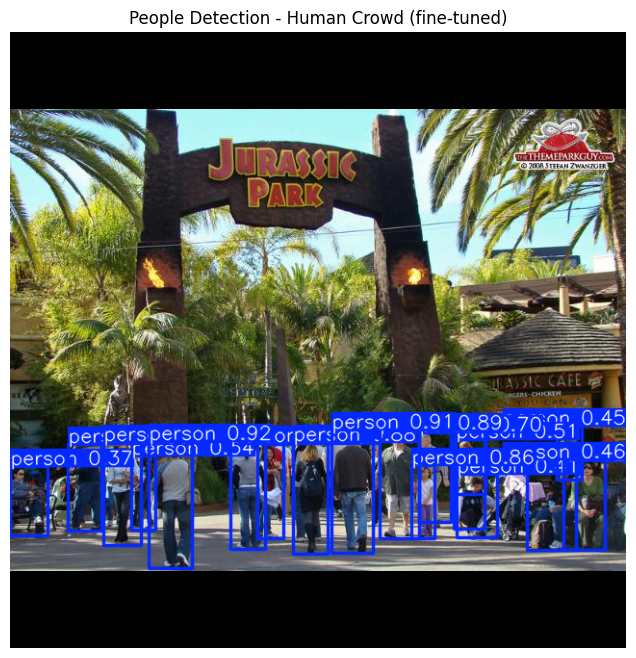

In [10]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

img_files = [f for f in os.listdir(images_root) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
sample_img = random.choice(img_files)
sample_path = os.path.join(images_root, sample_img)
print("Sample image:", sample_path)

res = best.predict(source=sample_path, conf=0.3)[0]
annotated = res.plot() 

annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 8))
plt.imshow(annotated_rgb)
plt.axis("off")
plt.title("People Detection - Human Crowd (fine-tuned)")
plt.show()

In [11]:
import cv2
import torchvision.ops as tvops

video_source = "Input/1.mp4"   
output_video = "Output/1.mp4"

cap = cv2.VideoCapture(video_source)
fps = cap.get(cv2.CAP_PROP_FPS)
w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_video, fourcc, fps, (w, h))

frame_no = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    res = best(frame, conf=0.35, iou=0.5, imgsz=640)[0]

    annotated = frame.copy()
    count_person = 0

    if res.boxes is not None and len(res.boxes) > 0:
        xyxy = res.boxes.xyxy  # [N, 4]
        conf = res.boxes.conf  # [N]
        cls  = res.boxes.cls   # [N]

        mask_person = (cls == 0)
        boxes = xyxy[mask_person]
        scores = conf[mask_person]

        if len(boxes) > 0:
            keep_idx = tvops.nms(boxes, scores, iou_threshold=0.5)
            boxes = boxes[keep_idx]
            scores = scores[keep_idx]

            for i in range(len(boxes)):
                x1, y1, x2, y2 = boxes[i].tolist()
                score = scores[i].item()

                bw = x2 - x1
                bh = y2 - y1
                if bw <= 0 or bh <= 0:
                    continue

                ratio = bh / bw
                if ratio < 0.8 or ratio > 4.5:
                    continue
                if bw < 15 or bh < 25:
                    continue

                count_person += 1
                cv2.rectangle(annotated, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 2)
                cv2.putText(
                    annotated, f"person {score:.2f}",
                    (int(x1), int(y1) - 5),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (0,255,0), 2
                )

    cv2.putText(
        annotated, f"People Detection: {count_person}",
        (20, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        1, (255,255,255), 2
    )

    out.write(annotated)
    frame_no += 1
    if frame_no % 20 == 0:
        print(f"Frame {frame_no}, person: {count_person}")

cap.release()
out.release()
print("Finished. Saved video to:", output_video)



0: 384x640 32 persons, 576.0ms
Speed: 49.2ms preprocess, 576.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 33 persons, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 33 persons, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 32 persons, 8.5ms
Speed: 4.4ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 33 persons, 8.7ms
Speed: 1.9ms preprocess, 8.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 32 persons, 6.2ms
Speed: 4.9ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 32 persons, 5.0ms
Speed: 1.5ms preprocess, 5.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 31 persons, 5.4ms
Speed: 2.2ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 